Before performing the analysis, the preprocessing is done by Deciphering_CIMP_Preprocessing. Here we download directly the preprocessed data.

# Package dependencies

In [1]:
# general 
from __future__ import division
import numpy as np
import pandas as pd
import xenaPython as xena
import re
import os
from collections import Counter
import csv
from tqdm.notebook import trange, tqdm

# clustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.preprocessing import StandardScaler
import networkx as nx
import numpy.linalg as LA

# for clustering comparison
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.mixture import GaussianMixture

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# statistical tests
from scipy.stats import mannwhitneyu, kruskal, chisquare, ks_2samp, fisher_exact, ttest_ind, pointbiserialr, chi2_contingency, pearsonr, spearmanr

# statistical annotations
from statannot import add_stat_annotation

# dim reduction
import umap

# survival analysis
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests
from lifelines import CoxPHFitter

# Random Forest analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score

C:\Users\josep\Anaconda3\lib\site-packages\xenaPython\__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


# Download preprocessed data

In [2]:
# info_dir = '/mnt/data/projects/Josephine_CIMP/CIMP_unsupervised_cancer/filtered_illumina_TCGA'
info_dir = "N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\filtered_illumina_TCGA"
clin_raw_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\clinical_raw"
meth_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\filtered_new_method"

In [3]:
cancer_to_keep = os.listdir(meth_dir)

In [4]:
cancer_to_keep = np.unique([cancer_to_keep[i].split('_')[0] for i in range(len(cancer_to_keep))]) 

In [5]:
meth_data_pc = {}
for cancer in tqdm(cancer_to_keep):
    meth_data_pc[cancer] = pd.read_csv(os.path.join(meth_dir,cancer+"_meth_filtered.csv"))
    meth_data_pc[cancer] = meth_data_pc[cancer].set_index("Unnamed: 0")   

In [6]:
cancer_clin_raw_pc = {}
for cancer in tqdm(cancer_to_keep):
    cancer_clin_raw_pc[cancer]= pd.read_csv(os.path.join(clin_raw_dir,"TCGA-"+cancer+".GDC_phenotype.tsv.gz"),sep="\t").set_index("submitter_id.samples")
    cancer_clin_raw_pc[cancer].index = [cancer_clin_raw_pc[cancer].index[i][:15] for i in range(len(cancer_clin_raw_pc[cancer].index))]

In [7]:
pcpg_diagnosis = cancer_clin_raw_pc["PCPG"]["primary_diagnosis.diagnoses"].str.split(",").apply(lambda a: a[0]).str.split(" ").apply(lambda a: a[-1]).str.lower()
pheo_patients = pcpg_diagnosis[pcpg_diagnosis=="pheochromocytoma"].index
para_patients = pcpg_diagnosis[pcpg_diagnosis=="paraganglioma"].index
meth_data_pc["PCPG"] = meth_data_pc["PCPG"].loc[meth_data_pc["PCPG"].index.intersection(pheo_patients)]

In [8]:
clin_data_pc = {}
for cancer in tqdm(cancer_to_keep):
    clin_data_pc[cancer] = pd.read_csv(os.path.join(info_dir,cancer+"_clin_mat.csv"))
    clin_data_pc[cancer] = clin_data_pc[cancer].set_index("Unnamed: 0")   

In [9]:
for cancer in tqdm(cancer_to_keep):
    meth_data_pc[cancer] = meth_data_pc[cancer][~meth_data_pc[cancer].index.duplicated(keep='first')]
    clin_data_pc[cancer] = clin_data_pc[cancer][~clin_data_pc[cancer].index.duplicated(keep='first')]
    cancer_clin_raw_pc[cancer] = cancer_clin_raw_pc[cancer][~cancer_clin_raw_pc[cancer].index.duplicated(keep='first')]

In [10]:
mut_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\mutations"
mut_pancan = {}
for cancer in tqdm(cancer_to_keep):
    if cancer in ["COAD","READ"]:
        mut_pancan[cancer] = pd.read_csv(os.path.join(info_dir,"COADREAD_mutations.csv"))
        mut_pancan[cancer] = mut_pancan[cancer].set_index("Unnamed: 0")  
        mut_pancan[cancer] = mut_pancan[cancer].loc[meth_data_pc[cancer].index.intersection(mut_pancan[cancer].index)]
    elif cancer=="PCPG":
        mut_pancan[cancer] = pd.read_csv(os.path.join(info_dir,"PCPG_mutations.csv"))
        mut_pancan[cancer] = mut_pancan[cancer].set_index("Unnamed: 0")  
        mut_pancan[cancer] = mut_pancan[cancer].loc[meth_data_pc[cancer].index.intersection(mut_pancan[cancer].index)]
    else:
        mut_pancan[cancer] = pd.read_csv(os.path.join(mut_dir,cancer+"_mutations.csv")).set_index("Unnamed: 0")
mut_pancan["LAML"] = mut_pancan["LAML"].rename(columns={"KDM7A":"JHDM1D"})

In [11]:
msi_profile = pd.read_csv("MSI_status_nature_Cortes_Ciriano.csv",sep=";").set_index("Barcode")

### Preliminary: genes to use

The genes associated with DNA & histone methylation/demethylation are taken from the following sources: 
1. Hyun K, Jeon J, Park K, Kim J. Writing, erasing and reading histone lysine methylations. Exp Mol Med 2017; 49: e324
2. Moore LD, Le T, Fan G. DNA methylation and its basic function. Neuropsychopharmacology 2013; 38: 23–38
3. de Necochea-Campion R, Ghochikyan A, Josephs SF, Zacharias S, Woods E, Karimi-Busheri F et al. Expression of the epigenetic factor BORIS (CTCFL) in the human genome. J Transl Med 2011; 9: 213
4. Santoro R, Li J, Grummt I. The nucleolar remodeling complex NoRC mediates heterochromatin formation and silencing of ribosomal gene transcription. Nat Genet 2002; 32: 393–396
5. Lee GE, Kim JH, Taylor M, Muller MT. DNA methyltransferase 1-associated protein (DMAP1) is a co-repressor that stimulates DNA methylation globally and locally at sites of double strand break repair. J Biol Chem 2010; 285: 37630–37640
6. Bledea R, Vasudevaraja V, Patel S, Stafford J, Serrano J, Esposito G et al. Functional and topographic effects on DNA methylation in IDH1/2 mutant cancers. Sci Rep 2019; 9: 16830

In [12]:
genes_writer_Hmeth = {"H3K4": ["SETD1A","SETD1B","KMT2A","KMT2D","KMT2C","KMT2B","SMYD1","SMYD2","SETD7","SETD9","PRDM9"],
                      "H3K9": ["SUV39H1","SUV39H2","EHMT2","EHMT1","SETDB1","PRDM1","PRDM2","MECOM","PRDM4","PRDM5","PRDM6","PRDM7","PRDM8","PRDM9","PRDM10","PRDM11","PRDM12","PRDM13","PRDM14","PRDM15","PRDM16"],
                      "H3K27": ["EZH1","EZH2"],
                      "H3K36": ["SETD2","NSD1","WHSC1","WHSC1L1","SMYD2","ASH1L","SETD3","SETMAR"],
                      "H3K79": ["DOT1L"],
                      "H4K20": ["SETD8","SUV420H1","SUV420H2"]}
all_genes_writer_Hmeth = list(genes_writer_Hmeth.values())
all_genes_writer_Hmeth = np.unique([item for sublist in all_genes_writer_Hmeth for item in sublist])

genes_eraser_Hmeth = {"H3K4": ["KDM1A","KDM1B","KDM5A","KDM5B","KDM5C","KDM5D"],
                      "H3K9": ["KDM3B","KDM3A","KDM4A","KDM4B","KDM4C","KDM4D","KDM4E","PHF8","JMJD1C"],
                      "H3K27": ["KDM6A","UTY","KDM6B","JHDM1D","PHF8"],
                      "H3K36": ["KDM2A","KDM2B","KDM4A","KDM4B","KDM4C","KDM4D"],
                      "H3K79": [],
                      "H4K20": ["PHF8","PHF2"]}
all_genes_eraser_Hmeth = list(genes_eraser_Hmeth.values())
all_genes_eraser_Hmeth = np.unique([item for sublist in all_genes_eraser_Hmeth for item in sublist])

In [13]:
genes_meth = ["BAZ2A","CTCFL","DMAP1","DNMT1","DNMT3A","DNMT3B","GADD45A","GADD45B",
                       "GADD45G","GADD45GIP1","UHRF1","UHRF1BP1","UHRF1BP1L"]
genes_demeth = ["TET1","TET2","TET3","TDG","TDGF1","TDGF1P3","MBD1","MBD2","MBD4","APOBEC1","CTCF","IDH1","IDH2"]

co_expressed_genes = {"TET1": ["DNMT1", "DNMT3A","DNMT3B","EZH2","MECP2","NANOG","OGDH","PRMT5","SIN3A","TDG"],
                     "TET2": ["ASXL1","CXXC4","DNMT1","DNMT3A","EZH2","IDH1","IDH2","KMT2A","TDG","WT1"],
                     "TET3": ["CA2","DNMT1","DNMT3A","DNMT3B","DPPA3","NANOG","OGDH","EZH2","PRMT5","TDG"],
                     "TDG": ["AICDA","APEX1","CA2","GADD45A","SMUG1","SUMO1","SUMO2","SUMO3","TET1","UBE2I"],
                     "TDGF1": ["ACVR1B","ACVR1C","ACVR2B","GPC1","LEFTY1","LEFTY2","NANOG","NODAL","POU5F1","SMAD2"],
                     "MBD4": ["APEX1","DNMT1","DNMT3B","MLH1","SMUG1","TDG","TRDMT1","UHRF1","UNG","ZBTB33"],
                     "APOBEC1": ["A1CF","APOB","APOBEC2","APOBEC3A","APOBEC3B","APOBEC3C","APOBEC3H","APOBEC4","CDA","HNRNPAB"],
                     "CTCF": ["EP300","EZH2","H2AFZ","HIST2H2AC","MYC","POLR2A","POLR2F","RXRA","SUZ12","WDR5"],
                     "IDH1": ["ACO1","ACO2","CAT","HSD17B4","IDH2","IDH3A","IDH3B","IDH3G","OGDH","PGM1"],
                     "IDH2": ["ACO1","ACO2","GLUD1","IDH1","IDH3A","IDH3B","IDH3G","OGDH","SIRT3","SOD2"],
                     "BAZ2A": ["ARID4B","DNMT1","DNMT3B","H2AFV","H2AFX","H2AFZ","HDAC1","HIST2H2AC","SMARCA5","TTF1"],
                     "CTCFL": ["CBLN4","CHD8","COX7A1","IGF2","PHACTR3","PRMT7","RAD21","RAD21L1","RBM38","SMC3"],
                     "DMAP1": ["ACTL6A","CDC5L","KAT5","MEAF6","MORF4L1","MRGBP","RUVBL1","RUVBL2","VPS72","YEATS4"],
                     "DNMT1": ["DNMT3A","DNMT3B","EZH2","HDAC1","HDAC2","HIST2H3PS2","MBD2","RB1","SMARCA5","UHRF1"],
                     "DNMT3A": ["CBX4","DNMT1","DNMT3B","DNMT3L","EED","EZH2","HIST2H2AC","MYC","PRMT5","SUZ12"],
                     "DNMT3B": ["DNMT1","DNMT3A","EZH2","HDAC1","HDAC2","HIST1H2BA","HIST1H3A","HIST2H3PS2","SMARCA5","SUZ12"],
                     "GADD45A": ["AURKA","BRCA1","CCNB1","CCND1","CDK1","MAP2K6","MAP3K4","MAPK8","PCNA","TP53"],
                     "GADD45B": ["CCNB1","CCNB2","CDK1","GADD45A","GADD45G","MAP2K3","MAP2K6","MAP3K4","PCNA","TP53"],
                     "GADD45G": ["CCNB1","CCNB2","CDK1","GADD45A","GADD45B","MAP2K3","MAP2K6","MAP3K4","PCNA","TP53"],
                     "GADD45GIP1": ["MRPL11","MRPL28","MRPL4","MRPL40","MRPL41","MRPL42","MRPL47","MRPL50","MRPS30","MRPS34"],
                     "UHRF1": ["DNMT1","H2AFX","H2AFZ","HIST1H2BA","HIST1H2BB","HIST1H2BJ","HIST2H2AC","HIST2H2BE","HIST2H3PS2","MCM5"],
                     "UHRF1BP1": ["ANKS1A","C6orf106","FANCE","MORC1","PHRF1","SNRPC","TNIP1","WDFY4","ZNF76"],
                     "UHRF1BP1L": ["DEPDC4","FAM83A","GPATCH2","GPATCH2L","MAN2A1","PTPRH","STX6","TMEM160","VPS13C","ZSCAN23"]}

# get the list of all coexpressed genes
list_co_expressed_genes = list(co_expressed_genes.values())
list_co_expressed_genes = [item for sublist in list_co_expressed_genes for item in sublist]

# get the list of unique genes to keep for analysis
genes_to_keep = np.unique(genes_meth+genes_demeth+list_co_expressed_genes)
# genes_to_keep = gene_data_pc["ACC"].columns.intersection(genes_to_keep)

# genes that are in the GEX matrix
genes_demeth_gex = np.delete(genes_demeth,np.where(np.array(genes_demeth)=="TDGF1P3"))
genes_meth_gex = np.array(genes_meth)

### Delete normal samples

TCGA provides some samples from healthy tissue near the tumour ; we delete them from the original methylation and keep them to compare the distribution of average beta values. For ACC & MESO we have no normal samples from TCGA so we download those from GEO database (preprocessed).

In [14]:
normal_sample_codes = ["10","11","12","13","14","20"]

In [15]:
geo_normal_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\GEO_normal_tissue"

In [16]:
geo_normal_meth = {"ACC": pd.read_csv(os.path.join(geo_normal_dir,"Adrenal_normal_full.csv")).set_index("Unnamed: 0"),
                  "LAML": pd.read_csv(os.path.join(geo_normal_dir,"Blood_normal_full.csv")).set_index("Unnamed: 0"),}

In [17]:
normal_meth,new_meth_data_pc,new_gene_data_pc,new_clin_data_pc = {},{},{},{}
for cancer in tqdm(cancer_to_keep):
    ind_normal_samples = np.where(np.array([meth_data_pc[cancer].index[i].split("-")[-1] for i in range(meth_data_pc[cancer].shape[0])])=="11")[0]
    if cancer=="LGG":
        print("There are {} normal samples for cancer type {}".format(normal_meth["GBM"].shape[0],cancer))
        normal_meth[cancer] = normal_meth["GBM"][normal_meth["GBM"].columns.intersection(meth_data_pc[cancer].columns)]
    elif cancer=="MESO":
        print("There are {} normal samples for cancer type {}".format(normal_meth["LUAD"].shape[0],cancer))
        normal_meth[cancer] = normal_meth["LUAD"][normal_meth["LUAD"].columns.intersection(meth_data_pc[cancer].columns)]
    elif cancer in ["ACC","LAML"]:
        print("There are {} normal samples for cancer type {}".format(geo_normal_meth[cancer].shape[0],cancer))
        normal_meth[cancer] = geo_normal_meth[cancer]
    elif not(len(ind_normal_samples)==0):
        print("There are {} normal samples for cancer type {}".format(len(ind_normal_samples),cancer))
        normal_meth[cancer] = meth_data_pc[cancer].iloc[ind_normal_samples]
    else:
        print("No normal samples for cancer type {}".format(cancer))
        normal_meth[cancer] =  []
    new_meth_data_pc[cancer] = meth_data_pc[cancer].copy().drop(meth_data_pc[cancer].index[ind_normal_samples])
    new_clin_data_pc[cancer] = clin_data_pc[cancer].copy().drop(clin_data_pc[cancer].index.intersection(meth_data_pc[cancer].index[ind_normal_samples]))

There are 6 normal samples for cancer type ACC
There are 21 normal samples for cancer type BLCA
There are 96 normal samples for cancer type BRCA
There are 3 normal samples for cancer type CESC
There are 38 normal samples for cancer type COAD
There are 16 normal samples for cancer type ESCA
There are 2 normal samples for cancer type GBM
There are 50 normal samples for cancer type HNSC
There are 160 normal samples for cancer type KIRC
There are 45 normal samples for cancer type KIRP
There are 15 normal samples for cancer type LAML
There are 2 normal samples for cancer type LGG
There are 50 normal samples for cancer type LIHC
There are 32 normal samples for cancer type LUAD
There are 42 normal samples for cancer type LUSC
There are 32 normal samples for cancer type MESO
There are 10 normal samples for cancer type PAAD
There are 3 normal samples for cancer type PCPG
There are 50 normal samples for cancer type PRAD
There are 7 normal samples for cancer type READ
There are 4 normal samples f

In [19]:
avg_samp,avg_cpg=[],[]
for cancer in new_meth_data_pc:
    print(cancer,"meth info: ",new_meth_data_pc[cancer].shape)
    avg_samp.append(new_meth_data_pc[cancer].shape[0])
    avg_cpg.append(new_meth_data_pc[cancer].shape[1])
print('average sample size : ',np.mean(avg_samp),np.quantile(avg_samp,0.25),np.quantile(avg_samp,0.75),
      'average cpg ids : ',np.mean(avg_cpg),np.quantile(avg_cpg,0.25),np.quantile(avg_cpg,0.75))


ACC meth info:  (80, 34577)
BLCA meth info:  (413, 36910)
BRCA meth info:  (787, 27073)
CESC meth info:  (309, 34212)
COAD meth info:  (298, 28558)
ESCA meth info:  (186, 36423)
GBM meth info:  (153, 32314)
HNSC meth info:  (530, 37346)
KIRC meth info:  (320, 28438)
KIRP meth info:  (276, 26657)
LAML meth info:  (140, 28321)
LGG meth info:  (530, 23685)
LIHC meth info:  (379, 34744)
LUAD meth info:  (460, 32428)
LUSC meth info:  (370, 37288)
MESO meth info:  (87, 31298)
PAAD meth info:  (185, 30624)
PCPG meth info:  (152, 41606)
PRAD meth info:  (499, 23476)
READ meth info:  (99, 29389)
SARC meth info:  (265, 35027)
SKCM meth info:  (473, 35655)
STAD meth info:  (395, 42899)
THCA meth info:  (515, 22522)
THYM meth info:  (124, 26972)
UCEC meth info:  (432, 28019)
average sample size :  325.2692307692308 161.0 453.0 average cpg ids :  31786.96153846154 28094.5 35498.0


# Clustering

First we standardize the data to be able to perform dimensionality reduction

In [18]:
std_sc_data = {}
for cancer in tqdm(cancer_to_keep):
    std_sc = StandardScaler()
    std_sc_data[cancer] = std_sc.fit_transform(new_meth_data_pc[cancer])


In [19]:
df_transf_data = {}
for cancer in tqdm(cancer_to_keep):
    df_transf_data[cancer] = pd.DataFrame(std_sc_data[cancer], index=new_meth_data_pc[cancer].index, columns=new_meth_data_pc[cancer].columns)

### Dimensionality reduction

We use Uniform Manifold Approximation and Projection (UMAP) 
Ref : McInnes L, Healy J, Melville J. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv [stat.ML]. 2018.http://arxiv.org/abs/1802.03426.

In [20]:
umap_red_data= {}
for cancer in tqdm(cancer_to_keep):
    reducer = umap.UMAP(n_components=2)
    umap_red_data[cancer] = reducer.fit_transform(df_transf_data[cancer])

### Check optimal number of clusters

To choose the optimal number of cluster, we compute the 10-nearest neighbor affinity matrix 

In [20]:
def get_consensus_matrix_clustering(meth_data_pc,cancer_to_keep,triple_cluster_cancers,n_runs,kernel):
#     Parameters: meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
#             cancer_to_keep (list): names of cancer types
#             triple_cluster_cancers (list): names of cancer types with 3 methylation groups
#             n_runs (int): number of runs for consensus clustering (avoid randomness due to init)
#             kernel (str): either "NN" or "aff", to compute from a preexisting affinity matrix or not
#     Returns: consensus_matrix (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_runs) (rows=patients,columns=runs)
#             affinity_matrix (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_pat) 
#                            corresponding to affinity between pairs of patients (rows=patients,columns=patients)
    if kernel=="NN":
        affinity_matrix = {}
    else:
        affinity_matrix = meth_data_pc
    consensus_matrix = {cancer: [] for cancer in cancer_to_keep}
    for r in tqdm(range(n_runs)):
        agglomerative_clustering_pc = {}
        for cancer in cancer_to_keep:
            print(cancer)
            if cancer in triple_cluster_cancers:
                if kernel=="NN":
                    agglomerative = SpectralClustering(n_clusters=3,affinity="nearest_neighbors",n_neighbors=10)
                else:   
                    agglomerative = SpectralClustering(n_clusters=3,affinity="precomputed")
            else:
                if kernel=="NN":
                      agglomerative = SpectralClustering(n_clusters=2,affinity="nearest_neighbors",n_neighbors=10)
                else:
                    agglomerative = SpectralClustering(n_clusters=2,affinity="precomputed")
            if kernel=="NN":       
                agglomerative.fit(meth_data_pc[cancer].values)
                affinity_matrix[cancer] = agglomerative.affinity_matrix_ 
                affinity_matrix[cancer] = affinity_matrix[cancer].todense()
            else:
                agglomerative.fit(meth_data_pc[cancer])
                
            agglomerative_clustering_pc[cancer] = pd.DataFrame(agglomerative.labels_,columns=["cluster"])
            agglomerative_clustering_pc[cancer] = agglomerative_clustering_pc[cancer]+1

            if len(consensus_matrix[cancer])==0:
                consensus_matrix[cancer] = agglomerative_clustering_pc[cancer]
            else:
                consensus_matrix[cancer] = pd.concat([consensus_matrix[cancer],agglomerative_clustering_pc[cancer]],axis=1)
    return consensus_matrix, affinity_matrix

In [ ]:
consensus_matrix_spectral, affinity_matrix = get_consensus_matrix_clustering(new_meth_data_pc,cancer_to_keep,[],1,"NN")

ACC Gap1: 4.334986211043226, Gap2: 4.759839106166659, Gap3: 5.672722380974742, Gap4: 0.9516360910913537
Optimal number of clusters 3
BLCA Gap1: 5.913898563380961, Gap2: 4.328736163460981, Gap3: 0.7065850514377452, Gap4: 0.9594109948150908
Optimal number of clusters 2
BRCA Gap1: 8.777416182196795, Gap2: 4.9651367248196685, Gap3: 2.6196286144756016, Gap4: 1.6578280064291313
Optimal number of clusters 2
CESC Gap1: 7.4670234708946595, Gap2: 0.3466998888148147, Gap3: 2.350290130770418, Gap4: 4.3100156265004195
Optimal number of clusters 4
COAD Gap1: 11.329340061863455, Gap2: 2.504662644486956, Gap3: 2.4579697657515993, Gap4: 2.056747110779579
Optimal number of clusters 2
ESCA Gap1: 2.5119098151312436, Gap2: 5.131533298362083, Gap3: 4.151560353181093, Gap4: 2.274344391841458
Optimal number of clusters 2
GBM Gap1: 7.776301577198172, Gap2: 3.6621279211504714, Gap3: 1.1838912548030294, Gap4: 1.8127658126096708
Optimal number of clusters 2
HNSC Gap1: 5.941160060909201, Gap2: 1.9280770150390616, 

C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


SKCM Gap1: 7.979227186007908, Gap2: 5.251239850611835, Gap3: 2.6131260211224863, Gap4: 0.7528790320508278
Optimal number of clusters 2


C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


STAD Gap1: 3.833312892643221, Gap2: 5.186286739870546, Gap3: 0.3013487722729735, Gap4: 1.4020537916116425
Optimal number of clusters 2


C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


THCA Gap1: (106.10315410334141+0j), Gap2: (-24.841666167121804+0j), Gap3: (-40.266635768760196+0j), Gap4: (36.61791942509933+0j)
Optimal number of clusters 4
THYM Gap1: 2.224153813055299, Gap2: 3.3323120221014477, Gap3: -0.09210469196123938, Gap4: 3.768382659824132
Optimal number of clusters 4


C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
C:\Users\josep\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


UCEC Gap1: 5.731573950425986, Gap2: 3.53505440564242, Gap3: 3.4017622334205804, Gap4: 1.4946292469361886
Optimal number of clusters 2



C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


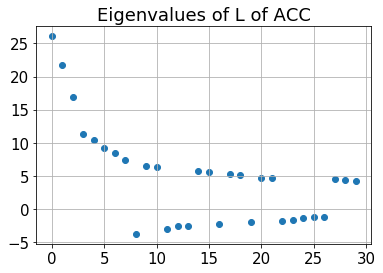

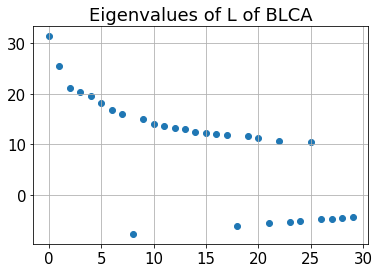

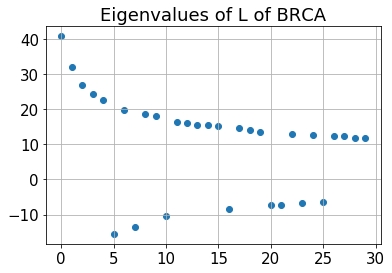

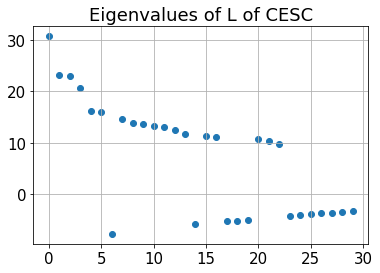

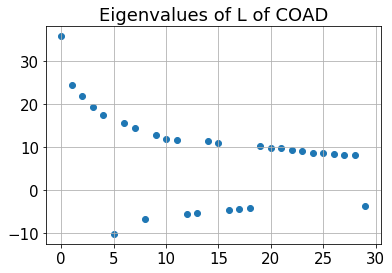

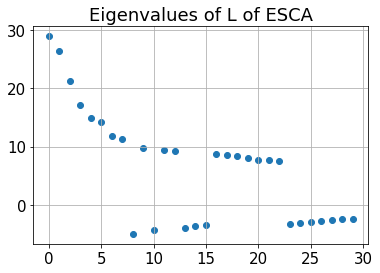

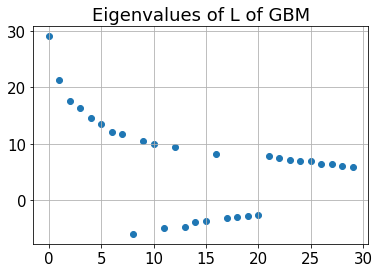

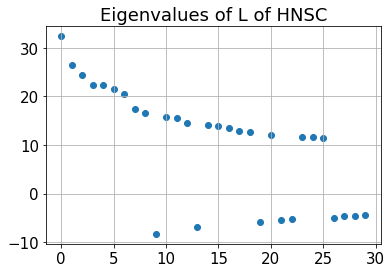

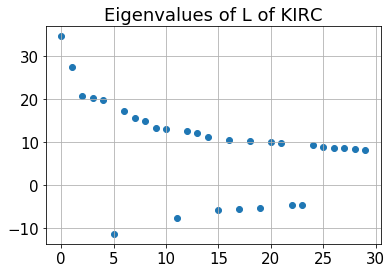

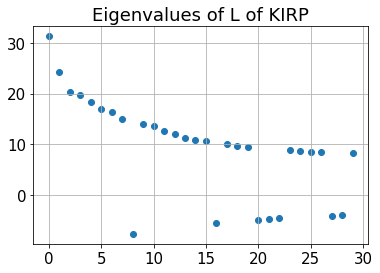

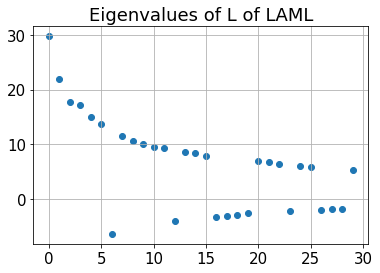

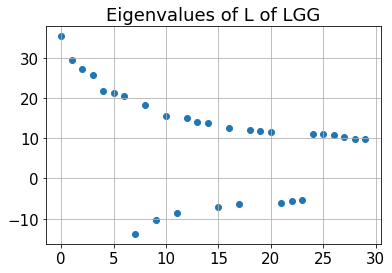

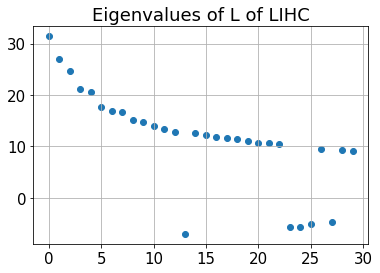

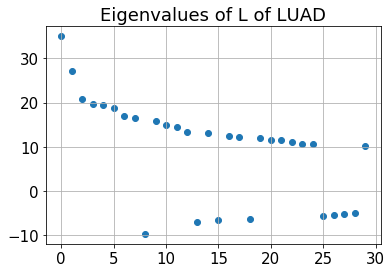

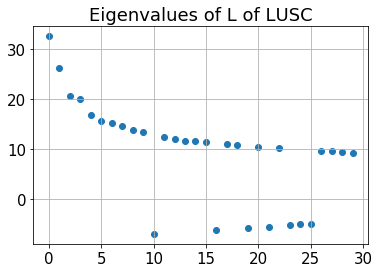

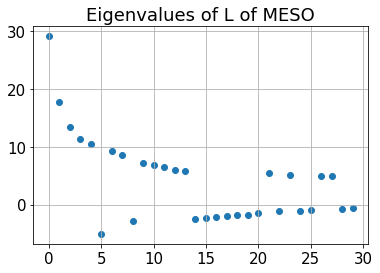

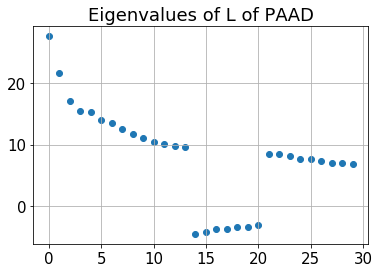

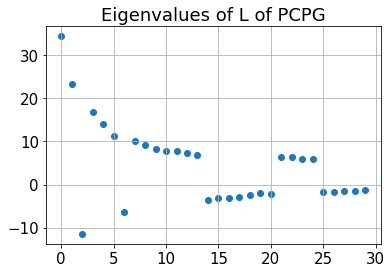

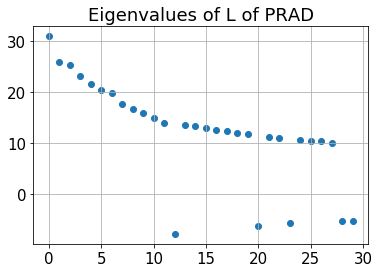

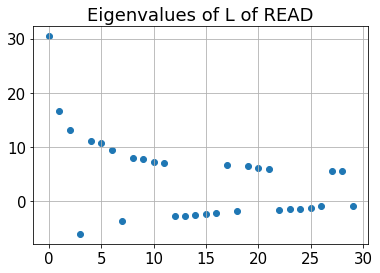

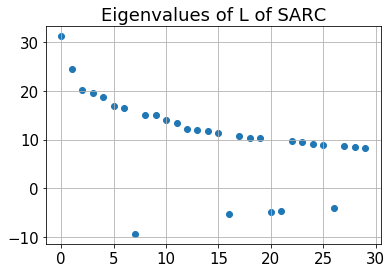

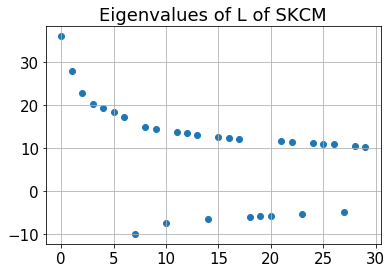

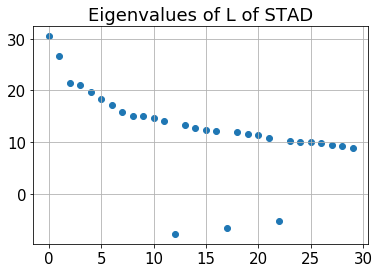

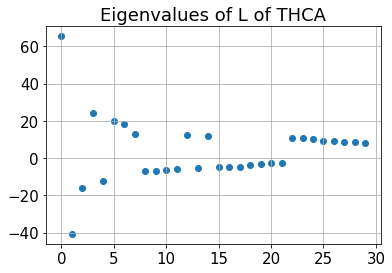

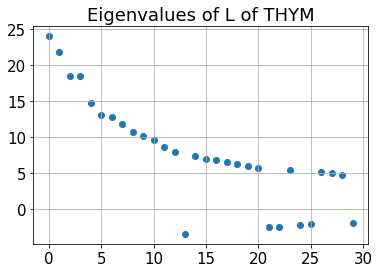

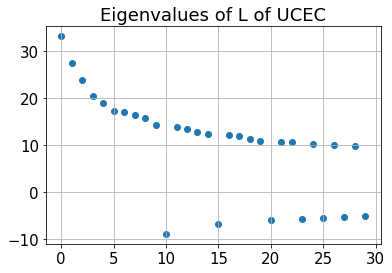

In [26]:
# compute the eigenvalues for the signless Laplacian

plt.rc('font', size=15)
for cancer in tqdm(cancer_to_keep):
    graph = graph_of_patients(list(new_meth_data_pc[cancer].index),affinity_matrix[cancer])
    L = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(graph)
    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    signL = L.todense() + A.todense() + A.todense()
    eigenvalues, eigenvectors = LA.eig(signL)
    eigengaps = [-eigenvalues[1]+eigenvalues[0],-eigenvalues[2]+eigenvalues[1],
                                                         -eigenvalues[3]+eigenvalues[2],-eigenvalues[4]+eigenvalues[3]]
    print("{} Gap1: {}, Gap2: {}, Gap3: {}, Gap4: {}".format(cancer,eigengaps[0],eigengaps[1],
                                                            eigengaps[2],eigengaps[3]))
    print("Optimal number of clusters {}".format(np.argmax(eigengaps[1:])+2))
    plt.figure()
    plt.title('Eigenvalues of L of '+cancer)
    plt.scatter(np.arange(30), eigenvalues[:30])
    plt.ylim()
    plt.grid()

In [23]:
### real cancer with 3: ACC, CESC, HNSC, LIHC, PRAD, READ, THCA

In [21]:
# list of cancers for which optimal value is 3
triple_cluster_cancers_aff = ['ACC', 'BRCA', 'CESC', 'COAD', 'GBM', 'ESCA', 'HNSC', 'KIRC', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'PAAD', 'PCPG', 'READ', 'SKCM', 'THYM', 'UCEC']

In [38]:
consensus_matrix_spectral, affinity_matrix = get_consensus_matrix_clustering(affinity_matrix,cancer_to_keep,triple_cluster_cancers_aff,10,"aff")

ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC
ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC
ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC
ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC
ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC
ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC
ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC
ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD

In [22]:
# perform consensus clustering 
cluster_memb_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\cluster_memb"
from netneurotools import cluster
consensus_clustering_spectral = {}
for cancer in tqdm(cancer_to_keep):
#     consensus_clustering_spectral[cancer] = pd.DataFrame(cluster.find_consensus(consensus_matrix_spectral[cancer].values, seed=1234),columns=["cluster"],index=new_meth_data_pc[cancer].index)
#     consensus_clustering_spectral[cancer] = consensus_clustering_spectral[cancer].reset_index()
#     pd.DataFrame(consensus_clustering_spectral[cancer]).to_csv(os.path.join(cluster_memb_dir,cancer+"_cluster_memb_new.csv"))
# #####
    consensus_clustering_spectral[cancer] = pd.read_csv(os.path.join(cluster_memb_dir,cancer+"_cluster_memb_new.csv")).set_index("Unnamed: 0")
    consensus_clustering_spectral[cancer].columns=["id","cluster"]

In [23]:
for cancer in tqdm(cancer_to_keep):
    consensus_clustering_spectral[cancer] = consensus_clustering_spectral[cancer].set_index("id")
consensus_clustering_spectral["CESC"] = consensus_clustering_spectral["CESC"].replace({4: 3})

In [61]:
sign_cpg_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\sign_cpg_spectral"
def get_sign_kw_louvain(meth_data_pc, cancer_to_keep, consensus_clustering):
#     Parameters: meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
#             cancer_to_keep (list): names of cancer types
#             consensus_clustering (dict): keys are cancer types, values are pd.DataFrame (n_pat,1) (rows=patients, column=cluster membership)
#     Returns: kw (dict): keys are cancer types, values are list of sign. cpg probes for 
    kw = {}
    for cancer in tqdm(cancer_to_keep):
        kw[cancer]=[]
        positions = meth_data_pc[cancer].columns
        ind_cl_1 = np.where(consensus_clustering[cancer]["cluster"].values==1)[0]
        ind_cl_2 = np.where(consensus_clustering[cancer]["cluster"].values==2)[0]
        ind_cl_3 = np.where(consensus_clustering[cancer]["cluster"].values==3)[0]
        print(cancer)
        if len(np.unique(consensus_clustering[cancer]["cluster"].values))==2:
            meth_cl_1 = meth_data_pc[cancer].iloc[ind_cl_1].copy()
            meth_cl_2 = meth_data_pc[cancer].iloc[ind_cl_2].copy()
            for pos in tqdm(positions):
                kw[cancer].append(kruskal(meth_cl_1[pos],
                        meth_cl_2[pos])[1])
        elif len(np.unique(consensus_clustering[cancer]["cluster"].values))==3:
            meth_cl_1 = meth_data_pc[cancer].iloc[ind_cl_1].copy()
            meth_cl_2 = meth_data_pc[cancer].iloc[ind_cl_2].copy()
            meth_cl_3 = meth_data_pc[cancer].iloc[ind_cl_3].copy()
            for pos in tqdm(positions):
                kw[cancer].append(kruskal(meth_cl_1[pos],
                        meth_cl_2[pos],
                        meth_cl_3[pos])[1])
        else:
            print("The cancer {} is not taken into consideration (too many clusters)".format(cancer))
            continue
        ind_sign = np.where(np.array(kw[cancer])<(0.05/len(kw[cancer])))[0]
        print("There are {} significantly different positions between clusters for cancer type {}".format(len(ind_sign),cancer))
        sign_pos=[meth_data_pc[cancer].columns[i] for i in ind_sign]
        pd.DataFrame(sign_pos).to_csv(os.path.join(sign_cpg_dir,cancer+"_sign_cpg_spectral.csv"))
    return kw

In [ ]:
kw_snf = get_sign_kw_louvain(new_meth_data_pc, ["LGG"], consensus_clustering_spectral)

In [24]:
sign_cpg_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\sign_cpg_spectral"
sign_pos_spectral = {}
for cancer in cancer_to_keep:
    sign_pos_spectral[cancer] = pd.read_csv(os.path.join(sign_cpg_dir,cancer+"_sign_cpg_spectral.csv")).set_index("Unnamed: 0")

In [25]:
avg_size_sign_pos = []
for cancer in sign_pos_spectral:
    print(cancer,sign_pos_spectral[cancer].shape[0])
    avg_size_sign_pos.append(sign_pos_spectral[cancer].shape[0])
print("avg : ",np.mean(avg_size_sign_pos),"25% : ",np.quantile(avg_size_sign_pos,0.25),"75% : ",np.quantile(avg_size_sign_pos,0.75))

ACC 3490
BLCA 22755
BRCA 22251
CESC 18793
COAD 12951
ESCA 16948
GBM 8940
HNSC 24794
KIRC 9675
KIRP 4914
LAML 3204
LGG 14872
LIHC 23712
LUAD 21030
LUSC 25347
MESO 625
PAAD 10360
PCPG 9113
PRAD 13476
READ 2788
SARC 1315
SKCM 26622
STAD 21753
THCA 3438
THYM 14899
UCEC 16005
avg :  13618.076923076924 25% :  5920.5 75% :  21572.25


In [26]:
def get_avg_methylation_snf(sign_pos, meth_data_pc, consensus_clustering, cancer_order):
#     Parameters: meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
#             sign_pos (dict): keys are cancer types, values are pd.DataFrame (n_sign_pos,1) (rows=sign_pos,)
#             consensus_clustering (dict): keys are cancer types, values are pd.DataFrame (n_pat,1) (rows=patients, column=cluster membership)
#             cancer_order (list): list of cancer types in the KS order
#     Returns: avg_meth (pd.Df): the average beta values over significant positions (n_cancers,n_clusters) (rows=cancer,column=cluster number)
    avg_meth = {}
    for cancer in cancer_order:
        avg_meth[cancer] = []
        for i in np.unique(consensus_clustering[cancer]["cluster"].values):
            avg_meth[cancer].append(np.round(np.mean(meth_data_pc[cancer].iloc[np.where(consensus_clustering[cancer]["cluster"].values==i)[0]][sign_pos[cancer].values.ravel()].mean()),2))
    return pd.DataFrame.from_dict(avg_meth, orient='index')

In [27]:
avg_meth_snf_spectral = get_avg_methylation_snf(sign_pos_spectral, new_meth_data_pc, consensus_clustering_spectral, cancer_to_keep)
avg_meth_snf_spectral.columns=[1,2,3]
avg_meth_snf_spectral

1     2     3
ACC   0.64  0.50  0.25
BLCA  0.45  0.62   NaN
BRCA  0.51  0.61  0.51
CESC  0.61  0.73  0.45
COAD  0.42  0.30  0.63
ESCA  0.51  0.58  0.42
GBM   0.48  0.66  0.68
HNSC  0.59  0.61  0.41
KIRC  0.36  0.50  0.28
KIRP  0.14  0.71   NaN
LAML  0.30  0.71   NaN
LGG   0.55  0.35   NaN
LIHC  0.56  0.36  0.69
LUAD  0.53  0.64  0.40
LUSC  0.72  0.62  0.47
MESO  0.24  0.50  0.62
PAAD  0.41  0.49  0.60
PCPG  0.55  0.73  0.40
PRAD  0.56  0.44   NaN
READ  0.78  0.64  0.47
SARC  0.77  0.26   NaN
SKCM  0.53  0.68  0.40
STAD  0.28  0.63   NaN
THCA  0.33  0.61   NaN
THYM  0.48  0.60  0.51
UCEC  0.45  0.50  0.61

In [28]:
# make sure the cluster number corresponds to the average beta value (1=lowest, 3=highest)
for cancer in avg_meth_snf_spectral.index:
    sorted_arg = np.argsort(avg_meth_snf_spectral.loc[cancer])
    cl_order = {}
    for i in range(avg_meth_snf_spectral.loc[cancer].dropna().shape[0]):
        cl_order[sorted_arg[i+1]+1] = i+1
    consensus_clustering_spectral[cancer] = consensus_clustering_spectral[cancer].replace({"cluster": cl_order})

In [29]:
df_umap_spectral,umap_red_data_pd = {},{}
for cancer in cancer_to_keep:
    umap_red_data_pd[cancer] = pd.DataFrame(umap_red_data[cancer],index=consensus_clustering_spectral[cancer].index,columns=["Comp1","Comp2"])
    if cancer in triple_cluster_cancers_aff:
        df_umap_spectral[cancer] = pd.concat([umap_red_data_pd[cancer],consensus_clustering_spectral[cancer]],axis=1).replace({1: "Low meth cluster", 2: "Intermediate meth cluster", 3: "High meth cluster"})
    else:
        df_umap_spectral[cancer] = pd.concat([umap_red_data_pd[cancer],consensus_clustering_spectral[cancer]],axis=1).replace({1: "Low meth cluster", 2: "High meth cluster"})
    df_umap_spectral[cancer].columns = ["Comp1","Comp2","Cluster"]

In [30]:
# compute the associated silhouette score in the 2D UMAP reduced space
sil_scores = []
sil_scores_means= []
for cancer in tqdm(cancer_to_keep):
    sil_pd = pd.concat([new_meth_data_pc[cancer],consensus_clustering_spectral[cancer]],axis=1).dropna()
    sil = silhouette_samples(sil_pd.drop("cluster",axis=1),sil_pd["cluster"].values.ravel(),metric="euclidean")
    mn = np.mean(sil)
    print(cancer,mn)
    sil_scores.append(sil)
    sil_scores_means.append(mn)
print("Mean {} IQR [{}-{}]".format(np.mean(sil_scores_means),np.quantile(sil_scores_means,0.25),np.quantile(sil_scores_means,0.75)))

ACC 0.08386583948176475
BLCA 0.10717893910954022
BRCA 0.06997413007463035
CESC 0.07952435370323777
COAD 0.061362461266254456
ESCA 0.11436699610283538
GBM 0.12118481738605807
HNSC 0.09712343878180028
KIRC 0.07984903659380438
KIRP 0.37193897506227186
LAML 0.10488154726039688
LGG 0.21998592203663828
LIHC 0.10312703803590642
LUAD 0.07516587731251759
LUSC 0.05615743706688098
MESO 0.042072787771122576
PAAD 0.07321845609418533
PCPG 0.09016751611466091
PRAD 0.09138656859706015
READ 0.057601723674720814
SARC 0.06314134159230775
SKCM 0.07960626875477281
STAD 0.33381578501329545
THCA 0.13855461664955707
THYM 0.26957560304181133
UCEC 0.056320831979051834

Mean 0.11696724263681091 IQR [0.0707852115795191-0.11256998185451159]


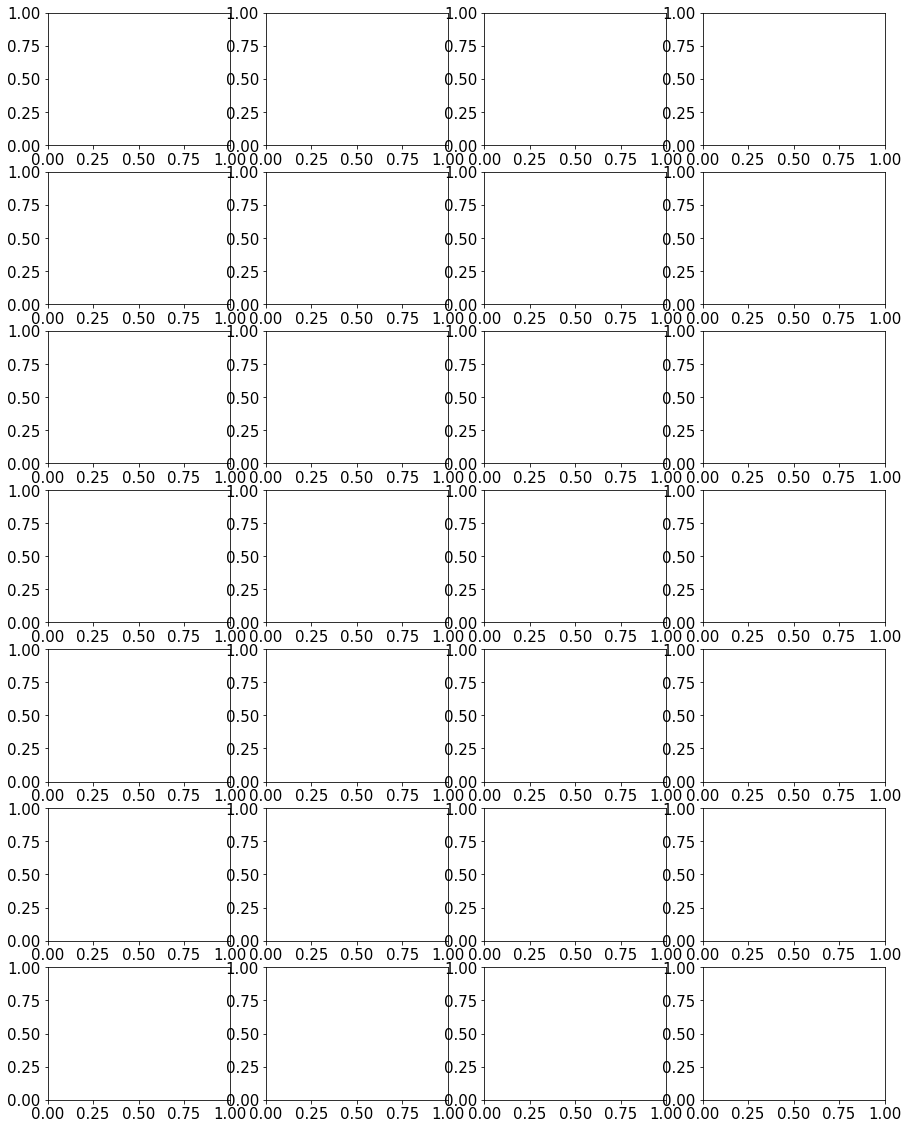

In [106]:
plt.rc('font', size=15)
fig, ax = plt.subplots(7,4,figsize=(15,20))
flatax = ax.flatten()

In [107]:
# plot the silhouette score per sample for each cancer type 
# code inspired from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
seapal = sns.color_palette("bright")
plt.rc('font', size=15)
for j in range(len(sil_scores)):

    cluster_labels = consensus_clustering_spectral[cancer_to_keep[j]].values.ravel()
    sample_silhouette_values = sil_scores[j]
    silhouette_avg = np.mean(sample_silhouette_values)
    n_clusters =  np.max(cluster_labels)
    if n_clusters == 2:
        colors = {0: seapal[0], 1: seapal[3]}
    else:
        colors = {0: seapal[0], 1: seapal[8], 2: seapal[3]}
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i+1]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors[i]
        flatax[j].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    flatax[j].set_title("The silhouette plot for "+cancer_to_keep[j],fontsize=15)
    flatax[j].set_xlabel("SC",fontsize=10)
    flatax[j].set_ylabel("Cluster label",fontsize=10)

    # The vertical line for average silhouette score of all the values
    flatax[j].axvline(x=silhouette_avg, color="red", linestyle="--")

    flatax[j].set_yticks([])  # Clear the yaxis labels / ticks
    flatax[j].set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    flatax[j].tick_params(labelsize=10)

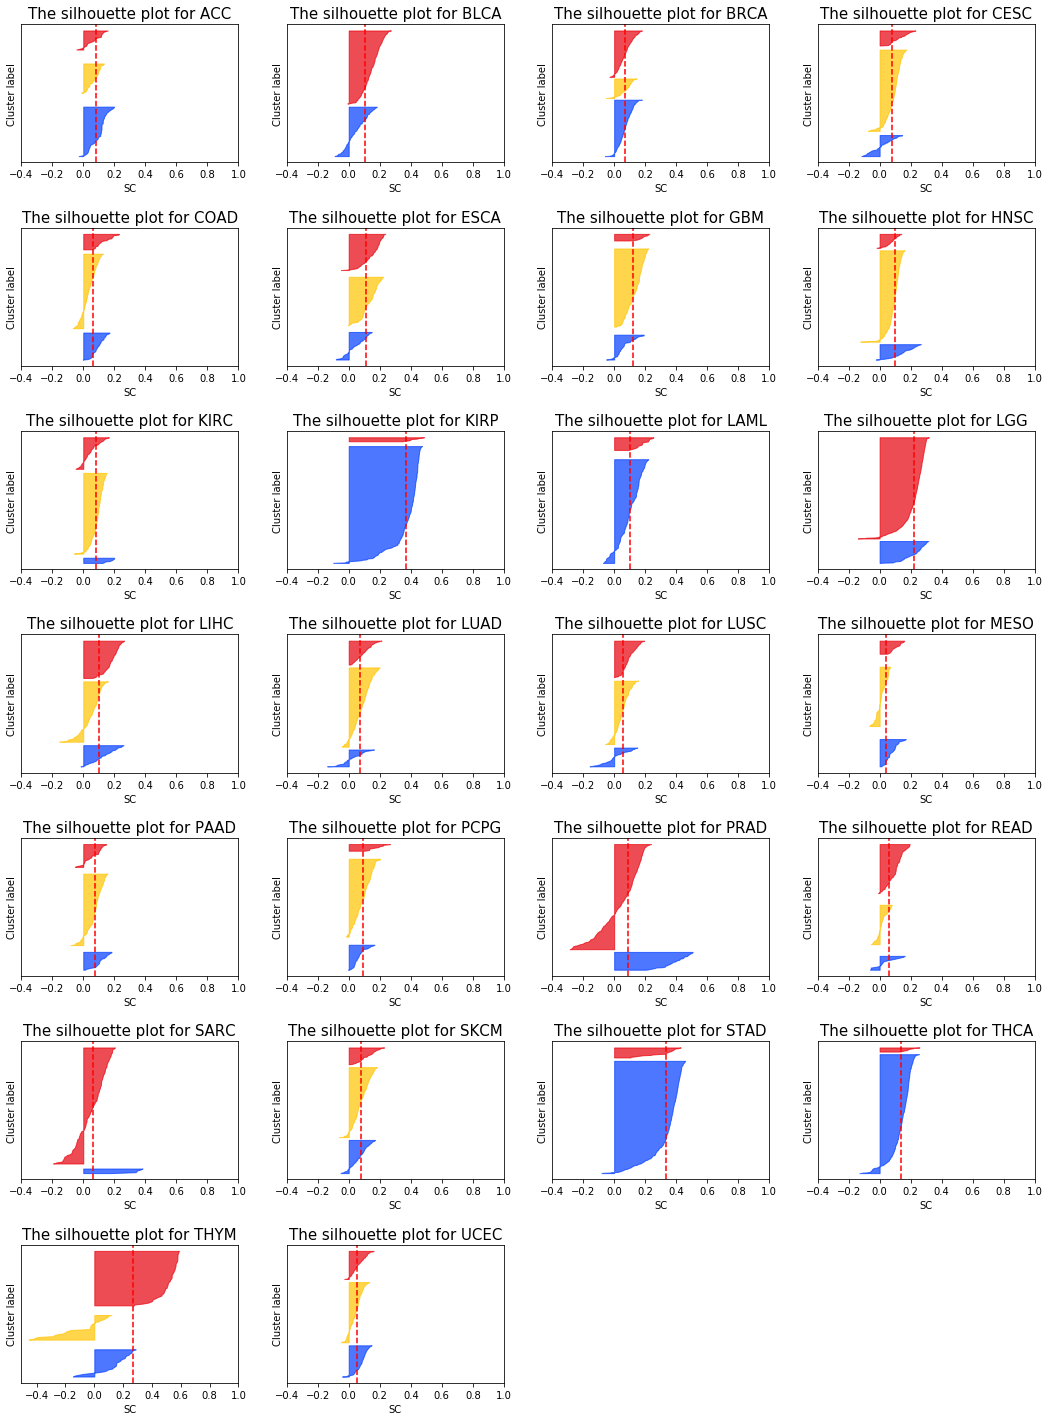

In [108]:
flatax[-1].axis("off")
flatax[-2].axis("off")
fig.tight_layout()
fig

In [109]:
fig.savefig("silhouette_coefficients_full.svg",bbox_inches="tight")
fig.savefig("silhouette_coefficients_full.png",bbox_inches="tight")

In [31]:
def get_plot_df(df_umap_red,sil_scores):
#     Parameters: df_umap_red (dict): keys are cancer types, values are pd.Df (n_patients,3) with columns 
#             the 3 UMAP components coordinates and the cluster membership
#             sil_scores (list): list of size n_cancers with np.array of size n_patients with silhouette score per sample
#     Returns: plot_df_umap_red (pd.Df): rows are patients, columns are the 2 UMAP components coordinates, 
#                        the cluster membership, the cancer type and the silhouette coefficient (n_total_patients,5)
    plt.rc('font', size=15)
    plot_df_umap_red = []
    for i,cancer in enumerate(df_umap_red):
        df = df_umap_red[cancer].copy()
        df["cancer"] = [cancer]*len(df.index)
        sscore = np.array(["Positive" if sil_scores[i][j]>=0 else "Negative" for j in range(len(sil_scores[i]))]).reshape(-1,1)
        df = pd.concat([df,pd.DataFrame(sil_scores[i],index=df.index,columns=["Sil_orig"]),pd.DataFrame(sscore,index=df.index,columns=["Silhouette"])],axis=1)
        if len(plot_df_umap_red)==0:
            plot_df_umap_red = df
        else:
            plot_df_umap_red = pd.concat([plot_df_umap_red,df])
    return plot_df_umap_red


In [32]:
def annotate(data, **kws):
    print(data)
    n = np.round(data["Sil_orig"].mean(),2)
    ax = plt.gca()
    

def get_plot_clustering(plot_df_umap_red):
#     Parameters: plot_df_umap_red (pd.Df): rows are patients, columns are the 2 UMAP components coordinates, 
#             the cluster membership, the cancer type and the silhouette coefficient (n_total_patients,5)
#     Returns: None (plots the figure)
    seapal = sns.color_palette("bright")
    plt.rc('font', size=30)
    facet = sns.relplot(data=plot_df_umap_red, x='Comp1', y='Comp2', hue='Cluster', col="cancer", size="Silhouette", sizes={"Positive": 50, "Negative": 20}, col_wrap=7, palette={"Low meth cluster": seapal[0], "High meth cluster": seapal[3],"Intermediate meth cluster": seapal[8]},
                   facet_kws={'sharey': False, 'sharex': False})
    for i,ax in enumerate(facet.axes):
        df = plot_df_umap_red[plot_df_umap_red["cancer"]==cancer_to_keep[i]]
        ax.text(.9, .9, np.round(df["Sil_orig"].mean(),2), transform=ax.transAxes)
    facet.set_titles('{col_name}')
    facet.set(xticklabels=[])
    facet.set(yticklabels=[])
    facet.fig.subplots_adjust(top=0.9,right=0.85)
    plt.setp(facet._legend.get_title(), fontsize=30)
    plt.setp(facet._legend.get_texts(), fontsize=30)
    plt.setp(facet._legend,bbox_to_anchor=(1.01,0.5))
    plt.savefig("UMAP_clusters.svg",bbox_inches="tight")
    plt.savefig("UMAP_clusters.png",bbox_inches="tight")
    return facet

In [33]:
plot_df_spectral = get_plot_df(df_umap_spectral,sil_scores)

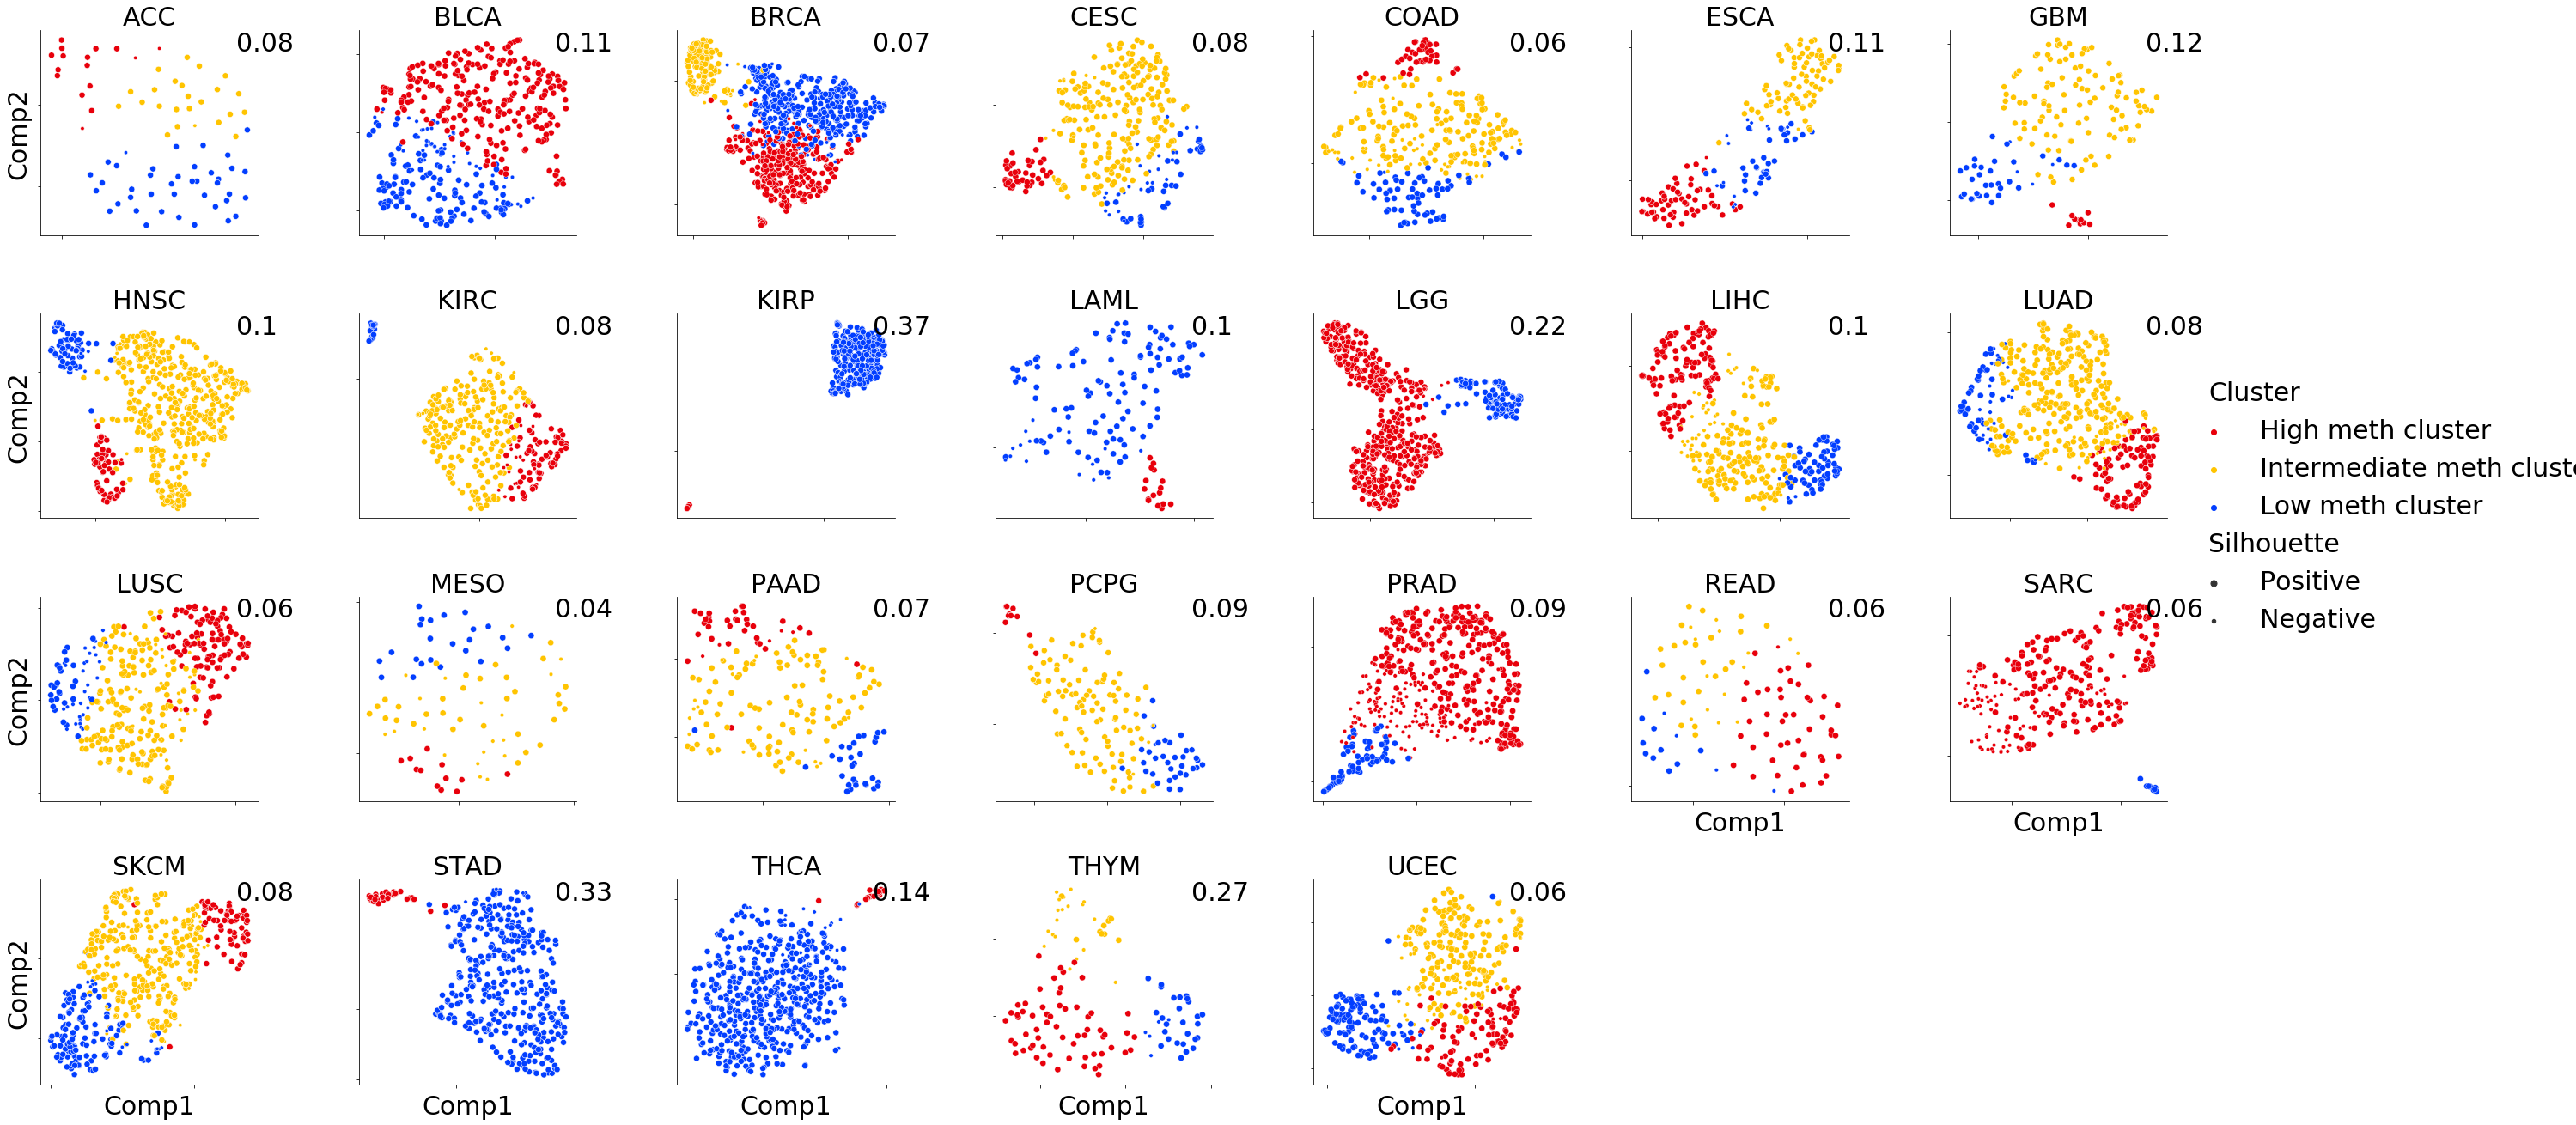

In [77]:
%matplotlib inline
facet = get_plot_clustering(plot_df_spectral)

## Correlation between clustering and clinical features

We compute significant associations between clinical variables and the cluster membership

In [157]:
for cancer in tqdm(cancer_to_keep):
    print(cancer)
    cancer_clin_raw = cancer_clin_raw_pc[cancer]
    common_pat_clustering = consensus_clustering_spectral[cancer].loc[consensus_clustering_spectral[cancer].index.intersection(cancer_clin_raw.index)]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    
    for clin_cat in cancer_clin_raw.columns:
        # Kruskal wallis for continuous variables
        if pd.api.types.is_numeric_dtype(cancer_clin_raw[clin_cat]):
            values_clin_cat = cancer_clin_raw[clin_cat].loc[common_pat_clustering.index].fillna(-1)
            if len(Counter(values_clin_cat))==1:
                continue
            val_cl1,val_cl2,val_cl3 = values_clin_cat.loc[ind_cl_1].values, values_clin_cat.loc[ind_cl_2].values, values_clin_cat.loc[ind_cl_3].values
            if cancer in triple_cluster_cancers_aff:
                kr_p_value = kruskal(val_cl1,val_cl2,val_cl3)[1]
            else:
                kr_p_value = kruskal(val_cl1,val_cl2)[1]
            if kr_p_value<0.05/cancer_clin_raw.shape[1]:
                print("Kruskal {}: {}".format(clin_cat,kr_p_value))
        else:
            # chi square for categorical variables
            values_clin_cat = cancer_clin_raw[clin_cat].fillna("NA")
            if len(Counter(values_clin_cat))==1:
                continue
            freq_cl_1 = pd.DataFrame.from_dict(dict(Counter(values_clin_cat.loc[ind_cl_1].values)),orient="index",columns=["Low"])
            freq_cl_2 = pd.DataFrame.from_dict(dict(Counter(values_clin_cat.loc[ind_cl_2].values)),orient="index",columns=["Int"])
            if cancer in triple_cluster_cancers_aff:
                freq_cl_3 = pd.DataFrame.from_dict(dict(Counter(values_clin_cat.loc[ind_cl_3].values)),orient="index",columns=["High"])
                cont_table = pd.concat([freq_cl_1,freq_cl_2,freq_cl_3],axis=1).fillna(0).T
            else:
                cont_table = pd.concat([freq_cl_1,freq_cl_2],axis=1).fillna(0).T
            if cont_table.shape[1]==1:
                continue
            if "NA" in cont_table.columns:
                cont_table = cont_table.drop("NA",axis=1)
                if cont_table.shape[1]==1:
                    continue
            # check assumption for chi square
            if (cont_table.values<5).any():
                continue
            chi_p_value = chi2_contingency(cont_table)[1]
            if (chi_p_value<0.05/cancer_clin_raw.shape[1]).any():
                print(cont_table)
                print("Chi square {}: {}".format(clin_cat,chi_p_value))

ACC
Kruskal days_to_death.demographic: 0.00022631043188313564
BLCA
BRCA
Kruskal age_at_initial_pathologic_diagnosis: 9.702592042328426e-05
Kruskal age_at_index.demographic: 9.702592042328426e-05
Kruskal days_to_birth.demographic: 0.0003449269226073733
Kruskal age_at_diagnosis.diagnoses: 0.0003449269226073733
CESC
Kruskal lymph_node_examined_count: 0.000240451247234931
COAD
ESCA
Kruskal age_at_initial_pathologic_diagnosis: 2.091861505274774e-05
      NO  YES
Low   28   10
Int   50   16
High  19   32
Chi square reflux_history: 2.9487126922521603e-05
        NO   YES
Low   30.0  16.0
Int   26.0  52.0
High  51.0   9.0
Chi square tissue_prospective_collection_indicator: 4.454764761406885e-09
       YES    NO
Low   30.0  16.0
Int   26.0  52.0
High  51.0   9.0
Chi square tissue_retrospective_collection_indicator: 4.454764761406885e-09
Kruskal weight: 3.2588619425717663e-12
Kruskal year_of_initial_pathologic_diagnosis: 1.4705206979684193e-05
Kruskal age_at_index.demographic: 2.091861505274774e

# Cluster characterization through methylation distribution

In [35]:
def get_dist_methylation_snf(sign_pos, meth_data_pc, consensus_clustering, cancer_order):
#     Parameters: meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
#             sign_pos (dict): keys are cancer types, values are pd.DataFrame (n_sign_pos,1) (rows=sign_pos,)
#             consensus_clustering (dict): keys are cancer types, values are pd.DataFrame (n_pat,1) (rows=patients, column=cluster membership)
#             cancer_order (list): list of cancer types in the KS order
#     Returns: df_list (pd.Df): the average beta values over significant positions with cluster membership and cancer type (n_total_patients,3)
    df_list = []
    for cancer in cancer_order:
        print(cancer)
        values = []
        n_clusters = len(np.unique(consensus_clustering[cancer]["cluster"].values))
        for i in range(n_clusters):
            if n_clusters==2:
                mapping_leg = {0: "Low meth cluster", 1: "High meth cluster"}
            else:
                mapping_leg = {0: "Low meth cluster", 1: "Intermediate meth cluster", 2: "High meth cluster"}
            values.append(pd.concat([meth_data_pc[cancer].iloc[np.where(consensus_clustering[cancer]["cluster"].values==i+1)[0]][sign_pos[cancer].values.ravel()].mean(),pd.DataFrame([mapping_leg[i]]*len(sign_pos[cancer]),index=sign_pos[cancer].values.ravel(), columns=["Cluster"])],axis=1))
        df = pd.concat(values)
        df = pd.concat([df,pd.DataFrame([cancer]*df.shape[0],columns=["cancer"],index=df.index)],axis=1)
        df.columns = ["beta","cluster","cancer"]
        df_list.append(df)
    return pd.concat(df_list)

In [36]:
dist_meth_spectral_1 = get_dist_methylation_snf(sign_pos_spectral, new_meth_data_pc, consensus_clustering_spectral, cancer_to_keep[:19])
dist_meth_spectral_2 = get_dist_methylation_snf(sign_pos_spectral, new_meth_data_pc, consensus_clustering_spectral, cancer_to_keep[19:])

ACC
BLCA
BRCA
CESC
COAD
ESCA
GBM
HNSC
KIRC
KIRP
LAML
LGG
LIHC
LUAD
LUSC
MESO
PAAD
PCPG
PRAD
READ
SARC
SKCM
STAD
THCA
THYM
UCEC


In [37]:
def get_dist_meth_with_normal(dist_meth_spectral,normal_meth,cancer_to_keep):
#     Parameters: dist_meth_spectral (pd.Df): the average beta values over significant positions 
#             with cluster membership and cancer type (n_total_patients,3)
#             normal_meth (dict): keys are cancer types, values are pd.Df (n_normal_samples,n_cpg) (rows=normal samples, columns=cpg)
#             cancer_to_keep (list): list of cancer types
#     Returns: new_dist_meth (pd.Df): same as dist_meth_spectral  but with normal tissues added
    new_dist_meth = dist_meth_spectral.copy()
    for cancer in tqdm(cancer_to_keep):
        nmavg = normal_meth[cancer].mean()
        normalpd = pd.concat([nmavg,pd.DataFrame(["Normal tissue"]*nmavg.shape[0],index=nmavg.index),pd.DataFrame([cancer]*nmavg.shape[0],index=nmavg.index)],axis=1)
        normalpd.columns=["beta","cluster","cancer"]
        new_dist_meth = pd.concat([new_dist_meth,normalpd])
    return new_dist_meth

In [38]:
new_dist_meth_1 = get_dist_meth_with_normal(dist_meth_spectral_1,normal_meth,cancer_to_keep[:19])
new_dist_meth_2 = get_dist_meth_with_normal(dist_meth_spectral_2,normal_meth,cancer_to_keep[19:])

In [39]:
diff_mean_cl,diff_mean_normal = [],[]
for i,cancer in enumerate(cancer_to_keep):
    if i<19:
        df = new_dist_meth_1[new_dist_meth_1["cancer"]==cancer]
    else:
        df = new_dist_meth_2[new_dist_meth_2["cancer"]==cancer]
    mean_low = df[df["cluster"]=="Low meth cluster"]["beta"].mean()
    mean_high = df[df["cluster"]=="High meth cluster"]["beta"].mean()
    mean_normal = df[df["cluster"]=="Normal tissue"]["beta"].mean()
    diff_mean = mean_high - mean_low
    diff_mean_n = mean_high - mean_normal
    diff_mean_cl.append(diff_mean)
    diff_mean_normal.append(diff_mean_n)


In [40]:
# order cancer types according to average between low and high
cancer_order = np.array(list(cancer_to_keep))[np.argsort(list(diff_mean_cl))[::-1]]

In [41]:
dist_meth_spectral_1 = get_dist_methylation_snf(sign_pos_spectral, new_meth_data_pc, consensus_clustering_spectral, cancer_order[:19])
dist_meth_spectral_2 = get_dist_methylation_snf(sign_pos_spectral, new_meth_data_pc, consensus_clustering_spectral, cancer_order[19:])

new_dist_meth_1 = get_dist_meth_with_normal(dist_meth_spectral_1,normal_meth,cancer_order[:19])
new_dist_meth_2 = get_dist_meth_with_normal(dist_meth_spectral_2,normal_meth,cancer_order[19:])

KIRP
SARC
LAML
ACC
MESO
STAD
PCPG
COAD
LIHC
READ
THCA
CESC
SKCM
LUSC
LUAD
KIRC
LGG
HNSC
GBM
PAAD
BLCA
UCEC
ESCA
PRAD
THYM
BRCA


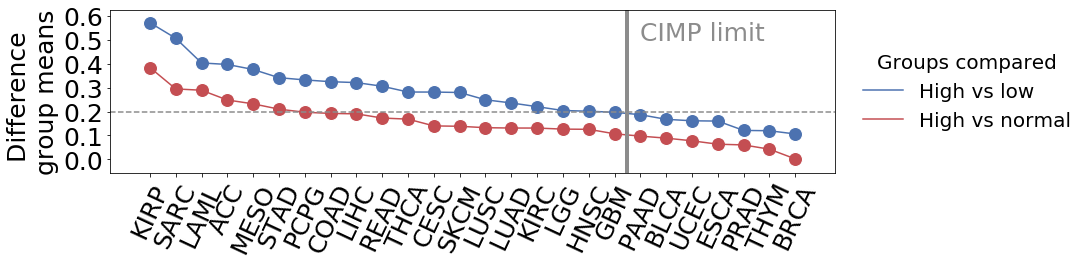

In [55]:
plt.rc("font", size=20)
seapal = sns.color_palette("deep")
fig = plt.figure(figsize=(13,3))
ax = plt.axes()
sns.lineplot(x=cancer_order,y=np.sort(diff_mean_cl)[::-1],ax=ax,color=seapal[0],label="High vs low")
sns.scatterplot(x=cancer_order,y=np.sort(diff_mean_cl)[::-1],ax=ax,s=200,color=seapal[0])

sns.lineplot(x=cancer_order,y=np.sort(diff_mean_normal)[::-1],ax=ax,color=seapal[3],label="High vs normal")
sns.scatterplot(x=cancer_order,y=np.sort(diff_mean_normal)[::-1],ax=ax,s=200,color=seapal[3])

ax.set_xticklabels(cancer_order,rotation=65,rotation_mode="default",fontsize=25)
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(np.round(ax.get_yticks(),2),rotation=0,rotation_mode="default",fontsize=25)
ax.set_ylabel("Difference \ngroup means",fontsize=25)

plt.axvline(x=18.5,color=seapal[7],linewidth=4)
plt.axhline(y=0.2,color=seapal[7],linestyle="--")

plt.legend(loc='right', bbox_to_anchor=(1.35,0.5), title="Groups compared",frameon=False,fontsize=20)

ax.text(19,0.5,"CIMP limit",fontsize=25,color=seapal[7])

fig.savefig("mean_comparison_panel.png",bbox_inches="tight")
fig.savefig("mean_comparison_panel.svg",bbox_inches="tight")

In [49]:
x_ticks = []
for cancer in cancer_order:
    cl1 = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==1].index
    cl2 = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==2].index
    cl3 = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==3].index
    label = cancer+" \n $n_{low}$="+str(len(cl1))
    if cancer in triple_cluster_cancers_aff:
        label += " \n $n_{inter}$="+str(len(cl2))+"\n $n_{high}$="+str(len(cl3))
    else:
        label += "\n $n_{high}$="+str(len(cl2))
    label += "\n $n_{ref}$="+str(normal_meth[cancer].shape[0])
    x_ticks.append(label)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CESC_Intermediate meth cluster v.s. CESC_High meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.233e+08
COAD_Intermediate meth cluster v.s. COAD_High meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=4.669e+07
LIHC_Intermediate meth cluster v.s. LIHC_High meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.933e+08
PCPG_Intermediate meth cluster v.s. PCPG_High meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=2.417e+07
READ_Intermediate meth cluster v.s. READ_High meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.568e-132 U_stat=2.405e+06
SKCM_Intermediate meth cluster v.s. SKCM_High

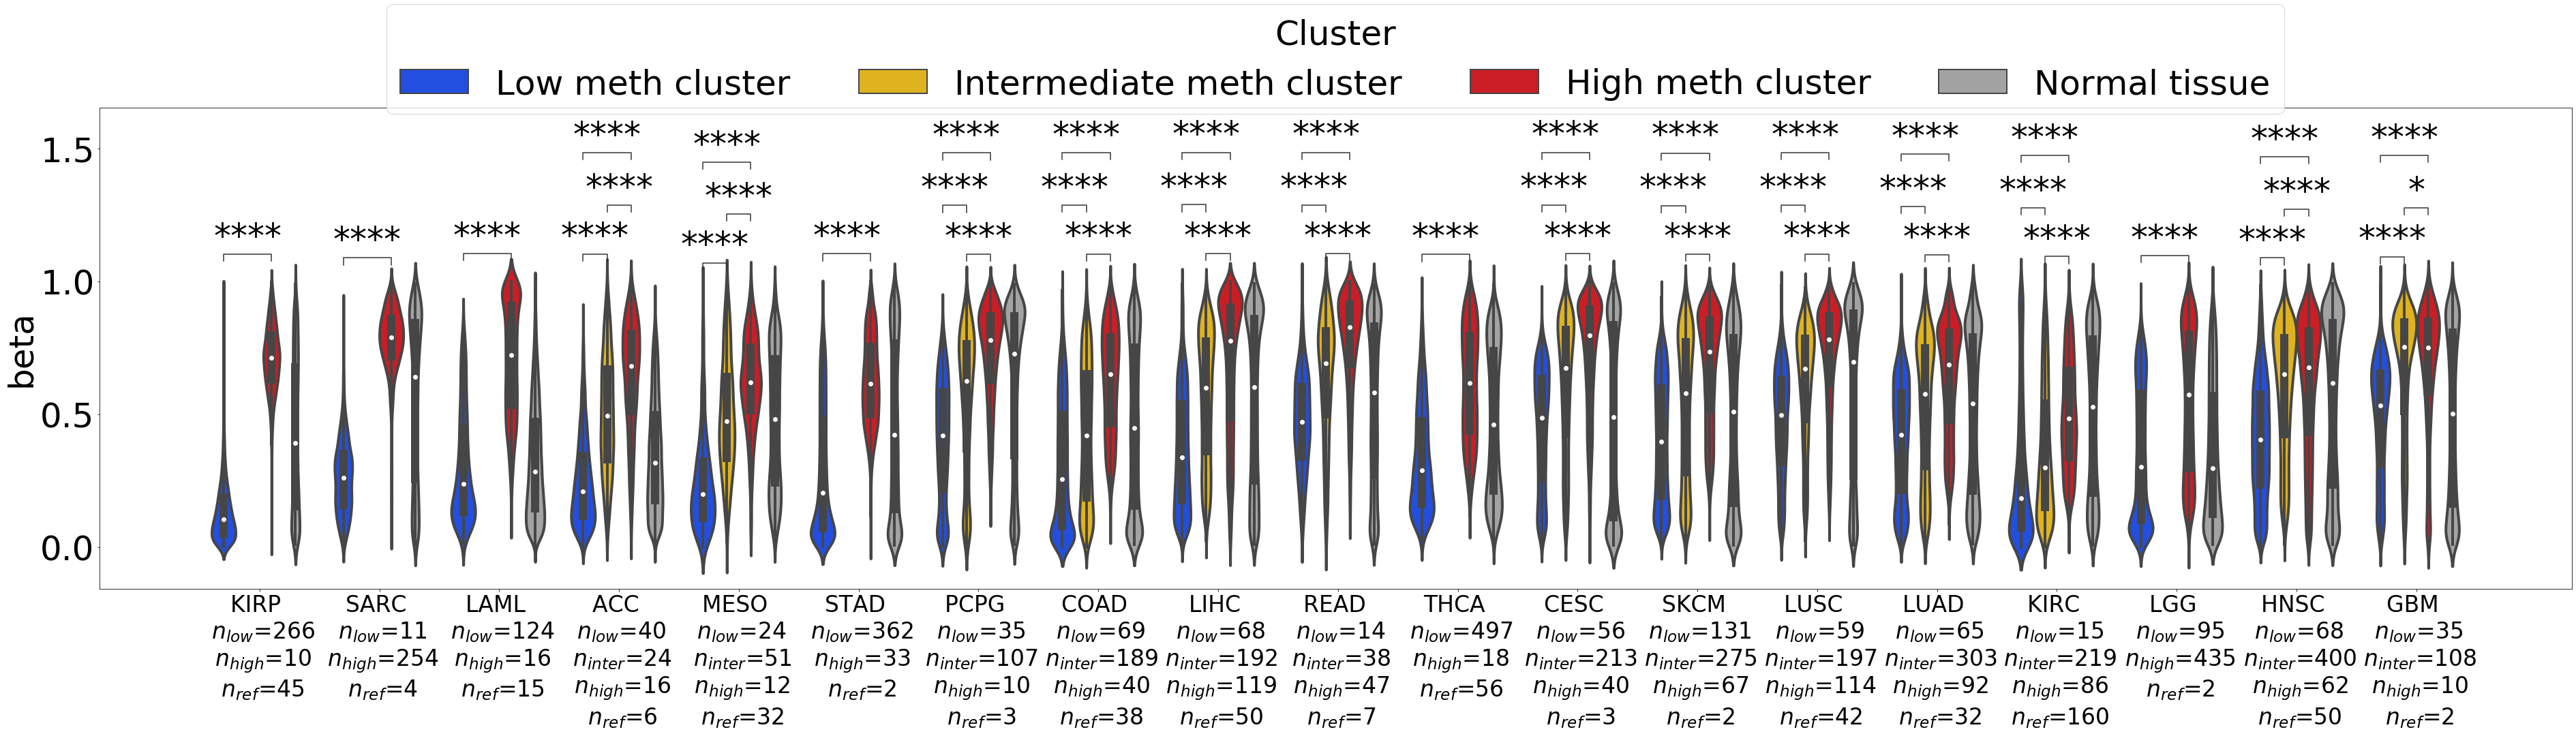

In [55]:
%matplotlib inline
plt.rc('font', size=50)
plt.figure(figsize=(65,13))
seapal = sns.color_palette("bright")
g = sns.violinplot(x="cancer",y="beta",hue="cluster",
                   hue_order=["Low meth cluster","Intermediate meth cluster","High meth cluster","Normal tissue"],
                   data=new_dist_meth_1, legend_out=False,
                   palette={"Low meth cluster": seapal[0],"High meth cluster": seapal[3],"Intermediate meth cluster": seapal[8],"Normal tissue": seapal[7]},
                  linewidth=4)


g.set_xticklabels(x_ticks[:19], fontsize=33)

add_stat_annotation(g, data=new_dist_meth_1, x="cancer", y="beta", hue="cluster", hue_order=["Low meth cluster","Intermediate meth cluster","High meth cluster","Normal tissue"],
                                box_pairs=[(("ACC", "Low meth cluster"), ("ACC","High meth cluster")),
                                           (("ACC", "Low meth cluster"), ("ACC","Intermediate meth cluster")),
                                           (("ACC", "Intermediate meth cluster"), ("ACC","High meth cluster")),
                                           (("CESC", "Low meth cluster"), ("CESC","High meth cluster")),
                                           (("CESC", "Low meth cluster"), ("CESC","Intermediate meth cluster")),
                                           (("CESC", "Intermediate meth cluster"), ("CESC","High meth cluster")),
                                   (("COAD", "Low meth cluster"), ("COAD","High meth cluster")),
                                           (("COAD", "Low meth cluster"), ("COAD","Intermediate meth cluster")),
                                           (("COAD", "Intermediate meth cluster"), ("COAD","High meth cluster")),
                                          
                                   (("KIRP", "Low meth cluster"), ("KIRP","High meth cluster")),
                                   (("LAML", "Low meth cluster"), ("LAML","High meth cluster")),
                                   (("LIHC", "Low meth cluster"), ("LIHC","High meth cluster")),
                                           (("LIHC", "Low meth cluster"), ("LIHC","Intermediate meth cluster")),
                                           (("LIHC", "Intermediate meth cluster"), ("LIHC","High meth cluster")),
                                  
                                           (("MESO", "Low meth cluster"), ("MESO","High meth cluster")),
                                           (("MESO", "Low meth cluster"), ("MESO","Intermediate meth cluster")),
                                           (("MESO", "Intermediate meth cluster"), ("MESO","High meth cluster")),
                                   (("PCPG", "Low meth cluster"), ("PCPG","High meth cluster")),
                                    (("PCPG", "Low meth cluster"), ("PCPG","Intermediate meth cluster")),
                                    (("PCPG", "Intermediate meth cluster"), ("PCPG","High meth cluster")),
                                    (("READ", "Low meth cluster"), ("READ","High meth cluster")),
                                           (("READ", "Low meth cluster"), ("READ","Intermediate meth cluster")),
                                           (("READ", "Intermediate meth cluster"), ("READ","High meth cluster")),   
                                   (("SARC", "Low meth cluster"), ("SARC","High meth cluster")),
                                            (("SKCM", "Low meth cluster"), ("SKCM","High meth cluster")),
                                   (("SKCM", "Low meth cluster"), ("SKCM","Intermediate meth cluster")),
                                   (("SKCM", "Intermediate meth cluster"), ("SKCM","High meth cluster")),  
                                    (("STAD", "Low meth cluster"), ("STAD","High meth cluster")),
                                          (("THCA", "Low meth cluster"), ("THCA","High meth cluster")),
                                          (("GBM", "Low meth cluster"), ("GBM","High meth cluster")),
                                           (("GBM", "Low meth cluster"), ("GBM","Intermediate meth cluster")),
                                           (("GBM", "Intermediate meth cluster"), ("GBM","High meth cluster")),
                                   (("HNSC", "Low meth cluster"), ("HNSC","High meth cluster")),
                                   (("HNSC", "Low meth cluster"), ("HNSC","Intermediate meth cluster")),
                                   (("HNSC", "Intermediate meth cluster"), ("HNSC","High meth cluster")),
                                            (("KIRC", "Low meth cluster"), ("KIRC","High meth cluster")),
                                           (("KIRC", "Low meth cluster"), ("KIRC","Intermediate meth cluster")),
                                           (("KIRC", "Intermediate meth cluster"), ("KIRC","High meth cluster")),
                                   (("LGG", "Low meth cluster"), ("LGG","High meth cluster")),
                                   (("LUAD", "Low meth cluster"), ("LUAD","High meth cluster")),
                                   (("LUAD", "Low meth cluster"), ("LUAD","Intermediate meth cluster")),
                                           (("LUAD", "Intermediate meth cluster"), ("LUAD","High meth cluster")),
                                            (("LUSC", "Low meth cluster"), ("LUSC","High meth cluster")),
                                   (("LUSC", "Low meth cluster"), ("LUSC","Intermediate meth cluster")),
                                           (("LUSC", "Intermediate meth cluster"), ("LUSC","High meth cluster")),],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)


plt.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title="Cluster",ncol=4)
plt.xlabel('')

plt.savefig("dist_methylation_part1.svg",bbox_inches='tight')
plt.savefig("dist_methylation_part1.png",bbox_inches='tight')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

BRCA_Intermediate meth cluster v.s. BRCA_High meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.886e+08
THYM_Intermediate meth cluster v.s. THYM_High meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.746e-295 U_stat=8.367e+07
ESCA_Low meth cluster v.s. ESCA_Intermediate meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.978e-249 U_stat=1.132e+08
UCEC_Low meth cluster v.s. UCEC_Intermediate meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.461e-60 U_stat=1.144e+08
PAAD_Low meth cluster v.s. PAAD_Intermediate meth cluster: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.507e-161 U_stat=4.198e+07
PAAD_Intermediate meth cluster v.s. PAAD_High 

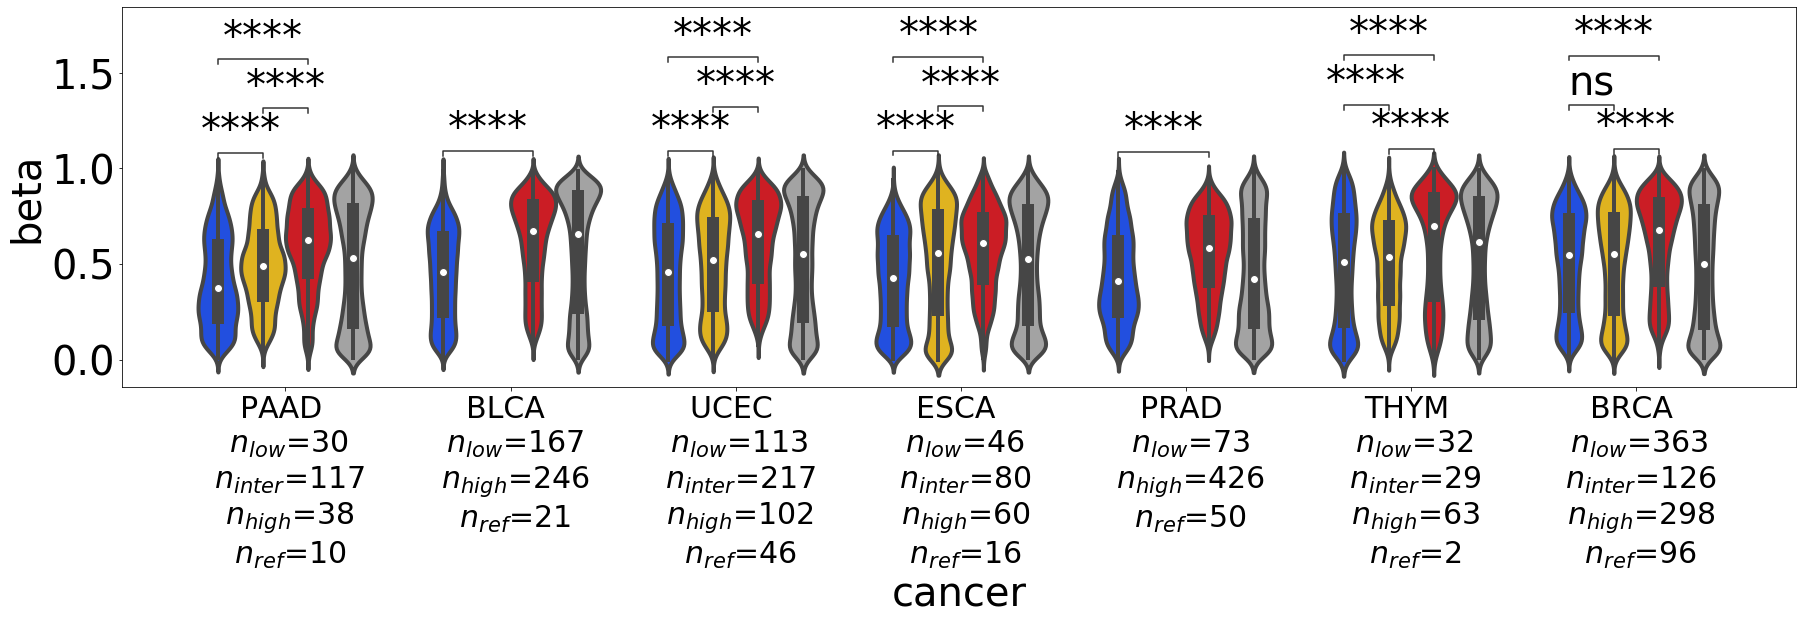

In [57]:
plt.rc('font', size=40)
plt.figure(figsize=(30,7))
seapal = sns.color_palette("bright")
g = sns.violinplot(x="cancer",y="beta",hue="cluster",
                   hue_order=["Low meth cluster","Intermediate meth cluster","High meth cluster","Normal tissue"],
                   data=new_dist_meth_2, legend_out=False,
                   palette={"Low meth cluster": seapal[0],"High meth cluster": seapal[3],"Intermediate meth cluster": seapal[8],"Normal tissue": seapal[7]},
                  linewidth=4)

g.set_xticklabels(x_ticks[19:], fontsize=30)

add_stat_annotation(g, data=new_dist_meth_2, x="cancer", y="beta", hue="cluster", hue_order=["Low meth cluster","Intermediate meth cluster","High meth cluster","Normal tissue"],
                                box_pairs=[(("BLCA", "Low meth cluster"), ("BLCA","High meth cluster")),
                                           (("BRCA", "Low meth cluster"), ("BRCA","Intermediate meth cluster")),
                                   (("BRCA", "Low meth cluster"), ("BRCA","High meth cluster")),
                                   (("BRCA", "Intermediate meth cluster"), ("BRCA","High meth cluster")),
                                    (("ESCA", "Low meth cluster"), ("ESCA","High meth cluster")),
                                           (("ESCA", "Low meth cluster"), ("ESCA","Intermediate meth cluster")),
                                           (("ESCA", "Intermediate meth cluster"), ("ESCA","High meth cluster")),
                                           (("PAAD", "Low meth cluster"), ("PAAD","High meth cluster")),
                                           (("PAAD", "Low meth cluster"), ("PAAD","Intermediate meth cluster")),
                                           (("PAAD", "Intermediate meth cluster"), ("PAAD","High meth cluster")),
                                   (("PRAD", "Low meth cluster"), ("PRAD","High meth cluster")),
                                           (("THYM", "Low meth cluster"), ("THYM","High meth cluster")),
                                           (("THYM", "Low meth cluster"), ("THYM","Intermediate meth cluster")),
                                           (("THYM", "Intermediate meth cluster"), ("THYM","High meth cluster")),
                                           (("UCEC", "Low meth cluster"), ("UCEC","High meth cluster")),
                                           (("UCEC", "Low meth cluster"), ("UCEC","Intermediate meth cluster")),
                                   (("UCEC", "Intermediate meth cluster"), ("UCEC","High meth cluster")),],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

g.get_legend().remove()
plt.savefig("dist_methylation_part2.svg",bbox_inches='tight')
plt.savefig("dist_methylation_part2.png",bbox_inches='tight')

### CIMP status characterization

In [89]:
# look for differences in group average beta value to characterize into CIMP and non-CIMP
cimp_cancer_wdiff = []
for cancer in cancer_order[:13]:
    distmethcancer = dist_meth_spectral_1[dist_meth_spectral_1["cancer"]==cancer]
    cl1_avg = distmethcancer[distmethcancer["cluster"]=="Low cluster"]["beta"].mean()
    cl2_avg = distmethcancer[distmethcancer["cluster"]=="High cluster"]["beta"].mean()
    print("Cancer {} diff between cluster avg : {} & high group value : {}".format(cancer,cl2_avg-cl1_avg,cl2_avg))
    if cl2_avg-cl1_avg>0.195:
        cimp_cancer_wdiff.append(cancer)
cimp_cancer_wdiff

Cancer KIRP diff between cluster avg : 0.571672582054757 & high group value : 0.7103734601012953
Cancer SARC diff between cluster avg : 0.5065597835066851 & high group value : 0.7713554326007444
Cancer MESO diff between cluster avg : 0.37587247603547896 & high group value : 0.6176358681303492
Cancer ACC diff between cluster avg : 0.39695018036596463 & high group value : 0.643209139322182
Cancer READ diff between cluster avg : 0.3057781682928052 & high group value : 0.77511388253252
Cancer LAML diff between cluster avg : 0.403269450527179 & high group value : 0.706134179806963
Cancer STAD diff between cluster avg : 0.34158881873138697 & high group value : 0.6253128230439
Cancer PCPG diff between cluster avg : 0.3322622237360764 & high group value : 0.7328357224864477
Cancer CESC diff between cluster avg : 0.28142884393157297 & high group value : 0.7281820169627773
Cancer LUSC diff between cluster avg : 0.24913078673410344 & high group value : 0.7196182297302186
Cancer LIHC diff between 

['KIRP',
 'SARC',
 'MESO',
 'ACC',
 'READ',
 'LAML',
 'STAD',
 'PCPG',
 'CESC',
 'LUSC',
 'LIHC',
 'COAD',
 'KIRC']

In [90]:
cimp_cancer_wdiff= []
for cancer in cancer_order[13:]:
    distmethcancer = dist_meth_spectral_2[dist_meth_spectral_2["cancer"]==cancer]
    cl1_avg = distmethcancer[distmethcancer["cluster"]=="Low cluster"]["beta"].mean()
    cl2_avg = distmethcancer[distmethcancer["cluster"]=="High cluster"]["beta"].mean()
    print("Cancer {} diff between cluster avg : {} & high group value : {}".format(cancer,cl2_avg-cl1_avg,cl2_avg))
    if cl2_avg-cl1_avg>0.195:
        cimp_cancer_wdiff.append(cancer)
cimp_cancer_wdiff

Cancer THCA diff between cluster avg : 0.28164144774998545 & high group value : 0.6129105398989391
Cancer GBM diff between cluster avg : 0.1967569502142844 & high group value : 0.6782396612881597
Cancer SKCM diff between cluster avg : 0.27967357691499317 & high group value : 0.6796788058032365
Cancer LUAD diff between cluster avg : 0.23585420854680328 & high group value : 0.6380041259735507
Cancer HNSC diff between cluster avg : 0.20135098177515798 & high group value : 0.6091175450878188
Cancer PAAD diff between cluster avg : 0.18678017232114652 & high group value : 0.5950921233373737
Cancer BLCA diff between cluster avg : 0.1674169537457313 & high group value : 0.615099415669136
Cancer THYM diff between cluster avg : 0.119632308295403 & high group value : 0.6010276616056246
Cancer LGG diff between cluster avg : 0.20426571634734897 & high group value : 0.5493602762356424
Cancer ESCA diff between cluster avg : 0.16004282878808945 & high group value : 0.5765449149826831
Cancer PRAD diff 

['THCA', 'GBM', 'SKCM', 'LUAD', 'HNSC', 'LGG']

In [65]:
up_probes_perc,down_probes_perc = [],[]
for cancer in tqdm(cancer_order):
    ind_cl_1 = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==1].index
    ind_cl_2 = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==2].index
    ind_cl_3 = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==3].index

    if cancer in triple_cluster_cancers_aff:
        ind_cl_2 = ind_cl_3
        
    methdf = new_meth_data_pc[cancer][sign_pos_spectral[cancer].values.ravel()]
    perc = (methdf.loc[ind_cl_2].mean()>methdf.loc[ind_cl_1].mean()).sum()/(methdf.shape[1])
    perc = np.round(perc*100,1)
    up_probes_perc.append(perc)
    down_probes_perc.append(100-perc)

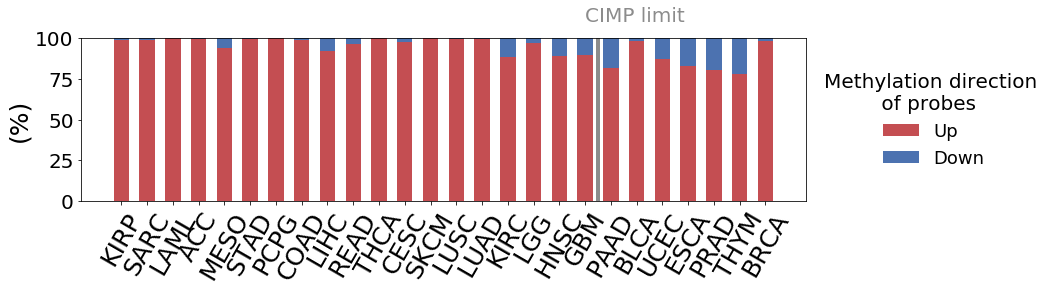

In [70]:
seapal = sns.color_palette("deep")
plt.rc("font",size=20)
width = 0.6 
fig, ax = plt.subplots(figsize=(13,3))

ax.bar(cancer_order, up_probes_perc, width, label='Up',color=seapal[3])
ax.bar(cancer_order, down_probes_perc, width, bottom=up_probes_perc,
       label='Down',color=seapal[0])

ax.set_xticklabels(cancer_order,rotation=60,rotation_mode="default",fontsize=25)
ax.set_ylabel("(%)",fontsize=25)

plt.legend(loc='right', bbox_to_anchor=(1.35,0.5), title="Methylation direction \n         of probes",frameon=False,fontsize=18)
ax.axvline(x=18.5, color=seapal[7],linewidth=4)
ax.text(18,110,"CIMP limit",color=seapal[7])

fig.savefig("probe_direction_panel.png",bbox_inches="tight")
fig.savefig("probe_direction_panel.svg",bbox_inches="tight")

In [44]:
CIMP_cancers = ['KIRP','SARC','MESO','ACC','READ','LAML','STAD','PCPG','CESC',
                'LUSC','LIHC','COAD','KIRC','THCA','GBM','SKCM','LUAD','HNSC','LGG']

# Predicting CIMP status with probes

In [43]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

In [605]:
# X_train_pc,y_train_pc,X_test_pc,y_test_pc = {},{},{},{}
# for cancer in tqdm(sorted(CIMP_cancers)):
#     X = new_meth_data_pc[cancer][sign_pos_spectral[cancer].values.ravel()]
#     if cancer in triple_cluster_cancers_aff:
#         y = consensus_clustering_spectral[cancer].replace({3: 1, 2: 0, 1: 0}).values.ravel()
#     else:
#         y = consensus_clustering_spectral[cancer].replace({2: 1, 1: 0}).values.ravel()
        
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    
#     X_train_pc[cancer]=X_train
#     y_train_pc[cancer]=y_train
#     X_test_pc[cancer]=X_test
#     y_test_pc[cancer]=y_test

In [37]:
bac_pred_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\bac_pred"
# for cancer in X_train_pc:
#     pd.DataFrame(X_train_pc[cancer].index).to_csv(os.path.join(bac_pred_dir,cancer+"_train_pat.csv"),index=False)
#     pd.DataFrame(X_test_pc[cancer].index).to_csv(os.path.join(bac_pred_dir,cancer+"_test_pat.csv"),index=False)
X_train_pc,y_train_pc,X_test_pc,y_test_pc = {},{},{},{}
for cancer in tqdm(sorted(CIMP_cancers)):
    pat_train = pd.read_csv(os.path.join(bac_pred_dir,cancer+"_train_pat.csv")).values.ravel()
    pat_test = pd.read_csv(os.path.join(bac_pred_dir,cancer+"_test_pat.csv")).values.ravel()
    
    X_train_pc[cancer]=new_meth_data_pc[cancer][sign_pos_spectral[cancer].values.ravel()].loc[pat_train]
    X_test_pc[cancer]=new_meth_data_pc[cancer][sign_pos_spectral[cancer].values.ravel()].loc[pat_test]
    if cancer in triple_cluster_cancers_aff:
        y = consensus_clustering_spectral[cancer].replace({3: 1, 2: 0, 1: 0})
    else:
        y = consensus_clustering_spectral[cancer].replace({2: 1, 1: 0})
    y_train_pc[cancer]= y.loc[pat_train].values.ravel()
    y_test_pc[cancer]= y.loc[pat_test].values.ravel()

In [196]:
bac_list_pc_quint = {}
for cancer in cancer_to_opt:
    bac_list_pc_quint[cancer] = pd.read_csv(os.path.join(bac_pred_dir,cancer+"bac_quint.csv")).set_index("Unnamed: 0").values.ravel()

In [563]:
def get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,name):
    bac_pred_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\bac_pred"
    bac_list_pc = {}
    n_cv = 5
    for cancer in tqdm(cancer_to_opt):

        bac_list = []
        for i in tqdm(range(len(X_train_pc[cancer].columns))):
            if i in list_features[cancer]:
                bac_list.append(0)
                continue
            X = X_train_pc[cancer].iloc[:,list_features[cancer]+[i]].values
            y = y_train_pc[cancer]
            kf = StratifiedKFold(n_splits=n_cv)
            bac = 0
            for train_index, test_index in kf.split(X,y):
                lr = LogisticRegression(class_weight="balanced")
                lr.fit(X[train_index],y[train_index])
                ypred = lr.predict(X[test_index])
                bac+=balanced_accuracy_score(y[test_index],ypred,adjusted=True)/n_cv
            bac_list.append(bac)
        bac_list_pc[cancer] = np.array(bac_list)
        print(cancer,bac_list_pc[cancer][np.argmax(bac_list_pc[cancer])])
        pd.DataFrame(bac_list_pc[cancer].reshape(-1,1),index=sign_pos_spectral[cancer].values.ravel()).to_csv(os.path.join(bac_pred_dir,cancer+"bac_"+name+".csv"))
    return bac_list_pc

In [61]:
cancer_to_opt = sorted(CIMP_cancers)
list_features = {cancer: [] for cancer in cancer_to_opt}

bac_list_pc_single = get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,"single")


ACC 0.9287878787878787



CESC 0.942091836734694



COAD 0.9238800052861108



GBM 1.0



HNSC 0.9390450725744843



KIRC 0.7689977851605758



KIRP 1.0



LAML 0.991304347826087



LGG 0.9703839471523759



LIHC 0.9023006595624543



LUAD 0.758940258600048



LUSC 0.7041614906832299



MESO 0.9252747252747253



PCPG 1.0



READ 0.7494444444444445



SARC 0.9913043478260868



SKCM 0.8159817351598173



STAD 1.0



THCA 0.9620474406991262



In [609]:
best_index_single,best_scores_single,best_probes_single = {},{},{}
for cancer in bac_list_pc_single:
    ind_best = np.argmax(bac_list_pc_single[cancer])
    best_index_single[cancer] = ind_best
    best_scores_single[cancer] = bac_list_pc_single[cancer][ind_best]
    best_probes_single[cancer] = sign_pos_spectral[cancer].values.ravel()[ind_best]
    print(cancer,best_scores_single[cancer],best_probes_single[cancer])

ACC 0.9333333333333333 cg12074493
CESC 0.942091836734694 cg04084892
COAD 0.9238800052861108 cg12678562
GBM 1.0 cg00233079
HNSC 0.9390450725744843 cg07836815
KIRC 0.7689977851605758 cg24496475
KIRP 1.0 cg00081574
LAML 0.991304347826087 cg25660961
LGG 0.9703839471523759 cg14200725
LIHC 0.9023006595624543 cg13397345
LUAD 0.758940258600048 cg26153410
LUSC 0.7041614906832299 cg14131273
MESO 0.9252747252747253 cg21375294
PCPG 1.0 cg01685883
READ 0.7494444444444445 cg14635303
SARC 0.9913043478260868 cg10496150
SKCM 0.8159817351598173 cg11854259
STAD 1.0 cg17435266
THCA 0.9620474406991262 cg17590003


In [610]:
for cancer in sorted(CIMP_cancers):
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(X_train_pc[cancer][[best_probes_single[cancer]]],y_train_pc[cancer])
    ypred = lr.predict(X_test_pc[cancer][[best_probes_single[cancer]]])
    print(cancer,best_scores_single[cancer],balanced_accuracy_score(y_test_pc[cancer],ypred,adjusted=True))

ACC 0.9333333333333333 0.5
CESC 0.942091836734694 0.9629629629629628
COAD 0.9238800052861108 0.9230769230769231
GBM 1.0 0.0
HNSC 0.9390450725744843 0.8120567375886525
KIRC 0.7689977851605758 0.8454106280193237
KIRP 1.0 1.0
LAML 0.991304347826087 1.0
LGG 0.9703839471523759 0.9534883720930232
LIHC 0.9023006595624543 0.9230769230769231
LUAD 0.758940258600048 0.7567567567567568
LUSC 0.7041614906832299 0.4440559440559442
MESO 0.9252747252747253 1.0
PCPG 1.0 1.0
READ 0.7494444444444445 0.8
SARC 0.9913043478260868 1.0
SKCM 0.8159817351598173 0.7108013937282229
STAD 1.0 0.6666666666666665
THCA 0.9620474406991262 0.9199999999999999


In [64]:
cancer_to_opt = sorted(CIMP_cancers)
list_features = {cancer: [best_index_single[cancer]] for cancer in cancer_to_opt}

bac_list_pc_double = get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,"double")


ACC 1.0



CESC 0.9710884353741496



COAD 0.9369234835469803



GBM 1.0



HNSC 0.9652075375604787



KIRC 0.8584191583610188



KIRP 1.0



LAML 1.0



LGG 0.9949042518662772



LIHC 0.9304391877009822



LUAD 0.8520984648947776



LUSC 0.7992546583850931



MESO 0.9857142857142858



PCPG 1.0



READ 0.8433333333333334



SARC 1.0



SKCM 0.8904109589041095



STAD 1.0



THCA 0.9888389513108614



In [612]:
best_index_double,best_scores_double,best_probes_double = {},{},{}
for cancer in bac_list_pc_double:
    ind_best = np.argmax(bac_list_pc_double[cancer])
    best_index_double[cancer] = ind_best
    best_scores_double[cancer] = bac_list_pc_double[cancer][ind_best]
    best_probes_double[cancer] = sign_pos_spectral[cancer].values.ravel()[ind_best]
    print(cancer,best_scores_double[cancer],best_probes_single[cancer],best_probes_double[cancer])

ACC 0.9333333333333333 cg12074493 cg00003091
CESC 0.9710884353741496 cg04084892 cg07806886
COAD 0.9369234835469803 cg12678562 cg00418880
GBM 1.0 cg00233079 cg00004072
HNSC 0.9652075375604787 cg07836815 cg08608193
KIRC 0.8584191583610188 cg24496475 cg20250126
KIRP 1.0 cg00081574 cg00002033
LAML 1.0 cg25660961 cg00414384
LGG 0.9949042518662772 cg14200725 cg00400733
LIHC 0.9304391877009822 cg13397345 cg02876326
LUAD 0.8520984648947776 cg26153410 cg04097639
LUSC 0.7992546583850931 cg14131273 cg17743732
MESO 0.9857142857142858 cg21375294 cg04685253
PCPG 1.0 cg01685883 cg00002449
READ 0.8433333333333334 cg14635303 cg19325093
SARC 1.0 cg10496150 cg04618903
SKCM 0.8904109589041095 cg11854259 cg12723809
STAD 1.0 cg17435266 cg00000289
THCA 0.9888389513108614 cg17590003 cg02267270


In [613]:
for cancer in sorted(CIMP_cancers):
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(X_train_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer]]],y_train_pc[cancer])
    ypred = lr.predict(X_test_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer]]])
    print(cancer,best_scores_double[cancer],balanced_accuracy_score(y_test_pc[cancer],ypred,adjusted=True))

ACC 0.9333333333333333 0.5
CESC 0.9710884353741496 0.9629629629629628
COAD 0.9369234835469803 0.9230769230769231
GBM 1.0 1.0
HNSC 0.9652075375604787 0.8333333333333335
KIRC 0.8584191583610188 0.8888888888888888
KIRP 1.0 1.0
LAML 1.0 1.0
LGG 0.9949042518662772 0.9534883720930232
LIHC 0.9304391877009822 0.9615384615384617
LUAD 0.8520984648947776 0.7537537537537538
LUSC 0.7992546583850931 0.5979020979020979
MESO 0.9857142857142858 0.875
PCPG 1.0 1.0
READ 0.8433333333333334 0.8
SARC 1.0 1.0
SKCM 0.8904109589041095 0.7839721254355401
STAD 1.0 0.6666666666666665
THCA 0.9888389513108614 0.94


In [88]:
cancer_to_opt = ["ACC","CESC","COAD","HNSC","KIRC","LGG","LIHC","LUAD","LUSC","MESO","READ","SKCM","STAD","THCA"]
list_features = {cancer: [best_index_single[cancer],best_index_double[cancer]] for cancer in cancer_to_opt}

bac_list_pc_triple = get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,"triple")


COAD 0.9498744548698295



HNSC 0.983389355742297



KIRC 0.9002131782945735



LGG 0.9974358974358974



LIHC 0.9518082903836835



LUAD 0.8979088514646022



LUSC 0.8340372670807453



MESO 1.0



READ 0.8905555555555557



SKCM 0.926027397260274



STAD 1.0



THCA 0.9955555555555555



In [616]:
best_index_triple,best_scores_triple,best_probes_triple = {},{},{}
for cancer in sorted(bac_list_pc_triple):
    ind_best = np.argmax(bac_list_pc_triple[cancer])
    best_index_triple[cancer] = ind_best
    best_scores_triple[cancer] = bac_list_pc_triple[cancer][ind_best]
    best_probes_triple[cancer] = sign_pos_spectral[cancer].values.ravel()[ind_best]
    print(cancer,best_scores_triple[cancer],best_probes_single[cancer],best_probes_double[cancer],best_probes_triple[cancer])

ACC 0.9333333333333333 cg12074493 cg00003091 cg00006081
CESC 0.9794217687074829 cg04084892 cg07806886 cg00002449
COAD 0.9498744548698296 cg12678562 cg00418880 cg05129610
HNSC 0.983389355742297 cg07836815 cg08608193 cg00613649
KIRC 0.9002131782945735 cg24496475 cg20250126 cg09423283
LGG 0.9974358974358974 cg14200725 cg00400733 cg02383785
LIHC 0.9518082903836836 cg13397345 cg02876326 cg05350802
LUAD 0.8979088514646022 cg26153410 cg04097639 cg02739346
LUSC 0.8340372670807453 cg14131273 cg17743732 cg09659227
MESO 1.0 cg21375294 cg04685253 cg00181125
READ 0.8905555555555557 cg14635303 cg19325093 cg17375901
SKCM 0.9260273972602739 cg11854259 cg12723809 cg01064749
STAD 1.0 cg17435266 cg00000289 cg00002464
THCA 0.9955555555555556 cg17590003 cg02267270 cg02984184


In [617]:
for cancer in sorted(bac_list_pc_triple):
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(X_train_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                               best_probes_triple[cancer]]],y_train_pc[cancer])
    ypred = lr.predict(X_test_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                                          best_probes_triple[cancer]]])
    print(cancer,best_scores_triple[cancer],balanced_accuracy_score(y_test_pc[cancer],ypred,adjusted=True))

ACC 0.9333333333333333 0.5
CESC 0.9794217687074829 0.9629629629629628
COAD 0.9498744548698296 0.9615384615384617
HNSC 0.983389355742297 0.8333333333333335
KIRC 0.9002131782945735 0.8019323671497585
LGG 0.9974358974358974 0.9302325581395348
LIHC 0.9518082903836836 0.9615384615384617
LUAD 0.8979088514646022 0.6426426426426426
LUSC 0.8340372670807453 0.7272727272727273
MESO 1.0 1.0
READ 0.8905555555555557 1.0
SKCM 0.9260273972602739 0.4982578397212545
STAD 1.0 1.0
THCA 0.9955555555555556 0.98


In [618]:
cancer_to_opt = ["ACC"]
list_features = {cancer: [best_index_single[cancer],best_index_double[cancer],best_index_triple[cancer]] for cancer in cancer_to_opt}

bac_list_pc_add = get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,"quad")
bac_list_pc_quad["ACC"]=bac_list_pc_add["ACC"]


ACC 0.9333333333333333



In [115]:
cancer_to_opt = ["ACC","CESC","COAD","HNSC","KIRC","LGG","LIHC","LUAD","LUSC","READ","SKCM","STAD","THCA"]
list_features = {cancer: [best_index_single[cancer],best_index_double[cancer],best_index_triple[cancer]] for cancer in cancer_to_opt}

bac_list_pc_quad = get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,"quad")


ACC 1.0



CESC 0.9794217687074829



In [619]:
best_index_quad,best_scores_quad,best_probes_quad = {},{},{}
for cancer in sorted(bac_list_pc_quad):
    ind_best = np.argmax(bac_list_pc_quad[cancer])
    best_index_quad[cancer] = ind_best
    best_scores_quad[cancer] = bac_list_pc_quad[cancer][ind_best]
    best_probes_quad[cancer] = sign_pos_spectral[cancer].values.ravel()[ind_best]
    print(cancer,best_scores_quad[cancer],best_probes_single[cancer],best_probes_double[cancer],best_probes_triple[cancer],best_probes_quad[cancer])

ACC 0.9333333333333333 cg12074493 cg00003091 cg00006081 cg00011203
CESC 0.9794217687074829 cg04084892 cg07806886 cg00002449 cg00002449
COAD 0.9498744548698296 cg12678562 cg00418880 cg05129610 cg05129610
HNSC 0.983389355742297 cg07836815 cg08608193 cg00613649 cg00613649
KIRC 0.9002131782945735 cg24496475 cg20250126 cg09423283 cg09423283
LGG 0.9974358974358974 cg14200725 cg00400733 cg02383785 cg02383785
LIHC 0.9518082903836836 cg13397345 cg02876326 cg05350802 cg05350802
LUAD 0.8979088514646022 cg26153410 cg04097639 cg02739346 cg02739346
LUSC 0.8340372670807453 cg14131273 cg17743732 cg09659227 cg09659227
MESO 1.0 cg21375294 cg04685253 cg00181125 cg00181125
READ 0.8905555555555557 cg14635303 cg19325093 cg17375901 cg17375901
SKCM 0.9260273972602739 cg11854259 cg12723809 cg01064749 cg01064749
STAD 1.0 cg17435266 cg00000289 cg00002464 cg00002464
THCA 0.9955555555555556 cg17590003 cg02267270 cg02984184 cg02984184


In [620]:
for cancer in sorted(bac_list_pc_quad):
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(X_train_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                               best_probes_triple[cancer],best_probes_quad[cancer]]],y_train_pc[cancer])
    ypred = lr.predict(X_test_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                                          best_probes_triple[cancer],best_probes_quad[cancer]]])
    print(cancer,best_scores_quad[cancer],balanced_accuracy_score(y_test_pc[cancer],ypred,adjusted=True))

ACC 0.9333333333333333 0.5
CESC 0.9794217687074829 0.9629629629629628
COAD 0.9498744548698296 0.9615384615384617
HNSC 0.983389355742297 0.8333333333333335
KIRC 0.9002131782945735 0.8019323671497585
LGG 0.9974358974358974 0.9302325581395348
LIHC 0.9518082903836836 0.9230769230769231
LUAD 0.8979088514646022 0.6156156156156156
LUSC 0.8340372670807453 0.6363636363636362
MESO 1.0 1.0
READ 0.8905555555555557 1.0
SKCM 0.9260273972602739 0.4982578397212545
STAD 1.0 1.0
THCA 0.9955555555555556 0.98


In [430]:
cancer_to_opt = ["CESC","COAD","HNSC","KIRC","LGG","LIHC","LUAD","LUSC","READ","SKCM","THCA"]
list_features = {cancer: [best_index_single[cancer],best_index_double[cancer],
                          best_index_triple[cancer],best_index_quad[cancer]] for cancer in cancer_to_opt}

bac_list_pc_quint = get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,"quint")


CESC 0.9794217687074829



COAD 0.9628254261926787



HNSC 0.9881512605042018



KIRC 0.9354595791805094



LGG 1.0



LIHC 0.9785383903792784



LUAD 0.9368558278128077



LUSC 0.900910973084886



READ 0.9777777777777779



SKCM 0.9643835616438355



THCA 1.0



In [590]:
best_index_quint,best_scores_quint,best_probes_quint = {},{},{}
for cancer in sorted(bac_list_pc_quint):
    ind_best = np.argmax(bac_list_pc_quint[cancer])
    best_index_quint[cancer] = ind_best
    best_scores_quint[cancer] = bac_list_pc_quint[cancer][ind_best]
    best_probes_quint[cancer] = sign_pos_spectral[cancer].values.ravel()[ind_best]
    print(cancer,best_scores_quint[cancer],best_probes_single[cancer],
          best_probes_double[cancer],best_probes_triple[cancer],best_probes_quad[cancer],best_probes_quint[cancer])

ACC 1.0 cg26984928 cg26307117 cg00003091 cg00006081 cg00006081
CESC 0.9794217687074829 cg04084892 cg07806886 cg01070095 cg00002449 cg00002449
COAD 0.9628254261926787 cg12678562 cg00418880 cg05129610 cg05129610 cg00167654
HNSC 0.9881512605042018 cg07836815 cg08608193 cg00613649 cg00613649 cg00743094
KIRC 0.9354595791805094 cg24496475 cg20250126 cg09423283 cg09423283 cg02440976
LGG 1.0 cg14200725 cg00400733 cg02383785 cg02383785 cg00002033
LIHC 0.9785383903792784 cg13397345 cg02876326 cg05350802 cg05350802 cg13601275
LUAD 0.9368558278128077 cg26153410 cg04097639 cg02739346 cg02739346 cg15703365
LUSC 0.900910973084886 cg14131273 cg17743732 cg09659227 cg09659227 cg23672278
READ 0.9777777777777779 cg14635303 cg19325093 cg17375901 cg17375901 cg01420492
SKCM 0.9643835616438355 cg11854259 cg12723809 cg01064749 cg01064749 cg00886554
THCA 1.0 cg17590003 cg02267270 cg02984184 cg02984184 cg23047920


In [591]:
for cancer in sorted(bac_list_pc_quint):
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(X_train_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                               best_probes_triple[cancer],best_probes_quad[cancer],
                               best_probes_quint[cancer]]],y_train_pc[cancer])
    ypred = lr.predict(X_test_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                               best_probes_triple[cancer],best_probes_quad[cancer],
                               best_probes_quint[cancer]]])
    print(cancer,best_scores_quint[cancer],balanced_accuracy_score(y_test_pc[cancer],ypred,adjusted=True))

ACC 1.0 0.5
CESC 0.9794217687074829 0.9629629629629628
COAD 0.9628254261926787 0.9230769230769231
HNSC 0.9881512605042018 0.8333333333333335
KIRC 0.9354595791805094 0.8019323671497585
LGG 1.0 0.9302325581395348
LIHC 0.9785383903792784 0.9230769230769231
LUAD 0.9368558278128077 0.6156156156156156
LUSC 0.900910973084886 0.7272727272727273
READ 0.9777777777777779 1.0
SKCM 0.9643835616438355 0.5470383275261324
THCA 1.0 1.0


In [553]:
cancer_to_opt = ["CESC","COAD","HNSC","KIRC","LIHC","LUAD","LUSC","READ","SKCM"]
list_features = {cancer: [best_index_single[cancer],best_index_double[cancer],
                          best_index_triple[cancer],best_index_quad[cancer],best_index_quint[cancer],] for cancer in cancer_to_opt}

bac_list_pc_sext = get_bac_list(cancer_to_opt,triple_cluster_cancers_aff,
                 X_train_pc,y_train_pc,sign_pos_spectral,list_features,"sext")


CESC 0.9794217687074829



COAD 0.9670807453416148



HNSC 0.9929131652661065



KIRC 0.9448726467331119



LIHC 0.9870490286771508



LUAD 0.9429164338734138



LUSC 0.9096066252587993



READ 0.9777777777777779



SKCM 0.9726027397260273



In [594]:
best_index_sext,best_scores_sext,best_probes_sext = {},{},{}
for cancer in sorted(bac_list_pc_sext):
    ind_best = np.argmax(bac_list_pc_sext[cancer])
    best_index_sext[cancer] = ind_best
    best_scores_sext[cancer] = bac_list_pc_sext[cancer][ind_best]
    best_probes_sext[cancer] = sign_pos_spectral[cancer].values.ravel()[ind_best]
    print(cancer,best_scores_sext[cancer],best_probes_single[cancer],
          best_probes_double[cancer],best_probes_triple[cancer],
          best_probes_quad[cancer],best_probes_quint[cancer],best_probes_sext[cancer])

ACC 1.0 cg26984928 cg26307117 cg00003091 cg00006081 cg00006081 cg00011203
CESC 0.9794217687074829 cg04084892 cg07806886 cg01070095 cg00002449 cg00002449 cg00034559
COAD 0.9670807453416148 cg12678562 cg00418880 cg05129610 cg05129610 cg00167654 cg00613649
HNSC 0.9929131652661065 cg07836815 cg08608193 cg00613649 cg00613649 cg00743094 cg02286968
KIRC 0.9448726467331119 cg24496475 cg20250126 cg09423283 cg09423283 cg02440976 cg04228935
LIHC 0.9870490286771508 cg13397345 cg02876326 cg05350802 cg05350802 cg13601275 cg17993657
LUAD 0.9429164338734138 cg26153410 cg04097639 cg02739346 cg02739346 cg15703365 cg03140557
LUSC 0.9096066252587993 cg14131273 cg17743732 cg09659227 cg09659227 cg23672278 cg00110039
READ 0.9777777777777779 cg14635303 cg19325093 cg17375901 cg17375901 cg01420492 cg00032205
SKCM 0.9726027397260273 cg11854259 cg12723809 cg01064749 cg01064749 cg00886554 cg05945782


In [595]:
for cancer in sorted(bac_list_pc_sext):
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(X_train_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                               best_probes_triple[cancer],best_probes_quad[cancer],
                               best_probes_quint[cancer],best_probes_sext[cancer]]],y_train_pc[cancer])
    ypred = lr.predict(X_test_pc[cancer][[best_probes_single[cancer],best_probes_double[cancer],
                               best_probes_triple[cancer],best_probes_quad[cancer],
                               best_probes_quint[cancer],best_probes_sext[cancer]]])
    print(cancer,best_scores_sext[cancer],balanced_accuracy_score(y_test_pc[cancer],ypred,adjusted=True))

ACC 1.0 0.5
CESC 0.9794217687074829 0.9629629629629628
COAD 0.9670807453416148 0.9230769230769231
HNSC 0.9929131652661065 0.8333333333333335
KIRC 0.9448726467331119 0.8019323671497585
LIHC 0.9870490286771508 0.9230769230769231
LUAD 0.9429164338734138 0.6426426426426426
LUSC 0.9096066252587993 0.7272727272727273
READ 0.9777777777777779 1.0
SKCM 0.9726027397260273 0.6655052264808363


In [600]:
bac_list = []
for cancer in tqdm(sorted(CIMP_cancers)):
    if cancer in triple_cluster_cancers_aff:
        y = consensus_clustering_spectral[cancer].replace({3: 1, 2: 0, 1: 0}).values.ravel()
    else:
        y = consensus_clustering_spectral[cancer].replace({2: 1, 1: 0}).values.ravel()
    X = new_meth_data_pc[cancer][sign_pos_spectral[cancer].values.ravel()].values

    kf = StratifiedKFold(n_splits=5)
    bac = 0
    for train_index, test_index in kf.split(X,y):
        lr = LogisticRegressionCV(cv=5,Cs=[5,10],class_weight="balanced",penalty="l1",solver="liblinear")
        lr.fit(X[train_index,:],y[train_index])
        ypred = lr.predict(X[test_index,:])
        bac+=balanced_accuracy_score(y[test_index],ypred,adjusted=True)/5
    bac_list.append(bac)

In [602]:
for i in range(len(CIMP_cancers)):
    print(sorted(CIMP_cancers)[i],bac_list[i])

ACC 0.7346153846153847
CESC 0.8888888888888888
COAD 0.865158371040724
GBM 1.0
HNSC 0.9739313306231633
KIRC 0.8479627311917675
KIRP 1.0
LAML 0.9253333333333333
LGG 0.9720508166969146
LIHC 0.9380156075808249
LUAD 0.7705647247824609
LUSC 0.7673826599657803
MESO 0.8333333333333334
PCPG 1.0
READ 0.7983838383838384
SARC 0.8999999999999999
SKCM 0.8390750171237975
STAD 0.9666666666666666
THCA 0.9419393939393941


In [621]:
final_models_abac = [0.933,0.979,0.967,1,0.993,0.935,1,1,1,0.987,0.943,0.91,1,1,0.978,1,0.964,1,1]
np.mean(final_models_abac),np.quantile(final_models_abac,0.25),np.quantile(final_models_abac,0.75)

(0.9783684210526316, 0.9655, 1.0)

In [622]:
final_models_abac_test = [0.5,0.963,0.962,1,0.833,0.802,1,1,0.953,1,0.67,0.909,1,1,1,1,0.714,1,0.96]
np.mean(final_models_abac_test),np.quantile(final_models_abac_test,0.25),np.quantile(final_models_abac_test,0.75)

(0.9087368421052633, 0.871, 1.0)

In [40]:
final_selected_probes = {"ACC": ["cg12074493"],
                        "CESC": ["cg04084892", "cg07806886", "cg00002449"],
                        "COAD": ["cg12678562", "cg00418880", "cg05129610", "cg03780561", "cg00167654", "cg00613649"],
                        "GBM": ["cg00233079", "cg00004072"], 
                        "HNSC": ["cg07836815", "cg08608193", "cg00613649", "cg01227537", "cg00743094", "cg02286968"],
                        "KIRC": ["cg24496475", "cg20250126", "cg09423283", "cg05542338", "cg02440976"],
                        "KIRP": ["cg00081574"],
                        "LAML": ["cg25660961", "cg00414384"], 
                        "LGG": ["cg14200725", "cg00400733", "cg02383785", "cg10558616"],
                        "LIHC": ["cg13397345", "cg02876326", "cg05350802", "cg20537760", "cg13601275", "cg17993657"],
                        "LUAD": ["cg26153410", "cg04097639", "cg02739346", "cg19697537", "cg15703365", "cg03140557"],
                        "LUSC": ["cg14131273", "cg17743732", "cg09659227", "cg07872854", "cg23672278", "cg00110039"],
                        "MESO": ["cg21375294", "cg04685253", "cg00181125"], 
                        "PCPG": ["cg01685883"],
                        "READ": ["cg14635303", "cg19325093", "cg17375901", "cg15930085", "cg01420492", "cg00032205"],
                        "SARC": ["cg10496150", "cg04618903"],
                        "SKCM": ["cg11854259", "cg12723809", "cg01064749", "cg06161600", "cg00886554"],
                        "STAD": ["cg17435266", "cg00000289", "cg00002033", "cg00002464"],
                        "THCA": ["cg17590003", "cg02267270", "cg02984184", "cg00454305", "cg23047920"]}

In [46]:
acc_l = []
for cancer in sorted(CIMP_cancers):
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(X_train_pc[cancer][final_selected_probes[cancer]],y_train_pc[cancer])
    ypred = lr.predict(X_test_pc[cancer][final_selected_probes[cancer]])
    acc_l.append(accuracy_score(y_test_pc[cancer],ypred))
    print(cancer,accuracy_score(y_test_pc[cancer],ypred))

ACC 0.875
CESC 0.967741935483871
COAD 0.9666666666666667
GBM 1.0
HNSC 0.9811320754716981
KIRC 0.90625
KIRP 1.0
LAML 1.0
LGG 0.9622641509433962
LIHC 1.0
LUAD 0.8695652173913043
LUSC 0.972972972972973
MESO 1.0
PCPG 1.0
READ 1.0
SARC 1.0
SKCM 0.9583333333333334
STAD 1.0
THCA 0.9615384615384616


In [47]:
np.mean(acc_l),np.quantile(acc_l,0.25),np.quantile(acc_l,0.75)

(0.9695507796737738, 0.961901306240929, 1.0)

# Survival

In [48]:
# clean the clinical data
for cancer in new_clin_data_pc:
    new_clin_data_pc[cancer]["OS.time"] = new_clin_data_pc[cancer]["OS.time"].replace("[Discrepancy]", "NaN")
    new_clin_data_pc[cancer]["OS.time"] = new_clin_data_pc[cancer]["OS.time"].astype(float)
    new_clin_data_pc[cancer]["OS"] = new_clin_data_pc[cancer]["OS"].replace("[Discrepancy]", "NaN")
    new_clin_data_pc[cancer]["OS"] = new_clin_data_pc[cancer]["OS"].astype(float)

In [49]:
# unify the stage indications in clinical data
mapping_stage = {"Stage I": ["Stage I", "Stage 0", "I/II NOS", "Stage IA", "Stage IA1", "Stage IA2", "Stage IB", "Stage IB1", "Stage IB2", "Stage IC", "T1c", "T1a", "T1b"],
                "Stage II": ["Stage II", "Stage IIA", "Stage IIA1", "Stage IIA2", "Stage IIB", "Stage IIC", "T2a", "T2b", "T2c", "T2", "T3a", "T3b", "T4"],
                "Stage III": ["Stage III", "Stage IIIA","Stage IIIB", "Stage IIIC", "Stage IIIC1", "Stage IIIC2"],
                "Stage IV": ["Stage IV", "Stage IVA", "Stage IVB","Stage IVC","Stage X"]}
replace_map = {}
for stage in mapping_stage:
    for el in mapping_stage[stage]:
        replace_map[el]=stage

### Kaplan Meier

In [159]:
def get_survival_analysis_metrics_snf(clin_data_csv,meth_data_pc,consensus_clustering,cancer,feature):
#     Parameters: clin_data_csv (dict): keys are cancer types, values are pd.Df (n_patients,n_clin_info)
#             meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
#             consensus_clustering (dict): keys are cancer types, values are pd.DataFrame (n_pat,1) (rows=patients, column=cluster membership)
#             cancer (str): cancer type
#             feature (str): feature to use to break down into groups
#     Returns: duration (np.array): array of survival times
#             event (np.array): array of death/life

    clinmat, duration, event = {},{},{}
    for i in range(len(np.unique(consensus_clustering[cancer][feature].values))):
        clinmat[i] = clin_data_csv[cancer]
        if feature=="cluster":
            pat_cl = consensus_clustering[cancer].index[np.where(consensus_clustering[cancer][feature].values==i+1)]
        else:
            pat_cl = consensus_clustering[cancer].index[np.where(consensus_clustering[cancer][feature].values==i)]
        common_pat = clinmat[i].index.intersection(pat_cl)
        clinmat[i] = clinmat[i].loc[common_pat]
        clinmat[i] = clinmat[i].dropna()
        duration[i], event[i] = [],[]
        for j in range(clinmat[i].shape[0]):
            duration[i].append(float(clinmat[i]["OS.time"].iloc[j]))
            event[i].append(int(clinmat[i]["OS"].iloc[j]))
        duration[i] = np.array(duration[i])
        event[i] = np.array(event[i])
    return duration, event

In [192]:
def get_kaplan_meier(clin_data_csv, meth_data_pc, consensus_clustering, triple_cluster_cancers, cancer_list, flatax1, flatax2, sign_KM_cancers, feature):
#     Parameters: clin_data_csv (dict): keys are cancer types, values are pd.Df (n_patients,n_clin_info)
#             meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
#             consensus_clustering (dict): keys are cancer types, values are pd.DataFrame (n_pat,1) (rows=patients, column=cluster membership)
#             triple_cluster_cancers (list): cancer types with 3 meth clusters
#             cancer_list (list): cancers considered
#             flatax1 (list): list of pyplot axes for plotting significant associations
#             flatax2 (list): list of pyplot axes for plotting non significant associations
#             sign_KM_cancers (list): list cancers with significant associations
#             feature (str): feature to use to break down into groups
#     Returns: p_values (list): list of associated p values
    p_values = {}
    fignum1,fignum2=0,0
    seapal = sns.color_palette("bright")
    for i,cancer in enumerate(cancer_list):
        print(cancer)
        if cancer in triple_cluster_cancers:
            color_pal = [seapal[0], seapal[8], seapal[3]]
        else:
            color_pal = [seapal[0], seapal[3]]
        duration, event = get_survival_analysis_metrics_snf(clin_data_csv, meth_data_pc, consensus_clustering, cancer, feature)
        if len(list(duration.keys()))>3:
            print("More than 3 meth clusters, not taken into account!")
            continue
        ## create a kmf object
        kmf = KaplanMeierFitter() 
        ## Fit the data into the model
        kmf.fit(duration[0], event[0], label='Low meth cluster')
        
        if cancer in sign_KM_cancers:
            fnum=fignum1
            flatax=flatax1
            fignum1+=1
        else:
            fnum=fignum2
            flatax=flatax2
            fignum2+=1
            
        ## Create an estimate
        kmf.plot(show_censors=True,c=color_pal[0],ax=flatax[fnum],ci_alpha=0.1)
        flatax[fnum].set_ylim([0,1])
        ## Fit the data into the model
        if len(list(duration.keys()))==2:
            kmf.fit(duration[1], event[1], label='High meth cluster')
            ## Create an estimate
            kmf.plot(show_censors=True,c=color_pal[1],ax=flatax[fnum],ci_alpha=0.1)
        elif len(list(duration.keys()))==3:
            ## Fit the data into the model
            kmf.fit(duration[1], event[1], label='Intermediate meth cluster')
            ## Create an estimate
            kmf.plot(show_censors=True,c=color_pal[1],ax=flatax[fnum])
            ## Fit the data into the model
            kmf.fit(duration[2], event[2], label='High meth cluster')
            ## Create an estimate
            pl1 = kmf.plot(show_censors=True,c=color_pal[2],ax=flatax[fnum],ci_alpha=0.1)
        flatax[fnum].set_title(cancer,fontsize=20)
        flatax[fnum].legend().remove()
        print("Results between meth cluster 0 and 1")
        results=logrank_test(duration[0],duration[1],event_observed_A=event[0], event_observed_B=event[1])
        p_values[cancer] = [results.p_value]
        results.print_summary()
        if len(list(duration.keys()))==3:
            print("Results between meth cluster 0 and 2")
            results=logrank_test(duration[0],duration[2],event_observed_A=event[0], event_observed_B=event[2])
            p_values[cancer].append(results.p_value)
            results.print_summary()
            print("Results between meth cluster 1 and 2")
            results=logrank_test(duration[1],duration[2],event_observed_A=event[1], event_observed_B=event[2])
            p_values[cancer].append(results.p_value)
            results.print_summary()
    return p_values

In [180]:
from math import floor,log10
def scinum(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)

In [34]:
# save patients with silhouette coefficient > 0
high_conf_patients = {cancer: (plot_df_spectral[plot_df_spectral["cancer"]==cancer]["Sil_orig"]>0).index for cancer in cancer_to_keep}

In [35]:
# meth data and cluster membership of HC patients
filtered_meth_data = {cancer: new_meth_data_pc[cancer].loc[high_conf_patients[cancer]] for cancer in cancer_to_keep}
filtered_consensus_clustering = {cancer: consensus_clustering_spectral[cancer].loc[high_conf_patients[cancer]] for cancer in cancer_to_keep}

In [181]:
plt.rc('font', size=20)

In [182]:
sign_KM_cancers = ["ACC","GBM","HNSC","KIRC","KIRP","LGG","MESO","SKCM"]
nsign_KM_cancers = ["CESC","COAD","LAML","LIHC","LUAD","LUSC","PCPG","READ","SARC","STAD","THCA"]

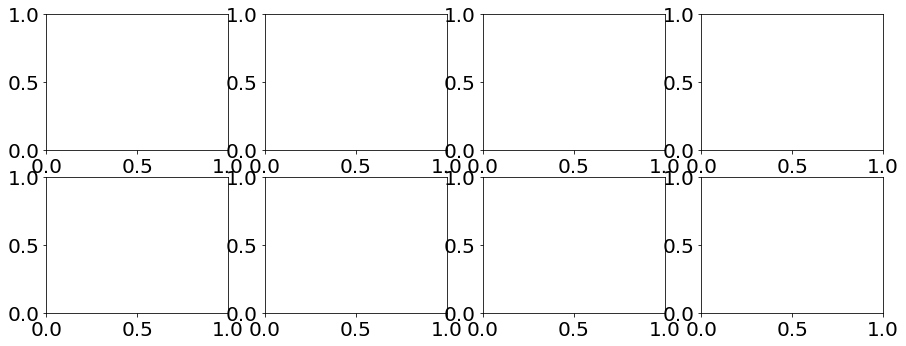

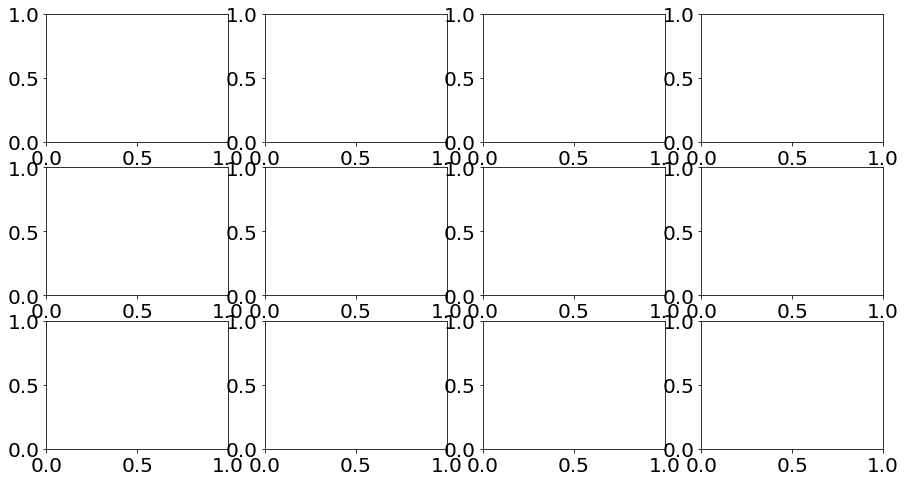

In [214]:
fig1, ax1 = plt.subplots(2,4,figsize=(15,5.5))
flatax1 = ax1.flatten()

fig2, ax2 = plt.subplots(3,4,figsize=(15,8))
flatax2 = ax2.flatten()

In [215]:
km_pval_spectral = get_kaplan_meier(new_clin_data_pc, filtered_meth_data, filtered_consensus_clustering, triple_cluster_cancers_aff, sorted(CIMP_cancers), flatax1, flatax2, sign_KM_cancers, "cluster")

ACC
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.97 0.01      6.10

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          27.79 <0.005     22.82

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.26 0.04      4.68

C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


CESC
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.24 0.63      0.68

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.63 0.20      2.31

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.53 0.47      1.09

COAD
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.25 0.62      0.70

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.36 0.55      0.87

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.15 0.70      0.52

GBM
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.22 0.64      0.64

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.13 0.01      7.04

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.80 0.01      6.78

HNSC
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.26 0.26      1.94

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.82 0.02      5.98

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.80 <0.005      9.95

KIRC
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.51 0.22      2.19

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.48 0.02      5.70

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.92 <0.005     11.59

KIRP
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          78.94 <0.005     60.44

LAML
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.72 0.40      1.34

LGG
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         117.17 <0.005     88.29

LIHC


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


Results between meth cluster 0 and 1


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.04 0.31      1.70

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.52 0.22      2.20

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.99      0.01

LUAD
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.24 0.62      0.68

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.54 0.46      1.11

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.42

LUSC
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.94 0.16      2.61

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.13 0.72      0.48

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.38 0.12      3.03

MESO
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.90      0.15

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.56 <0.005     11.31

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          17.41 <0.005     15.02

PCPG
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.89      0.17

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.50 0.48      1.06

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.37 0.54      0.88

READ
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.46 0.50      1.00

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.91      0.13

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.30 0.26      1.97

SARC
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.88      0.18

SKCM


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


Results between meth cluster 0 and 1


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.84 0.01      6.81

Results between meth cluster 0 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.90      0.15

Results between meth cluster 1 and 2


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.95 0.03      5.26

STAD
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.65 0.42      1.25

THCA
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.39 0.02      5.62

In [216]:
km_pval_spectral_lin = []
for cancer in km_pval_spectral:
    km_pval_spectral_lin+=km_pval_spectral[cancer]

In [217]:
# FDR correction with Benjamini Hochberg
bool_p,pval,_,_ = multipletests(km_pval_spectral_lin,method='fdr_bh')

In [218]:
lines, labels = flatax2[0].get_legend_handles_labels()
fig2.legend(lines, labels, loc = 'lower right', bbox_to_anchor = (1.75,0.25,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=20,frameon=False)
count=0
fignum1,fignum2=0,0
for i,cancer in enumerate(sorted(CIMP_cancers)):
    
    if cancer in sign_KM_cancers:
        fnum=fignum1
        flatax=flatax1
        fignum1+=1
    else:
        fnum=fignum2
        flatax=flatax2
        fignum2+=1
        
    if cancer in ["GBM","LUAD","LUSC","MESO","SKCM"]:
        x,y = 0.45,0.45
    elif cancer in ["LGG"]:
        x,y=0.45,0.7
    elif cancer in ["ACC","KIRP"]:
        x,y = 0.45,0.05
    else:
        x,y = 0.05,0.05
        
    if cancer in triple_cluster_cancers_aff:
        p1,p2,p3 = pval[count],pval[count+1],pval[count+2]
        text = 'L-I:{},\nL-H:{},\nI-H:{}'.format(scinum(p1,1),scinum(p2,1),scinum(p3,1)) 
        count+=3
    else:
        p1 = pval[count]
        text = 'L-H:{}'.format(scinum(p1,1))
        count+=1
    flatax[fnum].text(x, y, text, transform=flatax[fnum].transAxes,fontsize=15)
    flatax[fnum].set_xlabel("")

flatax2[-1].axis("off")


(0.0, 1.0, 0.0, 1.0)

<Figure size 432x288 with 0 Axes>

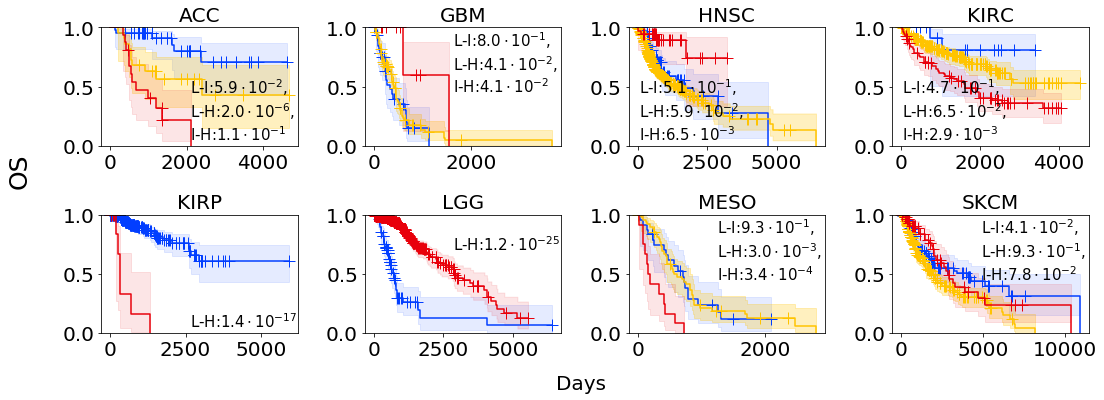

In [219]:
fig1.text(0.5, -0.02, 'Days', ha='center')
fig1.text(-0.02, 0.5, 'OS', ha='center',fontsize=25,rotation=90)
fig1.tight_layout()
fig1

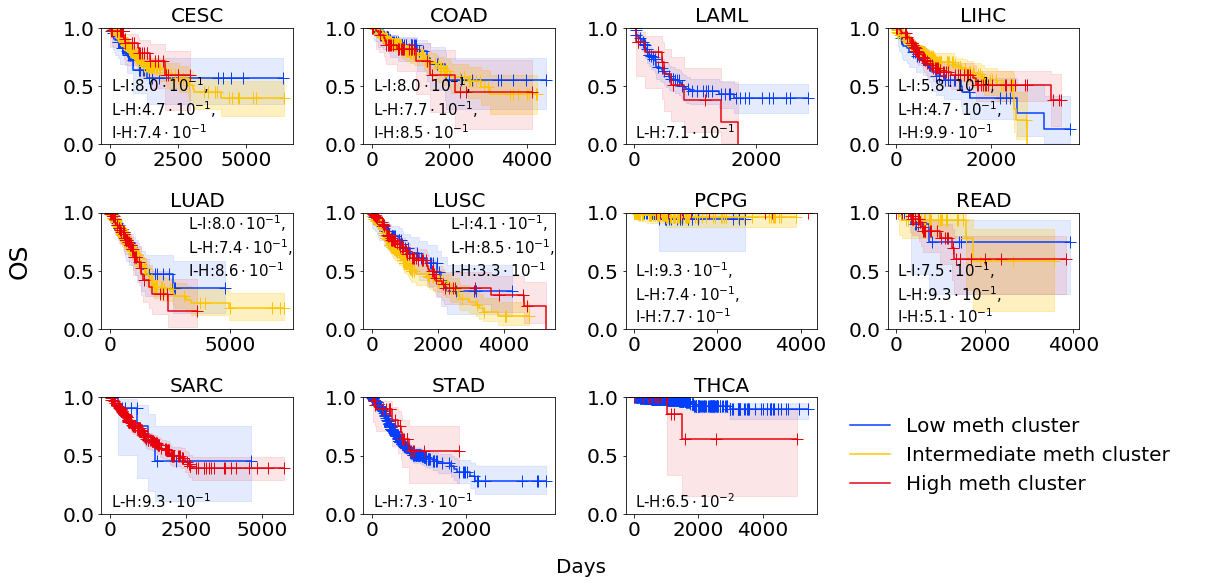

In [220]:
fig2.text(0.5, -0.02, 'Days', ha='center')
fig2.text(-0.02, 0.5, 'OS', ha='center',fontsize=25,rotation=90)
fig2.tight_layout()
fig2

In [221]:
fig1.savefig("KM_sign.png",bbox_inches="tight")
fig1.savefig("KM_sign.svg",bbox_inches="tight")
fig2.savefig("KM_nsign.png",bbox_inches="tight")
fig2.savefig("KM_nsign.svg",bbox_inches="tight")

### Survival linked to IDH1 mutation

GBM
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.08 0.02      5.37

LAML
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.09 0.77      0.38

LGG
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          75.79 <0.005     58.14

SKCM
Results between meth cluster 0 and 1


C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)
C:\Users\josep\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:656: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.98      0.03

Text(0.5, -0.02, 'Days')

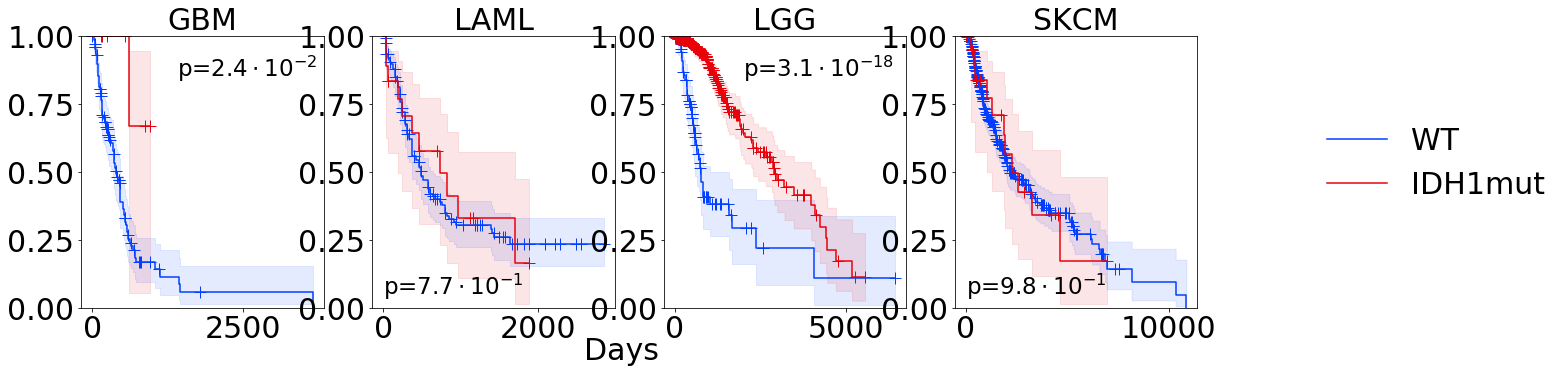

In [178]:
from math import floor,log10
def scinum(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)

plt.rc("font",size=30)
    
fig, ax = plt.subplots(1,4,figsize=(20,5))
flatax = ax.flatten()

p_values = {}

seapal = sns.color_palette("bright")
color_pal = [seapal[0], seapal[3]]

for i,cancer in enumerate(["GBM","LAML","LGG","SKCM"]):
    print(cancer)
    duration, event = get_survival_analysis_metrics_snf(new_clin_data_pc, new_meth_data_pc, mut_pancan, cancer, "IDH1")
    
    if len(list(duration.keys()))>3:
        print("More than 3 meth clusters, not taken into account!")
        continue
    ## create a kmf object
    kmf = KaplanMeierFitter() 
    ## Fit the data into the model
    kmf.fit(duration[0], event[0], label='WT')

    ## Create an estimate
    kmf.plot(show_censors=True,c=color_pal[0],ax=flatax[i],ci_alpha=0.1)
    flatax[i].set_ylim([0,1])
    ## Fit the data into the model

    kmf.fit(duration[1], event[1], label='IDH1mut')
    ## Create an estimate
    kmf.plot(show_censors=True,c=color_pal[1],ax=flatax[i],ci_alpha=0.1)

    flatax[i].set_title(cancer,fontsize=30)
    flatax[i].legend().remove()
    flatax[i].set_xlabel("")
    print("Results between meth cluster 0 and 1")
    results=logrank_test(duration[0],duration[1],event_observed_A=event[0], event_observed_B=event[1])
    p_values[cancer] = [results.p_value]
    results.print_summary()
    if cancer=="GBM":
        flatax[i].text(1400,0.85,"p={}".format(scinum(results.p_value,1)),fontsize=23)
    elif cancer=="LGG":
        flatax[i].text(2000,0.85,"p={}".format(scinum(results.p_value,1)),fontsize=23)
    else:
        flatax[i].text(0,0.05,"p={}".format(scinum(results.p_value,1)),fontsize=23)

lines, labels = flatax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'lower right', bbox_to_anchor = (0.16,0.35,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=30,frameon=False)
fig.text(0.5, -0.02, 'Days', ha='center')

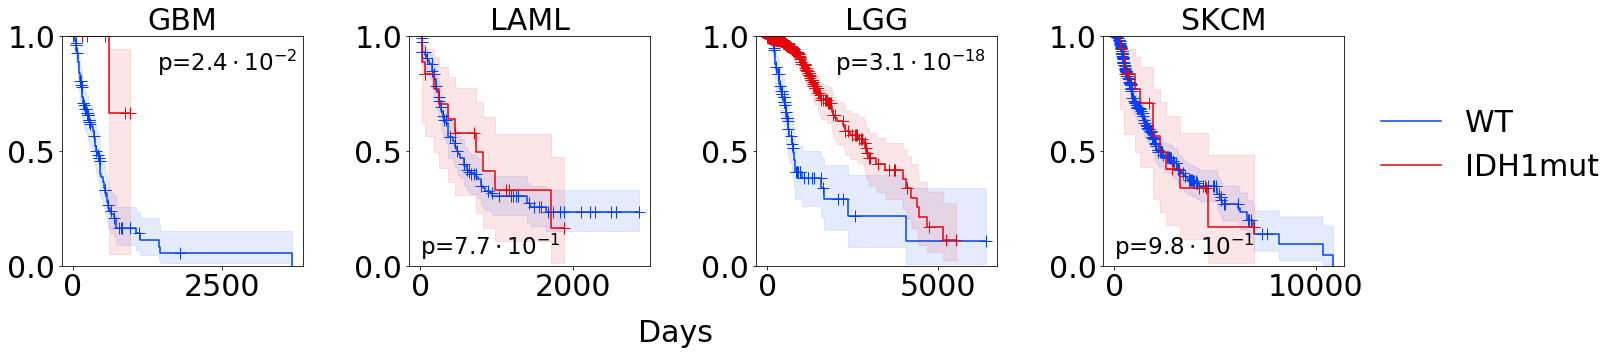

In [179]:
fig.tight_layout()
fig.savefig("IDH1_survival_KM.png",bbox_inches="tight")
fig.savefig("IDH1_survival_KM.svg",bbox_inches="tight")
fig

In [148]:
count=0
for cancer in tqdm(sorted(CIMP_cancers)):
    if cancer in triple_cluster_cancers_aff:
        print(cancer,"0-1: ",pval[count],"0-2: ",pval[count+1],"1-2: ",pval[count+2])
        count+=3
    else:
        print(cancer,"0-1: ",pval[count])
        count+=1

ACC 0-1:  0.05934773179180747 0-2:  2.0290983398137316e-06 1-2:  0.10947293848392141
CESC 0-1:  0.8029330982439843 0-2:  0.47091266961230416 1-2:  0.7440519137383756
COAD 0-1:  0.8029330982439843 0-2:  0.7683172640205201 1-2:  0.8505461878023249
GBM 0-1:  0.8029330982439843 0-2:  0.041059118497127706 1-2:  0.041059118497127706
HNSC 0-1:  0.5113956189226443 0-2:  0.05934773179180747 1-2:  0.0065183994839045365
KIRC 0-1:  0.47091266961230416 0-2:  0.06527413763862987 1-2:  0.0029198808080931624
KIRP 0-1:  1.43749561444936e-17
LAML 0-1:  0.7116276959819114
LGG 0-1:  1.1880365579636113e-25
LIHC 0-1:  0.5768337593388103 0-2:  0.47091266961230416 1-2:  0.9939563724777729
LUAD 0-1:  0.8029330982439843 0-2:  0.7440519137383756 1-2:  0.8638939923149543
LUSC 0-1:  0.4082614020566778 0-2:  0.8505461878023249 1-2:  0.32503960899011664
MESO 0-1:  0.9348043602581143 0-2:  0.002957869529035607 1-2:  0.00033959477617494406
PCPG 0-1:  0.9348043602581143 0-2:  0.7440519137383756 1-2:  0.7683172640205201

### Cox model

In [129]:
from sklearn.preprocessing import LabelBinarizer
# list of cancers with provided stage information in GDC
cancer_with_stage = ['ACC','BLCA','BRCA','CESC','ESCA','HNSC','KIRC','KIRP','LIHC','LUAD','LUSC',
 'MESO','PAAD','PRAD','SKCM','STAD','THCA','UCEC','COAD','READ']

In [140]:
def fit_cox_model(clin_data_pc,consensus_clustering,cancer,cancer_with_stage):
#     Parameters: clin_data_pc (dict): keys are cancer types, values are pd.Df (n_patients,n_clin_info)
#             consensus_clustering (dict): keys are cancer types, values are pd.DataFrame (n_pat,1) (rows=patients, column=cluster membership)
#             cancer (str): cancer type
#             cancer_with_stage (list): list of cancers with stage information
#     Returns: cph (lifelines.CoxFitter): fitted regressor
#             augclin (pd.Df): clinical data formatted for the Cox Fitter

        augclin = clin_data_pc[cancer].merge(consensus_clustering[cancer],left_index=True,right_index=True)
        augclin = augclin.replace({'[Discrepancy]':0})
        augclin['age'] = -augclin['age']
        augclin = augclin.replace({'MALE':0, 'male': 0, 'FEMALE':1, 'female': 1,})
        if cancer in ["CESC","PRAD","UCEC","BRCA"]:
            augclin = augclin.drop(['gender'],axis=1)
        if cancer in ["LAML","PCPG","SARC","THYM"]:
            augclin = augclin.drop(['stage'],axis=1)
        
        if cancer in triple_cluster_cancers_aff:
            
            lb = LabelBinarizer()
            data = lb.fit_transform(augclin["cluster"].values.ravel())
            
            column_mapping={1: "Low meth cluster", 2: "inter meth cluster", 3: "high meth cluster"}
            col_labels = [column_mapping[lb.classes_[i]] for i in range(len(lb.classes_))]
            df = pd.DataFrame(data,columns=col_labels,index=augclin.index)
            df = df.drop(["Low meth cluster"],axis=1)
            augclin = pd.concat([augclin,df],axis=1)
            
        else:
            augclin["high meth cluster"]=augclin["cluster"].replace({1:0, 2:1})
    
        
        if cancer in cancer_with_stage:
            augclin = augclin.replace(replace_map)
            augclin = augclin.replace({'Stage I':1,'Stage II':2,'Stage III':3, 'Stage IV':4, "not reported": -1})
            
        
        cph = CoxPHFitter(penalizer=0.1)
        augclin = augclin.dropna(axis=0)
        cph.fit(augclin.drop("cluster",axis=1), duration_col='OS.time', event_col='OS')
        return cph,augclin   

ACC
Median survival time cl1: inf vs cl2: 994.0
                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
stage               0.802518   2.231153  0.194978        0.420368   
age                 0.000031   1.000031  0.000030       -0.000028   
gender             -0.007733   0.992297  0.367983       -0.728967   
inter meth cluster  0.473456   1.605533  0.409149       -0.328462   
high meth cluster   1.578945   4.849835  0.424008        0.747905   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
stage                     1.184669             1.522521             3.269604   
age                       0.000091             0.999972             1.000091   
gender                    0.713501             0.482407             2.041125   
inter meth cluster        1.275374             0.720030             

Median survival time cl1: 822.0 vs cl2: 577.0
                       coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                          
age                0.000086   1.000086  0.000023        0.000040   
gender             0.268456   1.307944  0.240959       -0.203815   
high meth cluster  0.163771   1.177945  0.338311       -0.499307   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
age                      0.000132             1.000040             1.000132   
gender                   0.740728             0.815613             2.097461   
high meth cluster        0.826850             0.606951             2.286105   

                          z         p   -log2(p)  
covariate                                         
age                3.653090  0.000259  11.914182  
gender             1.114116  0.265229   1.914687  
high meth clu

                        coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                           
stage               0.125850   1.134112  0.219467       -0.304298   
age                 0.000126   1.000126  0.000053        0.000023   
gender              0.174207   1.190301  0.419206       -0.647422   
inter meth cluster -0.391737   0.675882  0.494963       -1.361847   
high meth cluster   0.126152   1.134455  0.475394       -0.805603   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
stage                     0.555998             0.737641             1.743681   
age                       0.000230             1.000023             1.000230   
gender                    0.995835             0.523393             2.706985   
inter meth cluster        0.578373             0.256187             1.783135   
high meth cluster         1.057908  

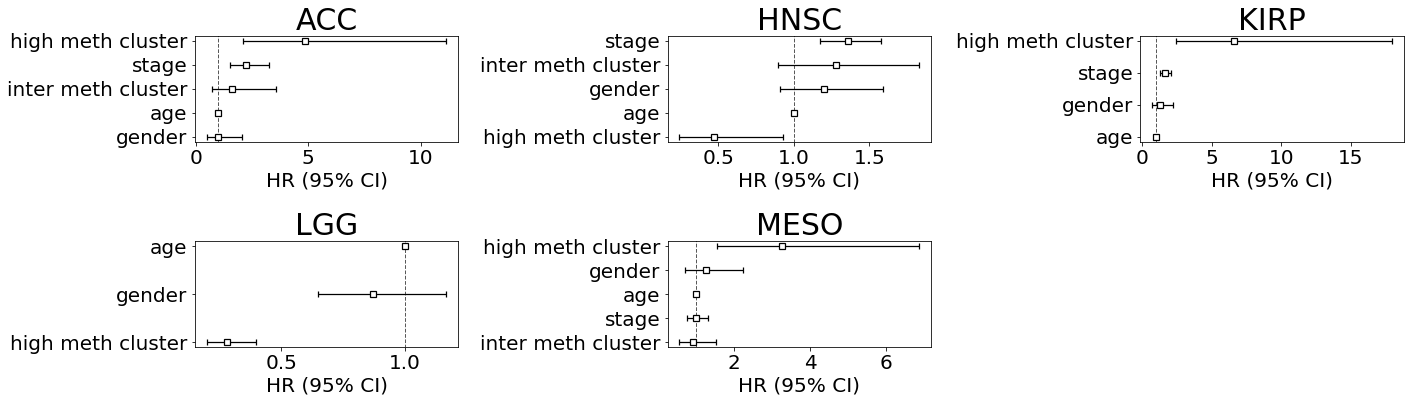

In [141]:
fig, ax = plt.subplots(2,3,figsize=(20,6))
flatax = ax.flatten()
seapal = sns.color_palette("bright")
fignum=0

plt.rc('font', size=20)

cox_p_spectral = []
for cancer in sorted(CIMP_cancers):
    print(cancer)
    cph,augclin = fit_cox_model(new_clin_data_pc,filtered_consensus_clustering,cancer,cancer_with_stage)
    augclin_cl1 = augclin[augclin["cluster"]==1]
    if cancer in triple_cluster_cancers_aff:
        augclin_cl2 = augclin[augclin["cluster"]==3]
    else:
        augclin_cl2 = augclin[augclin["cluster"]==2]
    median_df_cl1 = cph.predict_median(augclin_cl1).sort_values()
    median_df_cl2 = cph.predict_median(augclin_cl2).sort_values()
    print("Median survival time cl1: {} vs cl2: {}".format(median_df_cl1.iloc[int(median_df_cl1.shape[0]/2)],
                                                          median_df_cl2.iloc[int(median_df_cl2.shape[0]/2)]))
    print(cph.summary)

    cox_p_spectral.append(cph.summary["p"]["high meth cluster"])
    if cancer in ["ACC","HNSC","KIRP","LGG","MESO"]:
        cph.plot(hazard_ratios=True,ax=flatax[fignum])
        flatax[fignum].set_title(cancer,fontsize=30)
        flatax[fignum].set_xlabel(flatax[fignum].get_xlabel(),fontsize=20)
        fignum+=1

    #     if cancer in triple_cluster_cancers_aff:
    #         ax = cph.plot_partial_effects_on_outcome(covariates="cluster",values=[1,2,3],color=[seapal[0],seapal[2],seapal[1]])
    #         ax.legend(['Low','Intermediate','High', 'Baseline'])
    #     else:
    #         ax = cph.plot_partial_effects_on_outcome(covariates="cluster",values=[1,2],color=[seapal[0],seapal[1]])
    #         ax.legend(['Low', 'High', 'Baseline'])
    #     ax.set_xlabel("timeline")
    #     ax.set_ylim([0,1])
flatax[-1].axis("off")
fig.tight_layout()

In [137]:
fig.savefig("Cox_hazard_full.png",bbox_inches="tight")
fig.savefig("Cox_hazard_full.svg",bbox_inches="tight")

# Mutation analysis

### MSI Status

We compute the enrichment in MSI in the high methyalted clusters for COAD

In [39]:
msi_concat["MSI status"]

TCGA-F4-6854-01      mss
TCGA-AY-A54L-01    msi-l
TCGA-CM-5864-01      mss
TCGA-CK-5915-01      mss
TCGA-G4-6626-01      mss
                   ...  
TCGA-G4-6315-01      mss
TCGA-D5-6931-01      mss
TCGA-CA-6716-01      mss
TCGA-5M-AAT4-01      mss
TCGA-CK-5912-01      mss
Name: MSI status, Length: 216, dtype: object

COAD
{'indeterminate': 28, 'msi-h': 3, 'mss': 33, 'msi-l': 5} {'indeterminate': 13, 'msi-h': 22, 'mss': 4, 'msi-l': 1}
(0.01652892561983471, 7.353368269532588e-10)


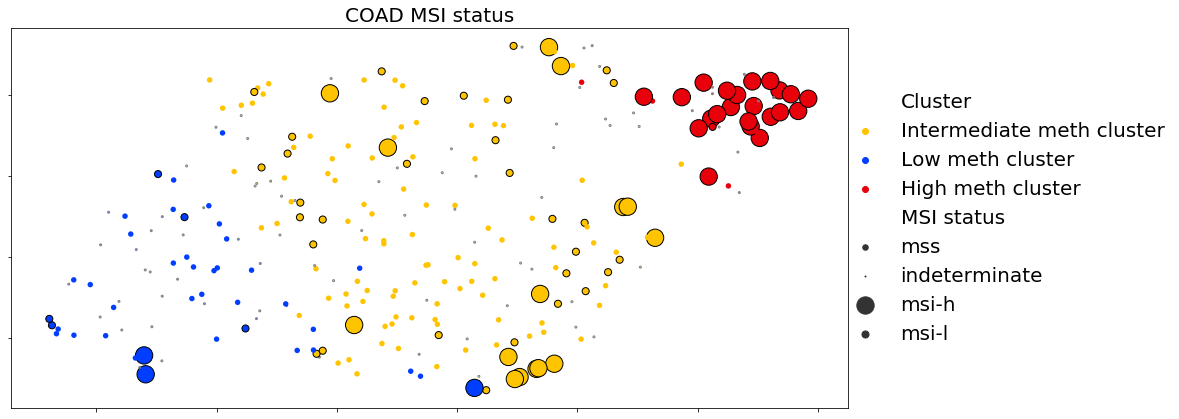

In [49]:
seapal = sns.color_palette("bright")
size_plot = {"mss": 30, "msi-h": 300, "msi-l": 50, "indeterminate": 1, -1: 1}
for cancer in ["COAD"]:
    print(cancer)
    
    # data taken from the Ciriano-Cortes Nature paper 
    red_msi = msi_profile[msi_profile["Cancer_type"]==cancer]
    ind_red_clust = [consensus_clustering_spectral[cancer].index[i][:-3] for i in range(consensus_clustering_spectral[cancer].shape[0])]
    red_clust = consensus_clustering_spectral[cancer].copy()
    red_clust.index = ind_red_clust
    red_clust = red_clust.loc[red_msi.index.intersection(ind_red_clust)]
    red_clust = red_clust[~red_clust.index.duplicated()]
    red_msi = red_msi.loc[red_msi.index.intersection(ind_red_clust)]
    red_msi = red_msi[~red_msi.index.duplicated()]
    msi_concat = pd.concat([red_msi,red_clust],axis=1)
    msi_concat.index = msi_concat.index+"-01"
    msi_concat = msi_concat.rename(columns={"MSI_category_nb_from_TCGA_consortium": "MSI status"})
    
    df = pd.concat([plot_df_spectral[plot_df_spectral["cancer"]==cancer],msi_concat],axis=1).fillna("indeterminate")
    
    dictcl1 = dict(Counter(df[df["Cluster"]=="Low meth cluster"]["MSI status"]))
    dictcl2 = dict(Counter(df[df["Cluster"]=="High meth cluster"]["MSI status"]))
    if not("msi-h" in dictcl1):
        dictcl1["msi-h"]=0
    if not("msi-h" in dictcl2):
        dictcl2["msi-h"]=0
    print(dictcl1,dictcl2)
    contingency = pd.DataFrame(np.zeros((2,2)),index=["msi-h","mss"],columns=["Low meth cluster", "High meth cluster"])
    for ms in contingency.index:
        contingency.loc[ms]["Low meth cluster"] = dictcl1[ms]
        contingency.loc[ms]["High meth cluster"] = dictcl2[ms]
    print(fisher_exact(contingency))
    
    edgecolor_list = df["MSI status"].replace({"mss": "white", "indeterminate": "grey", "msi-h": "black", "msi-l": "black"}).values
    linewidth_list = df["MSI status"].replace({"mss": 0, "indeterminate": 2, "msi-h": 1, "msi-l": 1}).values
    
    fig,ax = plt.subplots(1,1,figsize=(15,7))
    ax.set_title(cancer+" MSI status",fontsize=20)

    plt.rc('font', size=20)
    sns.scatterplot(data=df,x="Comp1",y="Comp2",hue="Cluster",size="MSI status",
                    sizes=size_plot,legend="auto", ax=ax,
                    palette={"Low meth cluster": seapal[0], "High meth cluster": seapal[3],"Intermediate meth cluster": seapal[8]},
                   edgecolor=edgecolor_list,linewidth=linewidth_list)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.legend(loc='right', bbox_to_anchor=(1.4,0.5),frameon=False,fontsize=20)

    plt.savefig(cancer+"_MSI_status.png",dpi=100)
    plt.savefig(cancer+"_MSI_status.svg")

### MGME analysis

In [114]:
from sklearn.neighbors import NearestNeighbors

In [115]:
gencode_annot_gene = pd.read_csv("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\auxiliary_data\\gencode_annot_length.csv")

In [269]:
def get_coordinates_genes_cancer(gencode_annot_gene,gene_data_pc,mut_pancan,cancer):
    gex_cancer = gene_data_pc[cancer].mean()
    gex_cancer = gex_cancer.rename("gex_cancer")
    gex_cancer = pd.concat([gex_cancer,inv_merged_table.loc[gene_data_pc[cancer].columns.intersection(inv_merged_table.index)]["index"]],axis=1).dropna()
    gex_cancer.columns=["gex_cancer","gene_name"]
    gex_cancer = gex_cancer.reset_index()
    merged_df = gencode_annot_gene.merge(gex_cancer,how="inner",left_on="gene_name",right_on="gene_name")[["gene_name","length","gex_cancer"]]
    merged_df = merged_df.set_index("gene_name")
    merged_df.columns=["length","gex_cancer"]
    merged_df = merged_df[~merged_df.index.duplicated()]
    merged_df = merged_df.loc[mut_pancan[cancer].columns.intersection(merged_df.index)]
    std = StandardScaler()
    coordinates = pd.DataFrame(std.fit_transform(merged_df[["length","gex_cancer"]].values),index=merged_df.index,columns=["x","y"])
    return coordinates

In [180]:
def get_mutational_burden_comparison(list_cancer,df_louvain_snf,mut_pancan,genes_of_interest):
    mut_burden,goi_mut_burden = [],[]
    
    for cancer in list_cancer:

        ind_cl_1 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==1].index
        ind_cl_2 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==2].index
        ind_cl_3 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==3].index
        if cancer in triple_cluster_cancers_aff:
            ind_cl_2 = ind_cl_3
        
        ind_cl_1 = mut_pancan[cancer].index.intersection(ind_cl_1)
        ind_cl_2 = mut_pancan[cancer].index.intersection(ind_cl_2)
        
        mut_burden.append([mut_pancan[cancer].loc[ind_cl_1].T.sum().sum()+1, \
                            mut_pancan[cancer].loc[ind_cl_2].T.sum().sum()+1])
        if len(genes_of_interest)==1:
            goi_mut_burden.append([int(mut_pancan[cancer][genes_of_interest[0]].loc[ind_cl_1].sum())+1, \
                            int(mut_pancan[cancer][genes_of_interest[0]].loc[ind_cl_2].sum())+1])
        else:
            goi_mut_burden.append([mut_pancan[cancer][genes_of_interest].loc[ind_cl_1].T.sum().sum()+1, \
                            mut_pancan[cancer][genes_of_interest].loc[ind_cl_2].T.sum().sum()+1])
    mut_burden = pd.DataFrame(mut_burden,columns=["Low meth cluster","High meth cluster"],index=list_cancer)
    goi_mut_burden = pd.DataFrame(goi_mut_burden,columns=["Low meth cluster","High meth cluster"],index=list_cancer)
    return mut_burden,goi_mut_burden

In [181]:
def get_df_mut_comp_pergene(list_cancer,df_louvain_snf,mut_pancan,genes_of_interest):
    df_mut_comp_pergene = []
    
    for gene in tqdm(genes_of_interest):
       
        mut_burden, goi_mut_burden = get_mutational_burden_comparison(list_cancer,df_louvain_snf,mut_pancan,[gene])
        mut_burden_comp = pd.concat([goi_mut_burden["Low meth cluster"]/mut_burden["Low meth cluster"]*10000,
                                      goi_mut_burden["High meth cluster"]/mut_burden["High meth cluster"]*10000],axis=1)
        comp_mut_burden = mut_burden_comp["High meth cluster"]/mut_burden_comp["Low meth cluster"]
        if len(df_mut_comp_pergene)==0:
            df_mut_comp_pergene = comp_mut_burden
        else:
            df_mut_comp_pergene = pd.concat([df_mut_comp_pergene,comp_mut_burden],axis=1)
    df_mut_comp_pergene.columns = genes_of_interest
    return df_mut_comp_pergene

In [119]:
def find_1NN_genes(genes_of_interest,coordinates_val_lasso_pc,cancer,n_neighbors):
    gene_list = []
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(coordinates_val_lasso_pc[cancer].values)
    coord_gene = coordinates_val_lasso_pc[cancer].loc[genes_of_interest].values
    neighbor_inds = neigh.kneighbors(coord_gene,return_distance=False)
    for i in range(neighbor_inds.shape[0]):
        neigh_ind = neighbor_inds[i,np.random.randint(n_neighbors)]
        gene_list.append(coordinates_val_lasso_pc[cancer].index[neigh_ind])
    return gene_list

In [279]:
def get_bootstrap_comp_mut_burden(coordinates_val_lasso_pc,n_neighbors,list_cancer,
                                  df_louvain_snf,mut_pancan,genes_of_interest):
    mut_burden = []
    for cancer in list_cancer:
        ind_cl_1 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==1].index
        ind_cl_2 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==2].index
        ind_cl_3 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==3].index
        if cancer in triple_cluster_cancers_aff:
            ind_cl_2 = ind_cl_3
        ind_cl_1 = mut_pancan[cancer].index.intersection(ind_cl_1)
        ind_cl_2 = mut_pancan[cancer].index.intersection(ind_cl_2)
        
        mut_burden.append([mut_pancan[cancer].loc[ind_cl_1].T.sum().sum()+1, \
                            mut_pancan[cancer].loc[ind_cl_2].T.sum().sum()+1])
    mut_burden = pd.DataFrame(mut_burden,columns=["Low meth cluster","High meth cluster"],index=list_cancer)
    print("Done calculating mutational burden")
    
    mut_bootstrap = []
    for i in tqdm(range(500)):
        
        genes_bootstrap = find_1NN_genes(genes_of_interest,coordinates_val_lasso_pc,cancer,n_neighbors)
        
        goi_mut_burden = []
        for cancer in list_cancer:
            ind_cl_1 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==1].index
            ind_cl_2 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==2].index
            ind_cl_3 = df_louvain_snf[cancer][df_louvain_snf[cancer]["cluster"]==3].index
            if cancer in triple_cluster_cancers_aff:
                ind_cl_2 = ind_cl_2
            ind_cl_1 = mut_pancan[cancer].index.intersection(ind_cl_1)
            ind_cl_2 = mut_pancan[cancer].index.intersection(ind_cl_2)  
                
            if len(genes_of_interest)==1:
                goi_mut_burden.append([int(mut_pancan[cancer][genes_bootstrap[0]].loc[ind_cl_1].sum())+1, \
                                int(mut_pancan[cancer][genes_bootstrap[0]].loc[ind_cl_2].sum())+1])
            else:
                goi_mut_burden.append([mut_pancan[cancer][genes_bootstrap].loc[ind_cl_1].T.sum().sum()+1, \
                                mut_pancan[cancer][genes_bootstrap].loc[ind_cl_2].T.sum().sum()+1])
        goi_mut_burden = pd.DataFrame(goi_mut_burden,columns=["Low meth cluster","High meth cluster"],index=list_cancer)
        
        mut_burden_comp = pd.concat([goi_mut_burden["Low meth cluster"]/mut_burden["Low meth cluster"]*10000,
                                  goi_mut_burden["High meth cluster"]/mut_burden["High meth cluster"]*10000],axis=1)
        comp_mut_burden = mut_burden_comp["High meth cluster"]/mut_burden_comp["Low meth cluster"]
        mut_bootstrap.append(comp_mut_burden.values)
    
    return mut_bootstrap

In [175]:
def get_empirical_p_value_mutations(mut_bootstrap,comp_mut_burden,meth_or_demeth,list_cancer):
    p_value = {cancer: 0 for cancer in list_cancer}
    comp_burd = comp_mut_burden[meth_or_demeth]
    for i in tqdm(range(len(mut_bootstrap))):
        for j in range(len(mut_bootstrap[i])):
            if comp_burd.iloc[j]>1 and mut_bootstrap[i][j]>comp_burd.iloc[j]:
                p_value[list_cancer[j]]+=1/1000
            elif comp_burd.iloc[j]<1 and mut_bootstrap[i][j]<comp_burd.iloc[j]:
                p_value[list_cancer[j]]+=1/1000
    return p_value

In [127]:
COAD_gene = {"COAD": pd.read_csv("C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\gene_fpkm\\COADREAD_gene_fpkm.csv")
        }

In [138]:
COAD_gene["COAD"]["Unnamed: 0"] = COAD_gene["COAD"]["Unnamed: 0"].apply(lambda x: x[:15])
COAD_gene["COAD"] = COAD_gene["COAD"].set_index("Unnamed: 0")
COAD_gene["COAD"] = COAD_gene["COAD"][~COAD_gene["COAD"].index.duplicated()]
COAD_gene["COAD"] = COAD_gene["COAD"].loc[consensus_clustering_spectral["COAD"].index.intersection(COAD_gene["COAD"].index)]

In [270]:
coordinates_val_lasso_pc = {}
for cancer in ["COAD"]:
    coordinates_val_lasso_pc[cancer] = get_coordinates_genes_cancer(gencode_annot_gene,COAD_gene,mut_pancan,cancer)

In [182]:
df_mut_comp_pergene_meth = get_df_mut_comp_pergene(["COAD"],consensus_clustering_spectral,mut_pancan,mutations_to_test["COAD"])

In [185]:
df_mut_comp_pergene_meth

ASH1L   EHMT1    EHMT2     KMT2A    KMT2B     KMT2C     KMT2D  \
COAD  2.410566  1.0331  0.51655  0.344367  1.54965  0.319769  0.792043   

         MECOM      NSD1   PRDM1  ...     KDM4C    KDM5A     KDM5B     KDM5C  \
COAD  1.721833  0.602642  1.0331  ...  0.860916  0.51655  0.602642  0.860916   

        KDM6A     KDM6B     PHF2      BRAF      KRAS      TP53  
COAD  0.51655  0.631339  0.51655  5.165499  0.110689  0.056223  

[1 rows x 44 columns]

In [280]:
df_p_value_pergene_meth = []
for gene in tqdm(mutations_to_test["COAD"]):
    mut_bootstrap_pergene_meth = get_bootstrap_comp_mut_burden(coordinates_val_lasso_pc,1000,["COAD"],
                                  consensus_clustering_spectral,mut_pancan,[gene])
    p_value_mut_pergene = get_empirical_p_value_mutations(mut_bootstrap_pergene_meth,df_mut_comp_pergene_meth,gene,["COAD"])
    if len(df_p_value_pergene_meth)==0:
        df_p_value_pergene_meth = pd.DataFrame.from_dict(p_value_mut_pergene, orient='index',columns=[gene])
    else:
        df_p_value_pergene_meth = pd.concat([df_p_value_pergene_meth,pd.DataFrame.from_dict(p_value_mut_pergene, orient='index',columns=[gene])],axis=1)


Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden



Done calculating mutational burden


In [285]:
len(mutations_to_test["COAD"])

44

In [283]:
mask_multipletest_meth = []
for cancer in ["COAD"]:
    multtest = multipletests(df_p_value_pergene_meth.loc[cancer],method='fdr_bh')
    mask_multipletest_meth.append(multtest[0])
    for i,gene in enumerate(mutations_to_test["COAD"]):
        print(gene,multtest[0][i],multtest[1][i])

ASH1L True 0.0
EHMT1 False 0.09020000000000007
EHMT2 False 0.45944186046511665
KMT2A False 0.2880000000000002
KMT2B True 0.012571428571428572
KMT2C False 0.23466666666666683
KMT2D False 0.45944186046511665
MECOM True 0.036000000000000004
NSD1 False 0.45944186046511665
PRDM1 True 0.04693333333333336
PRDM2 False 0.06355555555555559
PRDM9 False 0.45944186046511665
PRDM10 False 0.45944186046511665
PRDM13 True 0.0
PRDM14 False 0.47600000000000037
PRDM15 False 0.45944186046511665
PRDM16 False 0.45944186046511665
SETD1A True 0.012571428571428572
SETD1B True 0.040333333333333346
SETD2 False 0.05952941176470592
SETDB1 False 0.05952941176470592
BAZ2A True 0.036000000000000004
DNMT1 True 0.04693333333333336
UHRF1BP1L False 0.45944186046511665
TET1 True 0.036000000000000004
TET2 False 0.4241600000000003
TET3 False 0.45944186046511665
MBD1 True 0.033
APOBEC1 False 0.45944186046511665
CTCF False 0.45944186046511665
KDM2B False 0.40883333333333366
KDM3B False 0.45100000000000035
KDM4A True 0.0088
KDM

### GOI mutations

We now analyze mutations in genes of interest (DNA & Histone methylation/demethylation genes) and compute associated p-values

In [93]:
for cancer in tqdm(sorted(CIMP_cancers)):
    all_p_fisher = []
    print(cancer)
    common_pat_clustering = filtered_consensus_clustering[cancer].loc[filtered_consensus_clustering[cancer].index.intersection(mut_pancan[cancer].index)]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    if cancer in triple_cluster_cancers_aff:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    else:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    genes = all_genes_writer_Hmeth
    mutated_genes,mutated_index = [],[]
    for i,gene in enumerate(genes):
        n_mut_1 = (mut_pancan[cancer][gene].loc[ind_cl_1]>0).sum()
        n_mut_2 = (mut_pancan[cancer][gene].loc[ind_cl_2]>0).sum()
        perc_mut_1 = n_mut_1/len(ind_cl_1)*100
        perc_mut_2 = n_mut_2/len(ind_cl_2)*100
        p_fisher = fisher_exact(np.array([[n_mut_1,n_mut_2],[len(ind_cl_1)-n_mut_1,len(ind_cl_2)-n_mut_2]]))[1]
        all_p_fisher.append(p_fisher)
        if np.abs(perc_mut_1-perc_mut_2)>10:
            mutated_genes.append(gene)
            mutated_index.append(i)
            print(gene,perc_mut_1,perc_mut_2,p_fisher)
    print("percent of patients with at least one sign mut genes cl1 {} & cl2 {}".format((mut_pancan[cancer][mutated_genes].loc[ind_cl_1].T.sum()>0).sum()/len(ind_cl_1)*100,(mut_pancan[cancer][mutated_genes].loc[ind_cl_2].T.sum()>0).sum()/len(ind_cl_2)*100))
    if len(all_p_fisher)>0:
        print(multipletests(all_p_fisher,alpha=0.1,method="fdr_bh")[1][mutated_index])

ACC
KMT2A 0.0 12.5 0.07792207792207759
percent of patients with at least one sign mut genes cl1 0.0 & cl2 12.5
[1.]
CESC
KMT2B 12.0 0.0 0.03441650851806584
KMT2D 18.0 5.263157894736842 0.10535702779706074
NSD1 22.0 0.0 0.0019431897968949364
percent of patients with at least one sign mut genes cl1 34.0 & cl2 5.263157894736842
[0.75716319 0.81975565 0.08550035]
COAD
ASH1L 0.0 33.33333333333333 1.742639836797992e-06
EHMT1 0.0 12.82051282051282 0.008933941370843943
EHMT2 1.7241379310344827 12.82051282051282 0.03709527830067777
KMT2A 6.896551724137931 23.076923076923077 0.032282168971961116
KMT2B 3.4482758620689653 66.66666666666666 7.406159369698537e-12
KMT2C 10.344827586206897 30.76923076923077 0.016086030605969817
KMT2D 6.896551724137931 56.41025641025641 8.148529450970746e-08
MECOM 0.0 23.076923076923077 0.00014828113150997684
NSD1 1.7241379310344827 15.384615384615385 0.01592785581715425
PRDM1 0.0 12.82051282051282 0.008933941370843943
PRDM10 1.7241379310344827 17.94871794871795 0.0065

In [60]:
for cancer in tqdm(sorted(CIMP_cancers)):
    all_p_fisher = []
    print(cancer)
    common_pat_clustering = filtered_consensus_clustering[cancer].loc[filtered_consensus_clustering[cancer].index.intersection(mut_pancan[cancer].index)]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    if cancer in triple_cluster_cancers_aff:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    else:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    genes = all_genes_eraser_Hmeth
    mutated_genes,mutated_index = [],[]
    for i,gene in enumerate(genes):
        n_mut_1 = (mut_pancan[cancer][gene].loc[ind_cl_1]>0).sum()
        n_mut_2 = (mut_pancan[cancer][gene].loc[ind_cl_2]>0).sum()
        perc_mut_1 = n_mut_1/len(ind_cl_1)*100
        perc_mut_2 = n_mut_2/len(ind_cl_2)*100
        p_fisher = fisher_exact(np.array([[n_mut_1,n_mut_2],[len(ind_cl_1)-n_mut_1,len(ind_cl_2)-n_mut_2]]))[1]
        all_p_fisher.append(p_fisher)
        if np.abs(perc_mut_1-perc_mut_2)>10:
            mutated_genes.append(gene)
            mutated_index.append(i)
            print(gene,perc_mut_1,perc_mut_2,p_fisher)
    print("percent of patients with at least one sign mut genes cl1 {} & cl2 {}".format((mut_pancan[cancer][mutated_genes].loc[ind_cl_1].T.sum()>0).sum()/len(ind_cl_1)*100,(mut_pancan[cancer][mutated_genes].loc[ind_cl_2].T.sum()>0).sum()/len(ind_cl_2)*100))
    if len(all_p_fisher)>0:
        print(multipletests(all_p_fisher,alpha=0.1,method="fdr_bh")[1][mutated_index])

ACC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
CESC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
COAD
KDM2B 6.896551724137931 28.205128205128204 0.00821627125125761
KDM3B 1.7241379310344827 12.82051282051282 0.03709527830067777
KDM4A 0.0 17.94871794871795 0.0011973103461642254
KDM4B 0.0 15.384615384615385 0.0033016739848770655
KDM4C 0.0 10.256410256410255 0.023738758499671282
KDM5A 1.7241379310344827 12.82051282051282 0.03709527830067777
KDM5B 1.7241379310344827 15.384615384615385 0.01592785581715425
KDM5C 0.0 10.256410256410255 0.023738758499671282
KDM6A 1.7241379310344827 12.82051282051282 0.03709527830067777
KDM6B 3.4482758620689653 25.64102564102564 0.002867059576018379
PHF2 1.7241379310344827 12.82051282051282 0.03709527830067777
percent of patients with at least one sign mut genes cl1 13.793103448275861 & cl2 74.35897435897436
[0.04518949 0.07419056 0.02421228 0.02421228 0.07419056 0.07419056
 0.07008257 0.07419056 0.074

In [62]:
for cancer in tqdm(sorted(CIMP_cancers)):
    all_p_fisher = []
    print(cancer)
    common_pat_clustering = filtered_consensus_clustering[cancer].loc[filtered_consensus_clustering[cancer].index.intersection(mut_pancan[cancer].index)]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    if cancer in triple_cluster_cancers_aff:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    else:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    genes = genes_demeth_gex
    mutated_genes,mutated_index = [],[]
    for i,gene in enumerate(genes):
        n_mut_1 = (mut_pancan[cancer][gene].loc[ind_cl_1]>0).sum()
        n_mut_2 = (mut_pancan[cancer][gene].loc[ind_cl_2]>0).sum()
        perc_mut_1 = n_mut_1/len(ind_cl_1)*100
        perc_mut_2 = n_mut_2/len(ind_cl_2)*100
        p_fisher = fisher_exact(np.array([[n_mut_1,n_mut_2],[len(ind_cl_1)-n_mut_1,len(ind_cl_2)-n_mut_2]]))[1]
        all_p_fisher.append(p_fisher)
        if np.abs(perc_mut_1-perc_mut_2)>10:
            mutated_genes.append(gene)
            mutated_index.append(i)
            print(gene,perc_mut_1,perc_mut_2,p_fisher)
    print("percent of patients with at least one sign mut genes cl1 {} & cl2 {}".format((mut_pancan[cancer][mutated_genes].loc[ind_cl_1].T.sum()>0).sum()/len(ind_cl_1)*100,(mut_pancan[cancer][mutated_genes].loc[ind_cl_2].T.sum()>0).sum()/len(ind_cl_2)*100))
    if len(all_p_fisher)>0:
        print(multipletests(all_p_fisher,alpha=0.1,method="fdr_bh")[1][mutated_index])

ACC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
CESC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
COAD
TET1 0.0 17.94871794871795 0.0011973103461642254
TET2 1.7241379310344827 12.82051282051282 0.03709527830067777
TET3 3.4482758620689653 33.33333333333333 9.2580865684162e-05
MBD1 0.0 12.82051282051282 0.008933941370843943
APOBEC1 0.0 10.256410256410255 0.023738758499671282
CTCF 0.0 10.256410256410255 0.023738758499671282
percent of patients with at least one sign mut genes cl1 5.172413793103448 & cl2 64.1025641025641
[0.00718386 0.07419056 0.00111097 0.03573577 0.05697302 0.05697302]
GBM
IDH1 0.0 87.5 4.291025962852595e-07
percent of patients with at least one sign mut genes cl1 0.0 & cl2 87.5
[5.14923116e-06]
HNSC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
KIRC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
KIRP
percent of patients with at least one sign mut genes cl1 0

In [63]:
for cancer in tqdm(sorted(CIMP_cancers)):
    all_p_fisher = []
    print(cancer)
    common_pat_clustering = filtered_consensus_clustering[cancer].loc[filtered_consensus_clustering[cancer].index.intersection(mut_pancan[cancer].index)]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    if cancer in triple_cluster_cancers_aff:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    else:
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    genes = genes_meth_gex
    mutated_genes,mutated_index = [],[]
    for i,gene in enumerate(genes):
        n_mut_1 = (mut_pancan[cancer][gene].loc[ind_cl_1]>0).sum()
        n_mut_2 = (mut_pancan[cancer][gene].loc[ind_cl_2]>0).sum()
        perc_mut_1 = n_mut_1/len(ind_cl_1)*100
        perc_mut_2 = n_mut_2/len(ind_cl_2)*100
        p_fisher = fisher_exact(np.array([[n_mut_1,n_mut_2],[len(ind_cl_1)-n_mut_1,len(ind_cl_2)-n_mut_2]]))[1]
        all_p_fisher.append(p_fisher)
        if np.abs(perc_mut_1-perc_mut_2)>10:
            mutated_genes.append(gene)
            mutated_index.append(i)
            print(gene,perc_mut_1,perc_mut_2,p_fisher)
    print("percent of patients with at least one sign mut genes cl1 {} & cl2 {}".format((mut_pancan[cancer][mutated_genes].loc[ind_cl_1].T.sum()>0).sum()/len(ind_cl_1)*100,(mut_pancan[cancer][mutated_genes].loc[ind_cl_2].T.sum()>0).sum()/len(ind_cl_2)*100))
    if len(all_p_fisher)>0:
        print(multipletests(all_p_fisher,alpha=0.1,method="fdr_bh")[1][mutated_index])

ACC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
CESC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
COAD
BAZ2A 0.0 15.384615384615385 0.0033016739848770655
DNMT1 0.0 15.384615384615385 0.0033016739848770655
UHRF1BP1L 1.7241379310344827 17.94871794871795 0.006598510352194003
percent of patients with at least one sign mut genes cl1 1.7241379310344827 & cl2 43.58974358974359
[0.02146088 0.02146088 0.02859354]
GBM
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
HNSC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
KIRC
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
KIRP
percent of patients with at least one sign mut genes cl1 0.0 & cl2 0.0
[]
LAML
DNMT3A 24.390243902439025 12.5 0.36205731467157093
percent of patients with at least one sign mut genes cl1 24.390243902439025 & cl2 12.5
[1.]
LGG
percent of patients with at least one sign mut genes cl1 0.0 & cl2

# RF for feature selection

We train Random Forest (RF) classifiers on the entire mutational information. We keep RF that perform better than random (ABAC > 0 on 10-fold CV) and have persistency of features over 10 folds. 

In [231]:
def common_features(lol):
    # common features in list of lists
    return list(set(lol[0]).intersection(*lol[1:]))

In [232]:
def plot_important_features_RF(mut_or_gene_pc,cancer,consensus_clustering,n_splits):
#     Parameters: mut_or_gene_pc (dict): keys are cancer types, values are pd.Df with mutational or gene expression info (n_patients,n_genes or n_mut)
#             cancer (str): cancer type
#             consensus_clustering (dict): keys are cancer types, values are pd.Df (n_patients,1) (rows=patients,columns=cluster membership)
#             n_splits (int): number of CV splits
#     Returns: best_estimator (sklearn RandomForestClassifier): trained RF classifier with best score
#             common_features (list): list of positions of best features per cancer
    RF_scores = {}
    
    X = mut_or_gene_pc[cancer]
    X = X.replace({0: np.nan}).dropna(axis=1,how="all").replace({np.nan: 0})
    y = consensus_clustering[cancer]
    common_pat = X.index.intersection(y.index)
    X = X.loc[common_pat]
    y = y.loc[common_pat].values.ravel()
    
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True,random_state=33)
    bac_scores, estimators, sel_10_feat = [],[],[]
    for train_index,test_index in outer_cv.split(X,y):
        
        X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index], \
                                            y[train_index],y[test_index]

        sel = SelectFromModel(RandomForestClassifier(n_estimators = 500,class_weight="balanced"))
        sel.fit(X_train, y_train)
        y_pred = sel.estimator_.predict(X_test)
        bac_scores.append(balanced_accuracy_score(y_test,y_pred,adjusted=True))
        estimators.append(sel.estimator_)
        sel_10_feat.append(np.argsort(sel.estimator_.feature_importances_)[::-1][:10])
    
    print("{}-fold BAC on test set of {}: {}".format(n_splits,cancer,np.mean(bac_scores)))
    print("Common 10 best features selected for {} folds : {}".format(n_splits,X.columns[common_features(sel_10_feat)]))
    best_estimator = estimators[np.argmax(bac_scores)]
    RF_score = np.max(bac_scores)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=best_estimator.feature_importances_[np.argsort(best_estimator.feature_importances_)[::-1][:10]],
                y=X_train.columns[np.argsort(best_estimator.feature_importances_)[::-1][:10]])
    #Add chart labels
    plt.title('Feature importance of best estimator for '+cancer)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return best_estimator,common_features(sel_10_feat),RF_score

10-fold BAC on test set of ACC: 0.0041666666666666675
Common 10 best features selected for 10 folds : Index(['MUC16'], dtype='object')
10-fold BAC on test set of CESC: 0.050119047619047605
Common 10 best features selected for 10 folds : Index(['PIK3CA', 'KRAS', 'TP73'], dtype='object')
10-fold BAC on test set of COAD: 0.2015350877192982
Common 10 best features selected for 10 folds : Index(['KRAS', 'TP53', 'BRAF'], dtype='object')


C:\Users\josep\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


10-fold BAC on test set of GBM: 0.033333333333333326
Common 10 best features selected for 10 folds : Index(['ATRX', 'IDH1', 'TP53'], dtype='object')
10-fold BAC on test set of HNSC: 0.008333333333333335
Common 10 best features selected for 10 folds : Index(['CDKN2A', 'NSD1', 'FAT1', 'TP53', 'CASP8', 'CYLD'], dtype='object')
10-fold BAC on test set of KIRC: 0.008333333333333335
Common 10 best features selected for 10 folds : Index(['PBRM1', 'SETD2'], dtype='object')
10-fold BAC on test set of KIRP: 0.0
Common 10 best features selected for 10 folds : Index([], dtype='object')
10-fold BAC on test set of LAML: 0.0
Common 10 best features selected for 10 folds : Index(['IDH2', 'IDH1', 'NPM1'], dtype='object')
10-fold BAC on test set of LGG: 0.8844444444444445
Common 10 best features selected for 10 folds : Index(['EGFR', 'CIC', 'FUBP1', 'ATRX', 'TP53', 'IDH1', 'NF1', 'PTEN'], dtype='object')
10-fold BAC on test set of LIHC: 0.18496810207336525
Common 10 best features selected for 10 folds :

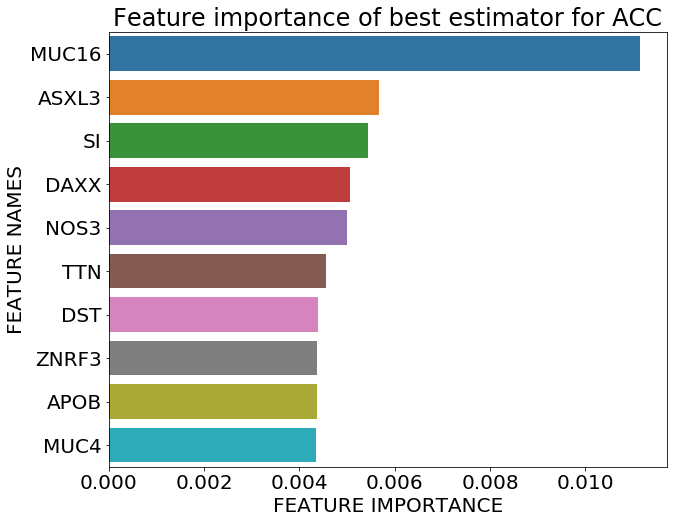

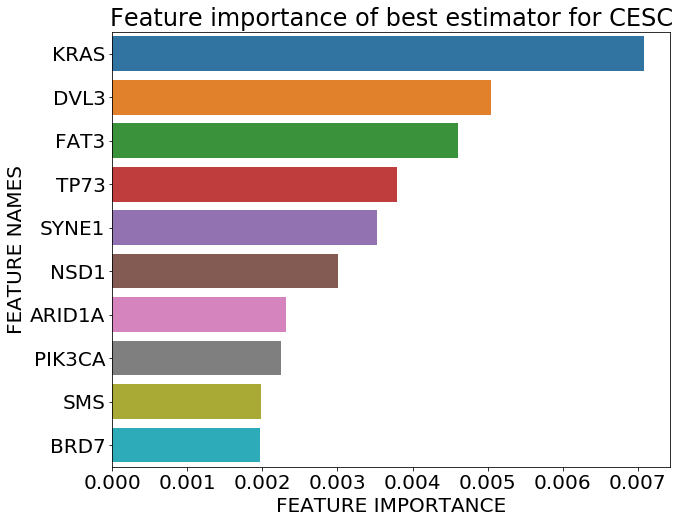

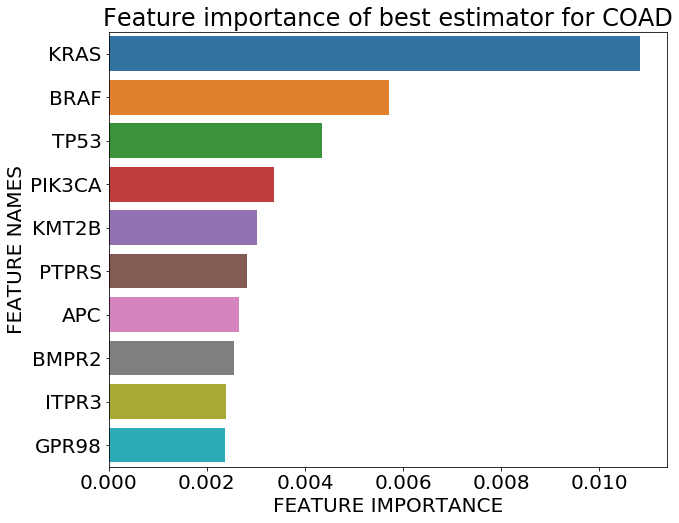

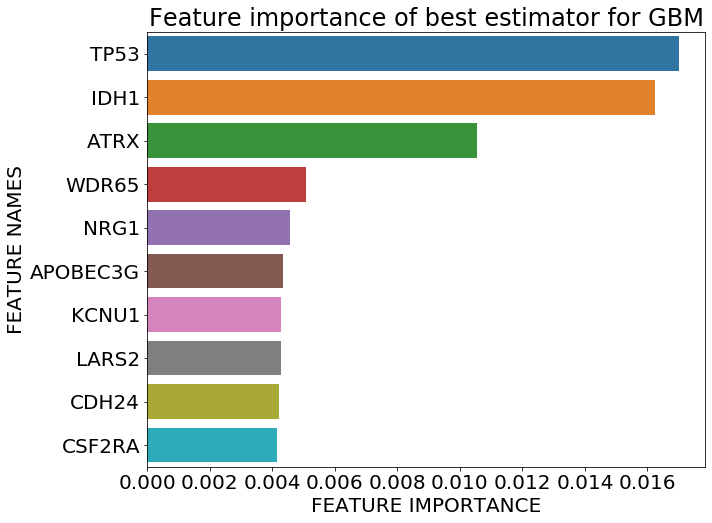

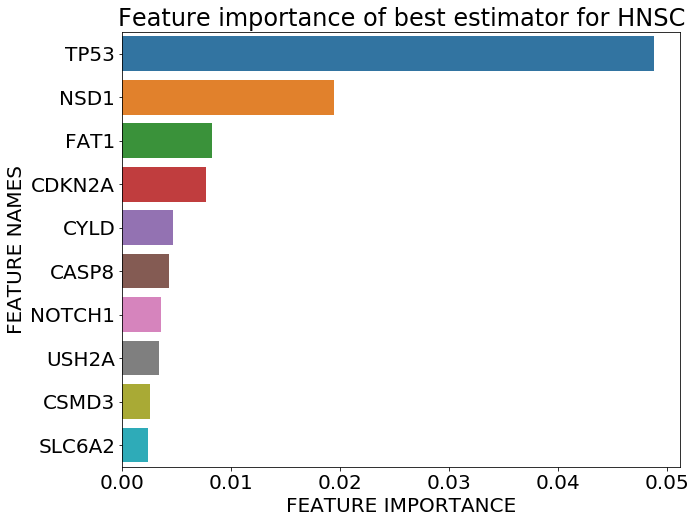

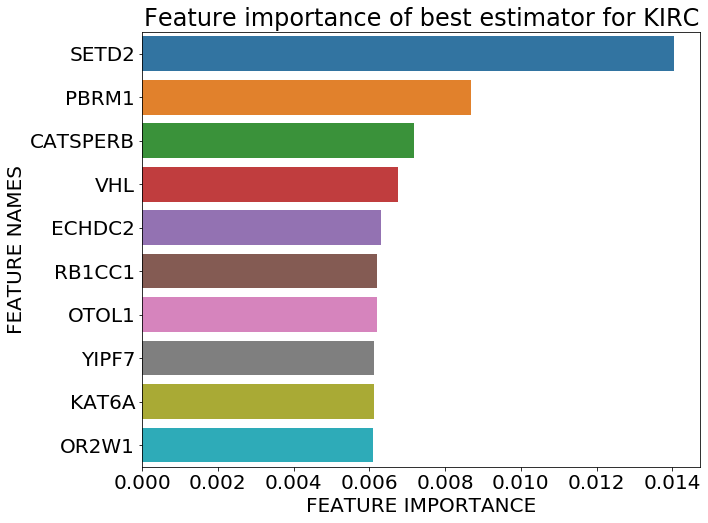

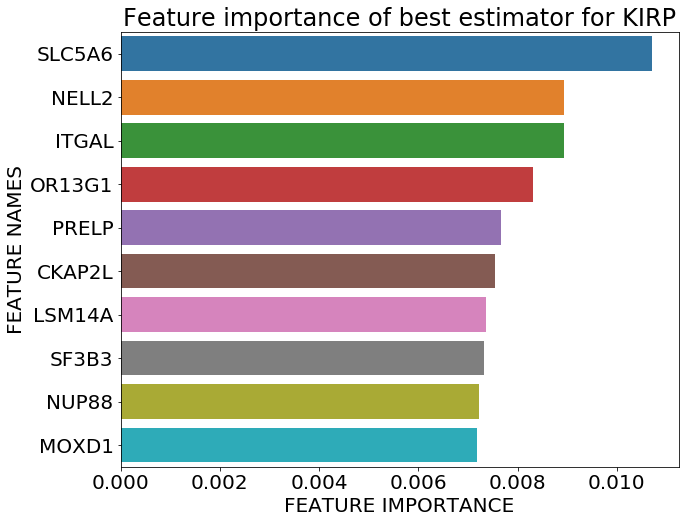

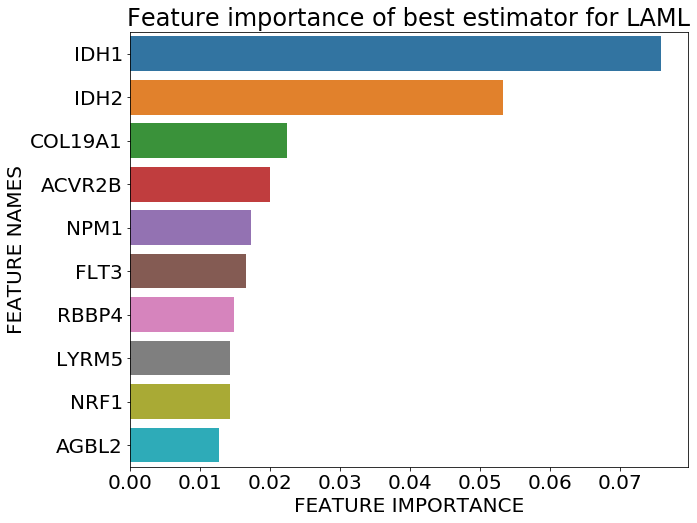

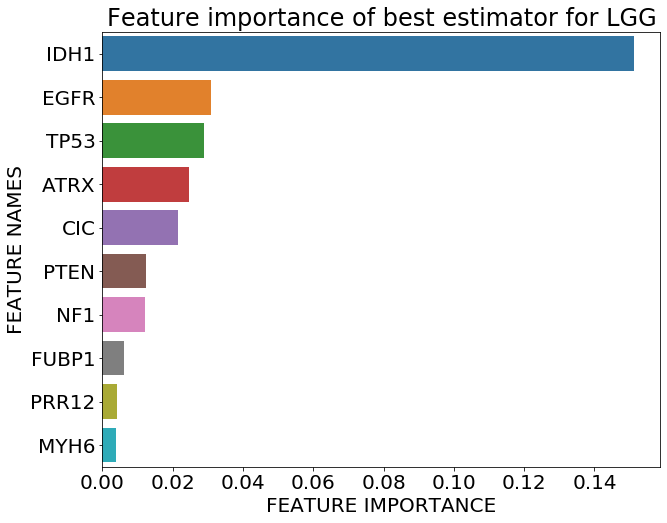

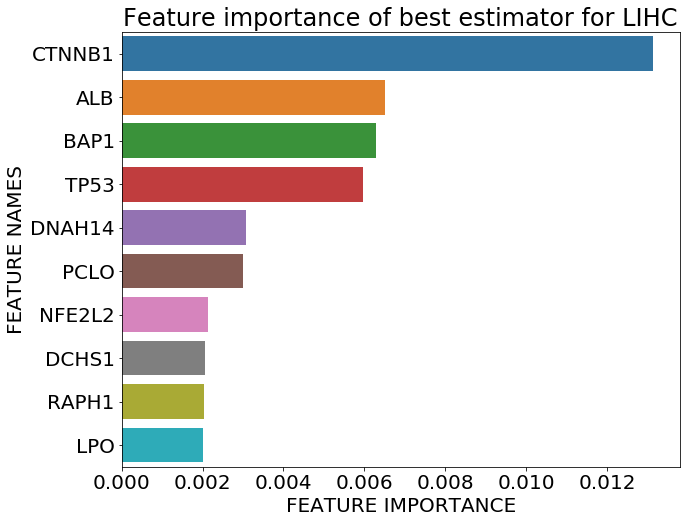

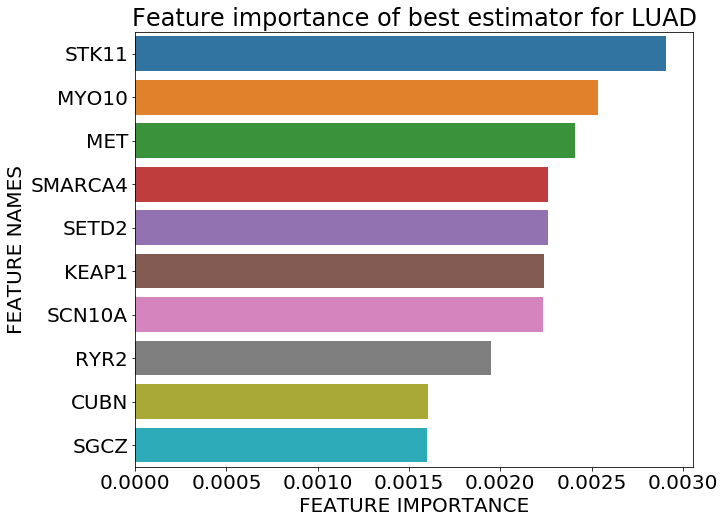

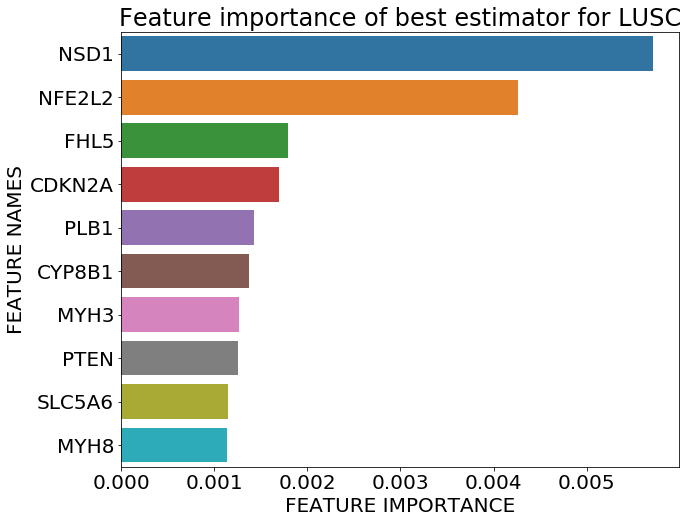

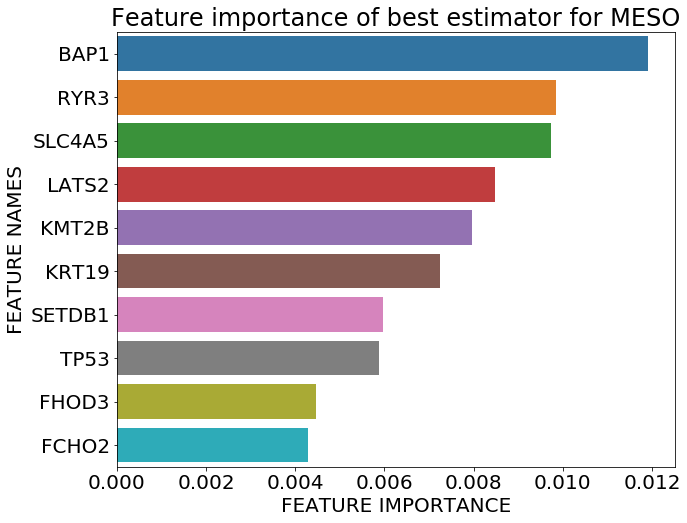

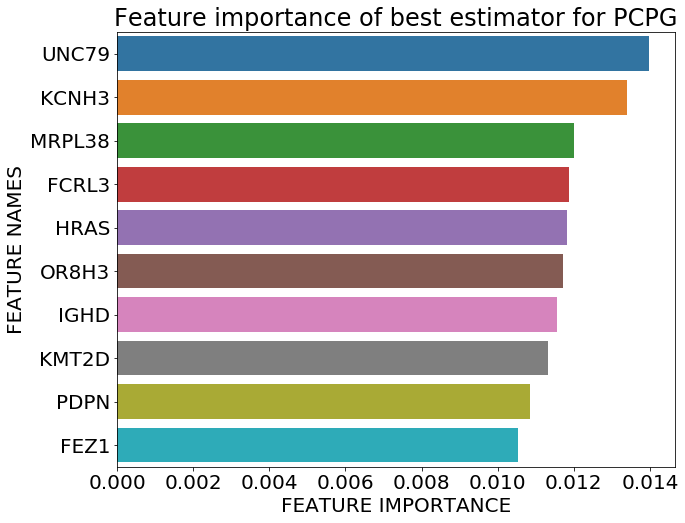

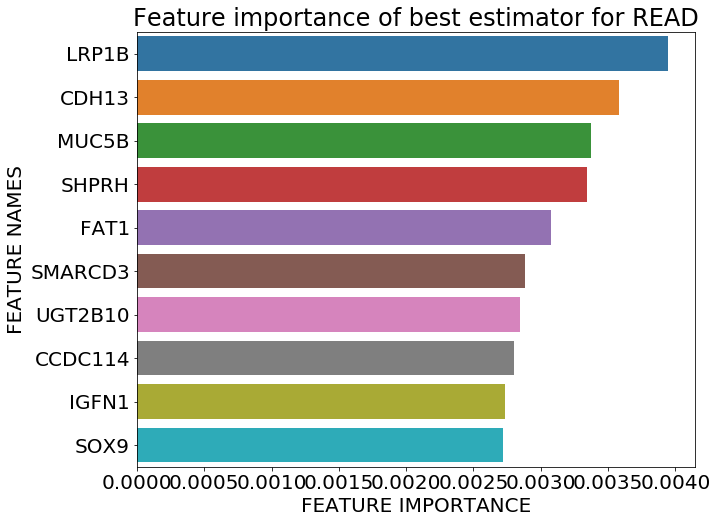

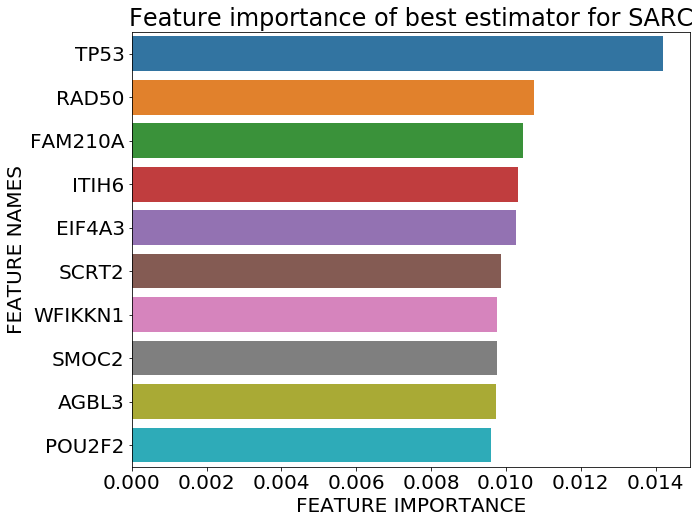

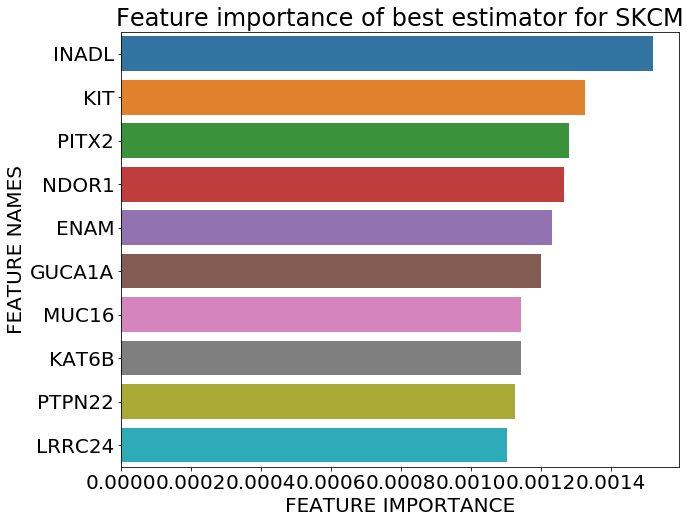

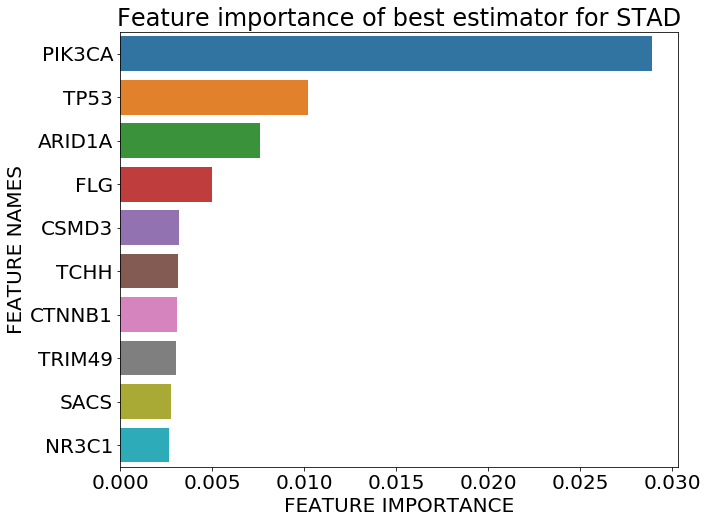

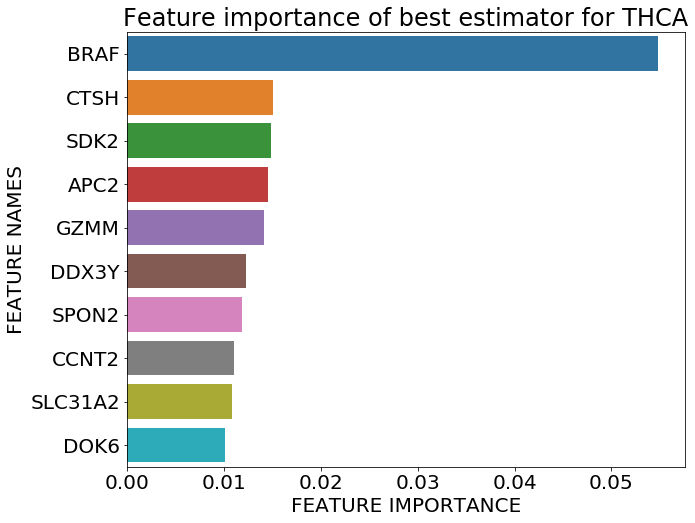

In [233]:
common_features_pc = {cancer: [] for cancer in sorted(CIMP_cancers)}
RF_models = {cancer: [] for cancer in sorted(CIMP_cancers)}
RF_scores = {cancer: [] for cancer in sorted(CIMP_cancers)}

for cancer in tqdm(sorted(CIMP_cancers)):
    RF_models[cancer],common_features_pc[cancer],RF_scores[cancer] = plot_important_features_RF(mut_pancan,cancer,consensus_clustering_spectral,10)

In [236]:
# Scores of RF
cancer_RF_selected = [cancer for (cancer,val) in RF_scores.items() if val>0]
cancer_RF_selected = [cancer for cancer in cancer_RF_selected if len(common_features_pc[cancer])>0]
val_RF_selected = [RF_scores[cancer] for cancer in cancer_RF_selected]
np.mean(val_RF_selected),np.quantile(val_RF_selected,0.25), np.quantile(val_RF_selected,0.75)

(0.2697090522449374, 0.08712121212121217, 0.3166666666666666)

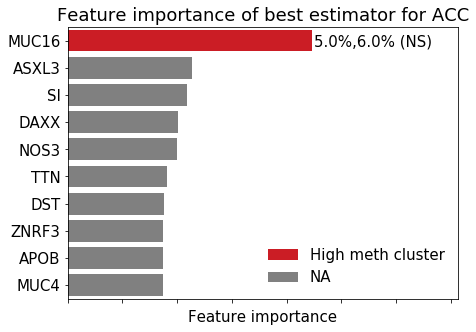

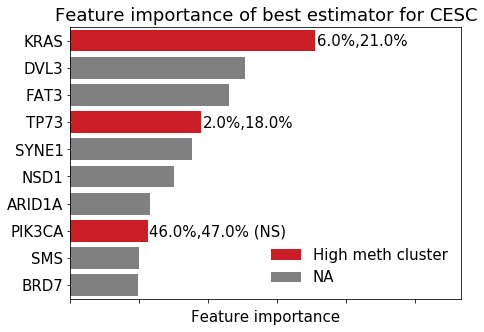

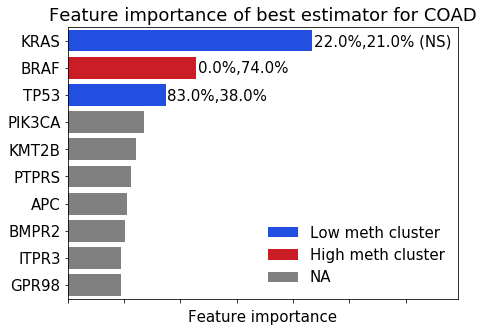

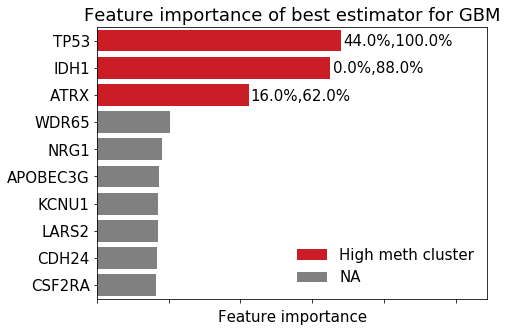

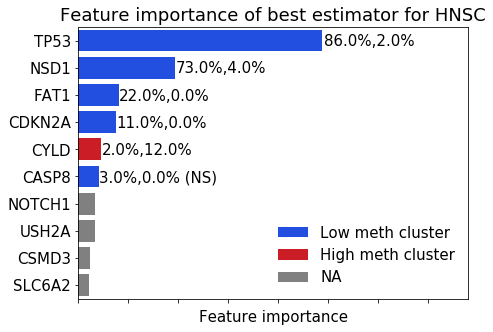

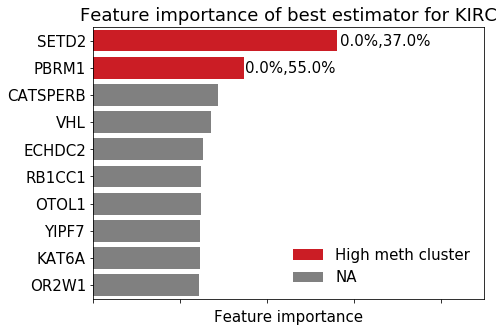

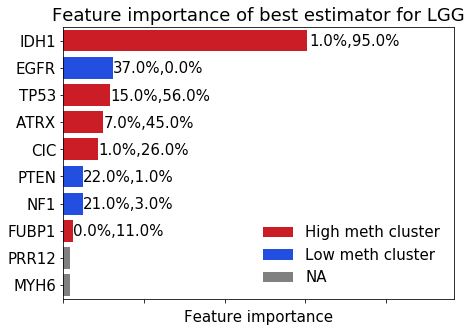

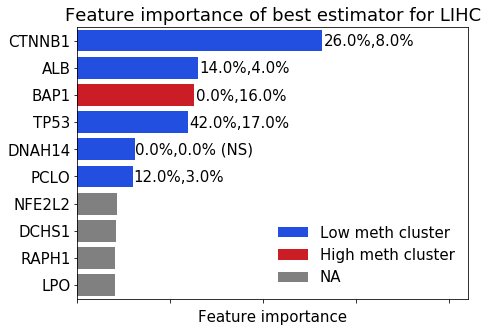

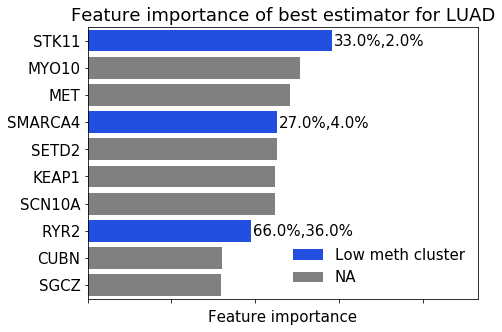

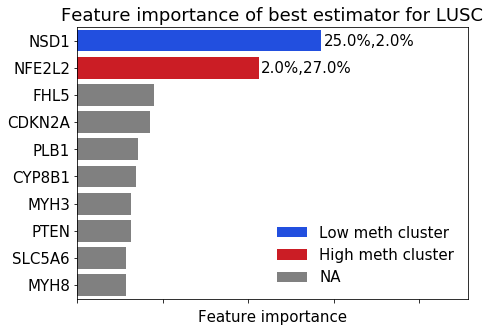

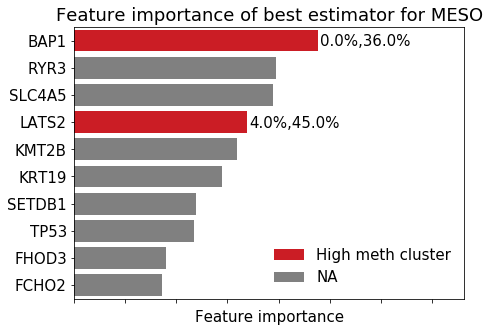

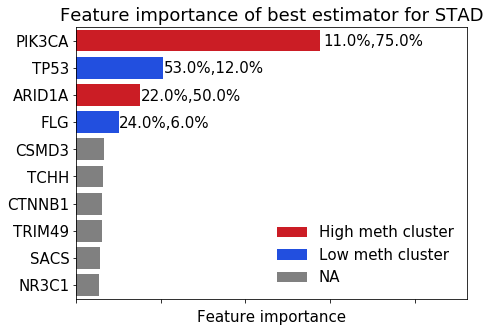

In [242]:
plt.rc('font', size=15)
# to create plots for cancer types that fit the selection criteria
for cancer in tqdm(cancer_RF_selected+["STAD"]):   
    best_estimator = RF_models[cancer]
    X = mut_pancan[cancer]
    # remove columns with all 0
    X = X.replace({0: np.nan}).dropna(axis=1,how="all").replace({np.nan: 0})
    y = consensus_clustering_spectral[cancer]
    common_pat = X.index.intersection(y.index)
    X = X.loc[common_pat]
    y = y.loc[common_pat].values.ravel()
    # select only the features persistently selected
    mut_exp = X.iloc[:,common_features_pc[cancer]]
    common_pat_clustering = consensus_clustering_spectral[cancer].loc[consensus_clustering_spectral[cancer].index.intersection(mut_pancan[cancer].index)]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    if cancer in triple_cluster_cancers_aff:
        ind_cl_2 = ind_cl_3
    cl1_gex = mut_exp.loc[ind_cl_1]
    cl2_gex = mut_exp.loc[ind_cl_2]
    perc_cl1 = cl1_gex.sum()/len(ind_cl_1)*100
    perc_cl2 = cl2_gex.sum()/len(ind_cl_2)*100
    
    # check if the enrichment is in the low or high methylated meth cluster
    diff_mask = perc_cl1<perc_cl2
    fisher_p = []
    # check significance of enrichment through corrected Fisher p
    for gene in cl1_gex.columns:
        fisher_p.append(fisher_exact(np.array([[cl1_gex[gene].sum(),cl2_gex[gene].sum()],[cl1_gex.shape[0]-cl1_gex[gene].sum(),cl2_gex.shape[0]-cl2_gex[gene].sum()]]))[1])
    bh_p = multipletests(fisher_p,alpha=0.1)[1]
    
    # seaborn representation
    df = pd.DataFrame(np.transpose([best_estimator.feature_importances_[np.argsort(best_estimator.feature_importances_)[::-1][:10]],
                           list(X.columns[np.argsort(best_estimator.feature_importances_)[::-1][:10]])]),
             columns=["feature_imp","gene"])
    df = df.set_index("gene")
    df = pd.concat([df,diff_mask],axis=1).replace({False: "Low meth cluster", True: "High meth cluster", np.nan: "NA"})
    df = pd.concat([df,pd.DataFrame(bh_p,index=cl1_gex.columns,columns=["p"])],axis=1).reset_index()
    df.columns = ["gene","Features importance","Cluster enriched","BH p"]
    df["Features importance"] = df["Features importance"].astype(float)
    plt.figure(figsize=(7,5))
    seapal = sns.color_palette("bright")
    
    ax = sns.barplot(data=df,x="Features importance",y="gene",hue="Cluster enriched",dodge=False,palette={"Low meth cluster": seapal[0], "High meth cluster": seapal[3], "NA": "grey"})
    plt.legend(frameon=False)
    feat_max = np.max(df["Features importance"].values.ravel())
    for i in range(df["gene"].shape[0]):
        feature = df["gene"].iloc[i]
        pos = df["Features importance"].iloc[i]
        sign = "" if df["BH p"].iloc[i]<0.11 else " (NS)"
        if feature in list(perc_cl1.index):
            ax.text(1.01*pos,i+0.2,str(np.round(perc_cl1.loc[feature],0))+"%,"+str(np.round(perc_cl2.loc[feature],0))+"%"+sign)
    plt.title('Feature importance of best estimator for '+cancer)
    ax.set_xlim([0,1.6*feat_max])
    ax.set_xticklabels([])
    plt.xlabel('Feature importance')
    plt.ylabel('')
    ax.figure.savefig("RF_"+cancer+".svg",bbox_inches="tight")

#### Visual representation

In [96]:
genes_rf = {"TP53": 5, "KRAS": 2, "TP73": 1, 
            "PIK3CA": 2, "PTEN": 1, "NF1": 1, 
            "IDH1": 2, "NSD1": 2, "SETD2": 1,
            "ATRX": 2, "ARID1A": 1, "PBRM1": 1, "SMARCA4": 1, 
            "BAP1": 2,  
            "ALB": 1, "BRAF": 1, "CIC": 1, "CTNNB1": 1, "EGFR": 1, "FUBP1": 1, "LATS2": 1, "MUC16": 1, "NFE2L2": 1, "PCLO": 1, "RYR2": 1, "STK11": 1}

genes_rf_pd = pd.DataFrame.from_dict(genes_rf, orient="index").reset_index()
genes_rf_pd.columns = ["gene","count"]

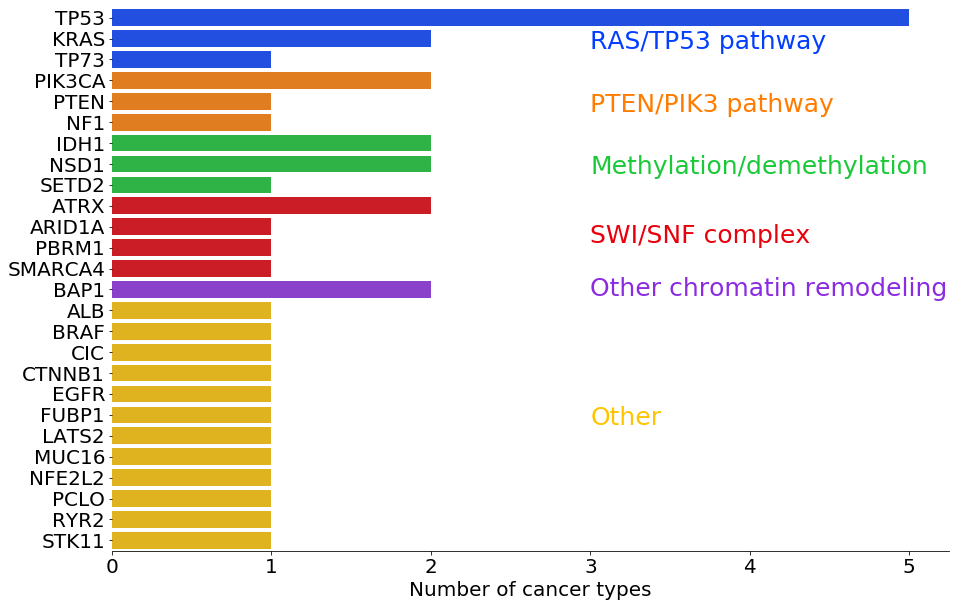

In [131]:
seapal = sns.color_palette("bright")
plt.rc("font", size=20)
fig,ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(data=genes_rf_pd,x="count",y="gene",
            palette=[seapal[0]]*3+[seapal[1]]*3+[seapal[2]]*3+[seapal[3]]*4+[seapal[4]]+[seapal[8]]*12)
ax.set_xlabel("Number of cancer types")
ax.set_ylabel("")
ax.text(3, 1.5, "RAS/TP53 pathway", color=seapal[0], fontsize=25)
ax.text(3, 4.5, "PTEN/PIK3 pathway", color=seapal[1], fontsize=25)
ax.text(3, 7.5, "Methylation/demethylation", color=seapal[2], fontsize=25)
ax.text(3, 10.8, "SWI/SNF complex", color=seapal[3], fontsize=25)
ax.text(3, 13.3, "Other chromatin remodeling", color=seapal[4], fontsize=25)
ax.text(3, 19.5, "Other", color=seapal[8], fontsize=25)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig("RF_selected_genes_viz.png",bbox_inches="tight")
fig.savefig("RF_selected_genes_viz.svg",bbox_inches="tight")

#### Visualization

In [107]:
david_path = {"Nervous system function": 5, "Cell adhesion": 3, "Proximal/distal pattern formation": 2, 
             "Cancer pathways": 2, "Other": 1}

david_path_pd = pd.DataFrame.from_dict(david_path, orient="index").reset_index()
david_path_pd.columns = ["Pathway","count"]

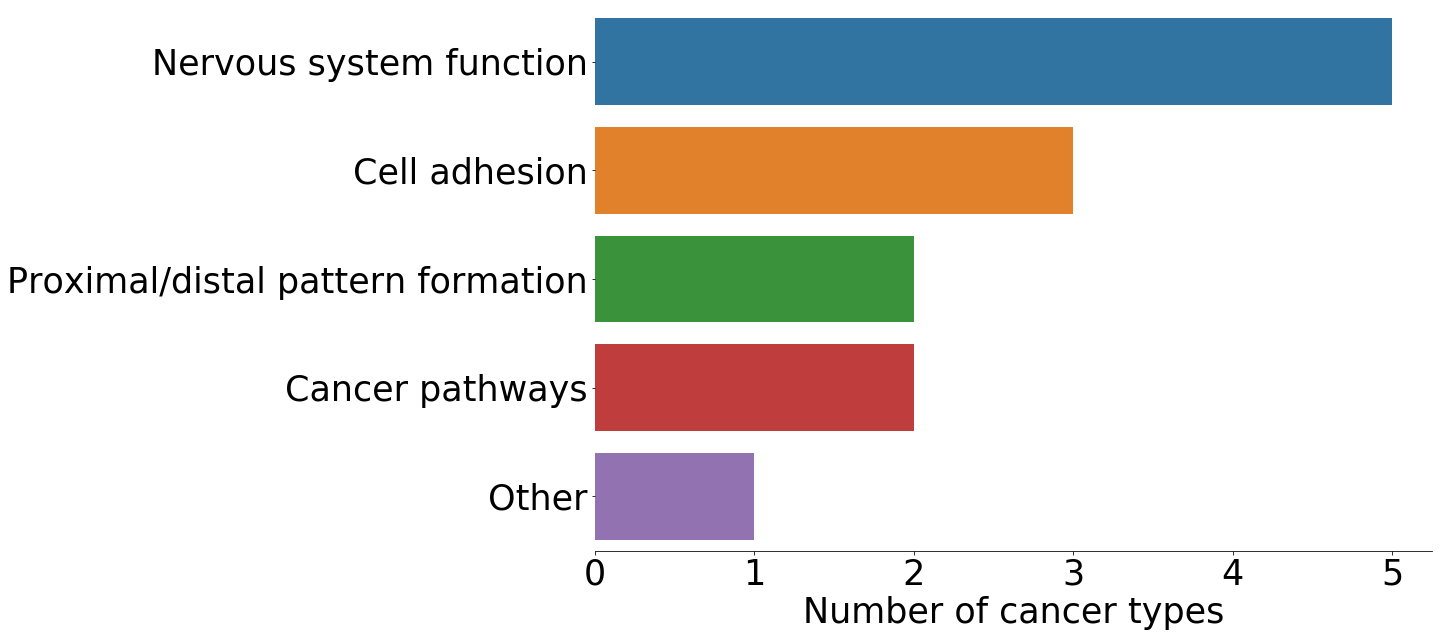

In [112]:
seapal = sns.color_palette("bright")
plt.rc("font", size=35)
fig,ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(data=david_path_pd,x="count",y="Pathway")
ax.set_xlabel("Number of cancer types")
ax.set_ylabel("")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig("DAVID_viz.png",bbox_inches="tight")
fig.savefig("DAVID_viz.svg",bbox_inches="tight")

# CIMP score vs mutation

We compute the continuous CIMP score as the average of beta values over all significantly differentially expressed positions for each cancer type

In [222]:
CIMPness = {}
for cancer in tqdm(sorted(CIMP_cancers)):
    CIMPness[cancer] = new_meth_data_pc[cancer][sign_pos_spectral[cancer].values.ravel()].T.mean().sort_values()

In [223]:
# these are the mutations that were significantly enriched either in the GOI (meth/demeth) or using the RF classifiers
mutations_to_test = {"ACC": ["KMT2A","MUC16"],
                     "BLCA": ["KMT2C", "KMT2D","KDM6A","FGFR3","RB1","STAG2"],
                    "BRCA": ["CDH1","PIK3CA","TP53","GATA3"],
                    "CESC": ["KMT2D","KMT2B","NSD1","TP73","KRAS","PIK3CA"],
                    "COAD": ["ASH1L","EHMT1", "EHMT2", "KMT2A","KMT2B","KMT2C","KMT2D","MECOM","NSD1","PRDM1","PRDM2","PRDM9","PRDM10","PRDM13","PRDM14","PRDM15","PRDM16","SETD1A","SETD1B","SETD2","SETDB1","BAZ2A","DNMT1","UHRF1BP1L","TET1","TET2","TET3","MBD1","APOBEC1","CTCF","KDM2B","KDM3B","KDM4A","KDM4B","KDM4C","KDM5A","KDM5B","KDM5C","KDM6A","KDM6B","PHF2","BRAF","KRAS","TP53"],
                    "ESCA": ["LAMA1","NFE2L2"],
                    "GBM": ["IDH1","KMT2C","TP53","ATRX"],
                    "HNSC": ["NSD1","PRDM9","TP53","CDKN2A","FAT1","CYLD","CASP8"],
                     "KIRC": ["SETD2","PBRM1"],
                     "KIRP": [],
                    "LAML": ["IDH2","IDH1","TET2","DNMT3A","FLT3","NPM1","CEBPA"],
                    "LGG": ["IDH1","ATRX","EGFR","CIC","FUBP1","TP53","NF1","PTEN"],
                     "LIHC": ["CTNNB1","BAP1","PCLO","ALB","TP53"],
                     "LUAD": ["STK11","SMARCA4","RYR2","SETD2"],
                     "LUSC": ["NSD1","NFE2L2"],
                    "MESO": ["KMT2B", "SETD2", "SETDB1","BAP1","LATS2"],
                     "PAAD": ["KMT2C","KRAS","TP53","CDKN2A","RNF43","SMAD4"],
                     "PCPG": [],
                     "PRAD": ["TP53"],
                     "READ": [],
                     "SARC": ["TP53","RB1"],
                    "SKCM": ["IDH1","ANK1"],
                    "STAD": ["KMT2D","ARID1A","PIK3CA","TP53"],
                    "THYM": ["HRAS","GTF2I","TTN"],
                     "THCA": [],
                    "UCEC": ["ARID1A","ASH1L","DOT1L", "EHMT1", "EHMT2", "EZH2","KMT2A","KMT2B","KMT2C","KMT2D","NSD1","PRDM2","PRDM4","PRDM5","PRDM9","PRDM11","PRDM14","PRDM15","PRDM16","SETD1B","SETD2","SETDB1","SMYD1","SUV39H1","SUV420H1","WHSC1L1","BAZ2A","CTCFL","DNMT1","DNMT3A","DNMT3B","UHRFBP1","UHRF1BP1L","TET1","TET2","TET3","TDG","MBD1","MBD4","CTCF","IDH1","IDH2","JMJD1C","KDM2A","KDM2B","KDM3A","KDM3B","KDM4A","KDM4B","KDM4C","KDM5A","KDM5B","KDM5C","KDM6A","KDM6B","PHF2","PHF8","PTEN","TP53","CTNNB1","KRAS","PPP2R1A"]}

In [224]:
mutations_to_test_CIMP = {cancer: mutations_to_test[cancer] for cancer in CIMP_cancers}

In [225]:
# to test per gene and not per cancer
invert_mutations_to_test = {}
for key, val in mutations_to_test_CIMP.items():
    for mut in val:
        if mut in list(invert_mutations_to_test.keys()):
            invert_mutations_to_test[mut].append(key)
        else:
            invert_mutations_to_test[mut] = [key]

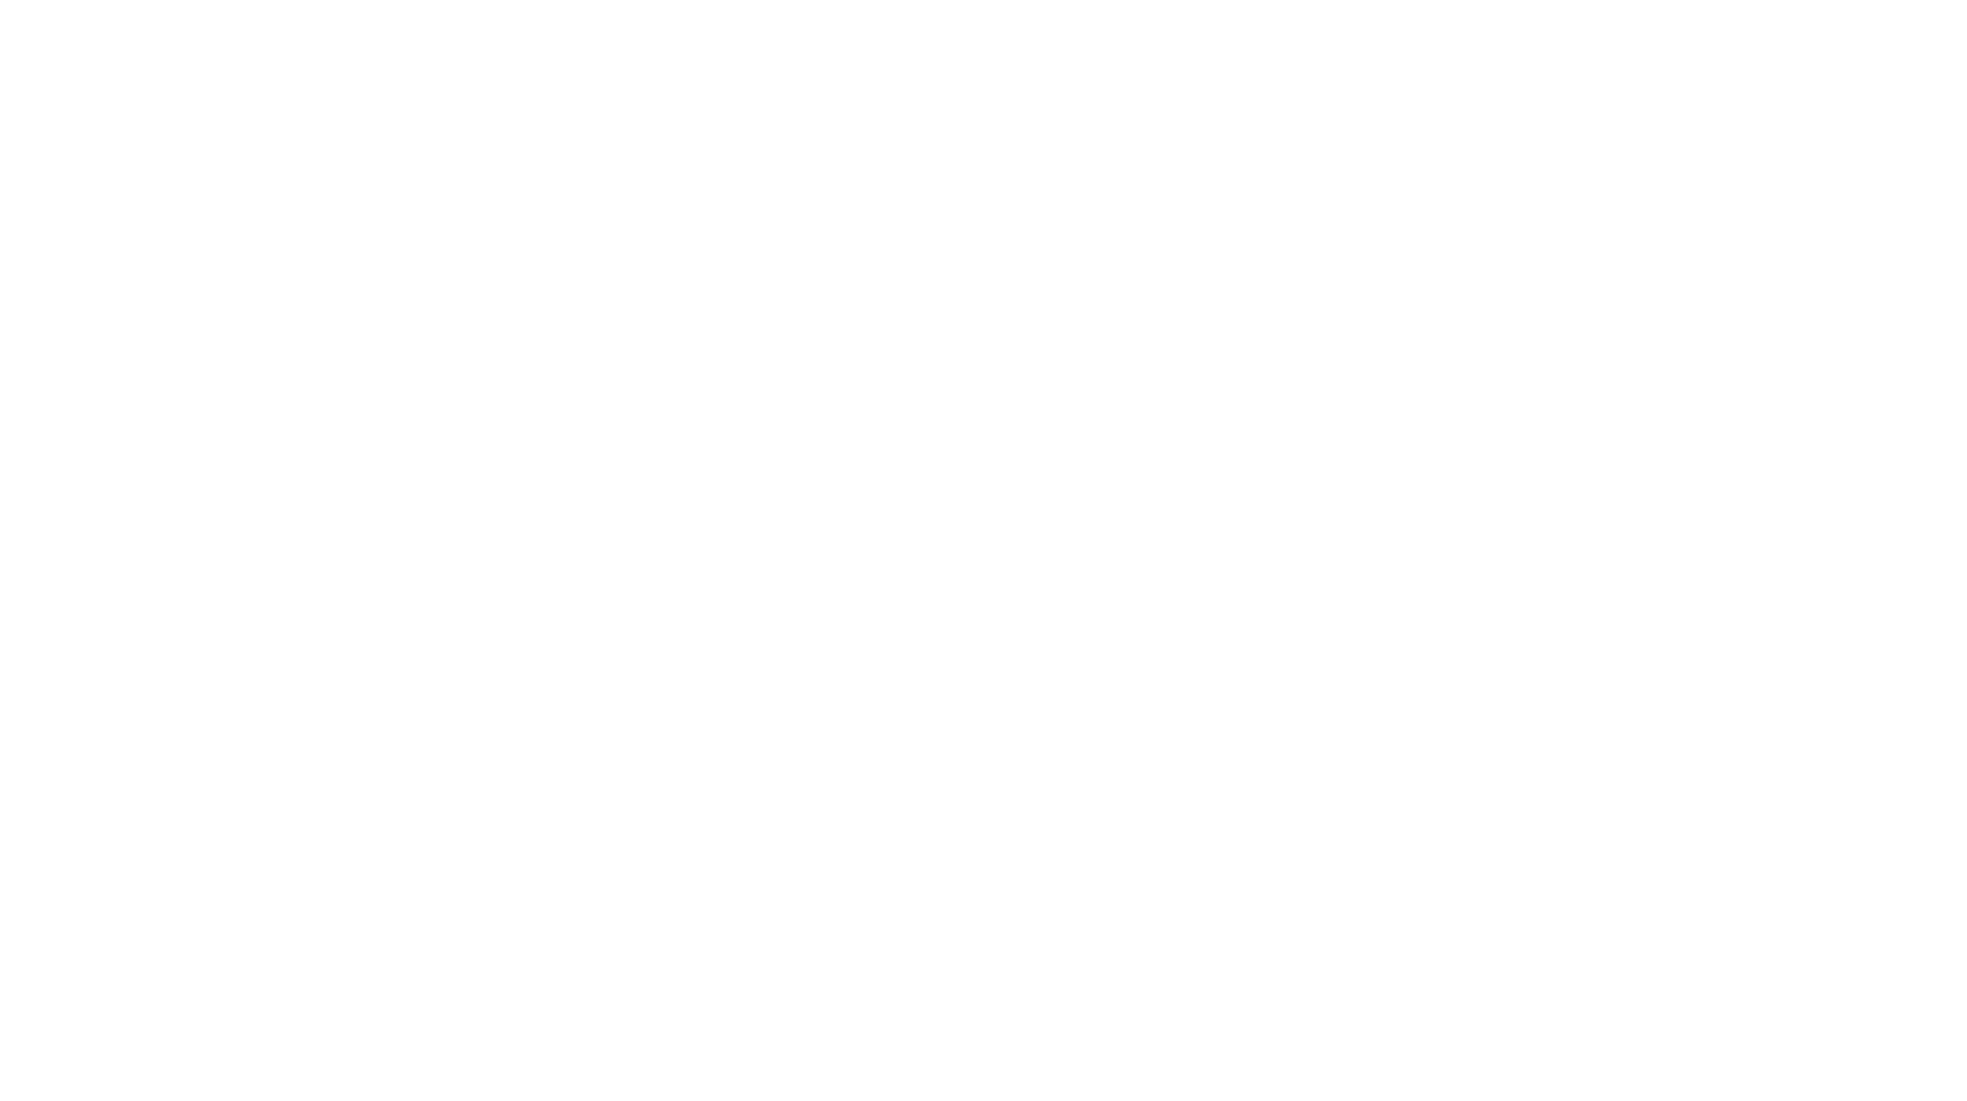

In [226]:
fig, axs = plt.subplots(12, 9, figsize=(35,20))
for a in axs.flatten():
    a.axis("off")

In [227]:
# compute the point biserial correlation between the CIMP score and a mutation
flatax = axs.flatten()
fignum = 0
for j,mut in tqdm(enumerate(sorted(invert_mutations_to_test))):
    for i,cancer in enumerate(invert_mutations_to_test[mut]):
        common_pat = CIMPness[cancer].index.intersection(mut_pancan[cancer].index)
        common_pat = common_pat.intersection(high_conf_patients[cancer])
        X = CIMPness[cancer].loc[common_pat].values.ravel()
        y = mut_pancan[cancer].loc[common_pat][mut].values.ravel()
        corr,p = pointbiserialr(y,X)
        print(cancer,mut,corr)
        if p<0.05:
            yhm = mut_pancan[cancer].loc[common_pat][mut].replace({0: 1, 1: 0}).values.ravel().reshape(-1,1)
            sns.heatmap(yhm.T,yticklabels=False,xticklabels=False,cbar=False,ax=flatax[fignum])
            flatax[fignum].set_title(mut+" in "+cancer+"\n r="+str(round(corr,2)),fontsize=25)
            fignum+=1
        else:
            yhm = mut_pancan[cancer].loc[common_pat][mut].replace({0: 1, 1: 0}).values.ravel().reshape(-1,1)
            sns.heatmap(yhm.T,yticklabels=False,xticklabels=False,cbar=False,ax=flatax[fignum])
            flatax[fignum].set_title(mut+" in "+cancer+"\n r="+str(round(corr,2))+"(NS)",fontsize=25)
            fignum+=1

LIHC ALB -0.10217728208714605
SKCM ANK1 -0.1049387702581469
COAD APOBEC1 0.19850443246631855
STAD ARID1A 0.3417231448115395
COAD ASH1L 0.3233396622658916
GBM ATRX -0.06579750256270403
LGG ATRX 0.24074031498274612
MESO BAP1 0.24616916119418875
LIHC BAP1 0.26656194730718774
COAD BAZ2A 0.2541204676055497
COAD BRAF 0.5631707228779828
HNSC CASP8 0.09690443128238144
HNSC CDKN2A 0.019859320903856205
LAML CEBPA 0.24355744586830277
LGG CIC 0.24970465721298174
COAD CTCF 0.12092559866891527
LIHC CTNNB1 -0.15086228121342043
HNSC CYLD 0.046786384809581597
COAD DNMT1 0.23158293253378884
LAML DNMT3A -0.22066492494221268
LGG EGFR -0.45858379997928067
COAD EHMT1 0.16551330911549064
COAD EHMT2 0.15778048286991098
HNSC FAT1 0.020387380895516498
LAML FLT3 -0.17198656347824212
LGG FUBP1 0.17254694786374522
LAML IDH1 0.43652424178029325
GBM IDH1 0.199141415160633
SKCM IDH1 0.1464177262037524
LGG IDH1 0.7375346779520849
LAML IDH2 0.4526444977171841
COAD KDM2B 0.25615788252441196
COAD KDM3B 0.1325504842665425

In [228]:
ax = flatax[-1]
ax.axis("on")
ax.set_xlabel("CIMP score",fontsize=25)
ax.set_xticks([0,1])
ax.set_xticklabels(["Min score","Max score"],rotation=0,rotation_mode="default")
ax.set_ylabel("Mut",fontsize=25)
ax.set_yticks([])
fig.tight_layout()

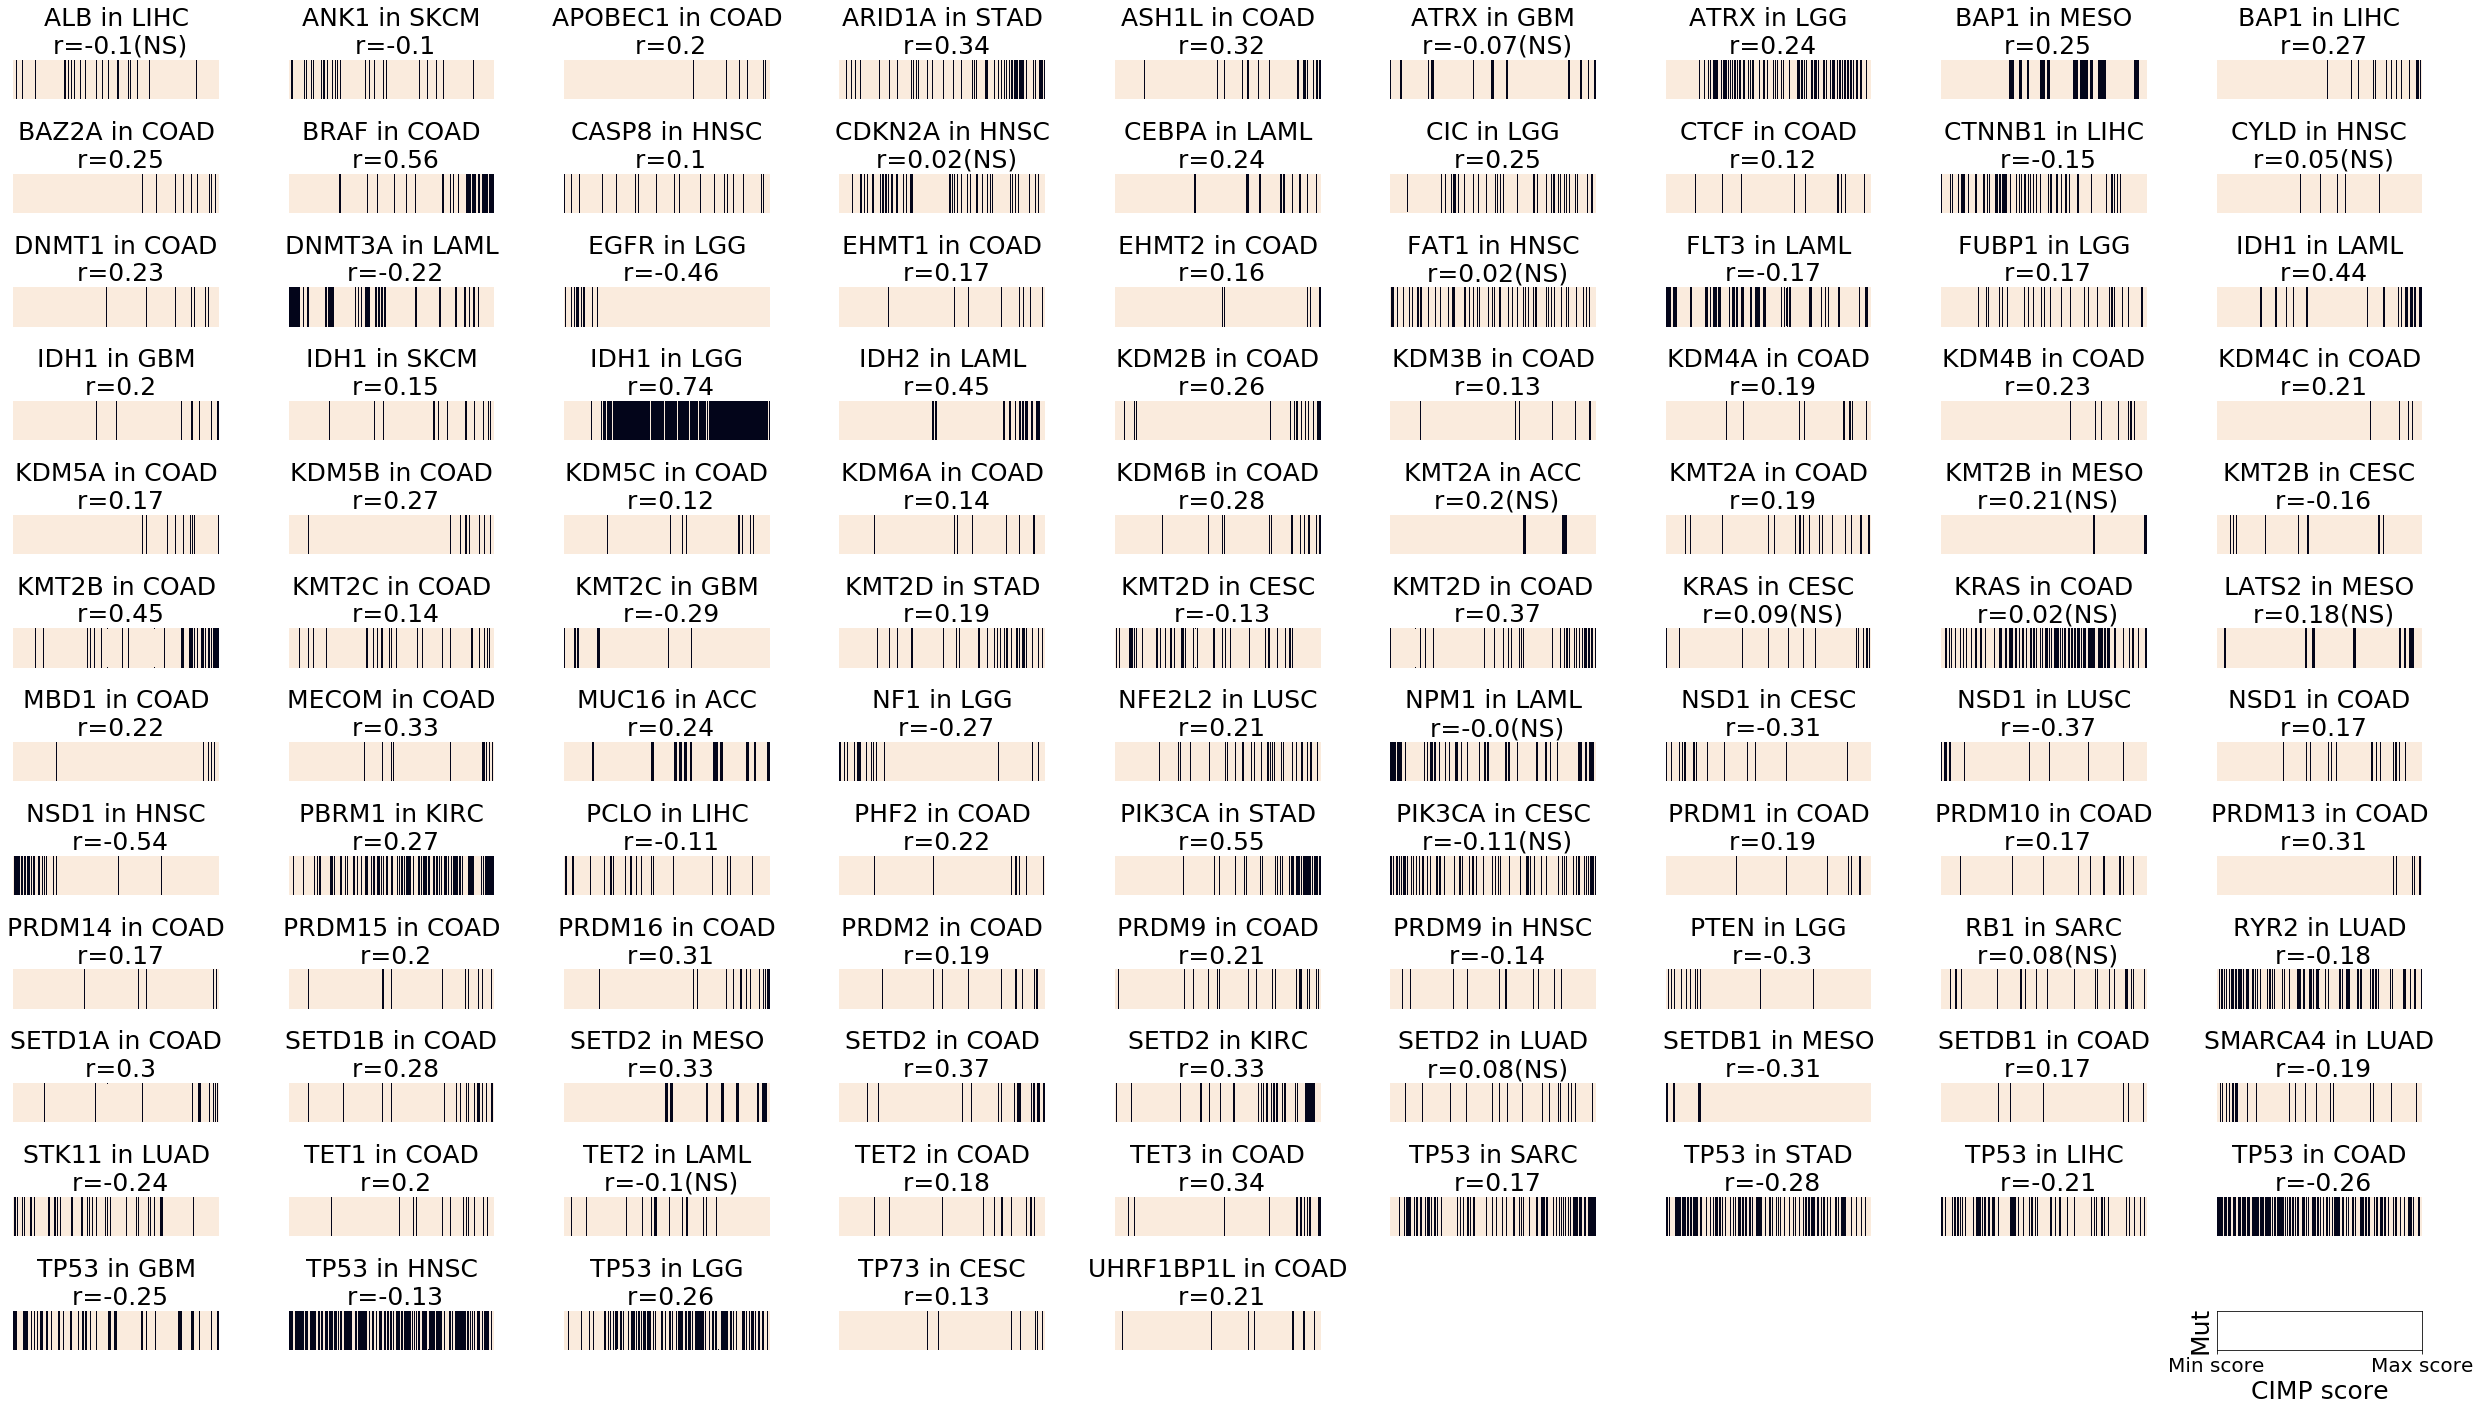

In [229]:
fig

In [230]:
fig.savefig("mutation_vs_CIMP_score.png",bbox_inches="tight")
fig.savefig("mutation_vs_CIMP_score.svg",bbox_inches="tight")

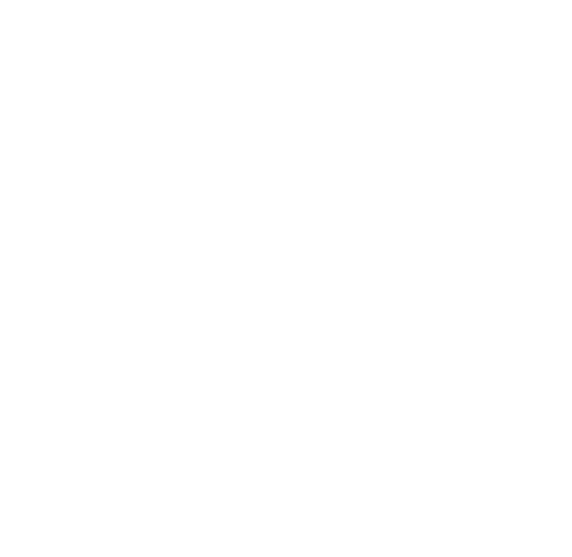

In [151]:
fig, axs = plt.subplots(8, 3, figsize=(10,10))
for a in axs.flatten():
    a.axis("off")

In [152]:
# identical as before, with only strongly positively correlated mutations
flatax = axs.flatten()
fignum = 0
for j,mut in tqdm(enumerate(sorted(invert_mutations_to_test))):
    for i,cancer in enumerate(invert_mutations_to_test[mut]):
        common_pat = CIMPness[cancer].index.intersection(mut_pancan[cancer].index)
        X = CIMPness[cancer].loc[common_pat].values.ravel()
        y = mut_pancan[cancer].loc[common_pat][mut].values.ravel()
        corr,p = pointbiserialr(y,X)
        if corr>0.26:
            yhm = mut_pancan[cancer].loc[common_pat][mut].replace({0: 1, 1: 0}).values.ravel().reshape(-1,1)
            sns.heatmap(yhm.T,yticklabels=False,xticklabels=False,cbar=False,ax=flatax[fignum])
            flatax[fignum].set_title(mut+" in "+cancer+"\n r="+str(round(corr,2)),fontsize=15)
            fignum+=1

In [153]:
ax = flatax[-1]
ax.axis("on")
ax.set_xlabel("CIMP score")
ax.set_xticks([0,1])
ax.set_xticklabels(["Min score","Max score"],rotation=0,rotation_mode="default")
ax.set_ylabel("Mut")
ax.set_yticks([])
fig.tight_layout()
fig.tight_layout()

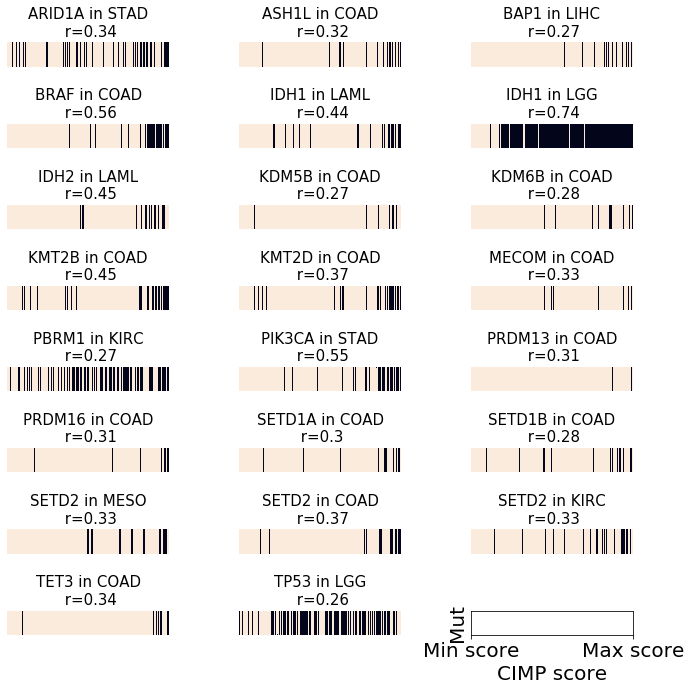

In [154]:
fig

In [155]:
fig.savefig("mutation_vs_CIMP_score_highcorr.png",bbox_inches="tight")
fig.savefig("mutation_vs_CIMP_score_highcorr.svg",bbox_inches="tight")

In [47]:
gene_cancer_mapping = {"IDH1": ["GBM","LAML", "LGG","SKCM"], "SETD2": ["COAD","KIRC","MESO"]}
nsd1_mapping = ["CESC","COAD","HNSC","LUSC"]

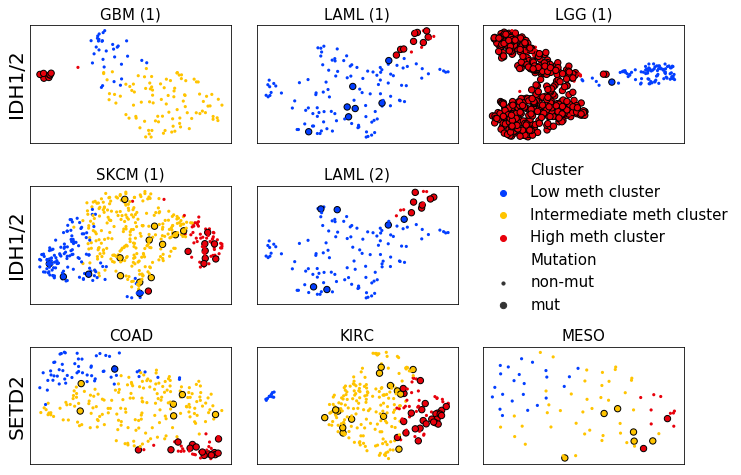

In [48]:
plt.rc("font",size=20)
seapal = sns.color_palette("bright")
fig, ax = plt.subplots(3,3,figsize=(10,7))
flatax = ax.flatten()
fignum=0
size_plot = {"mut": 40, "non-mut": 10}

for gene in gene_cancer_mapping.keys():
    for cancer in gene_cancer_mapping[gene]:
        if fignum==4:
            fignum+=2
        df = pd.concat([df_umap_spectral[cancer],mut_pancan[cancer][gene].replace({0: "non-mut",1: "mut"})],axis=1,join="inner")
        df.columns = np.append(df_umap_spectral[cancer].columns,["Mutation"])
        edgecolor_list = df["Mutation"].replace({"non-mut": "white", "mut": "black"}).values
        linewidth_list = df["Mutation"].replace({"non-mut": 0, "mut": 1}).values
          
        sns.scatterplot(data=df,x="Comp1",y="Comp2",hue="Cluster",size="Mutation",
                        sizes=size_plot,ax=flatax[fignum],legend="auto",
                        palette={"Low meth cluster": seapal[0], "High meth cluster": seapal[3],"Intermediate meth cluster": seapal[8]},
                       edgecolor=edgecolor_list,linewidth=linewidth_list)
        if fignum in range(4):
            flatax[fignum].set_title(cancer+" (1)",fontsize=15)

        else:
            flatax[fignum].set_title(cancer,fontsize=15)
        flatax[fignum].legend().remove()
        flatax[fignum].set_xlabel('')

        if fignum in [0,3]:
            flatax[fignum].set_ylabel("IDH1/2")
        elif fignum==6:
            flatax[fignum].set_ylabel(str(gene))
        else:
            flatax[fignum].set_ylabel('')
        flatax[fignum].set_xticks([])
        flatax[fignum].set_yticks([])
        fignum+=1

# special IDH2 case
df = pd.concat([df_umap_spectral["LAML"],mut_pancan["LAML"]["IDH2"].replace({0: "non-mut",1: "mut"})],axis=1,join="inner")
df.columns = np.append(df_umap_spectral["LAML"].columns,["Mutation"])
edgecolor_list = df["Mutation"].replace({"non-mut": "white", "mut": "black"}).values
linewidth_list = df["Mutation"].replace({"non-mut": 0, "mut": 1}).values
sns.scatterplot(data=df,x="Comp1",y="Comp2",hue="Cluster",size="Mutation",
                            sizes=size_plot,ax=flatax[4],legend="auto",
                            palette={"Low meth cluster": seapal[0], "High meth cluster": seapal[3],"Intermediate meth cluster": seapal[8]},
                           edgecolor=edgecolor_list,linewidth=linewidth_list)
flatax[4].set_title("LAML (2)",fontsize=15)
flatax[4].legend().remove()
flatax[4].set_xlabel('')
flatax[4].set_ylabel('')
flatax[4].set_xticks([])
flatax[4].set_yticks([])

flatax[5].axis("off")

lines, labels = flatax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'center right', bbox_to_anchor = (0.05,0,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=15,frameon=False)
fig.tight_layout()

In [49]:
fig.savefig("UMAP_mutation_goi.png",bbox_inches="tight")
fig.savefig("UMAP_mutation_goi.svg",bbox_inches="tight")

NSD1


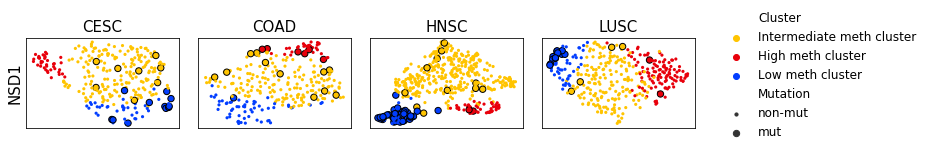

In [68]:
seapal = sns.color_palette("bright")
fig, ax = plt.subplots(1,4,figsize=(10,2))
flatax = ax.flatten()
fignum=8
size_plot = {"mut": 40, "non-mut": 10}

for i,cancer in enumerate(nsd1_mapping):
    df = pd.concat([df_umap_spectral[cancer],mut_pancan[cancer][gene].replace({0: "non-mut",1: "mut"})],axis=1,join="inner")
    df.columns = np.append(df_umap_spectral[cancer].columns,["Mutation"])
    edgecolor_list = df["Mutation"].replace({"non-mut": "white", "mut": "black"}).values
    linewidth_list = df["Mutation"].replace({"non-mut": 0, "mut": 1}).values

    sns.scatterplot(data=df,x="Comp1",y="Comp2",hue="Cluster",size="Mutation",
                        sizes=size_plot,ax=ax[i],legend="auto",
                        palette={"Low meth cluster": seapal[0], "High meth cluster": seapal[3],"Intermediate meth cluster": seapal[8]},
                       edgecolor=edgecolor_list,linewidth=linewidth_list)
    ax[i].set_title(cancer,fontsize=15)
    ax[i].legend().remove()
    ax[i].set_xlabel('')
    if i==0:
        print(gene)
        ax[i].set_ylabel(str(gene))
    else:
        ax[i].set_ylabel('')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
        
lines, labels = flatax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'center right', bbox_to_anchor = (0.3,0.0,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=12,frameon=False)
fig.tight_layout()

In [69]:
fig.savefig("NSD1_mutations.svg",bbox_inches="tight")
fig.savefig("NSD1_mutations.png",bbox_inches="tight")

### CIMP score vs xCell

In [200]:
xcell_comp = pd.read_csv("xCell.txt", delimiter = "\t").set_index("Unnamed: 0")
xcell_comp.columns = xcell_comp.columns.str.replace(".","-")

In [201]:
immune_scores = pd.read_csv("Scores_160_Signatures.tsv.gz", delimiter = "\t")
immune_scores = immune_scores.set_index("SetName").loc[["LIexpression_score","CSF1_response","TGFB_score_21050467","Module3_IFN_score","CHANG_CORE_SERUM_RESPONSE_UP"]]
immune_scores = immune_scores.drop("Source",axis=1).T
immune_scores = immune_scores.reset_index()
immune_scores["index"] = immune_scores["index"].apply(lambda x: x[:15])
immune_scores = immune_scores.set_index("index")
immune_scores = immune_scores[~immune_scores.index.duplicated()]

In [376]:
immune_scores.columns = ["Lymphocyte infiltration","CSF1 response","TGF-beta pathway activation","IFN-gamma response","Wound healing"]

In [203]:
CIBERSORT_comp = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", delimiter = "\t")
CIBERSORT_comp["SampleID"] = CIBERSORT_comp["SampleID"].str.replace(".","-").apply(lambda x: x[:15])
CIBERSORT_comp = CIBERSORT_comp.set_index("SampleID").drop(["CancerType","P.value","Correlation","RMSE"],axis=1)
CIBERSORT_comp.columns = CIBERSORT_comp.columns.str.replace("."," ")
CIBERSORT_comp = CIBERSORT_comp[~CIBERSORT_comp.index.duplicated()]

In [133]:
thorsson_pat_info = pd.read_csv("thorsson_pat_info.txt",sep="\t")
thorsson_pat_info["TCGA Participant Barcode"] = thorsson_pat_info["TCGA Participant Barcode"].apply(lambda x: x+"-01")
thorsson_pat_info = thorsson_pat_info.set_index("TCGA Participant Barcode")

In [425]:
thorsson_corr = thorsson_pat_info[['Leukocyte Fraction',
       'Stromal Fraction', 'Intratumor Heterogeneity',
       'Proliferation', 'Wound Healing', 'Macrophage Regulation',
       'Lymphocyte Infiltration Signature Score',]]
for col in thorsson_corr.columns:
    thorsson_corr[col] = thorsson_corr[col].str.replace(",",".")

C:\Users\josep\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [426]:
thorsson_corr

Leukocyte Fraction Stromal Fraction  \
TCGA Participant Barcode                                       
TCGA-01-0639-01                         NaN              NaN   
TCGA-02-0007-01                 0.047660194              NaN   
TCGA-02-0011-01                 0.062099252              NaN   
TCGA-02-0023-01                         NaN              NaN   
TCGA-02-0025-01                         NaN              NaN   
...                                     ...              ...   
TCGA-ZJ-AAXJ-01                 0.190519869             0.28   
TCGA-ZJ-AB0I-01                 0.059910143              0.1   
TCGA-ZN-A9VU-01                 0.272642345             0.39   
TCGA-ZN-A9VW-01                 0.286224186             0.35   
TCGA-ZX-AA5X-01                 0.365431825             0.63   

                         Intratumor Heterogeneity Proliferation Wound Healing  \
TCGA Participant Barcode                                                        
TCGA-01-0639-01                               NaN           NaN           NaN   
TCGA-02-0007-01                               NaN           NaN           NaN   
TCGA-02-0011-01                               NaN           NaN           NaN   
TCGA-02-0023-01                               NaN           NaN           NaN   
TCGA-02-0025-01                               NaN           NaN           NaN   
...                                           ...           ...           ...   
TCGA-ZJ-AAXJ-01                              0.06        1.0591         0.438   
TCGA-ZJ-AB0I-01                              0.03        0.9968         0.312   
TCGA-ZN-A9VU-01                              0.01       -0.4574        -0.141   
TCGA-ZN-A9VW-01                              0.01        0.4057        0.0475   
TCGA-ZX-AA5X-01                              0.05        0.4389         0.104   

                         Macrophage Regulation  \
TCGA Participant Barcode                         
TCGA-01-0639-01                            NaN   
TCGA-02-0007-01                            NaN   
TCGA-02-0011-01                            NaN   
TCGA-02-0023-01                            NaN   
TCGA-02-0025-01                            NaN   
...                                        ...   
TCGA-ZJ-AAXJ-01                        -0.5428   
TCGA-ZJ-AB0I-01                        -0.5787   
TCGA-ZN-A9VU-01                         0.5686   
TCGA-ZN-A9VW-01                         0.9237   
TCGA-ZX-AA5X-01                         0.4543   

                         Lymphocyte Infiltration Signature Score  
TCGA Participant Barcode                                          
TCGA-01-0639-01                                              NaN  
TCGA-02-0007-01                                              NaN  
TCGA-02-0011-01                                              NaN  
TCGA-02-0023-01                                              NaN  
TCGA-02-0025-01                                              NaN  
...                                                          ...  
TCGA-ZJ-AAXJ-01                                           0.0973  
TCGA-ZJ-AB0I-01                                          -0.7204  
TCGA-ZN-A9VU-01                                           0.5621  
TCGA-ZN-A9VW-01                                            0.324  
TCGA-ZX-AA5X-01                                           0.8754  

[11080 rows x 7 columns]

In [427]:
# immune_sign_pc = pd.DataFrame(columns=xcell_comp.index)
immune_sign_pc,immune_sign_pc_nocorrec = pd.DataFrame(columns=thorsson_corr.columns),pd.DataFrame(columns=thorsson_corr.columns)
  
for cancer in tqdm(sorted(CIMP_cancers)):
    if cancer=="LAML":
        continue
    r_list,p_list = [],[]
    common_pat = immune_scores.index.intersection(new_meth_data_pc[cancer].index)
    cancer_xcell = thorsson_corr.loc[common_pat].astype(float)
    pat_cimp = CIMPness[cancer].loc[common_pat]
    df_comp = pd.concat([cancer_xcell,pat_cimp],axis=1)
    cimp = df_comp.iloc[:,-1].values.ravel()
    for i in range(cancer_xcell.shape[1]):
        comp = df_comp.iloc[:,i].values.ravel()
        r,p = spearmanr(cimp,comp)
        r_list.append(r)
        p_list.append(p)
    corrected_p = multipletests(p_list,method='fdr_bh')
    assoc_bool = corrected_p[0]

    assoc_r = [r_list[i] if assoc else 0 for i,assoc in enumerate(assoc_bool)]

    df = pd.DataFrame(np.array(assoc_r).reshape(1,-1),columns=cancer_xcell.columns,index=[cancer])
    df_nocorrec = pd.DataFrame(np.array(r_list).reshape(1,-1),columns=cancer_xcell.columns,index=[cancer])
    immune_sign_pc = pd.concat([immune_sign_pc,df])
    immune_sign_pc_nocorrec = pd.concat([immune_sign_pc_nocorrec,df_nocorrec])

In [428]:
immune_sign_pc_nocorrec = immune_sign_pc_nocorrec.fillna(0)

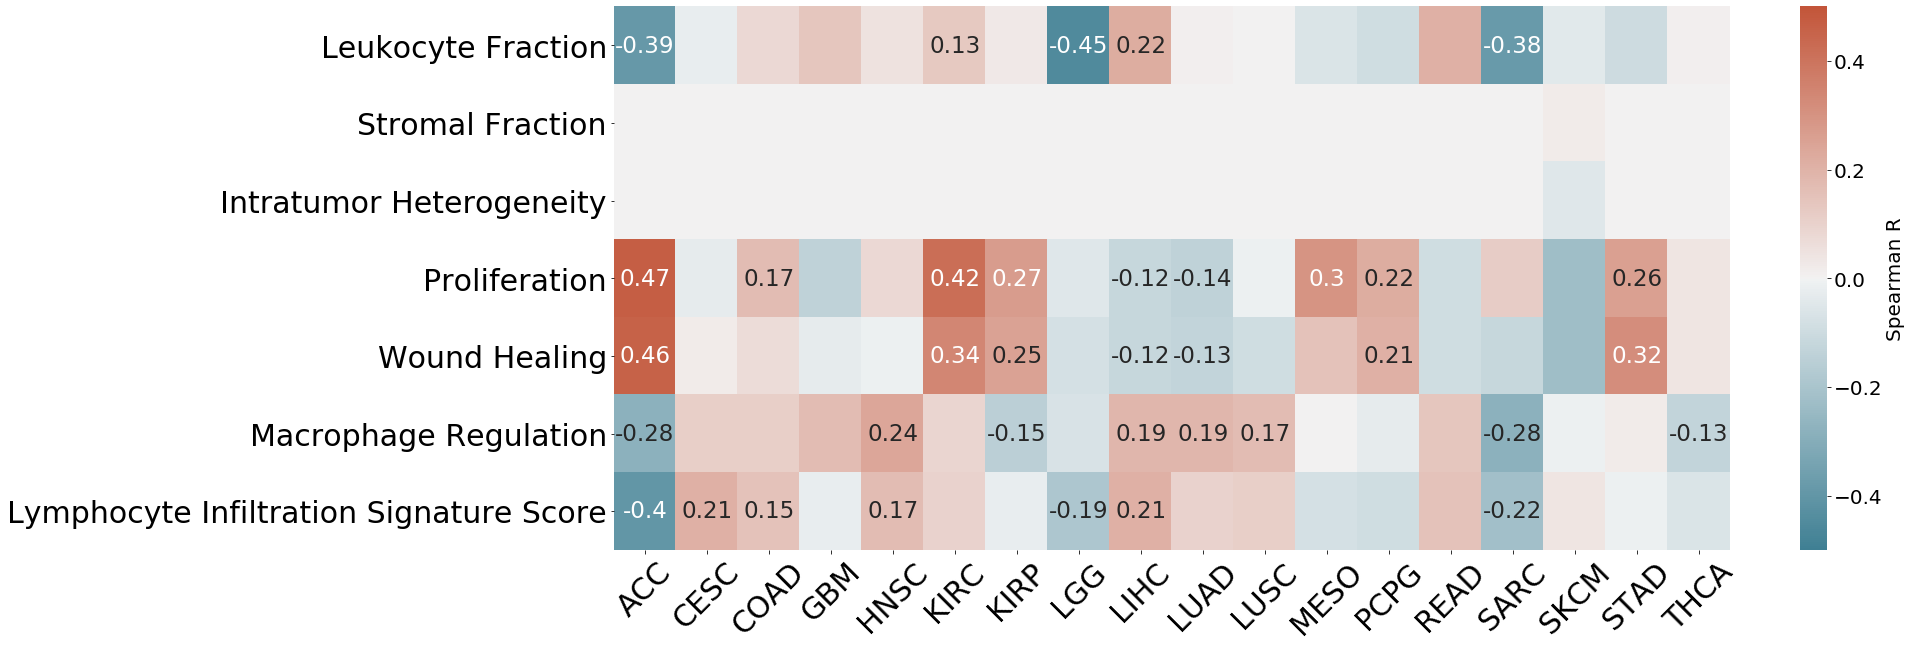

In [546]:
plt.rc("font", size=20)
fig,ax = plt.subplots(figsize=(25,10))
sns.heatmap(immune_sign_pc_nocorrec.T.round(2),center=0,ax=ax,annot=immune_sign_pc.T.round(2).replace(0,'').astype(str).values,
            annot_kws={"fontsize": 23},fmt = '',cbar_kws={'label': 'Spearman R'}, vmin=-0.5, vmax=0.5,
           cmap=sns.diverging_palette(220, 20, as_cmap=True))
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,rotation_mode="default",fontsize=30)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0,rotation_mode="default",fontsize=30)
fig.savefig("immune_score.png",bbox_inches="tight")
fig.savefig("immune_score.svg",bbox_inches="tight")

In [447]:
xcell_pc,xcell_pc_nocorrec = pd.DataFrame(columns=CIBERSORT_comp.columns),pd.DataFrame(columns=CIBERSORT_comp.columns)
  
for cancer in tqdm(sorted(CIMP_cancers)):
    r_list,p_list = [],[]

    common_pat = CIBERSORT_comp.index.intersection(new_meth_data_pc[cancer].index)
    cancer_xcell = CIBERSORT_comp.loc[common_pat]
    pat_cimp = CIMPness[cancer].loc[common_pat]
    df_comp = pd.concat([cancer_xcell,pat_cimp],axis=1)
    cimp = df_comp.iloc[:,-1].values.ravel()
    for i in range(cancer_xcell.shape[1]):
        comp = df_comp.iloc[:,i].values.ravel()
        r,p = spearmanr(cimp,comp)
        if np.isnan(r):
            r,p=0,0
        r_list.append(r)
        p_list.append(p)
    corrected_p = multipletests(p_list,method='fdr_bh')
    assoc_bool = corrected_p[0]

    assoc_r = [r_list[i] if assoc else 0 for i,assoc in enumerate(assoc_bool)]

    df = pd.DataFrame(np.array(assoc_r).reshape(1,-1),columns=cancer_xcell.columns,index=[cancer])
    df_nocorrec = pd.DataFrame(np.array(r_list).reshape(1,-1),columns=cancer_xcell.columns,index=[cancer])
    xcell_pc = pd.concat([xcell_pc,df])
    xcell_pc_nocorrec = pd.concat([xcell_pc_nocorrec,df_nocorrec])

C:\Users\josep\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\josep\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [448]:
xcell_pc_nocorrec = xcell_pc_nocorrec.fillna(0)

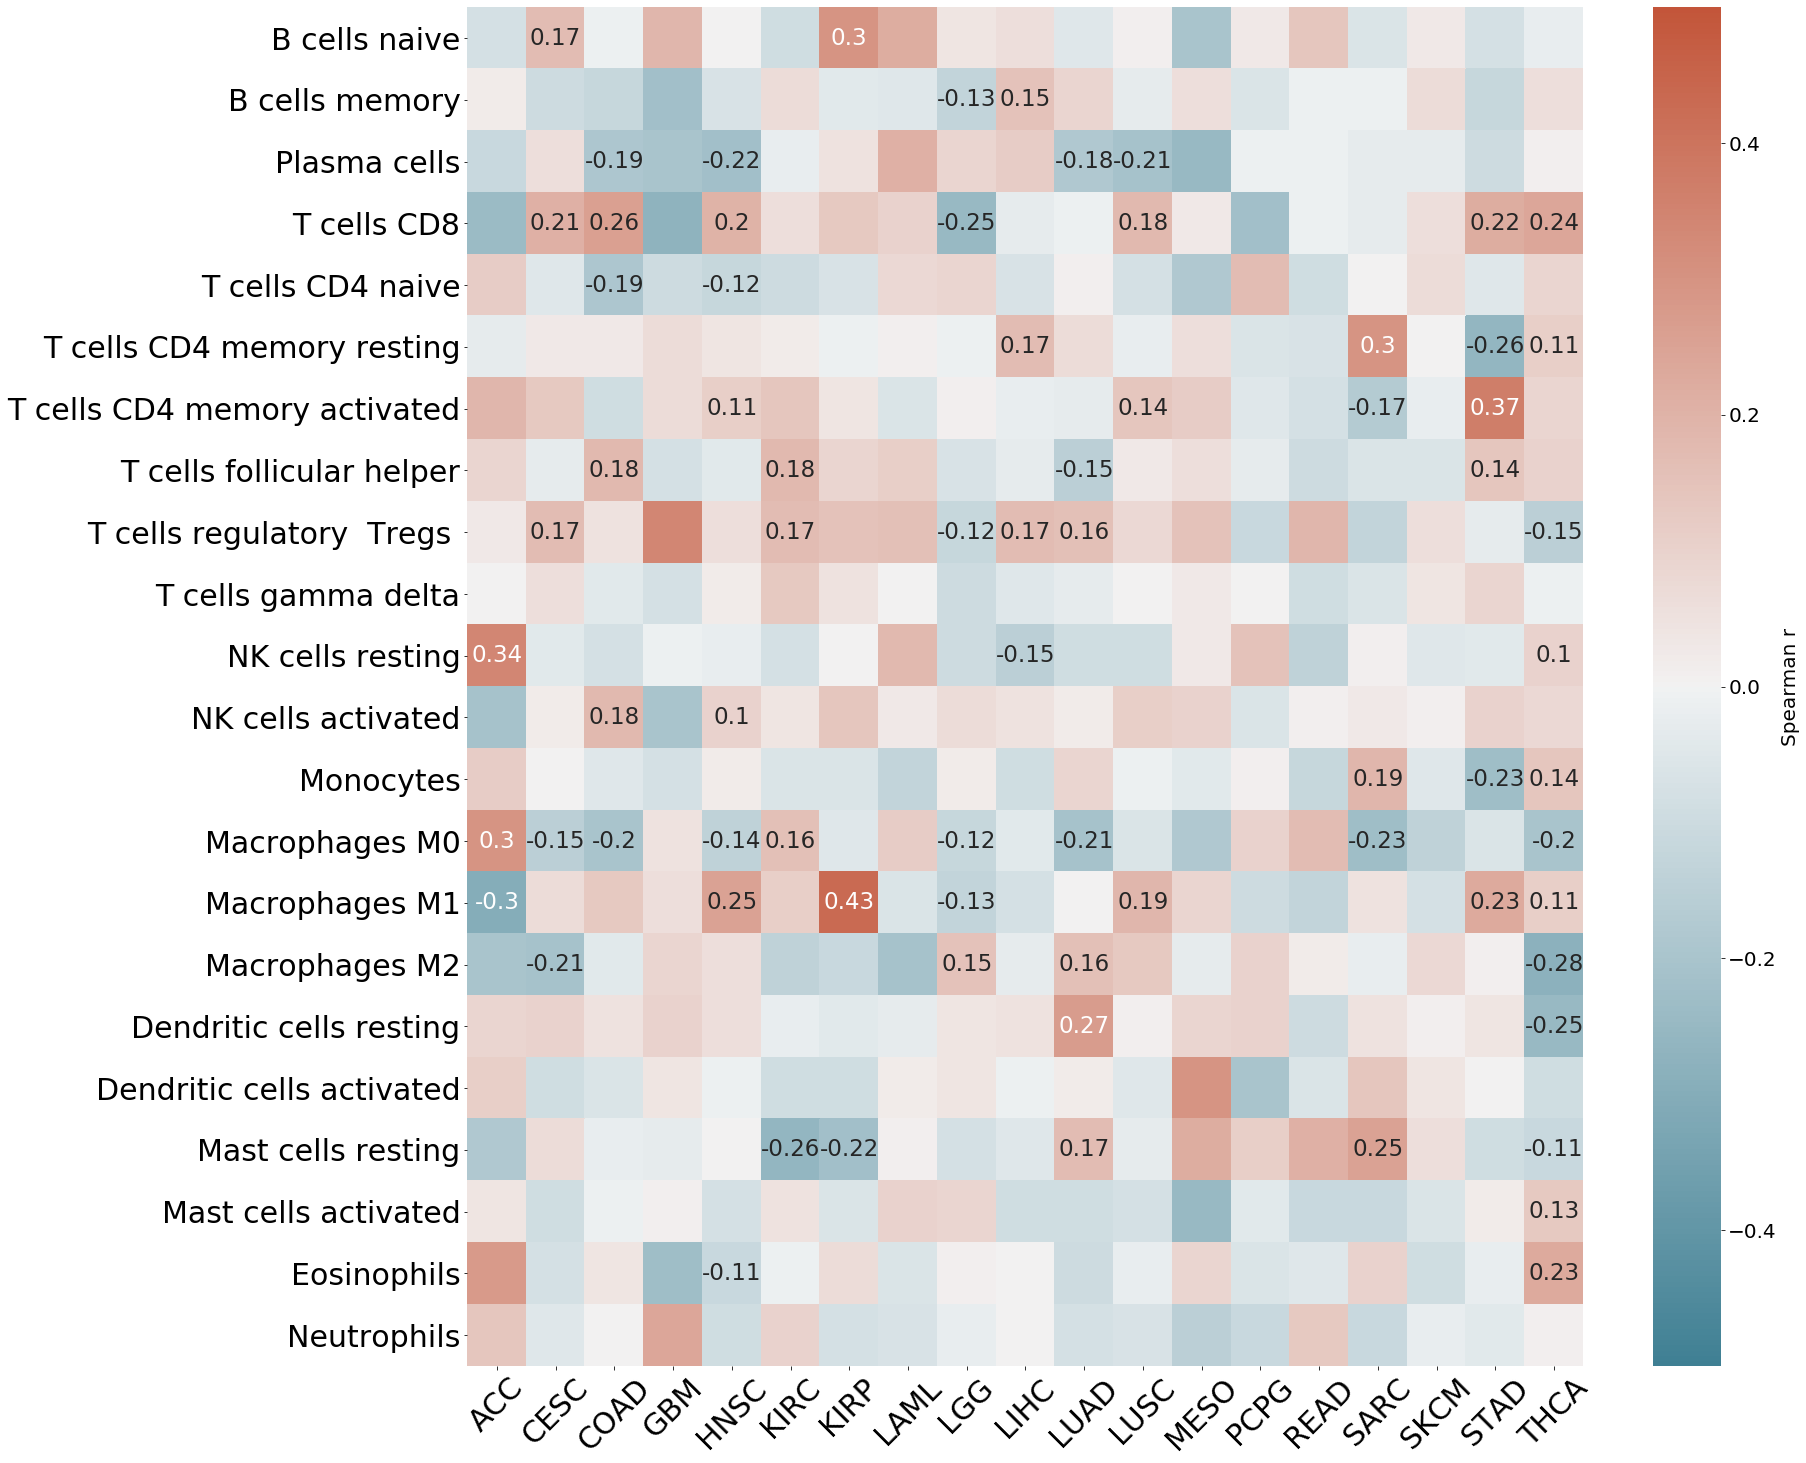

In [547]:
plt.rc("font", size=20)
fig,ax = plt.subplots(figsize=(25,25))
sns.heatmap(xcell_pc_nocorrec.T.round(2),center=0,ax=ax,annot=xcell_pc.T.round(2).replace(0,'').astype(str).values,
            annot_kws={"fontsize": 23},fmt = '',cbar_kws={'label': 'Spearman r'}, vmin=-0.5, vmax=0.5,
           cmap=sns.diverging_palette(220, 20, as_cmap=True))
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,rotation_mode="default",fontsize=30)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0,rotation_mode="default",fontsize=30)
fig.savefig("cibersort_corr.png",bbox_inches="tight")
fig.savefig("cibersort_corr.svg",bbox_inches="tight")

In [437]:
seapal = sns.color_palette("bright")
immune_subtypes = ["C1","C2","C3","C4","C5","C6"]
immune_subtypes_mapping = {"C1":1,"C2":2,"C3":3,"C4":4,"C5":5,"C6":6}
color_mapping = {1: seapal[3], 2: seapal[-2], 3: seapal[2], 4: seapal[-1], 5: seapal[0], 6: seapal[4], -1: seapal[5]}
immune_df = pd.DataFrame(data=np.zeros((6,19)),index=immune_subtypes,columns=sorted(CIMP_cancers))

In [548]:
y,OR_l=[-1 for i in range(len(sorted(CIMP_cancers)))],[0 for i in range(len(sorted(CIMP_cancers)))]

for i,cancer in enumerate(sorted(CIMP_cancers)):
    if cancer=="LAML":
        continue
    low_cl = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==1].index
    if cancer in triple_cluster_cancers_aff:
        high_cl = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==3].index
    else:
        high_cl = consensus_clustering_spectral[cancer][consensus_clustering_spectral[cancer]["cluster"]==2].index
    high_cl_immune = thorsson_pat_info["Immune Subtype"].loc[thorsson_pat_info.index.intersection(high_cl)].dropna()
    low_cl_immune = thorsson_pat_info["Immune Subtype"].loc[thorsson_pat_info.index.intersection(low_cl)].dropna()
    
    dict_high = Counter(high_cl_immune.values.ravel())
    size_high = high_cl_immune.shape[0]
    
    for subtype in immune_subtypes:
        immune_df.loc[subtype][cancer]=np.round(dict_high[subtype]/size_high*100)
    
    for subtype in immune_subtypes:
        count_high_subtype = (high_cl_immune==subtype).sum()
        count_low_subtype = (low_cl_immune==subtype).sum()
        size_high = high_cl_immune.shape[0]
        size_low = low_cl_immune.shape[0]
        contigency_table = np.array([[count_high_subtype,count_low_subtype],
                                     [size_high-count_high_subtype,size_low-count_low_subtype]])
        OR,p = fisher_exact(contigency_table)
        if OR>1 and p<0.05:
            print(cancer,subtype)
#             immune_df.loc[subtype][cancer]=min(OR,100)
#             y[i]=immune_subtypes_mapping[subtype]
#             OR_l[i]=min(OR,100)

ACC C4
COAD C2
HNSC C2
KIRP C1
LGG C5
LIHC C3
LUAD C3
LUSC C2
MESO C2
SARC C4
STAD C2


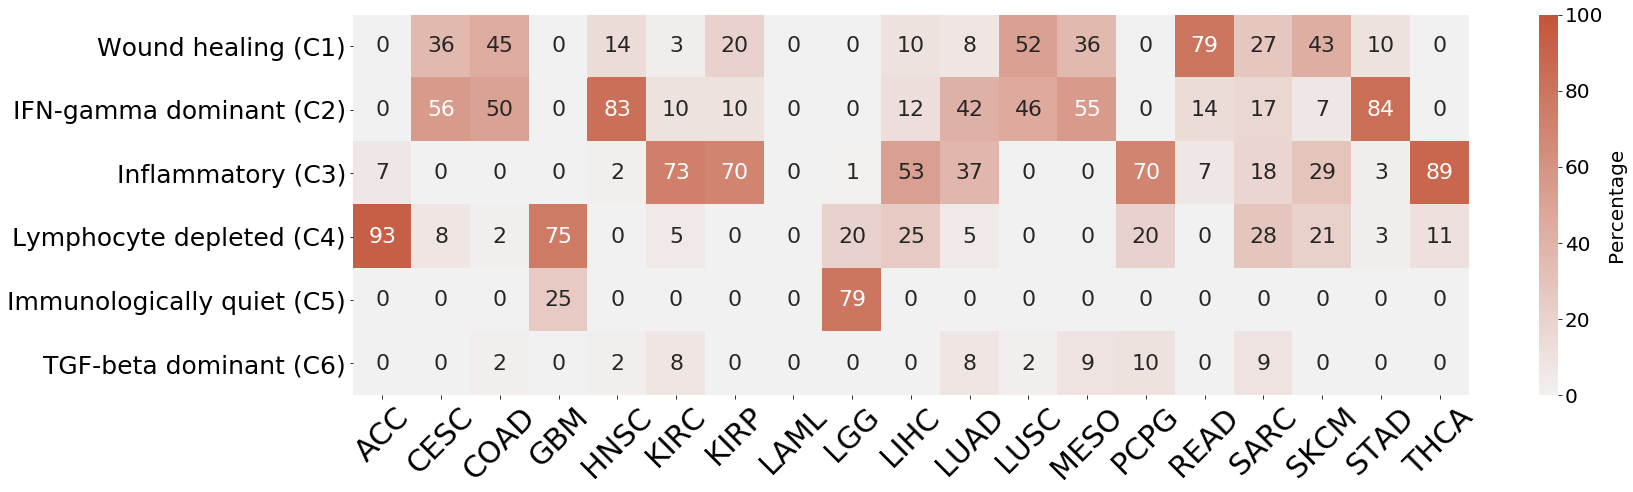

In [551]:
plt.rc("font", size=20)
fig,ax = plt.subplots(figsize=(25,7))
sns.heatmap(immune_df.astype(int),center=0,ax=ax,annot=immune_df.astype(int),
            annot_kws={"fontsize": 22},fmt = '',cbar_kws={'label': 'Percentage'}, vmin=0, vmax=100,
#             cmap=sns.color_palette("vlag", as_cmap=True))
            cmap=sns.diverging_palette(220, 20, as_cmap=True))
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,rotation_mode="default",fontsize=30)
ax.set_yticklabels(["Wound healing (C1)","IFN-gamma dominant (C2)","Inflammatory (C3)",
                    "Lymphocyte depleted (C4)","Immunologically quiet (C5)","TGF-beta dominant (C6)"],fontsize=25,rotation=0) 
fig.savefig("immune_subtype_breakdown.png",bbox_inches="tight")
fig.savefig("immune_subtype_breakdown.svg",bbox_inches="tight")

C:\Users\josep\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


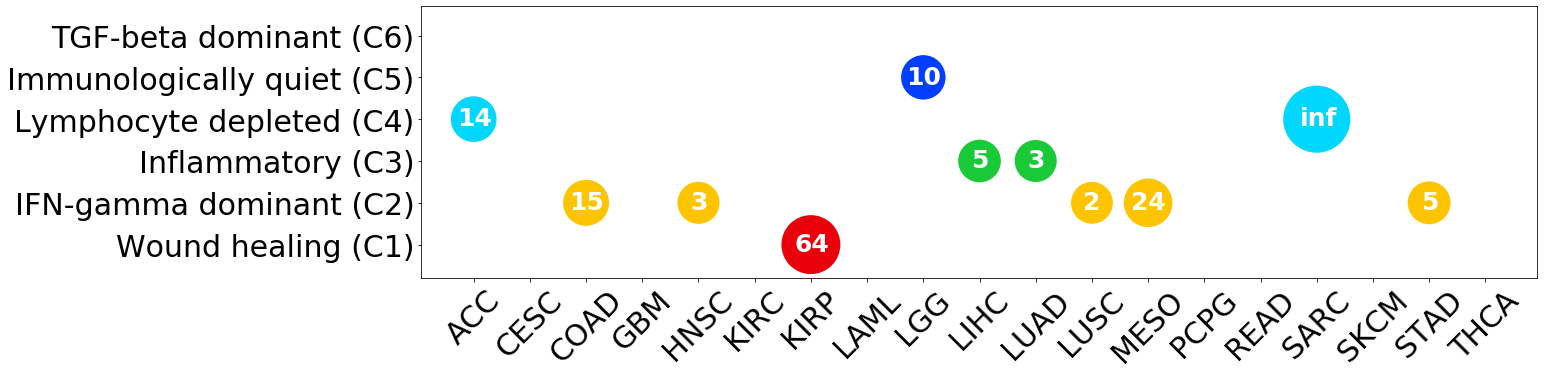

In [374]:
# fig,ax=plt.subplots(1,1,figsize=(20,5))
# sns.scatterplot(sorted(CIMP_cancers),y,size=np.array(OR_l),sizes=(2000,5000),hue=np.array(y),
#                 palette=color_mapping,legend=False)
# ax.set_ylim([0.2,6.7])
# ax.set_yticks([1,2,3,4,5,6])
# # ax.set_yticklabels(["C1","C2","C3","C4","C5","C6"]) 
# ax.set_yticklabels(["Wound healing (C1)","IFN-gamma dominant (C2)","Inflammatory (C3)",
#                     "Lymphocyte depleted (C4)","Immunologically quiet (C5)","TGF-beta dominant (C6)"],fontsize=30) 
# ax.set_xticklabels(sorted(CIMP_cancers),rotation=45,rotation_mode="default",fontsize=30)
# for i in range(len(y)):
#     if OR_l[i]!=0:
#         if i in [4,9,10,11,17]:
#             ax.text(i-0.15,y[i]-0.15,int(np.round(OR_l[i])),fontsize=25,color="white",weight="bold")
#         elif i==15:
#             ax.text(i-0.3,y[i]-0.15,"inf",fontsize=25,color="white",weight="bold")
#         else:
#             ax.text(i-0.3,y[i]-0.15,int(np.round(OR_l[i])),fontsize=25,color="white",weight="bold")


# Gene expression analysis

Finally, we analyze gene expression. Differential gene expression is calculated using the DESeq2 
package in R (code in script DESeq_GEX.R). 

In [203]:
# download gencode annotations
# gencode_annot_gene = pd.read_csv("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\auxiliary_data\\gencode_annot_length.csv")
# gagval = gencode_annot_gene["gene_id"].values
# gagval = [gagval[i].split(".")[0] for i in range(len(gagval))]
# gencode_annot_gene["gene_id_simplf"] = gagval
# uhrf1_pd = pd.DataFrame([[0,"UHRF1","ENSG00000276043.5",4000,"ENSG00000276043"]],columns=gencode_annot_gene.columns)
# gencode_annot_gene = pd.concat([gencode_annot_gene,uhrf1_pd])

# download mapping between official gene notations and gencode
merged_table = pd.read_csv("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\auxiliary_data\\gencode_mapping_table.csv").set_index("gene_name")
merged_table.columns = ["gene_id_simplf","gencode_id_gex","gencode_id"]
uhrf1_pd = pd.DataFrame([["ENSG00000276043","ENSG00000276043.3","ENSG00000276043.5"]],index=["UHRF1"],columns=merged_table.columns)
merged_table = pd.concat([merged_table,uhrf1_pd])
merged_table = merged_table[~merged_table.index.duplicated(keep='first')]

In [50]:
gencode_mapping_goi = {"TET1": "ENSG00000138336.8", "TET2": "ENSG00000168769.11", 
                       "TET3": "ENSG00000139372.13", "TDG": "ENSG00000139372.13", "TDGF1": "ENSG00000241186.6",
                       "MBD4": "ENSG00000129071.8", "APOBEC1": "ENSG00000111701.6", "CTCF": "ENSG00000102974.13",
                       "IDH1": "ENSG00000138413.12", "IDH2": "ENSG00000182054.8", "BAZ2A": "ENSG00000076108.10", 
                       "CTCFL": "ENSG00000124092.11", "DMAP1": "ENSG00000178028.12", "DNMT1": "ENSG00000130816.13",
                       "DNMT3A": "ENSG00000119772.15", "DNMT3B": "ENSG00000088305.17", "GADD45A": "ENSG00000116717.10",
                       "GADD45B": "ENSG00000099860.7", "GADD45G": "ENSG00000130222.9", "GADD45GIP1": "ENSG00000179271.2", 
                       "UHRF1BP1": "ENSG00000065060.15","UHRF1BP1L": "ENSG00000111647.11", "UHRF1": "ENSG00000276043.3", 
                       "MBD1": "ENSG00000141644.16", "MBD2": "ENSG00000134046.10"
                      }

In [ ]:
genes_meth_gex_gencode,genes_demeth_gex_gencode = [],[]
for gene in genes_meth_gex:
    genes_meth_gex_gencode.append(gencode_mapping_goi[gene])
for gene in genes_demeth_gex:
    genes_demeth_gex_gencode.append(gencode_mapping_goi[gene])

In [41]:
# 450k Illumina annotation
Meth45k = []
#with open("/mnt/data/projects/Josephine_CIMP/CIMP_unsupervised_cancer/methylation_annotation_Illumina/GPL13534_HumanMethylation450_15017482_v.1.1.csv") as csvfile:
# with open("N:\\data\\projects\\Josephine_CIMP\\CIMP_unsupervised_cancer\\methylation_annotation_Illumina\\GPL13534_HumanMethylation450_15017482_v.1.1.csv") as csvfile:
with open("C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\GPL13534_HumanMethylation450_15017482_v.1.1.csv") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        Meth45k.append(row)
colnames_45k = Meth45k[7]
methylation_val_45k = Meth45k[8:]
Meth45k_df = pd.DataFrame(methylation_val_45k,columns=colnames_45k)
Meth45k_df = Meth45k_df.set_index("IlmnID")

In [28]:
Counter(Meth45k_df['Relation_to_UCSC_CpG_Island'])

Counter({'': 176112,
         'N_Shore': 62870,
         'S_Shelf': 22300,
         'Island': 150254,
         'S_Shore': 49197,
         'N_Shelf': 24844,
         None: 851})

In [353]:
# get genes associated with differentially methylated probes 
enriched_genes = {}
for cancer in sign_pos_spectral:
    sel_genes = []
    for gene in Meth45k_df.loc[sign_pos_spectral[cancer].values.ravel()]['UCSC_RefGene_Name'].values:
        if (gene=="" or gene==None):
            continue
        else:
            sel_genes += gene.split(";")
    enriched_genes[cancer]=np.unique(sel_genes)
    enriched_genes[cancer]=merged_table.loc[merged_table.index.intersection(enriched_genes[cancer])]["gencode_id_gex"].values

In [29]:
# dictionnary from cpg probe to gene associated or cpg probe to position (promoter, gene body, TSS)
dict_cpg_to_gene = Meth45k_df['UCSC_RefGene_Name'].str.split(";").to_dict()
dict_cpg_to_position = Meth45k_df['UCSC_RefGene_Group'].str.split(";").to_dict()

In [ ]:
# dictionnary from gene to cpg probe
dict_gene_to_cpg = {}
n = len(dict_cpg_to_gene)
i=0
for cpg, genes in tqdm(dict_cpg_to_gene.items()):
    if i==n:
        continue
    for gene in genes:
        if gene in list(dict_gene_to_cpg.keys()):
            dict_gene_to_cpg[gene].append(cpg)
        else:
            dict_gene_to_cpg[gene] = [cpg]
    i+=1

In [31]:
# gencode annotations of histone writer and eraser genes
gencode_gene_writer_Hmeth = merged_table.loc[merged_table.index.intersection(all_genes_writer_Hmeth)]["gencode_id_gex"].values
gencode_gene_eraser_Hmeth = merged_table.loc[merged_table.index.intersection(all_genes_eraser_Hmeth)]["gencode_id_gex"].values

In [32]:
all_meth_genes_gencode = merged_table.loc[merged_table.index.intersection(genes_to_keep)]["gencode_id_gex"].values

In [204]:
inv_merged_table = merged_table.reset_index().set_index("gencode_id_gex")

In [103]:
# differentially expressed genes computed with DESeq2
diff_gex_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\diff_expression_DESeq"
diff_gex_pc = {}
for cancer in sorted(CIMP_cancers):
    diff_gex_pc[cancer] = pd.read_csv(os.path.join(diff_gex_dir,cancer+"_diff_gene_expression.csv")).set_index("Unnamed: 0")
    diff_gex_pc[cancer].columns = ["logfold","p"]
    diff_gex_pc[cancer] = diff_gex_pc[cancer].reset_index()
    diff_gex_pc[cancer].columns = ["gene","logfold","p"]
    diff_gex_pc[cancer] = diff_gex_pc[cancer].iloc[np.where(multipletests(diff_gex_pc[cancer]["p"].values.ravel())[0])[0]]

In [90]:
n_diff_gex = []
for cancer in sorted(CIMP_cancers):
    n_diff_gex.append(diff_gex_pc[cancer].shape[0])
print(np.mean(n_diff_gex),np.quantile(n_diff_gex,0.25),np.quantile(n_diff_gex,0.75))

648.1578947368421 51.5 746.0


In [116]:
# check probes hypomethylated in group 2 for PRDM family
for gene in ["PRDM13"]:
    print(gene)
#     for cancer in sorted(CIMP_cancers):
    for cancer in ["ACC","COAD","HNSC","LGG"]:
        common_col = new_meth_data_pc[cancer].columns.intersection(dict_gene_to_cpg[gene])
        meth_exp = new_meth_data_pc[cancer][common_col]
        common_pat_clustering = consensus_clustering_spectral[cancer]
        ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
        ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
        if cancer in triple_cluster_cancers_aff:
            ind_cl_2 = ind_cl_3
        cl1_gex = meth_exp.loc[ind_cl_1]
        cl2_gex = meth_exp.loc[ind_cl_2]
#         print(cancer,(cl1_gex.mean()-cl2_gex.mean()>0).sum()/len(common_col)*100)
        print(cancer,pd.concat([cl1_gex.mean()-cl2_gex.mean(),Meth45k_df.loc[common_col]["UCSC_RefGene_Group"]],axis=1))

PRDM13
ACC                    0 UCSC_RefGene_Group
cg01815538 -0.349695             TSS200
cg02400433 -0.237432            1stExon
cg03365733 -0.347571               Body
cg04974062 -0.561671               Body
cg13738144 -0.336662      1stExon;5'UTR
cg13738144 -0.336662      1stExon;5'UTR
cg17879189 -0.378336             TSS200
cg18924324 -0.308677               Body
cg21160099 -0.384017               Body
COAD                    0 UCSC_RefGene_Group
cg01815538 -0.416500             TSS200
cg02400433 -0.339357            1stExon
cg03365733 -0.484265               Body
cg04974062 -0.411195               Body
cg13738144 -0.242932      1stExon;5'UTR
cg13738144 -0.242932      1stExon;5'UTR
cg17879189 -0.492100             TSS200
cg21160099 -0.210935               Body
HNSC                    0 UCSC_RefGene_Group
cg01815538 -0.263227             TSS200
cg02400433 -0.123298            1stExon
cg03365733 -0.127987               Body
cg04974062 -0.227749               Body
cg13738144 -0.12964

In [104]:
# diff genes expression in histone methylation genes
for cancer in diff_gex_pc:
    print(cancer)
    diff_genes_meth = list(diff_gex_pc[cancer].set_index("gene").index.intersection(gencode_gene_writer_Hmeth))
    print("Diff expressed histone methylase genes : ",inv_merged_table.loc[diff_genes_meth]["index"].values)
    print("Log2 fold cl2 vs cl1: ",diff_gex_pc[cancer].set_index("gene").loc[diff_genes_meth]["logfold"].values)
    print("Genes with diff promoter meth : ",set(enriched_genes[cancer]) & set(diff_genes_meth))

ACC
Diff expressed histone methylase genes :  ['PRDM13']
Log2 fold cl2 vs cl1:  [-2.69041389]
Genes with diff promoter meth :  set()
CESC
Diff expressed histone methylase genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
COAD
Diff expressed histone methylase genes :  ['PRDM13']
Log2 fold cl2 vs cl1:  [-2.63890714]
Genes with diff promoter meth :  {'ENSG00000112238.11'}
GBM
Diff expressed histone methylase genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
HNSC
Diff expressed histone methylase genes :  ['PRDM13' 'PRDM8']
Log2 fold cl2 vs cl1:  [ 1.14938607 -0.41155871]
Genes with diff promoter meth :  {'ENSG00000112238.11', 'ENSG00000152784.14'}
KIRC
Diff expressed histone methylase genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
KIRP
Diff expressed histone methylase genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
LAML
Diff expressed histone methylase genes :  []
Log2 fold cl2 

In [105]:
# diff genes expression in histone demethylation genes
for cancer in diff_gex_pc:
    print(cancer)
    diff_genes_meth = list(diff_gex_pc[cancer].set_index("gene").index.intersection(gencode_gene_eraser_Hmeth))
    print("Diff expressed meth genes : ",inv_merged_table.loc[diff_genes_meth]["index"].values)
    print("Log2 fold cl2 vs cl1: ",diff_gex_pc[cancer].set_index("gene").loc[diff_genes_meth]["logfold"].values)
    print("Genes with diff promoter meth : ",set(enriched_genes[cancer]) & set(diff_genes_meth))

ACC
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
CESC
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
COAD
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
GBM
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
HNSC
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
KIRC
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
KIRP
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
LAML
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
LGG
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
LIHC
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promot

In [106]:
# diff genes expression in DNA methylation/demethylation genes
for cancer in diff_gex_pc:
    print(cancer)
    diff_genes_meth = list(diff_gex_pc[cancer].set_index("gene").index.intersection(genes_meth_gex_gencode))
    diff_genes_demeth = list(diff_gex_pc[cancer].set_index("gene").index.intersection(genes_demeth_gex_gencode))
    print("Diff expressed meth genes : ",inv_merged_table.loc[diff_genes_meth]["index"].values)
    print("Log2 fold cl2 vs cl1: ",diff_gex_pc[cancer].set_index("gene").loc[diff_genes_meth]["logfold"].values)
    print("Genes with diff promoter meth : ",set(enriched_genes[cancer]) & set(diff_genes_meth))
    print("Diff expressed demeth genes : ",inv_merged_table.loc[diff_genes_demeth]["index"].values)
    print("Log2 fold cl2 vs cl1: ",diff_gex_pc[cancer].set_index("gene").loc[diff_genes_demeth]["logfold"].values)
    print("Genes with diff promoter meth : ",set(enriched_genes[cancer]) & set(diff_genes_demeth))

ACC
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
Diff expressed demeth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
CESC
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
Diff expressed demeth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
COAD
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
Diff expressed demeth genes :  ['TDGF1']
Log2 fold cl2 vs cl1:  [-0.63391387]
Genes with diff promoter meth :  {'ENSG00000241186.6'}
GBM
Diff expressed meth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
Diff expressed demeth genes :  []
Log2 fold cl2 vs cl1:  []
Genes with diff promoter meth :  set()
HNSC
Diff expressed meth genes :  ['CTCFL']
Log2 fold cl2 vs cl1:  [1.82851444]
Genes with diff promoter meth :  {'ENSG00000124092.11'}
Diff expressed demeth genes 

In [142]:
# get candidate downstream genes (genes with differential GEX and hypermethylated promoters in the high methylated group)
diff_gex_offgene_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\diff_expression_offgene"
downstream_genes_pc, body_diff_genes_pc, promoter_diff_genes_pc = {},{},{}
for cancer in tqdm(sorted(CIMP_cancers)):
    assoc_cpg = []
    common_genes = inv_merged_table.index.intersection(diff_gex_pc[cancer]["gene"].values.ravel())
    list_gene = inv_merged_table.loc[common_genes]["index"].values.ravel()
    for gene in list_gene:
        if not(gene in list(dict_gene_to_cpg.keys())):
            continue
        assoc_cpg+=dict_gene_to_cpg[gene]

    meth_exp = new_meth_data_pc[cancer][sign_pos_spectral[cancer].set_index("0").index.intersection(assoc_cpg)]
    common_pat_clustering = consensus_clustering_spectral[cancer]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    if cancer in triple_cluster_cancers_aff:
        ind_cl_2 = ind_cl_3
    cl1_gex = meth_exp.loc[ind_cl_1].mean()
    cl2_gex = meth_exp.loc[ind_cl_2].mean()

    hypermethylated_cpgs = cl1_gex.index[np.where(cl1_gex-cl2_gex<-0.1)[0]]
    downstream_genes, body_genes, promoter_genes = [],[],[]
    for cpg in list(hypermethylated_cpgs):
        if "Body" in dict_cpg_to_position[cpg]:
            body_genes+=dict_cpg_to_gene[cpg]
        else:
            promoter_genes+=dict_cpg_to_gene[cpg]
        downstream_genes+=dict_cpg_to_gene[cpg]

    downstream_genes_pc[cancer] = np.unique(downstream_genes)
    body_diff_genes_pc[cancer] = np.unique(body_genes)
    promoter_diff_genes_pc[cancer] = np.unique(promoter_genes)
    pd.DataFrame(downstream_genes_pc[cancer]).to_csv(os.path.join(diff_gex_offgene_dir,cancer+"_downstream_genes_gex.csv"),index=False)

In [100]:
all_downstream_genes = []
for cancer in downstream_genes_pc:
    all_downstream_genes+=list(downstream_genes_pc[cancer])

In [136]:
Counter(all_downstream_genes).most_common(10)

[('LMX1B', 8),
 ('FOXJ1', 6),
 ('EN2', 5),
 ('ARHGDIG', 5),
 ('CHGA', 5),
 ('KRT7', 5),
 ('PDIA2', 5),
 ('TMEM61', 5),
 ('EN1', 4),
 ('FOXE1', 4)]

## Find signatures for different etiologies

Finally, we compute here the average beta values over all CpG Islands, shores and shelves to uncover methylation signatures linked to CIMP status (strong, weak and non CIMP)

In [36]:
# break according to methylation status
sCIMP1 = ["ACC","COAD","KIRC","KIRP","MESO","STAD","THCA",]
sCIMP2 = ["CESC","GBM","HNSC","LAML","LGG","LIHC","LUAD","LUSC","PCPG","READ","SARC","SKCM",]
nonCIMP = ["BLCA","BRCA","ESCA","PAAD","PRAD","THYM","UCEC"]

In [38]:
def get_methylation_sign_CIMP(flatax,cancer_list,Meth45k_df,meth_data_pc,consensus_clustering_spectral,
                              high_conf_patients,triple_cluster_cancers_aff):
    #     Parameters: flatax (matplotlib.pyplot.Axes.axe): flattened axis of the subplot object
    #                cancer_list (list): list of the cancer types to consider
    #                Meth45k_df (pd.DataFrame): df of the Illumina 450k annotation 
    #                meth_data_pc (dict): keys are cancer types, values of pd.DataFrame of beta values (n_patients,n_cpg_ids)
    #                consensus_clustering (dict): keys are cancer types, values are pd.Df (n_patients,1) (rows=patients,columns=cluster membership)
    #                high_conf_patients (dict): keys are cancer types, values are list of patients with SSC>0
    #                triple_cluster_cancers_aff (list): list of cancer types with 3 methyaltion clusters
    #     Returns: flatax (matplotlib.pyplot.Axes.axe): updated/filled axis for subplot object
    seapal = sns.color_palette("bright")
    fignum = 0
    mean_cgi_pc = {}
    for cancer in tqdm(cancer_list):
        # get the information for probes: position, strand polarity, CGI position
        cpg_info_df = Meth45k_df[['CHR', 'MAPINFO', 'Strand',"UCSC_CpG_Islands_Name",'Relation_to_UCSC_CpG_Island']]
        common_cpg = cpg_info_df.index.intersection(meth_data_pc[cancer].columns)
        cpg_info_df = cpg_info_df.loc[common_cpg]
        cpg_island_df = cpg_info_df["UCSC_CpG_Islands_Name"].str.split(":")
        CGI_sizes, CGI_start, CGI_end = [],[],[]

        # for every position in CGI, get start, end and size to break into bins
        for cpg in cpg_island_df.index:
            pos = cpg_island_df.loc[cpg][1].split("-")
            size  = int(pos[1])-int(pos[0])
            start, end = int(pos[0]),int(pos[1])
            CGI_sizes.append(size)
            CGI_start.append(start)
            CGI_end.append(end)
        cpg_info_df["CGI_sizes"] = CGI_sizes
        cpg_info_df["CGI_start"] = CGI_start
        cpg_info_df["CGI_end"] = CGI_end
        bin_membership = []
        for cpg in cpg_info_df.index:
            cpg_inf = cpg_info_df.loc[cpg]
            typ = cpg_inf["Relation_to_UCSC_CpG_Island"]
            strand = cpg_inf["Strand"]
            if typ=="Island":
                bin_size = cpg_inf["CGI_sizes"]//10+1
            else:
                bin_size = 200
            pos = int(cpg_inf["MAPINFO"])

            # there will be 50 bins all total, indexed starting at the N_shelf at 0, max 50 at the S_shelf
            # eg if bin 2 of the S_shore, the bin membership will be 40 (beginning of S_shore) + 2 (bin within the shore) = 42
            # if the strand is forward, then computation is straightforward ; if it is reverse, we must reverse the roles (S_shore ~ N_shore)

            if typ=="Island":
                rel_pos = pos-int(cpg_inf["CGI_start"])
                if strand=="F":
                    bin_membership.append(rel_pos//bin_size+1+20)
                else:
                    bin_membership.append(10-rel_pos//bin_size+20)
            elif typ=="N_Shelf":
                rel_pos = int(cpg_inf["CGI_start"])-pos-2000
                if strand=="F":
                    bin_membership.append(10-rel_pos//bin_size)
                else:
                    bin_membership.append(rel_pos//bin_size+1+40)
            elif typ=="S_Shelf":
                rel_pos = pos-int(cpg_inf["CGI_end"])-2000
                if strand=="F":
                    bin_membership.append(rel_pos//bin_size+1+40)
                else:
                    bin_membership.append(10-rel_pos//bin_size)
            elif typ=="N_Shore":
                rel_pos = int(cpg_inf["CGI_start"])-pos
                if strand=="F":
                    bin_membership.append(10-rel_pos//bin_size+10)
                else:
                    bin_membership.append(rel_pos//bin_size+1+30)
            elif typ=="S_Shore":
                rel_pos = pos-int(cpg_inf["CGI_end"])
                if strand=="F":
                    bin_membership.append(rel_pos//bin_size+1+30)
                else:
                    bin_membership.append(10-rel_pos//bin_size+10)

        cpg_info_df["bin"] = bin_membership
        common_pat_clustering = consensus_clustering_spectral[cancer].loc[consensus_clustering_spectral[cancer].index.intersection(high_conf_patients[cancer])]
        ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
        ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
        ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
        cl_1_mean = new_meth_data_pc[cancer].loc[ind_cl_1].mean()
        cl_2_mean = new_meth_data_pc[cancer].loc[ind_cl_2].mean()
        cl_3_mean = new_meth_data_pc[cancer].loc[ind_cl_3].mean()
        normal_mean = normal_meth[cancer].mean()

        # get the methylation for low, int and high methylated cluster, as well as normal
        if cancer in triple_cluster_cancers_aff:
            full_cpg_island_df= pd.concat([cpg_info_df,cl_1_mean,cl_2_mean,cl_3_mean,normal_mean],axis=1).dropna()
            full_cpg_island_df.columns = list(cpg_info_df.columns) + ["Low meth", "Intermediate meth", "High meth", "Normal"]
        else:
            full_cpg_island_df= pd.concat([cpg_info_df,cl_1_mean,cl_2_mean,normal_mean],axis=1).dropna()
            full_cpg_island_df.columns = list(cpg_info_df.columns) + ["Low meth", "High meth", "Normal"]
            
        mean_cgi_meth = full_cpg_island_df.groupby(["bin"]).mean().reset_index()
        print(cancer)
        mean_cgi_pc[cancer]=mean_cgi_meth
        # plot avg meth on same plot
        sns.lineplot(data=mean_cgi_meth,x="bin",y="Low meth",color=seapal[0],ax=flatax[fignum],label="Low meth cluster")
        if cancer in triple_cluster_cancers_aff:
            sns.lineplot(data=mean_cgi_meth,x="bin",y="Intermediate meth",color=seapal[8],ax=flatax[fignum], label="Intermediate meth cluster")
        sns.lineplot(data=mean_cgi_meth,x="bin",y="High meth",color=seapal[3],ax=flatax[fignum], label="High meth cluster")
        sns.lineplot(data=mean_cgi_meth,x="bin",y="Normal",color=seapal[7],ax=flatax[fignum], label="Normal tissue")
        flatax[fignum].set_title(cancer+" average methylation over CGI",fontsize=18)
        flatax[fignum].set_ylabel("Methylation (beta)",fontsize=15)
        flatax[fignum].set_xlim([0,50])
        flatax[fignum].set_ylim([0,0.85])
        fignum+=1
    return flatax,mean_cgi_pc

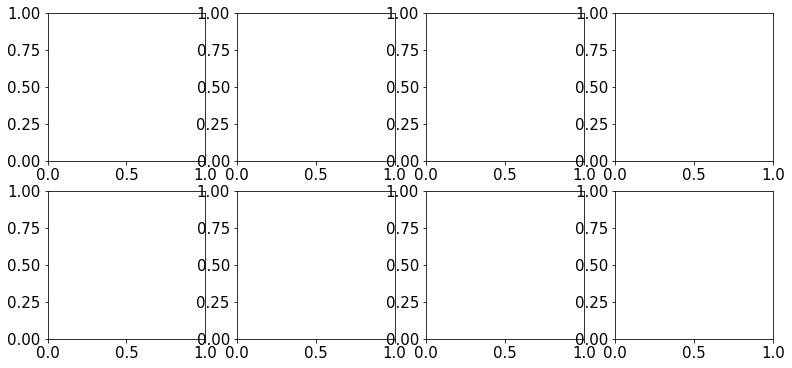

In [150]:
fig, axs = plt.subplots(2, 4, figsize=(13,6))
flatax = axs.flatten()

In [151]:
flatax,mean_cgi_pc = get_methylation_sign_CIMP(flatax,sCIMP1,Meth45k_df,meth_data_pc,consensus_clustering_spectral,
                              high_conf_patients,triple_cluster_cancers_aff)

ACC
COAD
KIRC
KIRP
MESO
STAD
THCA



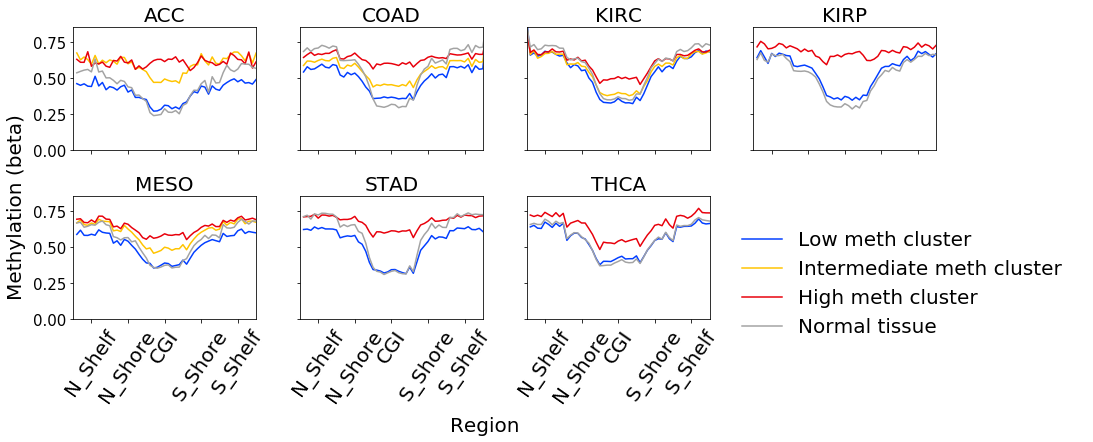

<Figure size 432x288 with 0 Axes>

In [152]:
# visualization
lines, labels = flatax[0].get_legend_handles_labels()
for i,cancer in enumerate(sCIMP1):
    a = flatax[i]
    a.set_ylabel('')
    if not (i in [0,4]):
        a.set_yticklabels([])
    a.set_xticks([5,15,25,35,45])
    if i in [4,5,6]:
        a.set_xticklabels(["N_Shelf","N_Shore","CGI","S_Shore","S_Shelf"],rotation=55,rotation_mode="default",fontsize=20)
    else:
        a.set_xticklabels([])
    a.set_title(cancer,fontsize=20)
    a.set_xlabel('')
    a.legend_=None
fig.text(0.5, -0.02, 'Region', ha='center',fontsize=20)
fig.text(-0.01, 0.5, 'Methylation (beta)', va='center', rotation='vertical',fontsize=20)
flatax[-1].axis("off")
fig.legend(lines, labels, loc = 'center right', bbox_to_anchor = (1.5,0.05,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=20,frameon=False)
fig.tight_layout()
fig

In [153]:
fig.savefig("signature_sCIMP1_wnormal.svg",bbox_inches="tight")
fig.savefig("signature_sCIMP1_wnormal.png",bbox_inches="tight")

In [69]:
mean_cgi_full = pd.DataFrame(columns=["bin","Low meth","Intermediate meth","High meth","Normal"])
for cancer in mean_cgi_pc:
    if cancer in triple_cluster_cancers_aff:
        mean_cgi_full= pd.concat([mean_cgi_full,mean_cgi_pc[cancer][["bin","Low meth","Intermediate meth","High meth","Normal"]]])
    else:
        mean_cgi_full= pd.concat([mean_cgi_full,mean_cgi_pc[cancer][["bin","Low meth","High meth","Normal"]]])
mean_cgi_full = mean_cgi_full.groupby("bin").mean()

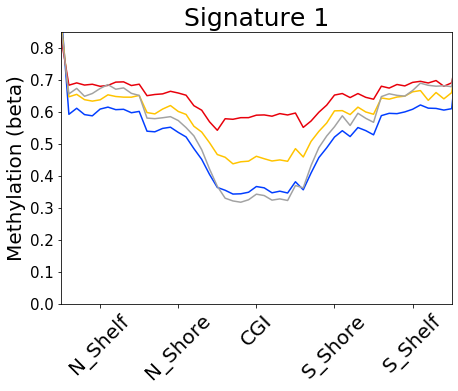

In [70]:
seapal=sns.color_palette("bright")
fig,ax=plt.subplots(1,1,figsize=(7,5))
sns.lineplot(data=mean_cgi_full,x="bin",y="Low meth",color=seapal[0],ax=ax,label="Low meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="Intermediate meth",color=seapal[8],ax=ax, label="Intermediate meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="High meth",color=seapal[3],ax=ax, label="High meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="Normal",color=seapal[7],ax=ax, label="Normal tissue")
ax.set_title("Signature 1",fontsize=25)
ax.set_ylabel("Methylation (beta)",fontsize=20)
ax.set_xlim([0,50])
ax.set_ylim([0,0.85])
ax.legend_=None
ax.set_xticks([5,15,25,35,45])
ax.set_xticklabels(["N_Shelf","N_Shore","CGI","S_Shore","S_Shelf"],rotation=45,rotation_mode="default",fontsize=20)
ax.set_xlabel('')
fig.savefig("signature_1_cartoon.png",bbox_inches="tight")
fig.savefig("signature_1_cartoon.svg",bbox_inches="tight")

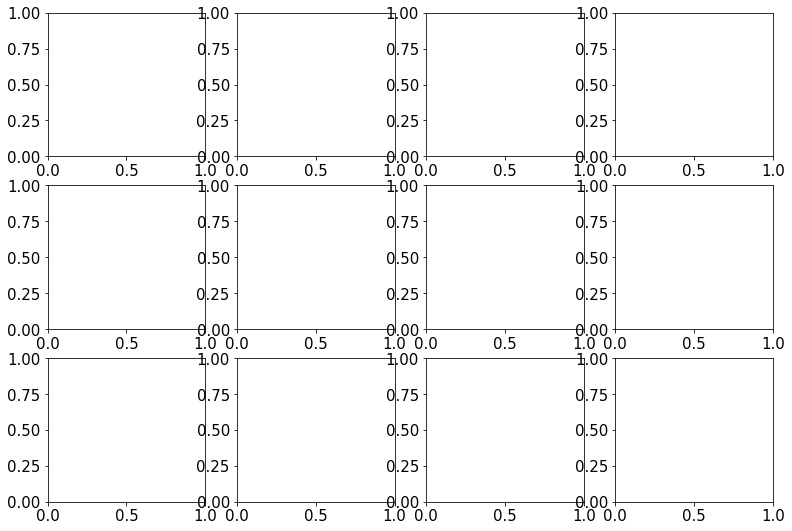

In [138]:
fig, axs = plt.subplots(3, 4, figsize=(13,9))
flatax = axs.flatten()

In [139]:
flatax,mean_cgi_pc = get_methylation_sign_CIMP(flatax,sCIMP2,Meth45k_df,meth_data_pc,consensus_clustering_spectral,
                              high_conf_patients,triple_cluster_cancers_aff)

CESC
GBM
HNSC
LAML
LGG
LIHC
LUAD
LUSC
PCPG
READ
SARC
SKCM



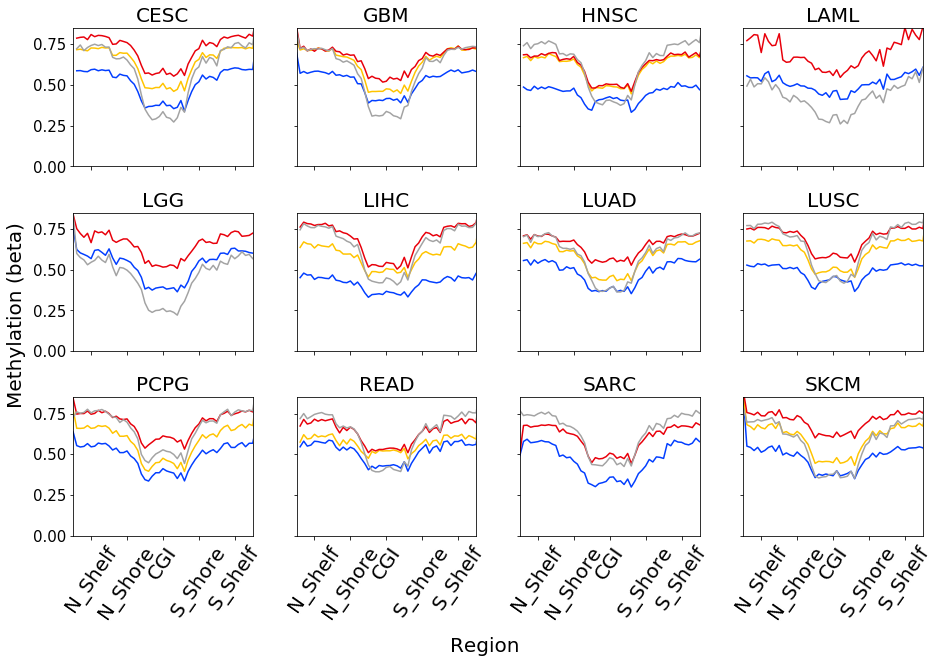

In [140]:
# visualization
# lines, labels = flatax[0].get_legend_handles_labels()

for i,cancer in enumerate(sCIMP2):
    a = flatax[i]
    a.set_ylabel('')
    if not (i in [0,4,8]):
        a.set_yticklabels([])
    a.set_xticks([5,15,25,35,45])
    if i in [8,9,10,11]:
        a.set_xticklabels(["N_Shelf","N_Shore","CGI","S_Shore","S_Shelf"],rotation=55,rotation_mode="default",fontsize=20)
    else:
        a.set_xticklabels([])
    a.set_title(cancer,fontsize=20)
    a.set_xlabel('')
    a.legend_=None
fig.text(0.5, -0.02, 'Region', ha='center',fontsize=20)
fig.text(-0.01, 0.5, 'Methylation (beta)', va='center', rotation='vertical',fontsize=20)
# fig.legend(lines, labels, loc = 'center right', bbox_to_anchor = (1.2,-0.1,1,1),
#             bbox_transform = plt.gcf().transFigure,fontsize=15,frameon=False)
fig.tight_layout()
fig


In [141]:
fig.savefig("signature_sCIMP2_wnormal.svg",bbox_inches="tight")
fig.savefig("signature_sCIMP2_wnormal.png",bbox_inches="tight")

In [63]:
mean_cgi_full = pd.DataFrame(columns=["bin","Low meth","Intermediate meth","High meth","Normal"])
for cancer in mean_cgi_pc:
    if cancer in triple_cluster_cancers_aff:
        mean_cgi_full= pd.concat([mean_cgi_full,mean_cgi_pc[cancer][["bin","Low meth","Intermediate meth","High meth","Normal"]]])
    else:
        mean_cgi_full= pd.concat([mean_cgi_full,mean_cgi_pc[cancer][["bin","Low meth","High meth","Normal"]]])
mean_cgi_full = mean_cgi_full.groupby("bin").mean()

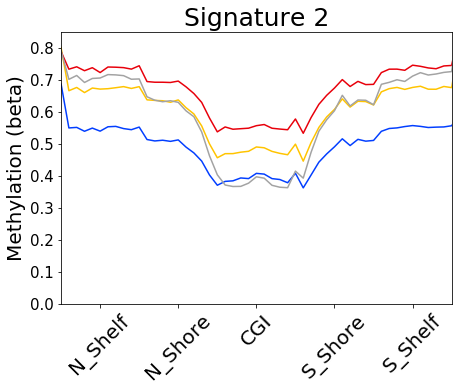

In [65]:
seapal=sns.color_palette("bright")
fig,ax=plt.subplots(1,1,figsize=(7,5))
sns.lineplot(data=mean_cgi_full,x="bin",y="Low meth",color=seapal[0],ax=ax,label="Low meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="Intermediate meth",color=seapal[8],ax=ax, label="Intermediate meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="High meth",color=seapal[3],ax=ax, label="High meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="Normal",color=seapal[7],ax=ax, label="Normal tissue")
ax.set_title("Signature 2",fontsize=25)
ax.set_ylabel("Methylation (beta)",fontsize=20)
ax.set_xlim([0,50])
ax.set_ylim([0,0.85])
ax.legend_=None
ax.set_xticks([5,15,25,35,45])
ax.set_xticklabels(["N_Shelf","N_Shore","CGI","S_Shore","S_Shelf"],rotation=45,rotation_mode="default",fontsize=20)
ax.set_xlabel('')
fig.savefig("signature_2_cartoon.png",bbox_inches="tight")
fig.savefig("signature_2_cartoon.svg",bbox_inches="tight")

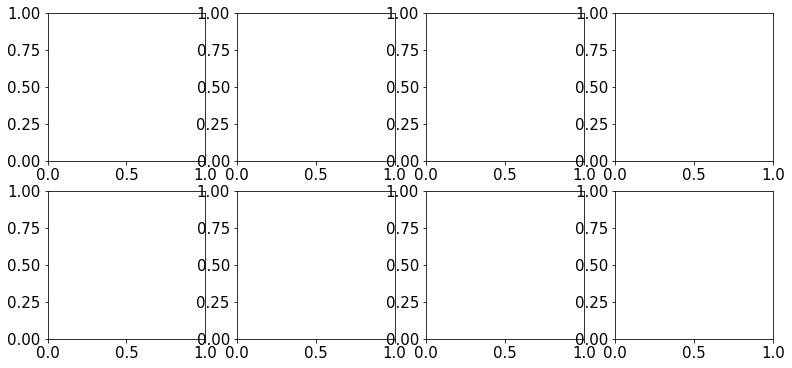

In [154]:
fig, axs = plt.subplots(2, 4, figsize=(13,6))
flatax = axs.flatten()

In [155]:
flatax,mean_cgi_pc = get_methylation_sign_CIMP(flatax,nonCIMP,Meth45k_df,meth_data_pc,consensus_clustering_spectral,
                              high_conf_patients,triple_cluster_cancers_aff)

BLCA
BRCA
ESCA
PAAD
PRAD
THYM
UCEC



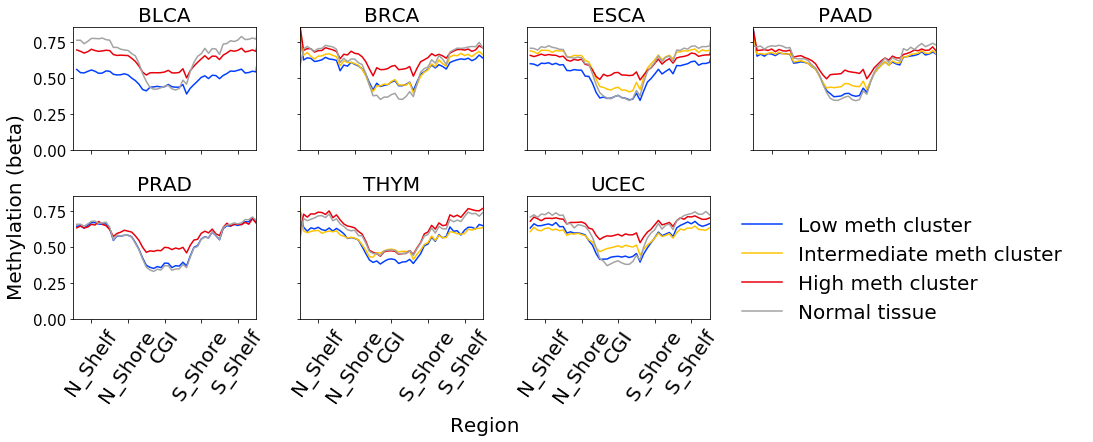

<Figure size 432x288 with 0 Axes>

In [156]:
lines, labels = flatax[-2].get_legend_handles_labels()
for i,cancer in enumerate(nonCIMP):
    a = flatax[i]
    a.set_ylabel('')
    if not (i in [0,4]):
        a.set_yticklabels([]) 
    a.set_xticks([5,15,25,35,45])
    if i in [4,5,6]:
        a.set_xticklabels(["N_Shelf","N_Shore","CGI","S_Shore","S_Shelf"],rotation=55,rotation_mode="default",fontsize=20)
    else:
        a.set_xticklabels([])
    a.set_title(cancer,fontsize=20)
    a.set_xlabel('')
    a.legend_=None
    
fig.text(0.5, -0.02, 'Region', ha='center',fontsize=20)
fig.text(-0.01, 0.5, 'Methylation (beta)', va='center', rotation='vertical',fontsize=20)
flatax[-1].axis("off")
fig.legend(lines, labels, loc = 'right', bbox_to_anchor = (1.5,0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=20,frameon=False)
fig.tight_layout()
fig

In [157]:
fig.savefig("signature_nonCIMP_wnormal.svg",bbox_inches="tight")
fig.savefig("signature_nonCIMP_wnormal.png",bbox_inches="tight")

In [136]:
mean_cgi_full = pd.DataFrame(columns=["bin","Low meth","Intermediate meth","High meth","Normal"])
for cancer in mean_cgi_pc:
    if cancer in triple_cluster_cancers_aff:
        mean_cgi_full= pd.concat([mean_cgi_full,mean_cgi_pc[cancer][["bin","Low meth","Intermediate meth","High meth","Normal"]]])
    else:
        mean_cgi_full= pd.concat([mean_cgi_full,mean_cgi_pc[cancer][["bin","Low meth","High meth","Normal"]]])
mean_cgi_full = mean_cgi_full.astype(np.float64).groupby("bin").mean()

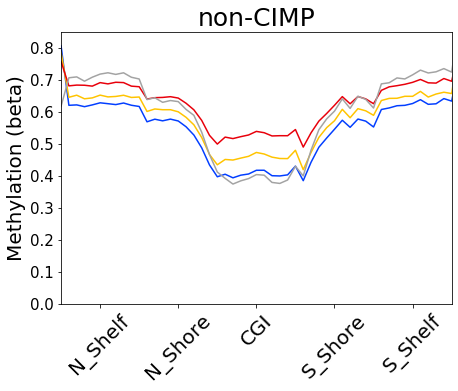

In [137]:
seapal=sns.color_palette("bright")
fig,ax=plt.subplots(1,1,figsize=(7,5))
sns.lineplot(data=mean_cgi_full,x="bin",y="Low meth",color=seapal[0],ax=ax,label="Low meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="Intermediate meth",color=seapal[8],ax=ax, label="Intermediate meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="High meth",color=seapal[3],ax=ax, label="High meth cluster")
sns.lineplot(data=mean_cgi_full,x="bin",y="Normal",color=seapal[7],ax=ax, label="Normal tissue")
ax.set_title("non-CIMP",fontsize=25)
ax.set_ylabel("Methylation (beta)",fontsize=20)
ax.set_xlim([0,50])
ax.set_ylim([0,0.85])
ax.legend_=None
ax.set_xticks([5,15,25,35,45])
ax.set_xticklabels(["N_Shelf","N_Shore","CGI","S_Shore","S_Shelf"],rotation=45,rotation_mode="default",fontsize=20)
ax.set_xlabel('')
fig.savefig("nonCIMP_cartoon.png",bbox_inches="tight")
fig.savefig("nonCIMP_cartoon.svg",bbox_inches="tight")

# Etiology group chart

In [156]:
import plotly as pl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import orca

In [157]:
analyzed_cancers = {0: ["GBM","LAML","LGG","SKCM"], 1: ["ACC","CESC","COAD","GBM","HNSC","KIRC","LGG","LIHC","LUSC","MESO"],
                   2: ["COAD"], 3:["CESC","COAD","HNSC","KIRC","LGG","LIHC","LUAD","LUSC","MESO","SARC"]}
ls = np.linspace(0,1,27)
send = {}
for j in range(len(analyzed_cancers)):
    send[j] = []
    for i,cancer in enumerate(cancer_to_keep):
        if cancer in analyzed_cancers[j]:
            send[j].append([ls[i],ls[i+1]])

In [158]:
def get_theta(pct, num_points):
    start = pct[0] * 360
    length = (pct[1] - pct[0]) * 360
    step = 360 / num_points
    return np.arange(start, start + length + step, step)

num_points = 360
r_gap = 0.05

max_r = 1 

In [159]:
color_pal = pl.colors.qualitative.Alphabet
color_mapping = {CIMP_cancers[i]: color_pal[i] for i in range(len(CIMP_cancers))}

In [164]:
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)
count=0
for i in [1,2]:
    for j in [1,2]:
        fig.add_trace(go.Scatterpolar(
          r=[1] * num_points,
          theta=get_theta([0, 1], num_points),
          mode='lines',
          line_color='black',
          line_width=4,
          showlegend=False
        ),i,j)


        for index, seg in enumerate(send[count]):
            fig.add_trace(go.Scatterpolar(
            r = [1 + r_gap] * num_points,
            theta = get_theta(seg, num_points),
            mode='lines',
            line_width=10,
            name=str(analyzed_cancers[count][index]),
            line_color=color_mapping[analyzed_cancers[count][index]],
          ),i,j)
        count+=1
        
        fig.update_layout(
          polar1=dict(
              angularaxis=dict(
                rotation=90,
                direction="clockwise",
                showticklabels=False,
                showgrid=False
              ),
              radialaxis=dict(
                range=[0, 1 + (len(send) + 1) * r_gap],
                showticklabels=False,
                visible=False
              )
          ),
        polar2=dict(
              angularaxis=dict(
                rotation=90,
                direction="clockwise",
                showticklabels=False,
                showgrid=False
              ),
              radialaxis=dict(
                range=[0, 1 + (len(send) + 1) * r_gap],
                showticklabels=False,
                visible=False
              )
          ),
        polar3=dict(
              angularaxis=dict(
                rotation=90,
                direction="clockwise",
                showticklabels=False,
                showgrid=False
              ),
              radialaxis=dict(
                range=[0, 1 + (len(send) + 1) * r_gap],
                showticklabels=False,
                visible=False
              )
          ),
        polar4=dict(
              angularaxis=dict(
                rotation=90,
                direction="clockwise",
                showticklabels=False,
                showgrid=False
              ),
              radialaxis=dict(
                range=[0, 1 + (len(send) + 1) * r_gap],
                showticklabels=False,
                visible=False
              )
          ))
# # Configure the layout based on the requirements.


fig.add_annotation(x=0.1, y=1.1,
            text="Demethylation (mut)",
            showarrow=False,font=dict(
        family='Arial',
        size=18,
        color="Black"
    ))
fig.add_annotation(x=0.92, y=1.1,
            text="Histone methylation (mut)",
            showarrow=False,font=dict(
        family='Arial',
        size=18,
        color="Black"
    ))
fig.add_annotation(x=0.2, y=0.48,
            text="MSI",
            showarrow=False,font=dict(
        family='Arial',
        size=18,
        color="Black"
    ))
fig.add_annotation(x=0.82, y=0.48,
            text="Diverse",
            showarrow=False,font=dict(
        family='Arial',
        size=18,
        color="Black"
    ))
names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))
fig.write_image("etiology_indicators.png")
fig.write_image("etiology_indicators.svg")

In [165]:
fig

# Transcription start sites

We perform the same analysis around transcription start sites to find potential signatures
We do not have information on the distance to the TSS or its position in the illumina annotation so we must take the values from gencode annotations

In [79]:
tss_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\TSS_distances"

In [269]:
from gtfparse import read_gtf
gencode_annot_dir = "N:\\data\\annotations\\Human\\hg19\\GENCODE" 
gencode_annot = read_gtf(os.path.join(gencode_annot_dir,"gencode.hg19.gtf"))

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'level', 'havana_gene', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [270]:
gene_start_gencode_annot = gencode_annot[gencode_annot["feature"]=="gene"].set_index("transcript_name")

In [271]:
gene_start_gencode_annot

seqname   source feature  start    end  score strand frame  \
transcript_name                                                              
DDX11L1            chr1   HAVANA    gene  11869  14412    NaN      +     0   
WASH7P             chr1   HAVANA    gene  14363  29806    NaN      -     0   
MIR1302-11         chr1   HAVANA    gene  29554  31109    NaN      +     0   
FAM138A            chr1   HAVANA    gene  34554  36081    NaN      -     0   
OR4G4P             chr1   HAVANA    gene  52473  54936    NaN      +     0   
...                 ...      ...     ...    ...    ...    ...    ...   ...   
MT-ND6             chrM  ENSEMBL    gene  14149  14673    NaN      -     0   
MT-TE              chrM  ENSEMBL    gene  14674  14742    NaN      -     0   
MT-CYB             chrM  ENSEMBL    gene  14747  15887    NaN      +     0   
MT-TT              chrM  ENSEMBL    gene  15888  15953    NaN      +     0   
MT-TP              chrM  ENSEMBL    gene  15956  16023    NaN      -     0   

                           gene_id      transcript_id  ... transcript_status  \
transcript_name                                        ...                     
DDX11L1          ENSG00000223972.4  ENSG00000223972.4  ...             KNOWN   
WASH7P           ENSG00000227232.4  ENSG00000227232.4  ...             KNOWN   
MIR1302-11       ENSG00000243485.2  ENSG00000243485.2  ...             NOVEL   
FAM138A          ENSG00000237613.2  ENSG00000237613.2  ...             KNOWN   
OR4G4P           ENSG00000268020.2  ENSG00000268020.2  ...             KNOWN   
...                            ...                ...  ...               ...   
MT-ND6           ENSG00000198695.2  ENSG00000198695.2  ...             KNOWN   
MT-TE            ENSG00000210194.1  ENSG00000210194.1  ...             KNOWN   
MT-CYB           ENSG00000198727.2  ENSG00000198727.2  ...             KNOWN   
MT-TT            ENSG00000210195.2  ENSG00000210195.2  ...             KNOWN   
MT-TP            ENSG00000210196.2  ENSG00000210196.2  ...             KNOWN   

                level           havana_gene tag havana_transcript exon_number  \
transcript_name                                                                 
DDX11L1             2  OTTHUMG00000000961.2                                     
WASH7P              2  OTTHUMG00000000958.1                                     
MIR1302-11          2  OTTHUMG00000000959.2                                     
FAM138A             2  OTTHUMG00000000960.1                                     
OR4G4P              2  OTTHUMG00000185779.1                                     
...               ...                   ...  ..               ...         ...   
MT-ND6              3                                                           
MT-TE               3                                                           
MT-CYB              3                                                           
MT-TT               3                                                           
MT-TP               3                                                           

                exon_id ont protein_id ccdsid  
transcript_name                                
DDX11L1                                        
WASH7P                                         
MIR1302-11                                     
FAM138A                                        
OR4G4P                                         
...                 ...  ..        ...    ...  
MT-ND6                                         
MT-TE                                          
MT-CYB                                         
MT-TT                                          
MT-TP                                          

[57820 rows x 24 columns]

In [275]:
# we get the distance to the TSS for each position
for cancer in tqdm(cancer_to_keep):
    print(cancer)
    # info from the Illumina 450k annotation
    cpg_info_df = Meth45k_df[['CHR', 'MAPINFO', 'Strand',"UCSC_RefGene_Name","UCSC_RefGene_Group"]]
    common_cpg = cpg_info_df.index.intersection(meth_data_pc[cancer].columns)
    cpg_info_df = cpg_info_df.loc[common_cpg]
    df_tss_distance = []
    for cpg in tqdm(cpg_info_df.index):
        info = cpg_info_df.loc[cpg]
        # strand polarity and absolute position of the cpg
        strand = info["Strand"]
        cpg_pos = int(info["MAPINFO"])
        # get the genes related to that probe
        rel_genes = np.unique(dict_cpg_to_gene[cpg])
        rel_genes = gene_start_gencode_annot.index.intersection(rel_genes)
        for gene in rel_genes:
            # get the info related to the gene
            gene_info = gene_start_gencode_annot.loc[gene]
            # start depending on strand polarity
            if strand=="F":
                start = gene_info[["start"]]
            else:
                start = gene_info[["end"]]
            # get the closest beginning in case there are several starts for the gene 
            ind_distance = start.apply(lambda x: np.abs(cpg_pos-x)).squeeze().argmin()
            if strand=="F":
                distance = cpg_pos - int(start.iloc[ind_distance])
            else:
                distance = int(start.iloc[ind_distance]) - cpg_pos
            df = pd.DataFrame(np.array([cpg,distance])).T
            df.columns = ["cpg","distance"]
            # relative distance to TSS (- for upstream, + for downstream)
            if len(df_tss_distance)==0:
                df_tss_distance = df
            else:
                df_tss_distance = pd.concat([df_tss_distance,df])
    df_tss_distance.to_csv(cancer+"_tss_distance.csv")

ACC



BLCA



BRCA



CESC



COAD



ESCA



GBM



HNSC



KIRC



KIRP



LAML



LGG



LIHC



LUAD



LUSC



MESO



PAAD



PCPG



PRAD



READ



SARC



SKCM



STAD



THCA



THYM



UCEC


In [75]:
# methylation status is different for TSS
sCIMP1 = ["ACC","COAD","KIRP","LAML","LGG","MESO","SKCM","STAD"]
sCIMP2 = ["CESC","GBM","HNSC","KIRC","LIHC","LUAD","LUSC","PCPG","READ","SARC","THCA"]
nonCIMP = ["BLCA","BRCA","ESCA","PAAD","PRAD","THYM","UCEC"]

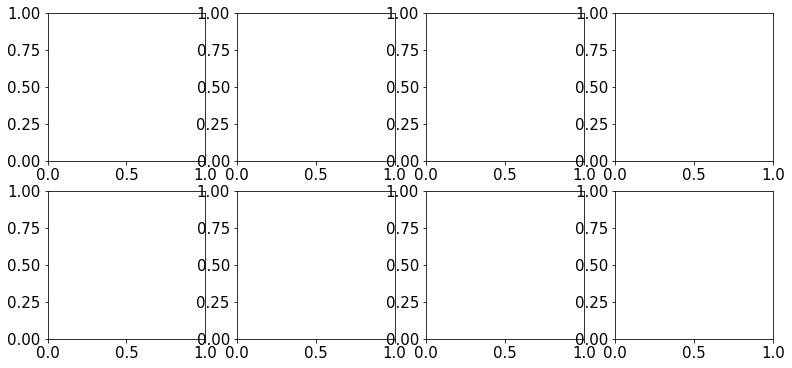

In [112]:
fig, axs = plt.subplots(2, 4, figsize=(13,6))
flatax = axs.flatten()

In [113]:
seapal = sns.color_palette("bright")
fignum = 0
for cancer in tqdm(sCIMP1):
    df_tss_distance = pd.read_csv(os.path.join(tss_dir,cancer+"_tss_distance.csv"))
    df_tss_distance = df_tss_distance.drop("Unnamed: 0",axis=1).set_index("cpg").astype(int)
    cpg_tss = df_tss_distance[df_tss_distance<5000].dropna().astype(int)
    cpg_tss = cpg_tss[cpg_tss>-1500].dropna()
    cpg_tss = cpg_tss[~cpg_tss.index.duplicated()]
    
    common_pat_clustering = consensus_clustering_spectral[cancer].loc[consensus_clustering_spectral[cancer].index.intersection(high_conf_patients[cancer])]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    cl_1_mean = new_meth_data_pc[cancer].loc[ind_cl_1].mean()
    cl_2_mean = new_meth_data_pc[cancer].loc[ind_cl_2].mean()
    cl_3_mean = new_meth_data_pc[cancer].loc[ind_cl_3].mean()
    normal_mean = normal_meth[cancer].mean()
    if cancer in triple_cluster_cancers_aff:
        full_cpg_island_df= pd.concat([cpg_tss,cl_1_mean,cl_2_mean,cl_3_mean,normal_mean],axis=1,join="inner").dropna()
        full_cpg_island_df.columns = list(cpg_tss.columns) + ["Low meth", "Intermediate meth", "High meth", "Normal"]
    else:
        full_cpg_island_df= pd.concat([cpg_tss,cl_1_mean,cl_2_mean,normal_mean],axis=1,join="inner").dropna()
        full_cpg_island_df.columns = list(cpg_tss.columns) + ["Low meth", "High meth", "Normal"]
    mean_cgi_meth = full_cpg_island_df.groupby(["distance"]).mean().reset_index()
    mean_cgi_meth["distance"] = mean_cgi_meth["distance"].astype("int").apply(lambda x: x//100)
    mean_cgi_meth = mean_cgi_meth.groupby(["distance"]).mean()
    print(cancer)
    
    sns.lineplot(data=mean_cgi_meth,x="distance",y="Low meth",color=seapal[0],ax=flatax[fignum],label="Low meth cluster")
    if cancer in triple_cluster_cancers_aff:
        sns.lineplot(data=mean_cgi_meth,x="distance",y="Intermediate meth",color=seapal[8],ax=flatax[fignum], label="Intermediate meth cluster")
    sns.lineplot(data=mean_cgi_meth,x="distance",y="High meth",color=seapal[3],ax=flatax[fignum], label="High meth cluster")
    sns.lineplot(data=mean_cgi_meth,x="distance",y="Normal",color=seapal[7],ax=flatax[fignum], label="Normal tissue")
    flatax[fignum].set_title(cancer+" average methylation over CGI",fontsize=18)
    flatax[fignum].set_ylabel("Methylation (beta)",fontsize=15)
    flatax[fignum].set_xlim([0,50])
    flatax[fignum].set_ylim([0,0.85])
    fignum+=1

ACC
COAD
KIRP
LAML
LGG
MESO
SKCM
STAD



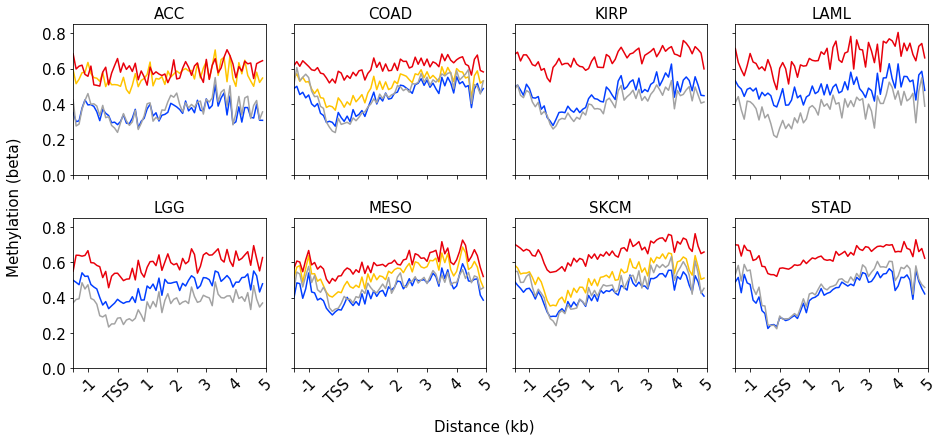

In [114]:
# visualization
# lines, labels = flatax[0].get_legend_handles_labels()
for i,cancer in enumerate(sCIMP1):
    a = flatax[i]
    a.set_ylabel('') 
    a.set_xticks([-15,-10,0,10,20,30,40,50])
    if i in [4,5,6,7]:
        a.set_xticklabels(["","-1","TSS","1","2","3","4","5"],rotation=45,rotation_mode="default")
    else:
        a.set_xticklabels([])
    
    if not(i in [0,4]):
        a.set_yticklabels([])
       
    a.set_title(cancer,fontsize=15)
    a.set_xlabel('')
    a.legend_=None
fig.text(0.5, -0.02, 'Distance (kb)', ha='center')
fig.text(-0.01, 0.5, 'Methylation (beta)', va='center', rotation='vertical')
# flatax[-1].axis("off")
# fig.legend(lines, labels, loc = 'center right', bbox_to_anchor = (1.2,0,1,1),
#             bbox_transform = plt.gcf().transFigure,fontsize=15,frameon=False)
fig.tight_layout()
fig

In [115]:
fig.savefig("TSS_signature_sCIMP1.png",bbox_inches='tight')
fig.savefig("TSS_signature_sCIMP1.svg",bbox_inches='tight')

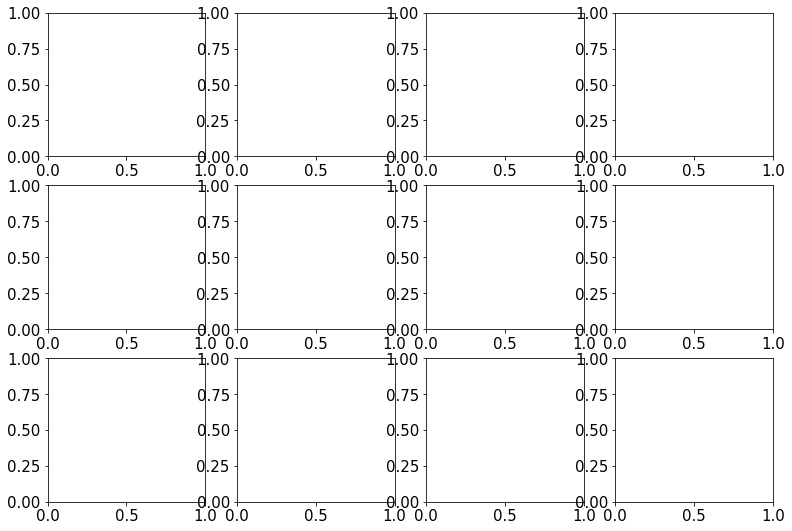

In [120]:
fig, axs = plt.subplots(3, 4, figsize=(13,9))
flatax = axs.flatten()

In [121]:
seapal = sns.color_palette("bright")
fignum = 0
for cancer in tqdm(sCIMP2):
    df_tss_distance = pd.read_csv(os.path.join(tss_dir,cancer+"_tss_distance.csv"))
    df_tss_distance = df_tss_distance.drop("Unnamed: 0",axis=1).set_index("cpg").astype(int)
    cpg_tss = df_tss_distance[df_tss_distance<5000].dropna().astype(int)
    cpg_tss = cpg_tss[cpg_tss>-1500].dropna()
    cpg_tss = cpg_tss[~cpg_tss.index.duplicated()]
    
    common_pat_clustering = consensus_clustering_spectral[cancer].loc[consensus_clustering_spectral[cancer].index.intersection(high_conf_patients[cancer])]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    cl_1_mean = new_meth_data_pc[cancer].loc[ind_cl_1].mean()
    cl_2_mean = new_meth_data_pc[cancer].loc[ind_cl_2].mean()
    cl_3_mean = new_meth_data_pc[cancer].loc[ind_cl_3].mean()
    normal_mean = normal_meth[cancer].mean()
    if cancer in triple_cluster_cancers_aff:
        full_cpg_island_df= pd.concat([cpg_tss,cl_1_mean,cl_2_mean,cl_3_mean,normal_mean],axis=1,join="inner").dropna()
        full_cpg_island_df.columns = list(cpg_tss.columns) + ["Low meth", "Intermediate meth", "High meth", "Normal"]
    else:
        full_cpg_island_df= pd.concat([cpg_tss,cl_1_mean,cl_2_mean,normal_mean],axis=1,join="inner").dropna()
        full_cpg_island_df.columns = list(cpg_tss.columns) + ["Low meth", "High meth", "Normal"]
    mean_cgi_meth = full_cpg_island_df.groupby(["distance"]).mean().reset_index()
    mean_cgi_meth["distance"] = mean_cgi_meth["distance"].astype("int").apply(lambda x: x//100)
    mean_cgi_meth = mean_cgi_meth.groupby(["distance"]).mean()
    print(cancer)
    
    sns.lineplot(data=mean_cgi_meth,x="distance",y="Low meth",color=seapal[0],ax=flatax[fignum],label="Low meth cluster")
    if cancer in triple_cluster_cancers_aff:
        sns.lineplot(data=mean_cgi_meth,x="distance",y="Intermediate meth",color=seapal[8],ax=flatax[fignum], label="Intermediate meth cluster")
    sns.lineplot(data=mean_cgi_meth,x="distance",y="High meth",color=seapal[3],ax=flatax[fignum], label="High meth cluster")
    sns.lineplot(data=mean_cgi_meth,x="distance",y="Normal",color=seapal[7],ax=flatax[fignum], label="Normal tissue")
    flatax[fignum].set_title(cancer+" average methylation over CGI",fontsize=18)
    flatax[fignum].set_ylabel("Methylation (beta)",fontsize=15)
    flatax[fignum].set_xlim([0,50])
    flatax[fignum].set_ylim([0,0.85])
    fignum+=1

CESC
GBM
HNSC
KIRC
LIHC
LUAD
LUSC
PCPG
READ
SARC
THCA



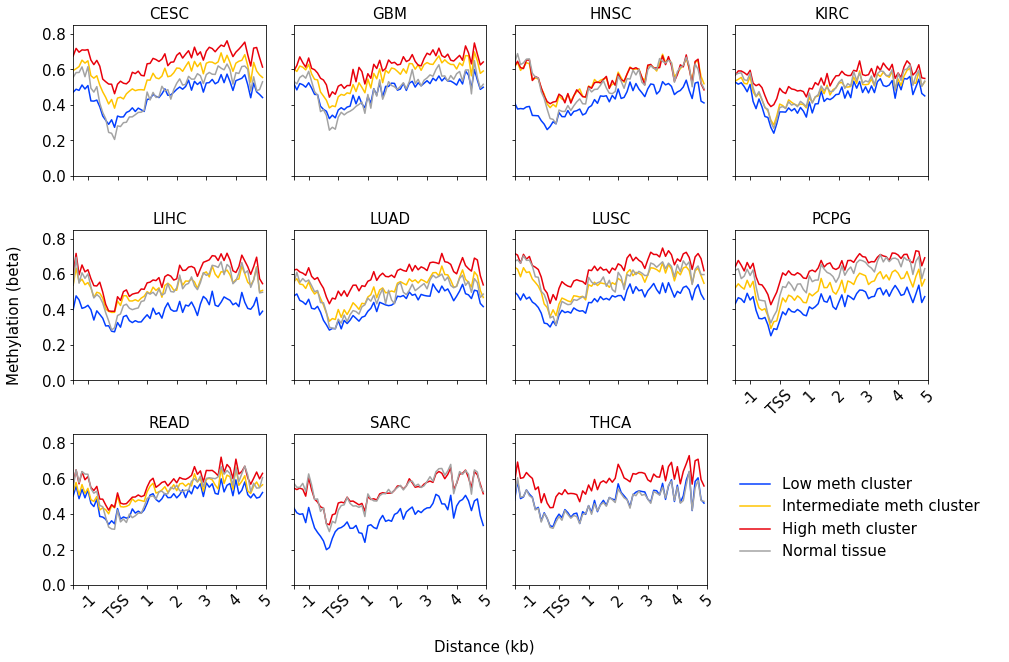

<Figure size 432x288 with 0 Axes>

In [122]:
# visualization
lines, labels = flatax[0].get_legend_handles_labels()
for i,cancer in enumerate(sCIMP2):
    a = flatax[i]
    a.set_ylabel('') 
    a.set_xticks([-15,-10,0,10,20,30,40,50])
    if i in [7,8,9,10]:
        a.set_xticklabels(["","-1","TSS","1","2","3","4","5"],rotation=45,rotation_mode="default")
    else:
        a.set_xticklabels([])
    
    if not(i in [0,4,8]):
        a.set_yticklabels([])
       
    a.set_title(cancer,fontsize=15)
    a.set_xlabel('')
    a.legend_=None
fig.text(0.5, -0.02, 'Distance (kb)', ha='center')
fig.text(-0.01, 0.5, 'Methylation (beta)', va='center', rotation='vertical')
flatax[-1].axis("off")
fig.legend(lines, labels, loc = 'center right', bbox_to_anchor = (1.3,0,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=15,frameon=False)
fig.tight_layout()
fig

In [123]:
fig.savefig("TSS_signature_sCIMP2.png",bbox_inches='tight')
fig.savefig("TSS_signature_sCIMP2.svg",bbox_inches='tight')

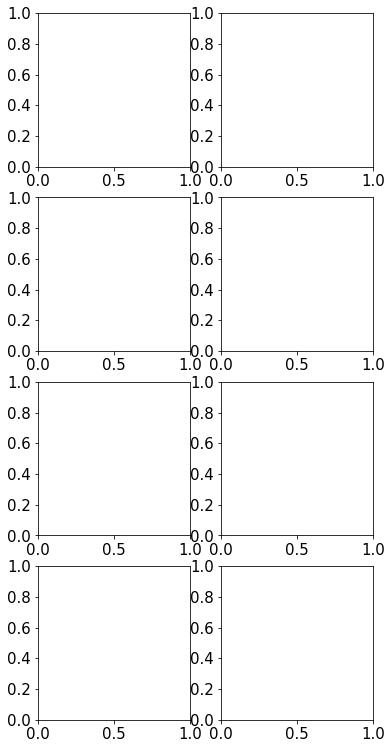

In [130]:
fig, axs = plt.subplots(4, 2, figsize=(6,13))

In [131]:
flatax = axs.flatten()
seapal = sns.color_palette("bright")
fignum = 0
for cancer in tqdm(nonCIMP):
    df_tss_distance = pd.read_csv(os.path.join(tss_dir,cancer+"_tss_distance.csv"))
    df_tss_distance = df_tss_distance.drop("Unnamed: 0",axis=1).set_index("cpg").astype(int)
    cpg_tss = df_tss_distance[df_tss_distance<5000].dropna().astype(int)
    cpg_tss = cpg_tss[cpg_tss>-1500].dropna()
    cpg_tss = cpg_tss[~cpg_tss.index.duplicated()]
    
    common_pat_clustering = consensus_clustering_spectral[cancer].loc[consensus_clustering_spectral[cancer].index.intersection(high_conf_patients[cancer])]
    ind_cl_1 = common_pat_clustering[common_pat_clustering["cluster"]==1].index
    ind_cl_2 = common_pat_clustering[common_pat_clustering["cluster"]==2].index
    ind_cl_3 = common_pat_clustering[common_pat_clustering["cluster"]==3].index
    cl_1_mean = new_meth_data_pc[cancer].loc[ind_cl_1].mean()
    cl_2_mean = new_meth_data_pc[cancer].loc[ind_cl_2].mean()
    cl_3_mean = new_meth_data_pc[cancer].loc[ind_cl_3].mean()
    normal_mean = normal_meth[cancer].mean()
    if cancer in triple_cluster_cancers_aff:
        full_cpg_island_df= pd.concat([cpg_tss,cl_1_mean,cl_2_mean,cl_3_mean,normal_mean],axis=1,join="inner").dropna()
        full_cpg_island_df.columns = list(cpg_tss.columns) + ["Low meth", "Intermediate meth", "High meth", "Normal"]
    else:
        full_cpg_island_df= pd.concat([cpg_tss,cl_1_mean,cl_2_mean,normal_mean],axis=1,join="inner").dropna()
        full_cpg_island_df.columns = list(cpg_tss.columns) + ["Low meth", "High meth", "Normal"]
    mean_cgi_meth = full_cpg_island_df.groupby(["distance"]).mean().reset_index()
    mean_cgi_meth["distance"] = mean_cgi_meth["distance"].astype("int").apply(lambda x: x//100)
    mean_cgi_meth = mean_cgi_meth.groupby(["distance"]).mean()
    print(cancer)
    sns.lineplot(data=mean_cgi_meth,x="distance",y="Low meth",color=seapal[0],ax=flatax[fignum],label="Low meth cluster")
    if cancer in triple_cluster_cancers_aff:
        sns.lineplot(data=mean_cgi_meth,x="distance",y="Intermediate meth",color=seapal[8],ax=flatax[fignum], label="Intermediate meth cluster")
    sns.lineplot(data=mean_cgi_meth,x="distance",y="High meth",color=seapal[3],ax=flatax[fignum], label="High meth cluster")
    sns.lineplot(data=mean_cgi_meth,x="distance",y="Normal",color=seapal[7],ax=flatax[fignum], label="Normal meth cluster")
    flatax[fignum].set_title(cancer+" average methylation over CGI",fontsize=15)
    flatax[fignum].set_ylabel("Methylation (beta)",fontsize=15)
    flatax[fignum].set_xlim([0,50])
    flatax[fignum].set_ylim([0,0.85])
    fignum+=1

BLCA
BRCA
ESCA
PAAD
PRAD
THYM
UCEC



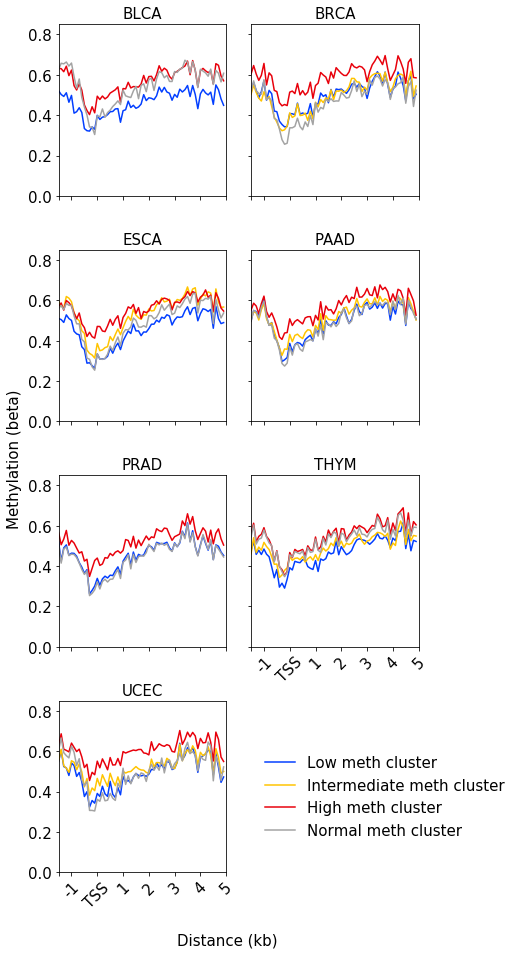

<Figure size 432x288 with 0 Axes>

In [132]:
# visualization
lines, labels = flatax[-2].get_legend_handles_labels()
for i,cancer in enumerate(nonCIMP):
    a = flatax[i]
    a.set_ylabel('') 
    a.set_xticks([-15,-10,0,10,20,30,40,50])
    if i in [5,6]:
        a.set_xticklabels(["","-1","TSS","1","2","3","4","5"],rotation=45,rotation_mode="default")
    else:
        a.set_xticklabels([])
    
    if not(i in [0,2,4,6]):
        a.set_yticklabels([])
       
    a.set_title(cancer,fontsize=15)
    a.set_xlabel('')
    a.legend_=None
fig.text(0.5, -0.02, 'Distance (kb)', ha='center')
fig.text(-0.01, 0.5, 'Methylation (beta)', va='center', rotation='vertical')
flatax[-1].axis("off")
fig.legend(lines, labels, loc = 'center right', bbox_to_anchor = (0.2,0.05,1,1),
            bbox_transform = plt.gcf().transFigure,fontsize=15,frameon=False)
fig.tight_layout()
fig

In [133]:
fig.savefig("TSS_signature_nonCIMP.png",bbox_inches='tight')
fig.savefig("TSS_signature_nonCIMP.svg",bbox_inches='tight')

## Clustering method comparison

In [8]:
from scipy.spatial.distance import cdist, hamming
import networkx as nx
from community import community_louvain
import snf
from snf import metrics

In [9]:
def get_consensus_matrix_community(meth_data_pc,graphs_snf,cancer_to_keep,res_list,n_runs):
    #     Parameters: meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
    #             cancer_to_keep (list): names of cancer types
    #             graphs_snf (dict): keys are cancer types, values are networkx graphs 
    #             res_list (list): list of resolution to use in the Louvain community detection algorithm for each cancer type (type float)
    #             n_runs (int): number of runs for consensus clustering 
    #     Returns: consensus_matrix (pd.DataFrame): df with the cluster membership for each run (n_patients, n_runs)
    consensus_matrix = {cancer: [] for cancer in cancer_to_keep}
    for r in tqdm(range(n_runs)):
        clusters_louvain_snf = {}
        for i,cancer in enumerate(cancer_to_keep):
            print(cancer)
            clusters_louvain_snf[cancer]=compute_clusters_community(graphs_snf[cancer], res_list[i])
        df_louvain_snf = {}
        for cancer in cancer_to_keep:
            df_louvain_snf[cancer] = pd.DataFrame(np.zeros((len(list(meth_data_pc[cancer].index)),1)),index=list(meth_data_pc[cancer].index),columns=["cluster"])
            for cluster in clusters_louvain_snf[cancer]:
                for pat in clusters_louvain_snf[cancer][cluster]:
                    df_louvain_snf[cancer].loc[pat]=cluster
            df_louvain_snf[cancer]=df_louvain_snf[cancer].reset_index(drop=True)
            if len(consensus_matrix[cancer])==0:
                consensus_matrix[cancer] = df_louvain_snf[cancer]
            else:
                consensus_matrix[cancer] = pd.concat([consensus_matrix[cancer],df_louvain_snf[cancer]],axis=1)
    return consensus_matrix

In [10]:
def graph_of_patients(patient_ids,sim_matrix):
#     Constructs the graph of UDN patients using the similarity matrix computed: nodes are patients, 
#                 edges between patient i and j is proportional to the similarity between these two patients
#     Parameters: patients (list): list of UDN IDs of patients to consider
#                 sim_matrix (np.ndarray): array, similarity matrix of pairwise similarity between each patient
#     Returns : G (networkx.Graph): networkx graph of UDN patients 
#               pos (np.ndarray): positions of nodes 
    G= nx.Graph()
    elist=[]
    for i in range(sim_matrix.shape[0]):
        G.add_node(patient_ids[i])
        for j in range(i,sim_matrix.shape[1]):
            elist.append((patient_ids[i],patient_ids[j],sim_matrix[i,j]))
    G.add_weighted_edges_from(elist)
    return G

In [11]:
def compute_clusters_community(graph,resolution):
#     Compute the clusters in a graph using Louvain's community detection method
#     Parameters : graph (networkx.Graph): graph of UDN patients computed using the pairwise 
#                                 similarity between patients
#                 resolution (float): resolution for the Louvain method
#     Returns: clusters (dict): dictionary with the cluster number as key and a list containing all 
#                                 the patients in the cluster as value
    
    partition = community_louvain.best_partition(graph,resolution=resolution)
    clusters={}
    for node in partition.keys():
        if not(partition[node] in clusters.keys()):
            clusters[partition[node]]=[node]
        else:
            clusters[partition[node]].append(node)
    count=0
    for cluster in clusters.keys():
        print("Length of cluster {} : {}".format(cluster,len(clusters[cluster])))
        if len(clusters[cluster])<=1:
            count+=1
    print("Number of clusters with less than 3 patients (outliers) : {}".format(count))
    return clusters

In [22]:
# get the affinity matrix with manhattan distance
aff_mat = {}
for cancer in tqdm(cancer_to_keep):
    aff_mat[cancer] = snf.make_affinity(new_meth_data_pc[cancer].values,metric="cityblock",K=50)

graphs_snf = {}
for cancer in cancer_to_keep:
    graphs_snf[cancer] = graph_of_patients(list(new_meth_data_pc[cancer].index),aff_mat[cancer])

In [128]:
# if need to test what resolution for what cancer type
clusters_louvain_snf_test=compute_clusters_community(graphs_snf["CESC"], 1.15)

Length of cluster 0 : 112
Length of cluster 1 : 88
Length of cluster 2 : 109
Number of clusters with less than 3 patients (outliers) : 0


In [117]:
res_list = [1.27, 1.25, 1.1, 1.15, 1.1, 1.2, 1.25, 1.15, 1.13, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.35, 1.25, 1.15, 1.3, 1.25, 1.3, 1.1, 1.35, 1.1, 1.25, 1.1]

consensus_matrix_meth = get_consensus_matrix_community(new_meth_data_pc,graphs_snf,cancer_to_keep,res_list,10)

ACC
Length of cluster 0 : 38
Length of cluster 1 : 40
Length of cluster 2 : 2
Number of clusters with less than 3 patients (outliers) : 0
BLCA
Length of cluster 0 : 227
Length of cluster 1 : 186
Number of clusters with less than 3 patients (outliers) : 0
BRCA
Length of cluster 0 : 153
Length of cluster 1 : 313
Length of cluster 2 : 172
Length of cluster 3 : 149
Number of clusters with less than 3 patients (outliers) : 0
CESC
Length of cluster 0 : 112
Length of cluster 1 : 88
Length of cluster 2 : 109
Number of clusters with less than 3 patients (outliers) : 0
COAD
Length of cluster 0 : 92
Length of cluster 1 : 108
Length of cluster 2 : 98
Number of clusters with less than 3 patients (outliers) : 0
ESCA
Length of cluster 0 : 82
Length of cluster 1 : 68
Length of cluster 2 : 36
Number of clusters with less than 3 patients (outliers) : 0
GBM
Length of cluster 0 : 61
Length of cluster 1 : 83
Length of cluster 2 : 9
Number of clusters with less than 3 patients (outliers) : 0
HNSC
Length of 

Length of cluster 0 : 156
Length of cluster 1 : 142
Length of cluster 2 : 22
Number of clusters with less than 3 patients (outliers) : 0
KIRP
Length of cluster 0 : 228
Length of cluster 1 : 48
Number of clusters with less than 3 patients (outliers) : 0
LAML
Length of cluster 0 : 61
Length of cluster 1 : 79
Number of clusters with less than 3 patients (outliers) : 0
LGG
Length of cluster 0 : 405
Length of cluster 1 : 125
Number of clusters with less than 3 patients (outliers) : 0
LIHC
Length of cluster 0 : 80
Length of cluster 1 : 157
Length of cluster 2 : 142
Number of clusters with less than 3 patients (outliers) : 0
LUAD
Length of cluster 0 : 97
Length of cluster 1 : 176
Length of cluster 2 : 187
Number of clusters with less than 3 patients (outliers) : 0
LUSC
Length of cluster 0 : 150
Length of cluster 1 : 140
Length of cluster 2 : 80
Number of clusters with less than 3 patients (outliers) : 0
MESO
Length of cluster 0 : 20
Length of cluster 1 : 34
Length of cluster 2 : 33
Number of 

Length of cluster 0 : 212
Length of cluster 1 : 287
Number of clusters with less than 3 patients (outliers) : 0
READ
Length of cluster 0 : 36
Length of cluster 1 : 47
Length of cluster 2 : 16
Number of clusters with less than 3 patients (outliers) : 0
SARC
Length of cluster 0 : 149
Length of cluster 1 : 116
Number of clusters with less than 3 patients (outliers) : 0
SKCM
Length of cluster 0 : 50
Length of cluster 1 : 203
Length of cluster 2 : 220
Number of clusters with less than 3 patients (outliers) : 0
STAD
Length of cluster 0 : 362
Length of cluster 1 : 33
Number of clusters with less than 3 patients (outliers) : 0
THCA
Length of cluster 0 : 304
Length of cluster 1 : 211
Number of clusters with less than 3 patients (outliers) : 0
THYM
Length of cluster 0 : 59
Length of cluster 1 : 46
Length of cluster 2 : 19
Number of clusters with less than 3 patients (outliers) : 0
UCEC
Length of cluster 0 : 158
Length of cluster 1 : 124
Length of cluster 2 : 150
Number of clusters with less than

Length of cluster 0 : 227
Length of cluster 1 : 186
Number of clusters with less than 3 patients (outliers) : 0
BRCA
Length of cluster 0 : 153
Length of cluster 1 : 313
Length of cluster 2 : 172
Length of cluster 3 : 149
Number of clusters with less than 3 patients (outliers) : 0
CESC
Length of cluster 0 : 129
Length of cluster 1 : 180
Number of clusters with less than 3 patients (outliers) : 0
COAD
Length of cluster 0 : 92
Length of cluster 1 : 108
Length of cluster 2 : 98
Number of clusters with less than 3 patients (outliers) : 0
ESCA
Length of cluster 0 : 78
Length of cluster 1 : 68
Length of cluster 2 : 40
Number of clusters with less than 3 patients (outliers) : 0
GBM
Length of cluster 0 : 61
Length of cluster 1 : 92
Number of clusters with less than 3 patients (outliers) : 0
HNSC
Length of cluster 0 : 31
Length of cluster 1 : 260
Length of cluster 2 : 239
Number of clusters with less than 3 patients (outliers) : 0
KIRC
Length of cluster 0 : 156
Length of cluster 1 : 141
Length o

Length of cluster 0 : 405
Length of cluster 1 : 125
Number of clusters with less than 3 patients (outliers) : 0
LIHC
Length of cluster 0 : 80
Length of cluster 1 : 157
Length of cluster 2 : 142
Number of clusters with less than 3 patients (outliers) : 0
LUAD
Length of cluster 0 : 97
Length of cluster 1 : 176
Length of cluster 2 : 187
Number of clusters with less than 3 patients (outliers) : 0
LUSC
Length of cluster 0 : 150
Length of cluster 1 : 140
Length of cluster 2 : 80
Number of clusters with less than 3 patients (outliers) : 0
MESO
Length of cluster 0 : 37
Length of cluster 1 : 50
Number of clusters with less than 3 patients (outliers) : 0
PAAD
Length of cluster 0 : 74
Length of cluster 1 : 6
Length of cluster 2 : 105
Number of clusters with less than 3 patients (outliers) : 0
PCPG
Length of cluster 0 : 69
Length of cluster 1 : 61
Length of cluster 2 : 6
Length of cluster 3 : 9
Length of cluster 4 : 7
Number of clusters with less than 3 patients (outliers) : 0
PRAD
Length of clust

In [136]:
from netneurotools import cluster
louvain_clustering_pc = {}
for cancer in cancer_to_keep:
    louvain_clustering_pc[cancer] = pd.DataFrame(cluster.find_consensus(consensus_matrix_meth[cancer].values, seed=1234),columns=["cluster"])
louvain_clustering_pc["BRCA"] = louvain_clustering_pc["BRCA"].replace({4: 3})
louvain_clustering_pc["PCPG"] = louvain_clustering_pc["PCPG"].replace({4: 3})

In [137]:
for cancer in cancer_to_keep:
    print(cancer,Counter(louvain_clustering_pc[cancer]["cluster"].values.ravel()))

ACC Counter({2: 40, 1: 39, 3: 1})
BLCA Counter({1: 229, 2: 184})
BRCA Counter({3: 321, 2: 313, 1: 153})
CESC Counter({1: 117, 3: 106, 2: 86})
COAD Counter({2: 108, 3: 98, 1: 92})
ESCA Counter({1: 82, 2: 68, 3: 36})
GBM Counter({2: 78, 1: 65, 3: 10})
HNSC Counter({3: 224, 2: 217, 1: 89})
KIRC Counter({1: 156, 2: 142, 3: 22})
KIRP Counter({1: 228, 2: 48})
LAML Counter({2: 76, 1: 64})
LGG Counter({1: 405, 2: 125})
LIHC Counter({2: 157, 3: 142, 1: 80})
LUAD Counter({3: 187, 2: 176, 1: 97})
LUSC Counter({1: 150, 2: 140, 3: 80})
MESO Counter({2: 46, 1: 36, 3: 5})
PAAD Counter({3: 105, 1: 74, 2: 6})
PCPG Counter({1: 70, 3: 43, 2: 39})
PRAD Counter({2: 313, 1: 186})
READ Counter({2: 39, 1: 35, 3: 25})
SARC Counter({1: 149, 2: 116})
SKCM Counter({3: 216, 2: 184, 1: 73})
STAD Counter({2: 208, 1: 187})
THCA Counter({1: 304, 2: 211})
THYM Counter({1: 59, 2: 40, 3: 25})
UCEC Counter({1: 158, 3: 150, 2: 124})


Get the membership for all clustering methods

In [142]:
# 5D UMAP for GMM
meth_data_red = {}
for cancer in tqdm(cancer_to_keep):
    reducer = umap.UMAP(n_components=5)
    meth_data_red[cancer] = reducer.fit_transform(df_transf_data[cancer])

In [143]:
agglomerative_clustering_pc = {}
for cancer in tqdm(cancer_to_keep):
    if cancer in triple_cluster_cancers_aff:
        agglomerative = AgglomerativeClustering(n_clusters=3)
    else:
        agglomerative = AgglomerativeClustering(n_clusters=2)
    agglomerative.fit(new_meth_data_pc[cancer])
    agglomerative_clustering_pc[cancer] = pd.DataFrame(agglomerative.labels_,columns=["cluster"])
    agglomerative_clustering_pc[cancer] = agglomerative_clustering_pc[cancer]+1

In [144]:
kmeans_clustering_pc = {}
for cancer in tqdm(cancer_to_keep):
    if cancer in triple_cluster_cancers_aff:
        kmeans = KMeans(n_clusters=3)
    else:
        kmeans = KMeans(n_clusters=2)
    kmeans.fit(new_meth_data_pc[cancer])
    kmeans_clustering_pc[cancer] = pd.DataFrame(kmeans.labels_,columns=["cluster"])
    kmeans_clustering_pc[cancer] = kmeans_clustering_pc[cancer]+1

In [145]:
gmm_clustering_pc = []
for cancer in tqdm(cancer_to_keep):
    if cancer in triple_cluster_cancers_aff:
        bgm = GaussianMixture(n_components=3, random_state=42, covariance_type="diag")
    else:
        bgm = GaussianMixture(n_components=2, random_state=42, covariance_type="diag")
    labels = bgm.fit_predict(meth_data_red[cancer])
    prob_labels = bgm.predict_proba(meth_data_red[cancer])
    labels_conf = [prob_labels[i][labels[i]]*100 for i in range(len(labels))]
    labels = labels+1
    if len(gmm_clustering_pc)==0:
        gmm_clustering_pc = pd.concat([pd.DataFrame(umap_red_data[cancer],index=new_meth_data_pc[cancer].index,columns=["Comp1","Comp2"]),
           pd.DataFrame(labels,index=new_meth_data_pc[cancer].index,columns=["Cluster"]),
            pd.DataFrame(labels_conf,index=new_meth_data_pc[cancer].index,columns=["Confidence"]),
            pd.DataFrame([cancer]*new_meth_data_pc[cancer].shape[0],index=new_meth_data_pc[cancer].index,columns=["Cancer"])],axis=1)
    else:
        df = pd.concat([pd.DataFrame(umap_red_data[cancer],index=new_meth_data_pc[cancer].index,columns=["Comp1","Comp2"]),
           pd.DataFrame(labels,index=new_meth_data_pc[cancer].index,columns=["Cluster"]),
            pd.DataFrame(labels_conf,index=new_meth_data_pc[cancer].index,columns=["Confidence"]),
            pd.DataFrame([cancer]*new_meth_data_pc[cancer].shape[0],index=new_meth_data_pc[cancer].index,columns=["Cancer"])],axis=1)
        gmm_clustering_pc = pd.concat([gmm_clustering_pc,df])

In [146]:
gmm_clustering_pc = {cancer: pd.DataFrame(gmm_clustering_pc[gmm_clustering_pc["Cancer"]==cancer]["Cluster"].values.ravel(),index=new_meth_data_pc[cancer].index,columns=["cluster"]) for cancer in cancer_to_keep}

In [147]:
sign_cpg_dir = "C:\\Users\\josep\\Documents\\ETHZ\\Boeva_lab\\CIMP_unsupervised_cancer\\code\\sign_cpg_spectral"
def get_sign_kw_louvain(meth_data_pc, cancer_to_keep, consensus_clustering):
#     Parameters: meth_data_pc (dict): keys are cancer types, values are pd.DataFrame (n_pat,n_cpg) (rows=patients,columns=cpg)
#             cancer_to_keep (list): names of cancer types
#             consensus_clustering (dict): keys are cancer types, values are pd.DataFrame (n_pat,1) (rows=patients, column=cluster membership)
#     Returns: kw (dict): keys are cancer types, values are list of sign. cpg probes for 
    kw = {}
    for cancer in cancer_to_keep:
        kw[cancer]=[]
        positions = meth_data_pc[cancer].columns
        ind_cl_1 = np.where(consensus_clustering[cancer]["cluster"].values==1)[0]
        ind_cl_2 = np.where(consensus_clustering[cancer]["cluster"].values==2)[0]
        ind_cl_3 = np.where(consensus_clustering[cancer]["cluster"].values==3)[0]
        print(cancer)
        if len(np.unique(consensus_clustering[cancer]["cluster"].values))==2:
            meth_cl_1 = meth_data_pc[cancer].iloc[ind_cl_1].copy()
            meth_cl_2 = meth_data_pc[cancer].iloc[ind_cl_2].copy()
            for pos in tqdm(positions):
                kw[cancer].append(kruskal(meth_cl_1[pos],
                        meth_cl_2[pos])[1])
        elif len(np.unique(consensus_clustering[cancer]["cluster"].values))==3:
            meth_cl_1 = meth_data_pc[cancer].iloc[ind_cl_1].copy()
            meth_cl_2 = meth_data_pc[cancer].iloc[ind_cl_2].copy()
            meth_cl_3 = meth_data_pc[cancer].iloc[ind_cl_3].copy()
            for pos in tqdm(positions):
                kw[cancer].append(kruskal(meth_cl_1[pos],
                        meth_cl_2[pos],
                        meth_cl_3[pos])[1])
        else:
            print("The cancer {} is not taken into consideration (too many clusters)".format(cancer))
            continue
        ind_sign = np.where(np.array(kw[cancer])<(0.05/len(kw[cancer])))[0]
        print("There are {} significantly different positions between clusters for cancer type {}".format(len(ind_sign),cancer))
        sign_pos=[meth_data_pc[cancer].columns[i] for i in ind_sign]
    return kw

In [148]:
kw_agg = get_sign_kw_louvain(new_meth_data_pc, cancer_to_keep, agglomerative_clustering_pc)

ACC



There are 3732 significantly different positions between clusters for cancer type ACC
BLCA



There are 19758 significantly different positions between clusters for cancer type BLCA
BRCA



There are 21801 significantly different positions between clusters for cancer type BRCA
CESC



There are 15720 significantly different positions between clusters for cancer type CESC
COAD



There are 14481 significantly different positions between clusters for cancer type COAD
ESCA



There are 16247 significantly different positions between clusters for cancer type ESCA
GBM



There are 7607 significantly different positions between clusters for cancer type GBM
HNSC



There are 23973 significantly different positions between clusters for cancer type HNSC
KIRC



There are 8821 significantly different positions between clusters for cancer type KIRC
KIRP



There are 9206 significantly different positions between clusters for cancer type KIRP
LAML



There are 6444 significantly different positions between clusters for cancer type LAML
LGG



There are 14657 significantly different positions between clusters for cancer type LGG
LIHC



There are 23336 significantly different positions between clusters for cancer type LIHC
LUAD



There are 22286 significantly different positions between clusters for cancer type LUAD
LUSC



There are 23913 significantly different positions between clusters for cancer type LUSC
MESO



There are 612 significantly different positions between clusters for cancer type MESO
PAAD



There are 10364 significantly different positions between clusters for cancer type PAAD
PCPG



There are 8188 significantly different positions between clusters for cancer type PCPG
PRAD



There are 13941 significantly different positions between clusters for cancer type PRAD
READ



There are 2562 significantly different positions between clusters for cancer type READ
SARC



There are 15199 significantly different positions between clusters for cancer type SARC
SKCM



There are 26773 significantly different positions between clusters for cancer type SKCM
STAD



There are 21475 significantly different positions between clusters for cancer type STAD
THCA



There are 5920 significantly different positions between clusters for cancer type THCA
THYM



There are 12891 significantly different positions between clusters for cancer type THYM
UCEC



There are 16031 significantly different positions between clusters for cancer type UCEC


In [149]:
kw_kmeans = get_sign_kw_louvain(new_meth_data_pc, cancer_to_keep, kmeans_clustering_pc)

ACC



There are 3519 significantly different positions between clusters for cancer type ACC
BLCA



There are 23429 significantly different positions between clusters for cancer type BLCA
BRCA



There are 22854 significantly different positions between clusters for cancer type BRCA
CESC



There are 20531 significantly different positions between clusters for cancer type CESC
COAD



There are 13390 significantly different positions between clusters for cancer type COAD
ESCA



There are 18462 significantly different positions between clusters for cancer type ESCA
GBM



There are 9149 significantly different positions between clusters for cancer type GBM
HNSC



There are 29788 significantly different positions between clusters for cancer type HNSC
KIRC



There are 10408 significantly different positions between clusters for cancer type KIRC
KIRP



There are 9348 significantly different positions between clusters for cancer type KIRP
LAML



There are 9111 significantly different positions between clusters for cancer type LAML
LGG



There are 15494 significantly different positions between clusters for cancer type LGG
LIHC



There are 24373 significantly different positions between clusters for cancer type LIHC
LUAD



There are 23268 significantly different positions between clusters for cancer type LUAD
LUSC



There are 25214 significantly different positions between clusters for cancer type LUSC
MESO



There are 1129 significantly different positions between clusters for cancer type MESO
PAAD



There are 11679 significantly different positions between clusters for cancer type PAAD
PCPG



There are 11960 significantly different positions between clusters for cancer type PCPG
PRAD



There are 14278 significantly different positions between clusters for cancer type PRAD
READ



There are 2419 significantly different positions between clusters for cancer type READ
SARC



There are 18667 significantly different positions between clusters for cancer type SARC
SKCM



There are 28846 significantly different positions between clusters for cancer type SKCM
STAD



There are 26419 significantly different positions between clusters for cancer type STAD
THCA



There are 6749 significantly different positions between clusters for cancer type THCA
THYM



There are 14712 significantly different positions between clusters for cancer type THYM
UCEC



There are 18864 significantly different positions between clusters for cancer type UCEC


In [150]:
kw_louvain = get_sign_kw_louvain(new_meth_data_pc, cancer_to_keep, louvain_clustering_pc)

ACC



There are 2583 significantly different positions between clusters for cancer type ACC
BLCA



There are 23302 significantly different positions between clusters for cancer type BLCA
BRCA



There are 23250 significantly different positions between clusters for cancer type BRCA
CESC



There are 22902 significantly different positions between clusters for cancer type CESC
COAD



There are 17877 significantly different positions between clusters for cancer type COAD
ESCA



There are 18038 significantly different positions between clusters for cancer type ESCA
GBM



There are 10026 significantly different positions between clusters for cancer type GBM
HNSC



There are 30973 significantly different positions between clusters for cancer type HNSC
KIRC



There are 10552 significantly different positions between clusters for cancer type KIRC
KIRP



There are 8563 significantly different positions between clusters for cancer type KIRP
LAML



There are 8878 significantly different positions between clusters for cancer type LAML
LGG



There are 15843 significantly different positions between clusters for cancer type LGG
LIHC



There are 25159 significantly different positions between clusters for cancer type LIHC
LUAD



There are 23692 significantly different positions between clusters for cancer type LUAD
LUSC



There are 26939 significantly different positions between clusters for cancer type LUSC
MESO



There are 735 significantly different positions between clusters for cancer type MESO
PAAD



There are 9015 significantly different positions between clusters for cancer type PAAD
PCPG



There are 11611 significantly different positions between clusters for cancer type PCPG
PRAD



There are 14405 significantly different positions between clusters for cancer type PRAD
READ



There are 3072 significantly different positions between clusters for cancer type READ
SARC



There are 18321 significantly different positions between clusters for cancer type SARC
SKCM



There are 29447 significantly different positions between clusters for cancer type SKCM
STAD



There are 24236 significantly different positions between clusters for cancer type STAD
THCA



There are 7429 significantly different positions between clusters for cancer type THCA
THYM



There are 11997 significantly different positions between clusters for cancer type THYM
UCEC



There are 17211 significantly different positions between clusters for cancer type UCEC


In [151]:
kw_gmm = get_sign_kw_louvain(new_meth_data_pc, cancer_to_keep, gmm_clustering_pc)

ACC



There are 3359 significantly different positions between clusters for cancer type ACC
BLCA



There are 22423 significantly different positions between clusters for cancer type BLCA
BRCA



There are 22692 significantly different positions between clusters for cancer type BRCA
CESC



There are 17876 significantly different positions between clusters for cancer type CESC
COAD



There are 15326 significantly different positions between clusters for cancer type COAD
ESCA



There are 13795 significantly different positions between clusters for cancer type ESCA
GBM



There are 8039 significantly different positions between clusters for cancer type GBM
HNSC



There are 25399 significantly different positions between clusters for cancer type HNSC
KIRC



There are 9452 significantly different positions between clusters for cancer type KIRC
KIRP



There are 4914 significantly different positions between clusters for cancer type KIRP
LAML



There are 8240 significantly different positions between clusters for cancer type LAML
LGG



There are 14741 significantly different positions between clusters for cancer type LGG
LIHC



There are 23210 significantly different positions between clusters for cancer type LIHC
LUAD



There are 22958 significantly different positions between clusters for cancer type LUAD
LUSC



There are 25022 significantly different positions between clusters for cancer type LUSC
MESO



There are 759 significantly different positions between clusters for cancer type MESO
PAAD



There are 10882 significantly different positions between clusters for cancer type PAAD
PCPG



There are 11700 significantly different positions between clusters for cancer type PCPG
PRAD



There are 12228 significantly different positions between clusters for cancer type PRAD
READ



There are 3351 significantly different positions between clusters for cancer type READ
SARC



There are 9944 significantly different positions between clusters for cancer type SARC
SKCM



There are 27886 significantly different positions between clusters for cancer type SKCM
STAD



There are 23232 significantly different positions between clusters for cancer type STAD
THCA



There are 7296 significantly different positions between clusters for cancer type THCA
THYM



There are 14773 significantly different positions between clusters for cancer type THYM
UCEC



There are 13243 significantly different positions between clusters for cancer type UCEC


In [152]:
sign_pos_agglomerative = {}
for cancer in tqdm(cancer_to_keep):
    ind_sign = np.where(np.array(kw_agg[cancer])<(0.05/len(kw_agg[cancer])))[0]
    sign_pos_agglomerative[cancer] = pd.DataFrame([new_meth_data_pc[cancer].columns[i] for i in ind_sign])

In [153]:
sign_pos_kmeans = {}
for cancer in tqdm(cancer_to_keep):
    ind_sign = np.where(np.array(kw_kmeans[cancer])<(0.05/len(kw_kmeans[cancer])))[0]
    sign_pos_kmeans[cancer] = pd.DataFrame([new_meth_data_pc[cancer].columns[i] for i in ind_sign])

In [154]:
sign_pos_gmm = {}
for cancer in tqdm(cancer_to_keep):
    ind_sign = np.where(np.array(kw_gmm[cancer])<(0.05/len(kw_gmm[cancer])))[0]
    sign_pos_gmm[cancer] = pd.DataFrame([new_meth_data_pc[cancer].columns[i] for i in ind_sign])

In [155]:
sign_pos_louvain = {}
for cancer in tqdm(cancer_to_keep):
    ind_sign = np.where(np.array(kw_louvain[cancer])<(0.05/len(kw_louvain[cancer])))[0]
    sign_pos_louvain[cancer] = pd.DataFrame([new_meth_data_pc[cancer].columns[i] for i in ind_sign])

In [158]:
avg_meth_snf_agglomerative = get_avg_methylation_snf(sign_pos_agglomerative, new_meth_data_pc, agglomerative_clustering_pc, cancer_to_keep)
avg_meth_snf_agglomerative.columns=[1,2,3]

avg_meth_snf_kmeans = get_avg_methylation_snf(sign_pos_kmeans, new_meth_data_pc, kmeans_clustering_pc, cancer_to_keep)
avg_meth_snf_kmeans.columns=[1,2,3]

avg_meth_snf_gmm = get_avg_methylation_snf(sign_pos_gmm, new_meth_data_pc, gmm_clustering_pc, cancer_to_keep)
avg_meth_snf_gmm.columns=[1,2,3]

avg_meth_snf_louvain = get_avg_methylation_snf(sign_pos_louvain, new_meth_data_pc, louvain_clustering_pc, cancer_to_keep)
avg_meth_snf_louvain.columns=[1,2,3]
avg_meth_snf_louvain

1     2     3
ACC   0.59  0.25  0.41
BLCA  0.63  0.46   NaN
BRCA  0.50  0.62  0.53
CESC  0.69  0.57  0.55
COAD  0.47  0.41  0.57
ESCA  0.54  0.58  0.43
GBM   0.55  0.70  0.69
HNSC  0.57  0.64  0.50
KIRC  0.39  0.50  0.34
KIRP  0.28  0.54   NaN
LAML  0.29  0.51   NaN
LGG   0.58  0.39   NaN
LIHC  0.60  0.44  0.66
LUAD  0.54  0.48  0.62
LUSC  0.70  0.54  0.62
MESO  0.35  0.60  0.48
PAAD  0.43  0.51  0.53
PCPG  0.44  0.64  0.56
PRAD  0.51  0.59   NaN
READ  0.73  0.61  0.49
SARC  0.73  0.52   NaN
SKCM  0.56  0.64  0.47
STAD  0.36  0.53   NaN
THCA  0.30  0.39   NaN
THYM  0.51  0.65  0.62
UCEC  0.46  0.52  0.61

In [159]:
# make sure the cluster number corresponds to the average beta value (1=lowest, 3=highest)
for cancer in avg_meth_snf_agglomerative.index:
    sorted_arg = np.argsort(avg_meth_snf_agglomerative.loc[cancer])
    cl_order = {}
    for i in range(avg_meth_snf_agglomerative.loc[cancer].dropna().shape[0]):
        cl_order[sorted_arg[i+1]+1] = i+1
    agglomerative_clustering_pc[cancer] = agglomerative_clustering_pc[cancer].replace({"cluster": cl_order})
    agglomerative_clustering_pc[cancer].index = new_meth_data_pc[cancer].index

In [160]:
for cancer in avg_meth_snf_kmeans.index:
    sorted_arg = np.argsort(avg_meth_snf_kmeans.loc[cancer])
    cl_order = {}
    for i in range(avg_meth_snf_kmeans.loc[cancer].dropna().shape[0]):
        cl_order[sorted_arg[i+1]+1] = i+1
    kmeans_clustering_pc[cancer] = kmeans_clustering_pc[cancer].replace({"cluster": cl_order})
    kmeans_clustering_pc[cancer].index = new_meth_data_pc[cancer].index

In [161]:
for cancer in avg_meth_snf_gmm.index:
    sorted_arg = np.argsort(avg_meth_snf_gmm.loc[cancer])
    cl_order = {}
    for i in range(avg_meth_snf_gmm.loc[cancer].dropna().shape[0]):
        cl_order[sorted_arg[i+1]+1] = i+1
    gmm_clustering_pc[cancer] = gmm_clustering_pc[cancer].replace({"cluster": cl_order})
    gmm_clustering_pc[cancer].index = new_meth_data_pc[cancer].index

In [162]:
for cancer in avg_meth_snf_louvain.index:
    sorted_arg = np.argsort(avg_meth_snf_louvain.loc[cancer])
    cl_order = {}
    for i in range(avg_meth_snf_louvain.loc[cancer].dropna().shape[0]):
        cl_order[sorted_arg[i+1]+1] = i+1
    louvain_clustering_pc[cancer] = louvain_clustering_pc[cancer].replace({"cluster": cl_order})
    louvain_clustering_pc[cancer].index = new_meth_data_pc[cancer].index

In [163]:
# create a df with umap reduced data and cluster membership
df_umap_agglomerative,umap_red_data_pd_agg = {},{}
for cancer in cancer_to_keep:
    umap_red_data_pd_agg[cancer] = pd.DataFrame(umap_red_data[cancer],index=agglomerative_clustering_pc[cancer].index,columns=["Comp1","Comp2"])
    if cancer in triple_cluster_cancers_aff:
        df_umap_agglomerative[cancer] = pd.concat([umap_red_data_pd_agg[cancer],agglomerative_clustering_pc[cancer]],axis=1).replace({1: "Low cluster", 2: "Intermediate cluster", 3: "High cluster"})
    else:
        df_umap_agglomerative[cancer] = pd.concat([umap_red_data_pd_agg[cancer],agglomerative_clustering_pc[cancer]],axis=1).replace({1: "Low cluster", 2: "High cluster"})
    df_umap_agglomerative[cancer].columns = ["Comp1","Comp2","Cluster"]

In [164]:
# compute the associated silhouette score in the 2D UMAP reduced space
sil_scores_agg = []
sil_scores_means_agg = []
for cancer in tqdm(cancer_to_keep):
    sil_pd = pd.concat([new_meth_data_pc[cancer],agglomerative_clustering_pc[cancer]],axis=1).dropna()
    sil = silhouette_samples(sil_pd.drop("cluster",axis=1),sil_pd["cluster"].values.ravel(),metric="euclidean")
    mn = np.mean(sil)
    print(cancer,mn)
    sil_scores_agg.append(sil)
    sil_scores_means_agg.append(mn)
print("Mean {} IQR [{}-{}]".format(np.mean(sil_scores_means_agg),np.quantile(sil_scores_means_agg,0.25),np.quantile(sil_scores_means_agg,0.75)))

ACC 0.06324654487014374
BLCA 0.06659729344058928
BRCA 0.061708758191842523
CESC 0.09867973487397923
COAD 0.059874023713791254
ESCA 0.13675079338697607
GBM 0.1056659724340903
HNSC 0.06033291277434797
KIRC 0.08038028858780805
KIRP 0.24441894869826394
LAML 0.07425271582639922
LGG 0.218647927673666
LIHC 0.11169237608176281
LUAD 0.007600676485228799
LUSC 0.03893337015650793
MESO 0.08053485469852409
PAAD 0.06847838197934598
PCPG 0.09310648079363369
PRAD 0.08514222232242402
READ 0.029147446979617273
SARC 0.11441256802603933
SKCM 0.06849618473376291
STAD 0.32664354067546536
THCA 0.10651436006370145
THYM 0.28092956326057916
UCEC 0.06314000758851337

Mean 0.10558953647373091 IQR [0.06316664190892096-0.11039787207724748]


In [165]:
# compute the associated silhouette score in the 2D UMAP reduced space
sil_scores_gmm = []
sil_scores_means_gmm = []
for cancer in tqdm(cancer_to_keep):
    sil_pd = pd.concat([new_meth_data_pc[cancer],gmm_clustering_pc[cancer]],axis=1).dropna()
    sil = silhouette_samples(sil_pd.drop("cluster",axis=1),sil_pd["cluster"].values.ravel(),metric="euclidean")
    mn = np.mean(sil)
    print(cancer,mn)
    sil_scores_gmm.append(sil)
    sil_scores_means_gmm.append(mn)
print("Mean {} IQR [{}-{}]".format(np.mean(sil_scores_means_gmm),np.quantile(sil_scores_means_gmm,0.25),np.quantile(sil_scores_means_gmm,0.75)))

ACC 0.08467128871936773
BLCA 0.08970444773570255
BRCA 0.06195188166241264
CESC 0.05361167401211344
COAD 0.04599513820331481
ESCA 0.10877032563208394
GBM 0.02291614934211986
HNSC 0.05162276002740492
KIRC 0.07309441140930328
KIRP 0.37193897506227186
LAML 0.08781035676934947
LGG 0.22001214744202216
LIHC 0.10960632091055927
LUAD 0.04561967588814036
LUSC 0.05020318585142031
MESO 0.03381792385757346
PAAD 0.06082162878602364
PCPG 0.054842152710906165
PRAD 0.08886345647787312
READ 0.040372767865559295
SARC 0.03814280635920491
SKCM 0.06415865778774443
STAD 0.14725055440739754
THCA 0.06247250224614414
THYM 0.2485201623703207
UCEC 0.04335060560696274

Mean 0.09077469065935759 IQR [0.047047150115341184-0.0894941999212452]


In [166]:
# compute the associated silhouette score in the 2D UMAP reduced space
sil_scores_kmeans = []
sil_scores_means_kmeans = []
for cancer in tqdm(cancer_to_keep):
    sil_pd = pd.concat([new_meth_data_pc[cancer],kmeans_clustering_pc[cancer]],axis=1).dropna()
    sil = silhouette_samples(sil_pd.drop("cluster",axis=1),sil_pd["cluster"].values.ravel(),metric="euclidean")
    mn = np.mean(sil)
    print(cancer,mn)
    sil_scores_kmeans.append(sil)
    sil_scores_means_kmeans.append(mn)
print("Mean {} IQR [{}-{}]".format(np.mean(sil_scores_means_kmeans),np.quantile(sil_scores_means_kmeans,0.25),np.quantile(sil_scores_means_kmeans,0.75)))

ACC 0.08638549272939797
BLCA 0.11400769759733166
BRCA 0.0703692787049147
CESC 0.06961908322326825
COAD 0.06356441848344271
ESCA 0.12681287999839194
GBM 0.06838633647444498
HNSC 0.07201233956190836
KIRC 0.0887156478061961
KIRP 0.2602887432328113
LAML 0.117915632192716
LGG 0.20161638510169688
LIHC 0.1102978738765081
LUAD 0.0643209141234308
LUSC 0.057601389444524184
MESO 0.04753430952341114
PAAD 0.07056063555539824
PCPG 0.07958405961167427
PRAD 0.1140650075450806
READ 0.06701930875808751
SARC 0.11215303097690017
SKCM 0.07387793078188763
STAD 0.258537474244814
THCA 0.11013442905541991
THYM 0.30936224732005707
UCEC 0.0627422636787864

Mean 0.11067249267701927 IQR [0.0686945231616508-0.11405068005814337]


In [167]:
# compute the associated silhouette score in the 2D UMAP reduced space
sil_scores_louvain = []
sil_scores_means_louvain = []
for cancer in tqdm(cancer_to_keep):
    sil_pd = pd.concat([new_meth_data_pc[cancer],louvain_clustering_pc[cancer]],axis=1).dropna()
    sil = silhouette_samples(sil_pd.drop("cluster",axis=1),sil_pd["cluster"].values.ravel(),metric="euclidean")
    mn = np.mean(sil)
    print(cancer,mn)
    sil_scores_louvain.append(sil)
    sil_scores_means_louvain.append(mn)
print("Mean {} IQR [{}-{}]".format(np.mean(sil_scores_means_louvain),np.quantile(sil_scores_means_louvain,0.25),np.quantile(sil_scores_means_louvain,0.75)))

ACC 0.09554477184395072
BLCA 0.10518142321320988
BRCA 0.0689505616818159
CESC 0.03338148509303442
COAD 0.036081683639728745
ESCA 0.13053742086001305
GBM 0.0850209045347184
HNSC 0.003269105950792791
KIRC 0.06511879507595145
KIRP 0.25607528703897664
LAML 0.09090061071835298
LGG 0.18912609628581623
LIHC 0.07508324236297233
LUAD 0.016295689309464963
LUSC 8.032584449342085e-05
MESO 0.06641033338922106
PAAD 0.10384486528274577
PCPG 0.04640983361280052
PRAD 0.10006130231282782
READ 0.03992812799518805
SARC 0.10588406880526811
SKCM 0.02313154987601321
STAD 0.11957651007141888
THCA 0.037579266302811706
THYM 0.011779658626438271
UCEC 0.036568609371332224

Mean 0.07468544342689837 IQR [0.03620341507262961-0.10289897454026628]


In [171]:
# compute the associated silhouette score in the 2D UMAP reduced space
sil_scores = []
sil_scores_means= []
for cancer in tqdm(cancer_to_keep):
    sil_pd = pd.concat([new_meth_data_pc[cancer],consensus_clustering_spectral[cancer]],axis=1).dropna()
    sil = silhouette_samples(sil_pd.drop("cluster",axis=1),sil_pd["cluster"].values.ravel(),metric="euclidean")
    mn = np.mean(sil)
    print(cancer,mn)
    sil_scores.append(sil)
    sil_scores_means.append(mn)
print("Mean {} IQR [{}-{}]".format(np.mean(sil_scores_means),np.quantile(sil_scores_means,0.25),np.quantile(sil_scores_means,0.75)))

ACC 0.08386583948176475
BLCA 0.10717893910954022
BRCA 0.06997413007463035
CESC 0.07952435370323777
COAD 0.061362461266254456
ESCA 0.11436699610283538
GBM 0.12118481738605807
HNSC 0.09712343878180028
KIRC 0.07984903659380438
KIRP 0.37193897506227186
LAML 0.10488154726039688
LGG 0.21998592203663828
LIHC 0.10312703803590642
LUAD 0.07516587731251759
LUSC 0.05615743706688098
MESO 0.042072787771122576
PAAD 0.07321845609418533
PCPG 0.09016751611466091
PRAD 0.09138656859706015
READ 0.057601723674720814
SARC 0.06314134159230775
SKCM 0.07960626875477281
STAD 0.33381578501329545
THCA 0.13855461664955707
THYM 0.26957560304181133
UCEC 0.056320831979051834

Mean 0.11696724263681091 IQR [0.0707852115795191-0.11256998185451159]


In [172]:
pd.DataFrame(np.array([sil_scores_means,sil_scores_means_agg,sil_scores_means_kmeans,sil_scores_means_gmm,sil_scores_means_louvain]).T,columns=["spectral","agg","kmeans","gmm","louvain"],index=cancer_to_keep).round(2)

spectral   agg  kmeans   gmm  louvain
ACC       0.08  0.06    0.09  0.08     0.10
BLCA      0.11  0.07    0.11  0.09     0.11
BRCA      0.07  0.06    0.07  0.06     0.07
CESC      0.08  0.10    0.07  0.05     0.03
COAD      0.06  0.06    0.06  0.05     0.04
ESCA      0.11  0.14    0.13  0.11     0.13
GBM       0.12  0.11    0.07  0.02     0.09
HNSC      0.10  0.06    0.07  0.05     0.00
KIRC      0.08  0.08    0.09  0.07     0.07
KIRP      0.37  0.24    0.26  0.37     0.26
LAML      0.10  0.07    0.12  0.09     0.09
LGG       0.22  0.22    0.20  0.22     0.19
LIHC      0.10  0.11    0.11  0.11     0.08
LUAD      0.08  0.01    0.06  0.05     0.02
LUSC      0.06  0.04    0.06  0.05     0.00
MESO      0.04  0.08    0.05  0.03     0.07
PAAD      0.07  0.07    0.07  0.06     0.10
PCPG      0.09  0.09    0.08  0.05     0.05
PRAD      0.09  0.09    0.11  0.09     0.10
READ      0.06  0.03    0.07  0.04     0.04
SARC      0.06  0.11    0.11  0.04     0.11
SKCM      0.08  0.07    0.07  0.06     0.02
STAD      0.33  0.33    0.26  0.15     0.12
THCA      0.14  0.11    0.11  0.06     0.04
THYM      0.27  0.28    0.31  0.25     0.01
UCEC      0.06  0.06    0.06  0.04     0.04

# Comparison of breaking into 2 or 3 clusters

We break all the cancer types into 2 or 3 clusters, and choose the breakdown that maximizes the separability between the low and high methylated cluster ie the highest difference in average beta values

(We run the same pipeline, these are only the results)

In [102]:
# 2 clusters
cimp_cancer_wdiff = []
for cancer in cancer_order[:13]:
    distmethcancer = dist_meth_spectral_1[dist_meth_spectral_1["cancer"]==cancer]
    cl1_avg = distmethcancer[distmethcancer["cluster"]=="Low cluster"]["beta"].mean()
    cl2_avg = distmethcancer[distmethcancer["cluster"]=="High cluster"]["beta"].mean()
    print("Cancer {} diff between cluster avg : {} & high group value : {}".format(cancer,cl2_avg-cl1_avg,cl2_avg))
    if cl2_avg-cl1_avg>0.15:
        cimp_cancer_wdiff.append(cancer)
cimp_cancer_wdiff

Cancer KIRP diff between cluster avg : 0.571672582054757 & high group value : 0.7103734601012953
Cancer SARC diff between cluster avg : 0.5065597835066851 & high group value : 0.7713554326007444
Cancer MESO diff between cluster avg : 0.30042575283769185 & high group value : 0.6013891394980647
Cancer LAML diff between cluster avg : 0.403269450527179 & high group value : 0.706134179806963
Cancer STAD diff between cluster avg : 0.34158881873138697 & high group value : 0.6253128230439
Cancer ACC diff between cluster avg : 0.3284086032271885 & high group value : 0.580800973043221
Cancer READ diff between cluster avg : 0.24281497039125743 & high group value : 0.7875081439157572
Cancer GBM diff between cluster avg : 0.1981064971756309 & high group value : 0.7219183077407952
Cancer HNSC diff between cluster avg : 0.24886407833236956 & high group value : 0.6264694886054609
Cancer PCPG diff between cluster avg : 0.28618054705044943 & high group value : 0.5457962886930224
Cancer THCA diff between

['KIRP',
 'SARC',
 'MESO',
 'LAML',
 'STAD',
 'ACC',
 'READ',
 'GBM',
 'HNSC',
 'PCPG',
 'THCA',
 'COAD',
 'KIRC']

In [76]:
# 3 clusters
# look for differences in group average beta value to characterize into sCIMP and wCIMP
cimp_cancer_wdiff = []
for cancer in cancer_order[:13]:
    distmethcancer = dist_meth_spectral_1[dist_meth_spectral_1["cancer"]==cancer]
    cl1_avg = distmethcancer[distmethcancer["cluster"]=="Low cluster"]["beta"].mean()
    cl2_avg = distmethcancer[distmethcancer["cluster"]=="High cluster"]["beta"].mean()
    print("Cancer {} diff between cluster avg : {} & high group value : {}".format(cancer,cl2_avg-cl1_avg,cl2_avg))
    if cl2_avg-cl1_avg>0.15:
        cimp_cancer_wdiff.append(cancer)
cimp_cancer_wdiff

Cancer MESO diff between cluster avg : 0.37587247603547896 & high group value : 0.6176358681303492
Cancer KIRP diff between cluster avg : 0.42114433427838316 & high group value : 0.6669341706582298
Cancer ACC diff between cluster avg : 0.39695018036596463 & high group value : 0.643209139322182
Cancer READ diff between cluster avg : 0.3057781682928052 & high group value : 0.77511388253252
Cancer SARC diff between cluster avg : 0.36860594392761203 & high group value : 0.7761927772135032
Cancer PCPG diff between cluster avg : 0.3322622237360764 & high group value : 0.7328357224864477
Cancer CESC diff between cluster avg : 0.28142884393157297 & high group value : 0.7281820169627773
Cancer LUSC diff between cluster avg : 0.24913078673410344 & high group value : 0.7196182297302186
Cancer LIHC diff between cluster avg : 0.3210357266576564 & high group value : 0.6858286476540971
Cancer STAD diff between cluster avg : 0.32156479045092967 & high group value : 0.6459094934715217
Cancer COAD diff 

['MESO',
 'KIRP',
 'ACC',
 'READ',
 'SARC',
 'PCPG',
 'CESC',
 'LUSC',
 'LIHC',
 'STAD',
 'COAD',
 'KIRC',
 'GBM']

In [103]:
# 2 clusters
cimp_cancer_wdiff= []
# for cancer in cancer_to_keep:
for cancer in cancer_order[13:]:
    distmethcancer = dist_meth_spectral_2[dist_meth_spectral_2["cancer"]==cancer]
    cl1_avg = distmethcancer[distmethcancer["cluster"]=="Low cluster"]["beta"].mean()
    cl2_avg = distmethcancer[distmethcancer["cluster"]=="High cluster"]["beta"].mean()
    print("Cancer {} diff between cluster avg : {} & high group value : {}".format(cancer,cl2_avg-cl1_avg,cl2_avg))
    if cl2_avg-cl1_avg>0.15:
        cimp_cancer_wdiff.append(cancer)
cimp_cancer_wdiff

Cancer LIHC diff between cluster avg : 0.21302159514508395 & high group value : 0.7026280490769148
Cancer CESC diff between cluster avg : 0.23615640962268436 & high group value : 0.6871719604739522
Cancer LUSC diff between cluster avg : 0.14772218914457647 & high group value : 0.7136924192668288
Cancer BLCA diff between cluster avg : 0.1674169537457313 & high group value : 0.615099415669136
Cancer SKCM diff between cluster avg : 0.1782771126321016 & high group value : 0.6401212024897857
Cancer PAAD diff between cluster avg : 0.11149715973750957 & high group value : 0.5234210836447294
Cancer LGG diff between cluster avg : 0.20426571634734897 & high group value : 0.5493602762356424
Cancer PRAD diff between cluster avg : 0.12106418889527731 & high group value : 0.5573120922054624
Cancer ESCA diff between cluster avg : 0.12189933823828175 & high group value : 0.525174275980436
Cancer THYM diff between cluster avg : 0.12971780461508875 & high group value : 0.5326405953692495
Cancer LUAD dif

['LIHC', 'CESC', 'BLCA', 'SKCM', 'LGG']

In [77]:
# 3 clusters
cimp_cancer_wdiff= []
# for cancer in cancer_to_keep:
for cancer in cancer_order[13:]:
    distmethcancer = dist_meth_spectral_2[dist_meth_spectral_2["cancer"]==cancer]
    cl1_avg = distmethcancer[distmethcancer["cluster"]=="Low cluster"]["beta"].mean()
    cl2_avg = distmethcancer[distmethcancer["cluster"]=="High cluster"]["beta"].mean()
    print("Cancer {} diff between cluster avg : {} & high group value : {}".format(cancer,cl2_avg-cl1_avg,cl2_avg))
    if cl2_avg-cl1_avg>0.15:
        cimp_cancer_wdiff.append(cancer)
cimp_cancer_wdiff

Cancer SKCM diff between cluster avg : 0.27967357691499317 & high group value : 0.6796788058032365
Cancer LAML diff between cluster avg : 0.2790612915534215 & high group value : 0.5464233916163326
Cancer THCA diff between cluster avg : 0.2407510707917419 & high group value : 0.571342877129004
Cancer LUAD diff between cluster avg : 0.23585420854680328 & high group value : 0.6380041259735507
Cancer HNSC diff between cluster avg : 0.20135098177515798 & high group value : 0.6091175450878188
Cancer PAAD diff between cluster avg : 0.18678017232114652 & high group value : 0.5950921233373737
Cancer BLCA diff between cluster avg : 0.16255168957662525 & high group value : 0.6000104790921897
Cancer LGG diff between cluster avg : 0.20739333588774417 & high group value : 0.5501315587511574
Cancer THYM diff between cluster avg : 0.11989182454893488 & high group value : 0.6016870844456028
Cancer ESCA diff between cluster avg : 0.16004282878808945 & high group value : 0.5765449149826831
Cancer UCEC di

['SKCM', 'LAML', 'THCA', 'LUAD', 'HNSC', 'PAAD', 'BLCA', 'LGG', 'ESCA', 'UCEC']